# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 10 #0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 10


Using matplotlib, I look at the noisy time series I just simulated:

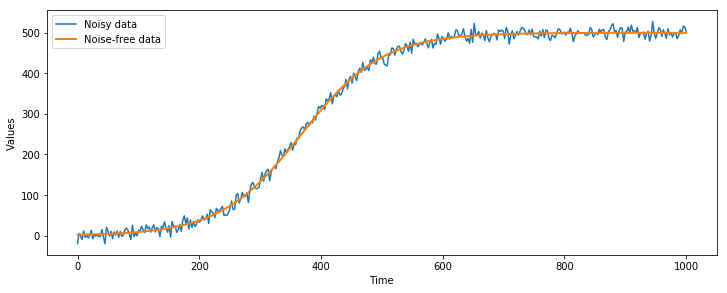

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

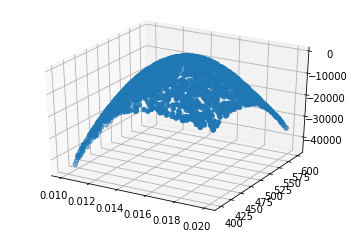

In [13]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [14]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(log_likelihood, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=1000, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               49408     
_________________________________________________________________
dense_5 (Dense)              (None, 320)               82240     
_________________________________________________________________
dense_6 (Dense)              (None, 384)               123264    
_________________________________________________________________
dense_7 (Dense)              (None, 384)               147840    
__________

In [15]:
emu([0.015, 500])

array([[-1515.2559]], dtype=float32)

In [16]:
log_likelihood([0.015, 500])

-1498.0575657573718

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])


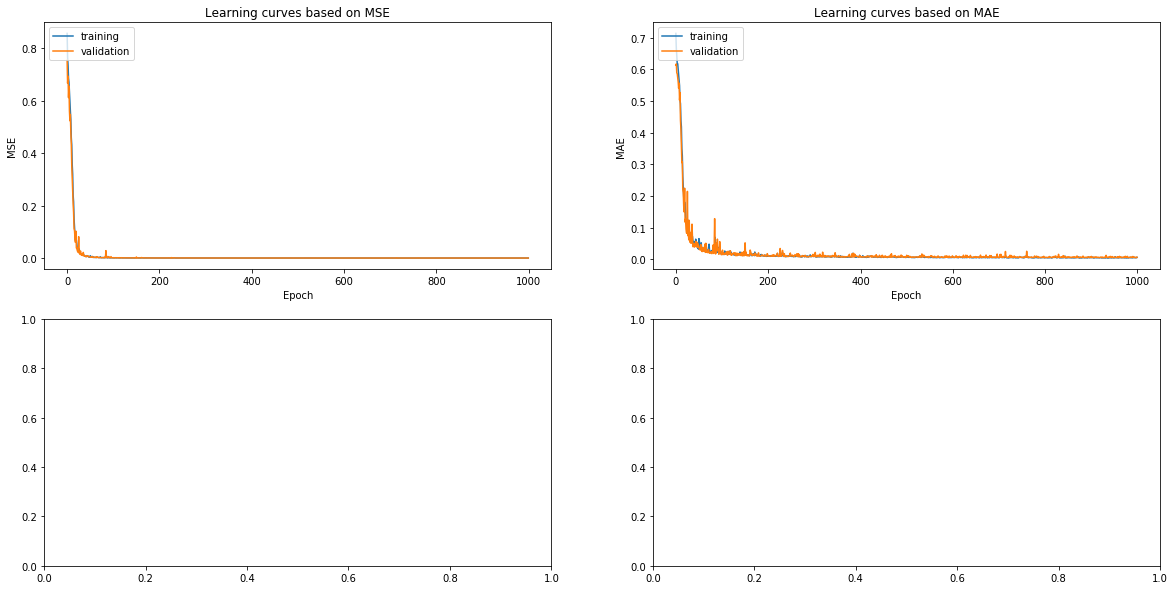

In [17]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

#ax3.plot(hist.history['rescaled_mse'])
#ax3.plot(hist.history['val_rescaled_mse'])
#ax3.set_ylabel('Rescaled MSE')
#ax3.set_xlabel('Epoch')
#ax3.legend(['training', 'validation'], loc='upper left')

#ax4.plot(hist.history['rescaled_mae'])
#ax4.plot(hist.history['val_rescaled_mae'])
#ax4.set_ylabel('Rescaled MAE')
#ax4.set_xlabel('Epoch')
#ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

In [18]:
val_mse = hist.history["val_loss"]
print("Minimum MSE during validation:", min(val_mse))
idx_mse = list(val_mse).index(min(val_mse))
print("Best epoch based on validation MSE:", idx_mse)
print("\n")


val_mae = hist.history["val_mean_absolute_error"]
print("Minimum MAE during validation:", min(val_mae))
idx_mae = list(val_mae).index(min(val_mae))
print("Best epoch based on validation MAE:", idx_mae)
print("\n")

print(val_mse[-1])
print(val_mae[-1])

Minimum MSE during validation: 0.00010785879368389336
Best epoch based on validation MSE: 995


Minimum MAE during validation: 0.004944898877292872
Best epoch based on validation MAE: 997


0.00012208638334413992
0.006036742373059193


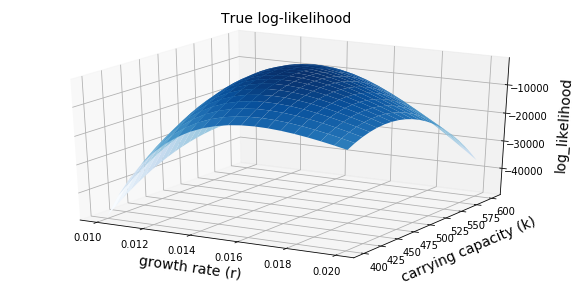

In [19]:
test_splits = 20 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, model_prediction, title = "True log-likelihood",
                     x_label = "growth rate (r)",
                     y_label = "carrying capacity (k)")

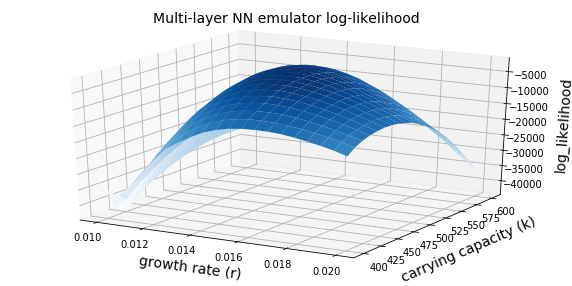

In [20]:
emu_prediction = pints.predict_grid(emu, test_data)

plt.figure(figsize = (10, 5))
ax = pints.plot.surface(r_grid, k_grid, emu_prediction, title = "Multi-layer NN emulator log-likelihood",
                        x_label = "growth rate (r)",
                        y_label = "carrying capacity (k)")

In [21]:
print(model_prediction.shape)
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

(20, 20)


0.007708642433878139

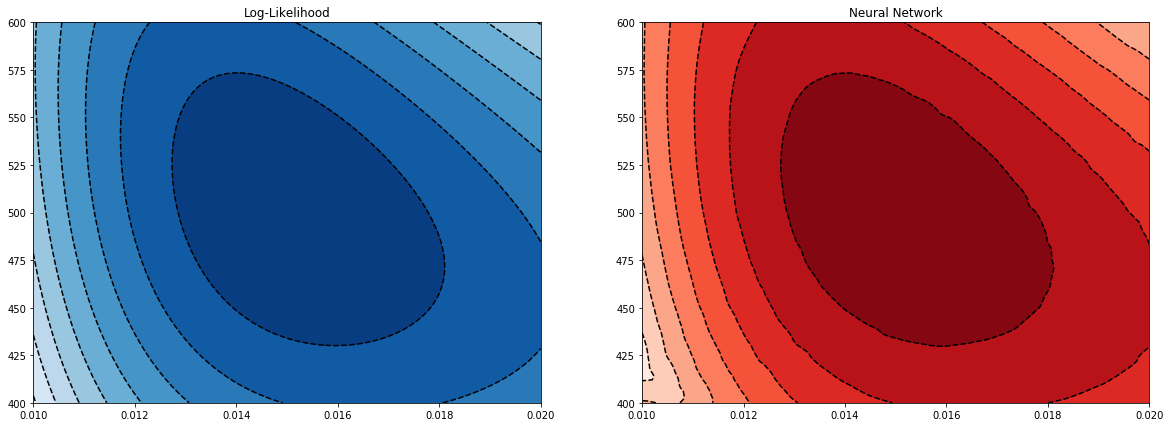

In [22]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

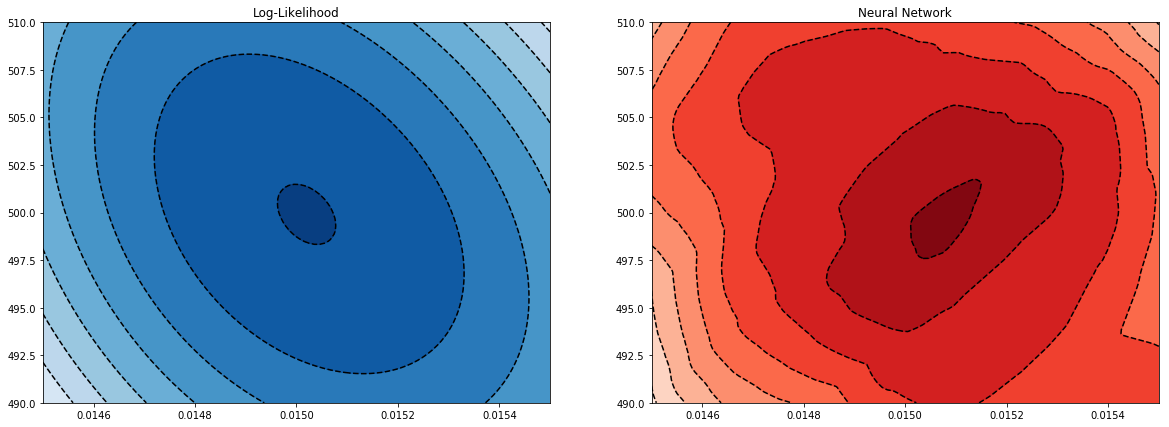

In [23]:
# Create grid
test_splits = 100 # number of splits along each axis
xx, yy, test_data = pints.generate_grid([0.0145, 490], [0.0155, 510], test_splits)
xmin, xmax = np.min(xx), np.max(xx)
ymin, ymax = np.min(yy), np.max(yy)
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

In [24]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)
xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]

In [25]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
[-2.9576451e-03  4.5035972e+02]
-inf


[2.33606649e-02 5.24151066e+02]
-inf


[1.25205399e-02 5.74415284e+02]
-8762.40017840865
accepted


[8.58961163e-03 4.50585312e+02]
-inf


[8.00281673e-03 5.22462664e+02]
-inf


[-4.39330445e-03  5.73472131e+02]
-inf


[-1.15053544e-02  4.48449688e+02]
-inf


[1.72414600e-02 5.24671841e+02]
-6429.697280281428


[6.79111731e-03 5.74119996e+02]
-inf


[7.93503390e-03 4.49013674e+02]
-inf


[1.02809168e-02 5.26718869e+02]
-27709.468474741036


[4.02179796e-03 5.73209491e+02]
-inf


[4.68934317e-03 4.50295451e+02]
-inf


[3.48560931e-03 5.25503770e+02]
-inf


[3.07084150e-03 5.71151224e+02]
-inf


[4.69151281e-03 4.50758577e+02]
-inf


[-5.73012493e-03  5.25486968e+02]
-inf


[3.80364070e-02 5.71002477e+02]
-inf


[8.29072232e-03 4.49169034e+02]
-inf


[1.10885042e-02 5.23883460e+02]
-17927.962821196546


[5.34655672e-03 5.72558839e+02]
-inf


[2.57288228e-02 4.49719423e+02]
-inf


[7.68662073e-03 5.23516007e+02]
-inf


[1.58837104e-03 5.76

-5839.792668933886


[2.27121029e-03 5.25539446e+02]
-inf


[4.80159835e-03 5.73905098e+02]
-inf


[1.37590206e-02 4.51199876e+02]
-6378.709826696869


[1.14820894e-02 5.21428095e+02]
-14237.048439328817


[2.09100138e-02 5.74603317e+02]
-inf


[3.91609634e-03 4.57519734e+02]
-inf


[1.11491732e-02 5.18255346e+02]
-17532.98354327921


[-1.50231066e-02  5.70693385e+02]
-inf


[3.19952772e-02 4.54870718e+02]
-inf


[1.43800361e-02 5.24821276e+02]
-2118.8034894663388


[1.48327221e-02 5.71279115e+02]
-6349.697707197376


[2.99051336e-02 4.52524349e+02]
-inf


[2.28590036e-02 5.20764595e+02]
-inf


[1.47743170e-02 5.70648047e+02]
-6181.035194931594


[1.73139246e-02 4.51581224e+02]
-5026.777316024989


[-1.58841212e-03  5.23237583e+02]
-inf


[1.38609856e-02 5.69300635e+02]
-5572.857574898461
accepted


[4.67982183e-03 4.54989087e+02]
-inf


[1.48748136e-02 5.22785931e+02]
-1975.1392275253654
accepted


[1.64877188e-02 5.70716018e+02]
-10600.142539726705


[1.46869908e-02 4.56274767e+02]
-

[3.97883264e-02 4.54046658e+02]
-inf


[1.47344742e-02 5.24043755e+02]
-2005.0305333289682


[-6.14300427e-03  5.71163342e+02]
-inf


[1.86176608e-02 4.56905879e+02]
-7399.203143014192


[3.05157844e-03 5.19221253e+02]
-inf


[1.0825163e-02 5.6679065e+02]
-20197.411135639522


[1.33423446e-02 4.51548992e+02]
-7833.67641668773


[1.97787684e-02 5.26229294e+02]
-16089.349229332882


[1.52731722e-02 5.68512438e+02]
-6739.195895269212


[3.75101682e-02 4.55577427e+02]
-inf


[1.52900544e-03 5.24480984e+02]
-inf


[2.56603349e-02 5.64359720e+02]
-inf


[3.00185884e-03 4.52430254e+02]
-inf


[1.71634152e-02 5.27557411e+02]
-6497.773888496049


[1.30009635e-02 5.69062620e+02]
-6815.660298681834


[1.14885499e-02 4.50410391e+02]
-20377.35609972103


[-2.53628912e-03  5.20920987e+02]
-inf


[1.47651301e-02 5.65862406e+02]
-5544.203839242904


[1.87170249e-02 4.57024424e+02]
-7634.644020656083


[3.04658126e-02 5.20690531e+02]
-inf


[4.04345196e-02 5.64464697e+02]
-inf


[9.23955966e-03 4.51747

[1.60363167e-02 4.54793153e+02]
-3451.117878703454


[1.44469463e-02 5.22996892e+02]
-2021.561476947648


[1.41560475e-02 5.67190853e+02]
-5293.926827979554
accepted


[1.52000987e-02 4.54706751e+02]
-3471.9637552313206


[1.47465233e-02 5.23155261e+02]
-1968.8349033486022


[1.43228457e-02 5.67139096e+02]
-5333.546077655748


[1.53646932e-02 4.54858521e+02]
-3385.3360939992367


[1.48448294e-02 5.23080165e+02]
-1980.302855900612


[1.41772326e-02 5.67185183e+02]
-5296.030962174989


[1.55193160e-02 4.54752954e+02]
-3358.950182048825


[1.46831391e-02 5.23026345e+02]
-1962.9300966666904
accepted


[1.38847875e-02 5.67134976e+02]
-5334.96584512033


[1.57208571e-02 4.54812050e+02]
-3353.4591080365294


[1.49107109e-02 5.23034358e+02]
-1996.9261488790783


[1.42927593e-02 5.67107342e+02]
-5317.687235749624


[1.55827880e-02 4.54854356e+02]
-3344.777562256464
accepted


[1.44400524e-02 5.23028859e+02]
-2025.8923348243686


[1.39929628e-02 5.67237938e+02]
-5308.564841721487


[1.58484453e-

[1.4201592e-02 4.9823826e+02]
-2089.933121015822
accepted


[1.54190649e-02 5.04868012e+02]
-1683.8343180458157
accepted


[1.57086174e-02 5.26360186e+02]
-2960.9094676817895


[1.46119930e-02 4.86755423e+02]
-1914.8575691797553
accepted


[1.55370342e-02 5.01851242e+02]
-1719.7936616998911


[1.46694634e-02 5.50738524e+02]
-3799.2839213404604


[1.36725341e-02 5.27067806e+02]
-3059.449344681185


[1.53700800e-02 5.06584318e+02]
-1685.1448350923886


[1.50525565e-02 5.30040754e+02]
-2445.010559541841


[1.54641426e-02 4.45416839e+02]
-4262.817729271541


[1.53945582e-02 5.07097112e+02]
-1713.0237754062937


[1.45839007e-02 5.45933823e+02]
-3336.8538467192234


[1.41903213e-02 4.96391473e+02]
-2146.890638940281


[1.56759354e-02 5.00622711e+02]
-1820.4453886621584


[1.50747283e-02 5.34599894e+02]
-2767.45941515154


[1.47644053e-02 4.93155834e+02]
-1631.4446321955031
accepted


[1.53656600e-02 5.08544215e+02]
-1727.5601698823273


[1.64022895e-02 4.99567838e+02]
-2776.109398382705


[1

[1.49579302e-02 5.02381997e+02]
-1504.5324623562935


[1.49521788e-02 5.03549979e+02]
-1510.4576532861481


[1.49304883e-02 5.02092547e+02]
-1505.5224779275434


[1.50575776e-02 5.01048302e+02]
-1501.8140868666626


[1.49192891e-02 5.01561881e+02]
-1505.7080664466455


[1.51581550e-02 5.00994927e+02]
-1517.4230312910793


[1.50466994e-02 5.03815847e+02]
-1516.8580552902456


[1.49193417e-02 4.98862585e+02]
-1509.604857746694


[1.46921368e-02 4.93826336e+02]
-1662.0684958828256


[1.50259417e-02 5.00613222e+02]
-1499.1123929769813
accepted


[1.49984713e-02 5.03424856e+02]
-1509.9169751788436


[1.50346407e-02 5.02183291e+02]
-1504.6588526972048


[1.50558182e-02 5.03264967e+02]
-1513.5393460023827


[1.50002271e-02 5.00041792e+02]
-1498.7373811370505
accepted


[1.48139551e-02 4.98138673e+02]
-1542.4990177546667


[1.49380470e-02 4.99829173e+02]
-1503.810497501409


[1.50545582e-02 4.98740935e+02]
-1499.953772085945
accepted


[1.51021724e-02 5.09895875e+02]
-1622.996111485197


[1.50

[1.50999744e-02 5.00608749e+02]
-1505.0877905557113


[1.49824208e-02 5.00133403e+02]
-1499.4362698290727
accepted


[1.50857535e-02 4.95509950e+02]
-1515.5981440479839


[1.51316201e-02 4.99373543e+02]
-1507.091072176646


[1.49393343e-02 5.00717817e+02]
-1502.837828669605


[1.50922194e-02 4.95715026e+02]
-1514.2025676105898


[1.51379221e-02 4.99275002e+02]
-1507.997921923034


[1.50139360e-02 4.98846531e+02]
-1499.7716130235276
accepted


[1.49115162e-02 4.98070104e+02]
-1515.1354226822316


[1.50816364e-02 4.99556014e+02]
-1501.0933211674649


[1.50183096e-02 5.00766429e+02]
-1499.213793897416
accepted


[1.49909668e-02 4.95950279e+02]
-1517.4090715711793


[1.51174589e-02 4.99271550e+02]
-1504.9058842749937


[1.50128733e-02 5.00222760e+02]
-1498.5733271147003
accepted


[1.50649218e-02 5.00369129e+02]
-1500.7021236779885
accepted


[1.50574228e-02 5.01562789e+02]
-1503.6779515945227


[1.50130930e-02 4.99826354e+02]
-1498.5291332391118
accepted


[1.50242141e-02 5.00366994e+02]


[1.51171764e-02 4.97632084e+02]
-1506.4433308879163


[1.49197210e-02 5.02001331e+02]
-1506.4226478705853


[1.50176315e-02 4.98129158e+02]
-1501.7733758827162


[1.50469079e-02 4.98486429e+02]
-1500.3016095647783


[1.50178448e-02 4.99787027e+02]
-1498.4992190887078
accepted


[1.50447235e-02 4.98565611e+02]
-1500.095828095129


[1.50391611e-02 4.99769447e+02]
-1498.7320050206001
accepted


[1.49983469e-02 4.99462332e+02]
-1499.2271048520686


[1.50170519e-02 4.99218465e+02]
-1499.000890755101


[1.50106915e-02 5.00439639e+02]
-1498.7345179192844
accepted


[1.49921843e-02 5.00959247e+02]
-1499.6018276051914
accepted


[1.50033947e-02 4.99739451e+02]
-1498.768488845222
accepted


[1.49904062e-02 5.01473491e+02]
-1500.7052856708813


[1.49613594e-02 5.01903576e+02]
-1502.7855868835682


[1.50341771e-02 4.99835814e+02]
-1498.6222552904485
accepted


[1.50443171e-02 5.00317133e+02]
-1499.326974910639


[1.49560980e-02 5.00713423e+02]
-1501.2321161054936


[1.50639101e-02 4.98208834e+02]


[1.50690332e-02 5.00473204e+02]
-1501.2559778075567


[1.50358057e-02 4.99677479e+02]
-1498.6530744399674
accepted


[1.49831345e-02 5.02277107e+02]
-1503.4600637683109


[1.50811216e-02 4.99415530e+02]
-1500.9901517897652


[1.50982069e-02 4.98912026e+02]
-1502.5878637639769


[1.50048362e-02 5.00412615e+02]
-1498.7579180721757
accepted


[1.50070153e-02 5.00420776e+02]
-1498.7405524198543
accepted


[1.50924050e-02 5.00561831e+02]
-1503.9573453486785


[1.50318630e-02 5.00579443e+02]
-1499.226587347388


[1.50385318e-02 5.00538677e+02]
-1499.4080735929642
accepted


[1.50662875e-02 5.00771136e+02]
-1501.7471310763215


[1.50697644e-02 5.00200853e+02]
-1500.7965179177843
accepted


[1.50292583e-02 5.00793027e+02]
-1499.530220278018
accepted


[1.50295844e-02 5.00674157e+02]
-1499.315381039289
accepted


[1.50853618e-02 5.01118377e+02]
-1504.941081402143


[1.49414880e-02 5.01478222e+02]
-1503.2238186221618


[1.50282371e-02 5.01343330e+02]
-1500.9026609903133


[1.50482718e-02 5.00415

[1.50017517e-02 4.99284779e+02]
-1499.3500372061274
accepted


[1.49874632e-02 5.00780679e+02]
-1499.4855378143625


[1.49978411e-02 5.00266115e+02]
-1498.8201897562685
accepted


[1.50401743e-02 5.00025784e+02]
-1498.8654798211335
accepted


[1.49840066e-02 4.99637952e+02]
-1499.7377986066488


[1.50480015e-02 4.98848706e+02]
-1499.61226263262


[1.50620113e-02 4.99318785e+02]
-1499.6879189525669
accepted


[1.50527784e-02 5.00859634e+02]
-1500.9046246089335


[1.49844122e-02 4.99400775e+02]
-1500.0720751745346


[1.50913995e-02 4.99517871e+02]
-1501.9915461770238


[1.50543662e-02 4.99786387e+02]
-1499.3287811388143


[1.50180008e-02 5.01830572e+02]
-1502.2000259258618


[1.51946909e-02 4.97047118e+02]
-1519.7365818286746


[1.49521522e-02 4.99117846e+02]
-1503.7588214876205


[1.49947137e-02 5.01192649e+02]
-1499.9908417729614
accepted


[1.51058105e-02 5.00251375e+02]
-1504.8901213444167


[1.49991851e-02 4.99813746e+02]
-1498.852496256136
accepted


[1.49310923e-02 5.01896064e+02]

[1.50077258e-02 5.00895966e+02]
-1499.3480711063542


[1.50062076e-02 5.00353910e+02]
-1498.7010962249929
accepted


[1.49750045e-02 5.04707464e+02]
-1519.075641381073


[1.51398635e-02 4.98241092e+02]
-1508.1825573635253


[1.50374027e-02 4.99177684e+02]
-1498.990594677961
accepted


[1.49987056e-02 5.03577431e+02]
-1510.9786574609498


[1.49954917e-02 5.00662817e+02]
-1499.14142555258
accepted


[1.50296849e-02 4.98126748e+02]
-1501.4134485911036


[1.50812674e-02 5.00793136e+02]
-1503.3242283337227
accepted


[1.49818099e-02 5.00101210e+02]
-1499.4803343677934
accepted


[1.50199466e-02 5.00196526e+02]
-1498.5667378353514
accepted


[1.50294265e-02 4.99715003e+02]
-1498.5482699699605
accepted


[1.50749417e-02 4.99449255e+02]
-1500.5073452058223


[1.50373403e-02 5.00047782e+02]
-1498.7894564037992
accepted


[1.4940593e-02 5.0299053e+02]
-1507.9942944202116


[1.49642541e-02 5.00664365e+02]
-1500.5889093733315


[1.50624482e-02 5.01399216e+02]
-1503.4888942848127


[1.50436964e-02 

[1.51128775e-02 4.98742830e+02]
-1504.2525461349087


[1.50098004e-02 5.03136306e+02]
-1508.5474965208302


[1.51419019e-02 5.00436422e+02]
-1511.4992845389045


[1.50459663e-02 4.98553077e+02]
-1500.1380701828593


[1.50165565e-02 5.00292914e+02]
-1498.614934303287
accepted


[1.50496244e-02 4.98010345e+02]
-1501.6587269178901
accepted


[1.51040057e-02 5.02873774e+02]
-1518.1410855229283


[1.49623468e-02 4.97918238e+02]
-1507.4060382879961


[1.49595900e-02 5.00925997e+02]
-1501.0854351342496
accepted


[1.49617855e-02 5.01141642e+02]
-1501.1673756871342


[1.51223405e-02 4.98860501e+02]
-1505.4183882527311


[1.48965138e-02 5.01635677e+02]
-1508.9955117231352


[1.48941699e-02 4.98769763e+02]
-1515.0576453398598


[1.50967959e-02 4.96541624e+02]
-1509.2487087862423


[1.48936794e-02 5.03882847e+02]
-1516.6078429633503


[1.51041250e-02 4.99482863e+02]
-1503.3726793469802


[1.51630451e-02 4.97276703e+02]
-1513.397802960144


[1.47912732e-02 5.03153387e+02]
-1535.0917913243106


[1.

[1.51058887e-02 4.99612244e+02]
-1503.7230230780167


[1.48837670e-02 5.04060909e+02]
-1518.8011490358806


[1.50643336e-02 4.98798333e+02]
-1500.2342148568841


[1.50087224e-02 4.98903761e+02]
-1499.8202079005302
accepted


[1.50163726e-02 5.00476782e+02]
-1498.7821800304157
accepted


[1.50035370e-02 4.98234339e+02]
-1502.0837168779171


[1.50498502e-02 4.98371511e+02]
-1500.6200480419125
accepted


[1.50219648e-02 5.01157008e+02]
-1500.142841842408


[1.49780407e-02 4.98400783e+02]
-1503.4246361158619


[1.50302964e-02 4.99996163e+02]
-1498.5922234340137
accepted


[1.50587078e-02 4.99600097e+02]
-1499.493323457186
accepted


[1.50544727e-02 4.99661102e+02]
-1499.2902129660126
accepted


[1.51095158e-02 5.02195942e+02]
-1514.2959471243448


[1.50477833e-02 4.99337973e+02]
-1499.080810943077
accepted


[1.50293493e-02 4.99686600e+02]
-1498.5535465707574
accepted


[1.50889462e-02 4.99655469e+02]
-1501.8550638243505


[1.50746237e-02 4.99203611e+02]
-1500.4947040399613


[1.50317866e-

[1.50038448e-02 4.99586161e+02]
-1498.8813861651624
accepted


[1.50078270e-02 5.01320364e+02]
-1500.2864526669996


[1.49840107e-02 5.01294808e+02]
-1500.4134195531262


[1.50472218e-02 4.97172976e+02]
-1505.1304916136976


[1.50303493e-02 4.99402525e+02]
-1498.7106141231095
accepted


[1.49336660e-02 5.00225544e+02]
-1503.7875351098876


[1.50513030e-02 4.97003277e+02]
-1505.9532506323858


[1.50274101e-02 4.98832690e+02]
-1499.5243065025536
accepted


[1.50034151e-02 4.99550761e+02]
-1498.9311016735414
accepted


[1.49971718e-02 5.00312281e+02]
-1498.8530227726217
accepted


[1.51007635e-02 4.99227158e+02]
-1502.8364377331536


[1.50071049e-02 4.99424563e+02]
-1498.961366961086
accepted


[1.49168738e-02 5.01329214e+02]
-1505.776388664938


[1.51198388e-02 4.95671255e+02]
-1515.7479653475482


[1.50048801e-02 4.98152611e+02]
-1502.3155226948818


[1.49929623e-02 4.99275552e+02]
-1499.7845216802048
accepted


[1.49942483e-02 4.95081904e+02]
-1525.2375447154739


[1.49774645e-02 4.993



[1.49861166e-02 5.00620313e+02]
-1499.381125550683
accepted


[1.50329209e-02 5.00781681e+02]
-1499.6381159492319
accepted


[1.49804805e-02 4.98630912e+02]
-1502.358100545731


[1.49643179e-02 5.02264995e+02]
-1503.8354837776162


[1.50203750e-02 4.98532417e+02]
-1500.3798476506674


[1.50628290e-02 4.98026104e+02]
-1501.836071333833


[1.50043280e-02 4.97881103e+02]
-1503.4802515591657


[1.50458743e-02 5.00237289e+02]
-1499.2968289104083
accepted


[1.50021851e-02 5.02003117e+02]
-1502.449167123592


[1.51932852e-02 4.98271711e+02]
-1518.1966753655713


[1.49743550e-02 5.01399107e+02]
-1500.9528140986351


[1.50084217e-02 5.00909936e+02]
-1499.3749918551362
accepted


[1.49918758e-02 4.98115165e+02]
-1503.3718576100625


[1.51374077e-02 4.96503766e+02]
-1512.625265300789


[1.50400890e-02 5.01755797e+02]
-1503.0808045193899


[1.49349722e-02 5.00372310e+02]
-1503.4825681250816


[1.50831628e-02 5.01826457e+02]
-1507.8737611358677


[1.50769546e-02 4.99544019e+02]
-1500.69489127950

[1.48989401e-02 5.02479433e+02]
-1510.1975153230426


[1.49772958e-02 5.09514749e+02]
-1585.4019925037571


[1.50204569e-02 4.99191584e+02]
-1498.9852893945822
accepted


[1.49680933e-02 5.03539034e+02]
-1510.1181931197252


[1.49917483e-02 5.03859788e+02]
-1512.740744524955


[1.50336587e-02 4.97239549e+02]
-1505.11214859734


[1.49977009e-02 5.02164045e+02]
-1503.0329855683865


[1.51019567e-02 5.04386385e+02]
-1531.881680090739


[1.50875422e-02 4.97941606e+02]
-1503.1902359284652


[1.49374068e-02 4.96909044e+02]
-1517.9682454294182


[1.50182868e-02 5.01472803e+02]
-1500.9452438662702
accepted


[1.49867328e-02 4.99020263e+02]
-1500.7219060775071
accepted


[1.49760859e-02 5.01627843e+02]
-1501.429911810924


[1.50230342e-02 5.00831731e+02]
-1499.4286768924426
accepted


[1.49584240e-02 5.00992484e+02]
-1501.2297747672842


[1.50439619e-02 5.00236600e+02]
-1499.2088010308707
accepted


[1.51012256e-02 5.01578704e+02]
-1509.2648018642456


[1.50385666e-02 4.97961144e+02]
-1501.8499

[1.52685711e-02 4.99419766e+02]
-1542.8545566469136


[1.50227622e-02 5.01536626e+02]
-1501.3088790302877


[1.50395625e-02 5.00430579e+02]
-1499.2795470555263
accepted


[1.52922465e-02 4.98247316e+02]
-1547.7363230122933


[1.50840242e-02 5.02408691e+02]
-1511.4074663309318


[1.50113790e-02 5.03623227e+02]
-1511.9989677576066


[1.50410489e-02 4.99917778e+02]
-1498.8330783677875
accepted


[1.49786087e-02 5.00606288e+02]
-1499.6977868806077


[1.49887929e-02 5.01208422e+02]
-1500.1215776507631
accepted


[1.50007732e-02 4.99361772e+02]
-1499.2692646716005
accepted


[1.50358042e-02 5.01139437e+02]
-1500.6468744041365


[1.49716988e-02 5.04120338e+02]
-1514.1778903749325


[1.51399021e-02 4.97665673e+02]
-1509.061414992167


[1.49188603e-02 5.02256065e+02]
-1507.1406376501207


[1.50334127e-02 5.00504022e+02]
-1499.1593789318504
accepted


[1.49976841e-02 5.00046933e+02]
-1498.8112920793149
accepted


[1.51118436e-02 4.98114321e+02]
-1504.83463398125


[1.51070750e-02 5.02010166e+02]

[1.51332138e-02 4.98363713e+02]
-1507.1177793785844


[1.50124830e-02 4.97548193e+02]
-1504.535384787817


[1.49769198e-02 4.99320590e+02]
-1500.764728975097
accepted


[1.50426594e-02 5.01211502e+02]
-1501.249746958541
accepted


[1.51115790e-02 4.97218052e+02]
-1507.2178772864959


[1.50782545e-02 4.99076026e+02]
-1500.802212557352
accepted


[1.50810726e-02 4.98198702e+02]
-1502.1740874244592
accepted


[1.50251976e-02 4.97502816e+02]
-1504.1167990458173


[1.50690639e-02 4.99885474e+02]
-1500.3266907116024
accepted


[1.50289445e-02 5.00741048e+02]
-1499.4183632819088
accepted


[1.50349418e-02 5.00242063e+02]
-1498.8787121157777
accepted


[1.50128184e-02 4.99541410e+02]
-1498.7010457540803
accepted


[1.51452233e-02 4.95758999e+02]
-1517.3597027488959


[1.49827597e-02 5.00871434e+02]
-1499.7544678336767


[1.49846603e-02 5.01255836e+02]
-1500.3157644088462


[1.51188892e-02 5.00312452e+02]
-1507.0020599875236


[1.49814441e-02 5.01905297e+02]
-1502.1130733715831


[1.51410277e-0

[1.49906989e-02 5.02652925e+02]
-1505.182968859719


[1.50009977e-02 4.98587708e+02]
-1501.0268455184735
accepted


[1.49678478e-02 5.00021443e+02]
-1500.4592664614895
accepted


[1.49311496e-02 4.97827775e+02]
-1512.7736042631643


[1.49846477e-02 5.01211454e+02]
-1500.2280431605573
accepted


[1.48443652e-02 4.98321105e+02]
-1530.91326355655


[1.50723034e-02 5.02924707e+02]
-1513.2260285553843


[1.49938935e-02 5.02359001e+02]
-1503.8281224715115


[1.48811297e-02 5.00094745e+02]
-1513.022299052258


[1.51321708e-02 4.96962182e+02]
-1510.1586211235167


[1.50791551e-02 4.99677407e+02]
-1500.9589820185668
accepted


[1.49307183e-02 5.02835640e+02]
-1507.9983700847947


[1.50203062e-02 4.99041568e+02]
-1499.226699751774
accepted


[1.50997756e-02 5.00355516e+02]
-1504.3402556886826


[1.49302701e-02 5.00246504e+02]
-1504.2071240210905


[1.49832901e-02 4.98223029e+02]
-1503.6539475811858


[1.50669975e-02 4.98658702e+02]
-1500.560211667565
accepted


[1.49468730e-02 4.99893113e+02]
-1

[1.49479020e-02 4.97844832e+02]
-1509.861933610122


[1.50054857e-02 4.94710077e+02]
-1527.6974460023469


[1.49505260e-02 5.00386399e+02]
-1501.7543565554479


[1.51625793e-02 4.97204264e+02]
-1513.504795937079


[1.50162098e-02 5.01705086e+02]
-1501.6675050623735
accepted


[1.51744861e-02 4.98722803e+02]
-1514.3250053383942


[1.50666456e-02 5.01442171e+02]
-1504.082910494122


[1.50200477e-02 5.00474556e+02]
-1498.8143047459046
accepted


[1.49923318e-02 5.02386090e+02]
-1503.9338651080188


[1.51122084e-02 4.94788904e+02]
-1522.0710378250265


[1.49965097e-02 5.02992458e+02]
-1507.1363190438421


[1.51949601e-02 5.01484841e+02]
-1530.0985606860065


[1.50791501e-02 4.91284849e+02]
-1566.7392108173387


[1.50563973e-02 5.03594838e+02]
-1516.2406342808965


[1.50377630e-02 5.02583622e+02]
-1507.063234006292


[1.51114831e-02 4.93814692e+02]
-1531.4026883439403


[1.50764194e-02 5.01158727e+02]
-1504.02796406258


[1.48842552e-02 5.00219229e+02]
-1512.075090069403


[1.49805197e-02 4

[1.50384827e-02 4.99151088e+02]
-1499.0344894881262
accepted


[1.50545158e-02 4.99343306e+02]
-1499.3244853405884
accepted


[1.51428793e-02 4.98198427e+02]
-1508.6737845704663


[1.50545852e-02 4.97123845e+02]
-1505.3110927544346


[1.51799549e-02 4.96889304e+02]
-1517.3171288730607


[1.50287980e-02 4.98148579e+02]
-1501.3582731505046


[1.50039858e-02 5.03197083e+02]
-1508.6558990699382


[1.51294335e-02 4.98340776e+02]
-1506.6186042005884


[1.50476502e-02 4.99074160e+02]
-1499.3005780582541


[1.50603436e-02 5.04805920e+02]
-1528.4359793204665


[1.50191009e-02 4.99932960e+02]
-1498.4787329649891
accepted


[1.50300130e-02 5.00886421e+02]
-1499.7540243856124


[1.50507360e-02 4.97937551e+02]
-1501.9079988502604


[1.49214766e-02 5.04340190e+02]
-1516.986992226489


[1.50521501e-02 5.01913155e+02]
-1504.761290107639


[1.50266651e-02 4.94074459e+02]
-1532.4045170937952


[1.50208233e-02 5.00875624e+02]
-1499.4648846260923
accepted


[1.50842128e-02 4.98832198e+02]
-1501.4094354083

[1.50965684e-02 4.94781627e+02]
-1521.7553354128484


[1.50741776e-02 4.96737687e+02]
-1507.448423825381


[1.50255353e-02 5.01618101e+02]
-1501.7098751859078


[1.49662934e-02 4.98450997e+02]
-1504.45117940349


[1.49735563e-02 5.01233291e+02]
-1500.6663845846083


[1.49860559e-02 5.02986449e+02]
-1506.8921005131533


[1.50160277e-02 4.98320353e+02]
-1501.1691725035034
accepted


[1.49358116e-02 4.99589422e+02]
-1504.6137229247558


[1.50994645e-02 4.99797052e+02]
-1503.1792108104844


[1.50197896e-02 4.98089008e+02]
-1501.8381018363796


[1.50451268e-02 4.98403183e+02]
-1500.4863744465629


[1.50367934e-02 5.00697455e+02]
-1499.6250866790508
accepted


[1.50840152e-02 4.96024670e+02]
-1511.9013996736965


[1.50649314e-02 4.99720796e+02]
-1499.9087170381574


[1.50195238e-02 4.99524658e+02]
-1498.6262366952499
accepted


[1.50247322e-02 4.97547296e+02]
-1503.9244781622363


[1.50523631e-02 4.96282973e+02]
-1510.2622988332355


[1.49515423e-02 5.00302848e+02]
-1501.6982115333624


[1.5

[1.51387396e-02 5.01312827e+02]
-1514.7968473851881


[1.51496967e-02 4.97429423e+02]
-1510.9730306545464


[1.50467685e-02 5.00598485e+02]
-1499.9213376534176


[1.51591572e-02 4.96287689e+02]
-1516.2717575127967


[1.50991839e-02 4.99679130e+02]
-1502.9916704965494


[1.49411466e-02 5.00926301e+02]
-1502.6937707873253


[1.50730513e-02 5.00227738e+02]
-1501.1236965301619


[1.50133447e-02 5.00597723e+02]
-1498.9096335672689


[1.48665784e-02 5.03232904e+02]
-1517.5841569028141


[1.50878748e-02 4.93155715e+02]
-1539.2064974993157


[1.49287754e-02 5.01013045e+02]
-1504.098727319834


[1.50502971e-02 5.02036295e+02]
-1505.193380978801


[1.50432814e-02 4.97257332e+02]
-1504.7744380615743


[1.49917931e-02 4.99546593e+02]
-1499.420609101139
accepted


[1.49666888e-02 5.02516903e+02]
-1504.7500951917846


[1.49722113e-02 5.02203006e+02]
-1503.3566044435427
accepted


[1.49177919e-02 5.01039500e+02]
-1505.5125049021942


[1.50877546e-02 4.98760675e+02]
-1501.7511407149552


[1.50374698e-

[1.49669124e-02 4.96764820e+02]
-1514.1055046057975


[1.48341235e-02 5.01538629e+02]
-1522.0438995510585


[1.49410901e-02 5.00469857e+02]
-1502.7038741074305


[1.52217484e-02 5.01223643e+02]
-1536.693277780774


[1.50435775e-02 4.99189052e+02]
-1499.0837919240923
accepted


[1.49661003e-02 4.95383587e+02]
-1526.5305992404321


[1.50426048e-02 5.02445831e+02]
-1506.6857081653645


[1.50608545e-02 4.96456271e+02]
-1509.005517587123


[1.50120412e-02 4.97362111e+02]
-1505.5217556733346


[1.49068915e-02 5.00854864e+02]
-1507.1341992244986


[1.51384935e-02 4.94734913e+02]
-1523.973140780741


[1.50218977e-02 5.00519535e+02]
-1498.89610544267
accepted


[1.48522280e-02 5.00912798e+02]
-1518.0709243168671


[1.50392584e-02 4.97282591e+02]
-1504.7343146782193


[1.49754944e-02 5.00478233e+02]
-1499.8099287798125


[1.48742020e-02 5.00989162e+02]
-1513.0202820426714


[1.50014255e-02 5.00511066e+02]
-1498.884695767021
accepted


[1.50351190e-02 4.97932731e+02]
-1502.0017514981453


[1.4866

[1.51300236e-02 4.97319615e+02]
-1508.713707741292


[1.48677208e-02 5.01399065e+02]
-1514.1844161821598


[1.50467013e-02 5.00127810e+02]
-1499.212758755218
accepted


[1.52152249e-02 4.92730259e+02]
-1551.422700098081


[1.50495372e-02 5.01502712e+02]
-1502.7601321499412


[1.49792168e-02 5.00138791e+02]
-1499.6130341217304


[1.49336346e-02 5.01740522e+02]
-1504.41999262972


[1.49449376e-02 5.01539276e+02]
-1503.028478517381


[1.49630364e-02 5.01536388e+02]
-1501.7780262550718


[1.52780017e-02 4.95165443e+02]
-1546.4762807342975


[1.50136982e-02 5.02811413e+02]
-1506.7679769469428


[1.50165833e-02 4.99828478e+02]
-1498.4964390194232
accepted


[1.51542836e-02 4.96751466e+02]
-1513.6893554460514


[1.50164374e-02 5.01417468e+02]
-1500.7215842041096
accepted


[1.49746138e-02 5.04746473e+02]
-1519.410131948656


[1.51395760e-02 4.95781924e+02]
-1516.652808377807


[1.49856129e-02 5.03281815e+02]
-1508.6217781593803


[1.50003210e-02 5.01382386e+02]
-1500.4064541251153


[1.505741



[1.49924294e-02 5.02066853e+02]
-1502.6040600594079


[1.51374225e-02 4.97845587e+02]
-1508.3733996477279


[1.49395669e-02 5.03399883e+02]
-1510.1154362138207


[1.50560024e-02 4.98331594e+02]
-1500.8358829941221
accepted


[1.49367290e-02 5.00513057e+02]
-1503.181847317083


[1.49922932e-02 5.00366647e+02]
-1499.0186780398067
accepted


[1.50171118e-02 5.00752156e+02]
-1499.1720426187196
accepted


[1.50216555e-02 4.98254301e+02]
-1501.1929517840103


[1.49022900e-02 4.99376881e+02]
-1510.8223727920556


[1.51594263e-02 4.99401231e+02]
-1512.135927416024


[1.51703976e-02 5.00434819e+02]
-1517.6899104791216


[1.49868239e-02 4.99674784e+02]
-1499.5284164431903
accepted


[1.50340994e-02 5.00324756e+02]
-1498.9423947609312
accepted


[1.49841755e-02 5.04354568e+02]
-1516.359721436411


[1.50378543e-02 4.99732315e+02]
-1498.695600075139
accepted


[1.49847802e-02 5.00273572e+02]
-1499.299263914162


[1.51092094e-02 4.99689166e+02]
-1504.250006685545


[1.49077329e-02 4.98613699e+02]


[1.51074012e-02 4.96726885e+02]
-1508.9406612561613


[1.50591175e-02 4.99755839e+02]
-1499.5704229926944
accepted


[1.51069131e-02 4.99772837e+02]
-1504.0727094456163


[1.49081192e-02 4.99928464e+02]
-1508.1584235336813


[1.5030878e-02 4.9786340e+02]
-1502.3555617228278


[1.50412212e-02 4.96999375e+02]
-1506.164637197393


[1.50508703e-02 4.96675443e+02]
-1507.8026082659983


[1.50979600e-02 4.96925161e+02]
-1507.433210958297


[1.49552863e-02 4.99772257e+02]
-1501.9033304301122


[1.49824988e-02 5.00465595e+02]
-1499.4443277025975
accepted


[1.49372556e-02 4.99359279e+02]
-1505.0091505088863


[1.51398612e-02 4.99678024e+02]
-1508.9732546110733


[1.49504920e-02 4.99498565e+02]
-1502.9574139175245


[1.50920835e-02 5.01293632e+02]
-1506.549910778188


[1.49855501e-02 5.01280804e+02]
-1500.3445725478673


[1.50956660e-02 4.99353109e+02]
-1502.3371494951061


[1.49483113e-02 4.98667464e+02]
-1505.8283837417682


[1.50076606e-02 5.01795121e+02]
-1501.7677338364488


[1.49995622e-02

[1.50365152e-02 5.02328736e+02]
-1505.5428111362871


[1.50483838e-02 4.99221330e+02]
-1499.1796228309308
accepted


[1.50188820e-02 5.01105788e+02]
-1499.9321224440762
accepted


[1.49313678e-02 5.00485548e+02]
-1503.8504227006938


[1.50714599e-02 4.96055199e+02]
-1511.5773706668585


[1.50400149e-02 5.00193992e+02]
-1499.001575045625
accepted


[1.50541665e-02 5.00436577e+02]
-1500.0584483327705


[1.50550566e-02 4.95710683e+02]
-1514.3612799303908


[1.50948057e-02 4.98606341e+02]
-1502.5010619637903


[1.49722985e-02 5.02424918e+02]
-1504.2253964668002


[1.51214846e-02 4.96976595e+02]
-1509.0111090657192


[1.50745900e-02 4.98644718e+02]
-1500.9786810480864
accepted


[1.50597697e-02 5.01743958e+02]
-1504.6974343289608


[1.50714071e-02 4.96786387e+02]
-1507.1422925681206


[1.51162192e-02 4.96105334e+02]
-1512.8092838154716


[1.50778789e-02 4.97493994e+02]
-1504.1165234649054


[1.51133000e-02 4.97431572e+02]
-1506.6491045320022


[1.50477221e-02 5.00808228e+02]
-1500.439783561

[1.51682718e-02 4.97005229e+02]
-1514.9741776157534


[1.48409543e-02 4.99188705e+02]
-1526.7706883224973


[1.49472266e-02 4.98619352e+02]
-1506.1732718385003


[1.48473204e-02 5.05925442e+02]
-1537.0811650731698


[1.49819609e-02 4.97185448e+02]
-1509.238059321708


[1.49940119e-02 5.00384071e+02]
-1498.9716623477684
accepted


[1.50756253e-02 4.99804248e+02]
-1500.7686025910555


[1.49796277e-02 5.00060300e+02]
-1499.623008879081
accepted


[1.4931373e-02 5.0151737e+02]
-1504.268055424484


[1.49375058e-02 5.01011446e+02]
-1503.1144432662918


[1.50608238e-02 4.98319025e+02]
-1500.995515702059


[1.49583233e-02 5.02232413e+02]
-1503.9735188605355


[1.48864166e-02 5.01953851e+02]
-1511.0180278082805


[1.49960076e-02 5.01910351e+02]
-1502.034892545457


[1.49907006e-02 5.01058913e+02]
-1499.799283564652


[1.4970199e-02 5.0156592e+02]
-1501.4964064300402


[1.48613690e-02 4.98104216e+02]
-1527.3187761678073


[1.49303915e-02 5.02317265e+02]
-1506.1671658879472


[1.51803086e-02 5.00

[1.51295894e-02 4.98105090e+02]
-1506.9166096437427


[1.50958205e-02 5.01481202e+02]
-1507.9476064345474


[1.49662617e-02 4.99289426e+02]
-1501.764291316296


[1.49163853e-02 4.99964943e+02]
-1506.692820337283


[1.50169583e-02 4.98335530e+02]
-1501.0844027982312


[1.50342312e-02 5.00164202e+02]
-1498.7865178461955


[1.50407879e-02 4.98979821e+02]
-1499.2880091860445


[1.5054720e-02 5.0081584e+02]
-1500.92917341725


[1.49419686e-02 4.99198433e+02]
-1504.8283201108688


[1.49886159e-02 5.01559891e+02]
-1500.9594219582234


[1.49841029e-02 5.02762143e+02]
-1505.6802235902449


[1.50496687e-02 4.99635914e+02]
-1499.0733812075507


[1.50962693e-02 4.96394008e+02]
-1510.0298187541337


[1.49378655e-02 4.99184311e+02]
-1505.444410015941


[1.50559063e-02 4.97221560e+02]
-1504.8345701083772


[1.51150979e-02 4.97999136e+02]
-1505.387812062843


[1.49964696e-02 4.98336329e+02]
-1502.1572514294273


[1.50193250e-02 5.01005728e+02]
-1499.7082715868305


[1.50778593e-02 4.98954569e+02]
-150



[1.50780454e-02 5.00661484e+02]
-1502.5882528244363


[1.51038240e-02 4.99317325e+02]
-1503.2191877208893


[1.50941372e-02 5.00440722e+02]
-1503.8405270300634


[1.50072781e-02 4.99381682e+02]
-1499.0111212604938
accepted


[1.51063940e-02 4.97988036e+02]
-1504.5472808477684
accepted


[1.51960974e-02 4.99951426e+02]
-1522.2488042011535


[1.48746540e-02 5.00838389e+02]
-1513.0693951446476


[1.50530852e-02 4.98811146e+02]
-1499.7985683696
accepted


[1.51087053e-02 5.02217070e+02]
-1514.285503868751


[1.50727609e-02 4.98116741e+02]
-1501.9422956497128


[1.49991724e-02 4.99934952e+02]
-1498.794144700526
accepted


[1.50474886e-02 4.99003902e+02]
-1499.3803129383357
accepted


[1.50021968e-02 4.96543879e+02]
-1511.452196194867


[1.50394979e-02 4.99579169e+02]
-1498.7525957168812
accepted


[1.50944861e-02 4.98392165e+02]
-1502.758171663187


[1.50140808e-02 4.99439238e+02]
-1498.777397307655
accepted


[1.50592238e-02 4.97346853e+02]
-1504.2747004052853


[1.50690210e-02 4.9864075

[1.50249439e-02 5.00266434e+02]
-1498.6719584659597
accepted


[1.5045784e-02 4.9894682e+02]
-1499.4191398950622


[1.50885967e-02 4.95579034e+02]
-1515.1159933202505


[1.49441249e-02 5.00072937e+02]
-1502.6964704191641


[1.49648711e-02 5.03046279e+02]
-1507.3032766161987


[1.50427919e-02 5.00609947e+02]
-1499.7328804883132
accepted


[1.50402585e-02 4.98161451e+02]
-1501.1639182280996


[1.50322702e-02 5.00616573e+02]
-1499.302301107601
accepted


[1.50988161e-02 5.01539442e+02]
-1508.68799005048


[1.49362361e-02 5.02135443e+02]
-1505.1247425098024


[1.50939674e-02 4.99499583e+02]
-1502.2437549744934


[1.51852449e-02 4.98312576e+02]
-1516.4211506364702


[1.50681360e-02 4.99314377e+02]
-1500.0403279766379


[1.50183775e-02 4.99112838e+02]
-1499.1400425420447
accepted


[1.51051468e-02 5.00116804e+02]
-1504.4830110881992


[1.49797173e-02 4.99784664e+02]
-1499.8351259408637


[1.49749782e-02 5.00778887e+02]
-1500.0052455195369
accepted


[1.49787391e-02 5.00278188e+02]
-1499.6094

[1.50469535e-02 5.02786550e+02]
-1509.1641345539445


[1.50248475e-02 5.00870899e+02]
-1499.5551659511327


[1.51104589e-02 4.97879938e+02]
-1505.1695208716521


[1.49303107e-02 5.01487788e+02]
-1504.3390244784318


[1.49714106e-02 4.98209130e+02]
-1504.909465110173


[1.51452782e-02 4.97064803e+02]
-1511.3864680054658


[1.49498691e-02 5.04425427e+02]
-1516.5320044467276


[1.50493411e-02 4.98227645e+02]
-1500.9966880069348


[1.49772397e-02 4.99566594e+02]
-1500.2930497898512
accepted


[1.48311658e-02 5.00039215e+02]
-1525.9674137208133


[1.49370218e-02 5.01021542e+02]
-1503.171396654035


[1.49867279e-02 4.99269327e+02]
-1500.1670822900385
accepted


[1.49684149e-02 4.99132605e+02]
-1501.9487113720654


[1.50505611e-02 4.99185464e+02]
-1499.2768278224864
accepted


[1.48988732e-02 4.99682996e+02]
-1510.5044453067396


[1.50229313e-02 4.98730469e+02]
-1499.8134784810998


[1.50164346e-02 5.01179891e+02]
-1500.0614146240537
accepted


[1.50320031e-02 5.02539054e+02]
-1506.3541389425

[1.49929887e-02 5.00480129e+02]
-1499.0535390610164
accepted


[1.50511606e-02 4.95335208e+02]
-1517.618771123228


[1.51186283e-02 4.99637801e+02]
-1505.4786734059714


[1.50843219e-02 4.97769012e+02]
-1503.488473561147


[1.51053600e-02 4.99166618e+02]
-1503.3363904614366


[1.49560318e-02 5.01125610e+02]
-1501.546844600904
accepted


[1.49941035e-02 4.99573086e+02]
-1499.274836818113
accepted


[1.49306769e-02 5.00759165e+02]
-1503.8344459781072


[1.48467088e-02 5.02620979e+02]
-1519.787267657132


[1.49446964e-02 4.98149242e+02]
-1508.7129035969344


[1.50660449e-02 4.97153117e+02]
-1505.2315250875586


[1.49973011e-02 5.01939714e+02]
-1502.1498218523013


[1.49058013e-02 4.99555678e+02]
-1509.566670758718


[1.50201673e-02 4.99248746e+02]
-1498.9100417927345
accepted


[1.49598620e-02 5.00828605e+02]
-1500.9932793508826
accepted


[1.49698184e-02 5.01717940e+02]
-1501.8937840498913


[1.49388316e-02 5.01235518e+02]
-1503.156672079462


[1.49224181e-02 4.99997138e+02]
-1505.691288

[1.50743084e-02 5.01332755e+02]
-1504.4678910520106


[1.50321219e-02 5.01125375e+02]
-1500.43295519665


[1.50010721e-02 5.01369694e+02]
-1500.3740980260234
accepted


[1.49889331e-02 4.98363918e+02]
-1502.611798809074


[1.50069194e-02 4.98485453e+02]
-1501.0336670949016


[1.50163387e-02 5.00701700e+02]
-1499.080860095406
accepted


[1.48065915e-02 5.04505841e+02]
-1535.4869095783083


[1.49919689e-02 5.02673785e+02]
-1505.3049241844412


[1.50971938e-02 4.98020748e+02]
-1503.6849076797848


[1.50371570e-02 4.98909263e+02]
-1499.3628065476682


[1.50322689e-02 4.99831938e+02]
-1498.584926520228
accepted


[1.49332741e-02 5.02143364e+02]
-1505.4034623125538


[1.50813415e-02 5.01249544e+02]
-1504.9596745692713


[1.50452107e-02 4.99721657e+02]
-1498.9141571007738
accepted


[1.51297554e-02 5.01417676e+02]
-1513.5249144052127


[1.50455085e-02 4.98309953e+02]
-1500.7348112958982
accepted


[1.51065406e-02 4.97683239e+02]
-1505.3060720664823


[1.50596757e-02 4.98108452e+02]
-1501.5159

[1.50225677e-02 5.01342039e+02]
-1500.6800376117953
accepted


[1.49121720e-02 5.02415028e+02]
-1508.33989776072


[1.50495204e-02 4.99024618e+02]
-1499.4074073995948


[1.51332369e-02 4.98882956e+02]
-1506.9769797841097


[1.50707167e-02 5.01999093e+02]
-1507.177450136862


[1.50119465e-02 4.99720888e+02]
-1498.588809947172
accepted


[1.50965485e-02 5.01956554e+02]
-1510.5813872246727


[1.50131135e-02 5.04361198e+02]
-1518.1651837223378


[1.48731772e-02 5.03738859e+02]
-1518.6156724163473


[1.50268090e-02 4.99809928e+02]
-1498.5113154235216
accepted


[1.4906605e-02 4.9831126e+02]
-1514.7724806362921


[1.50868277e-02 4.97598956e+02]
-1504.1678158166517


[1.49820645e-02 5.00207668e+02]
-1499.4379036447403
accepted


[1.50062067e-02 5.01358461e+02]
-1500.3717042159126


[1.50127245e-02 4.97590669e+02]
-1504.3124295303853


[1.50682863e-02 4.98302423e+02]
-1501.3016804631916


[1.50189523e-02 4.99654106e+02]
-1498.546030500234
accepted


[1.50212125e-02 5.01397235e+02]
-1500.801981

[1.51048667e-02 5.02290432e+02]
-1514.0736462582731


[1.50192856e-02 4.98838592e+02]
-1499.6460808016511
accepted


[1.50659963e-02 4.96516533e+02]
-1508.6219718015252


[1.50177823e-02 4.99411200e+02]
-1498.748410476225
accepted


[1.50526821e-02 4.98416885e+02]
-1500.558472548116
accepted


[1.49807703e-02 5.00170689e+02]
-1499.5151746491833
accepted


[1.49843879e-02 5.01625560e+02]
-1501.2104781311878


[1.49934828e-02 5.00941271e+02]
-1499.5473775189055
accepted


[1.51299741e-02 5.00431117e+02]
-1509.2457391622092


[1.50018960e-02 4.97675807e+02]
-1504.6100885187177


[1.49957582e-02 5.00470668e+02]
-1498.9711519780794
accepted


[1.49633122e-02 5.03251439e+02]
-1508.4515030769285


[1.49715812e-02 4.99614967e+02]
-1500.6526729119573


[1.49807932e-02 5.00885435e+02]
-1499.8476814279709
accepted


[1.50153357e-02 4.98043613e+02]
-1502.194117055128


[1.50361436e-02 4.99736514e+02]
-1498.6562459947029
accepted


[1.50598947e-02 5.02070770e+02]
-1506.3209332336107


[1.50131054e-

[1.50440759e-02 4.99807887e+02]
-1498.8939580540293
accepted


[1.50203919e-02 4.97695298e+02]
-1503.428075879382
accepted


[1.50286117e-02 4.98012807e+02]
-1501.8432411253496


[1.50769721e-02 4.99895382e+02]
-1500.9804084716689


[1.49453252e-02 4.99386027e+02]
-1503.8588400925069
accepted


[1.51749644e-02 4.96048137e+02]
-1519.683657533303


[1.49362189e-02 5.02443113e+02]
-1506.0864610661276


[1.50354229e-02 4.93831420e+02]
-1534.3966011981472


[1.49680916e-02 5.00570381e+02]
-1500.2927281549812
accepted


[1.52173860e-02 5.01879945e+02]
-1540.1916051586402


[1.49553202e-02 4.95160787e+02]
-1530.9134245657401


[1.49450381e-02 5.00916789e+02]
-1502.3047629101059


[1.49990048e-02 5.00993067e+02]
-1499.5547802871008
accepted


[1.49066499e-02 5.02465902e+02]
-1509.152470201833


[1.50448567e-02 5.00858617e+02]
-1500.3910463273871
accepted


[1.49465936e-02 4.97871808e+02]
-1509.9123601979138


[1.49726612e-02 5.01518557e+02]
-1501.2841584712976
accepted


[1.49878077e-02 4.9974

-1504.7867693980616
accepted


[1.50145805e-02 4.96251062e+02]
-1512.5096911129683


[1.50849999e-02 5.00523921e+02]
-1502.9748419077296


[1.50788826e-02 4.97752143e+02]
-1503.266619493177
accepted


[1.48975016e-02 4.99139665e+02]
-1512.685642499536


[1.51357765e-02 4.97520780e+02]
-1508.8524254007011


[1.49687698e-02 4.99597851e+02]
-1500.9148109073665
accepted


[1.50389894e-02 4.99194165e+02]
-1498.9942042053488
accepted


[1.50439546e-02 5.00065400e+02]
-1499.036107307768
accepted


[1.48850041e-02 4.97488698e+02]
-1525.3180114911054


[1.50392657e-02 4.98359277e+02]
-1500.5843358134473


[1.51120538e-02 4.98683306e+02]
-1504.1875970984047


[1.49962722e-02 4.98510362e+02]
-1501.5609204136133
accepted


[1.50505506e-02 5.03286318e+02]
-1513.0595114861665


[1.49731753e-02 4.97716145e+02]
-1507.1413008056445


[1.49301954e-02 4.99826767e+02]
-1504.8796231872932


[1.49463703e-02 5.00183364e+02]
-1502.3260010939878


[1.50016893e-02 5.00709004e+02]
-1499.0918330887787
accepted




[1.49402279e-02 4.98760419e+02]
-1506.6097932222017


[1.49169697e-02 4.96514185e+02]
-1525.580333132636


[1.49968726e-02 5.02157053e+02]
-1502.9940676368005


[1.50248519e-02 4.99625749e+02]
-1498.547226495046
accepted


[1.51124597e-02 4.93980004e+02]
-1529.6963102723103


[1.49574423e-02 5.02318199e+02]
-1504.3192846513673


[1.50654459e-02 4.99567363e+02]
-1499.8789201118775
accepted


[1.50546180e-02 4.97595011e+02]
-1503.197929256443


[1.49517262e-02 4.98958652e+02]
-1504.3146955086418


[1.50904288e-02 5.00225339e+02]
-1502.8833436398888
accepted


[1.50488120e-02 4.95849734e+02]
-1513.4990721073832


[1.50749726e-02 4.97642303e+02]
-1503.468645989658


[1.50495254e-02 5.00437002e+02]
-1499.7790649575286
accepted


[1.49738446e-02 4.98729905e+02]
-1502.6309609423558


[1.48901260e-02 5.02468411e+02]
-1511.4366072258583


[1.51080883e-02 4.99661388e+02]
-1504.0652823610014


[1.50071554e-02 4.98493596e+02]
-1500.9965021901537


[1.50436292e-02 5.00289271e+02]
-1499.258929857573

[1.49206433e-02 5.01091681e+02]
-1505.1461211637056


[1.50002301e-02 5.01128322e+02]
-1499.8087082756986
accepted


[1.50527715e-02 5.01486836e+02]
-1502.9612352721695


[1.49538502e-02 4.99405005e+02]
-1502.7884567928825


[1.50176631e-02 4.97838912e+02]
-1502.9223555246647


[1.51205299e-02 4.98218114e+02]
-1505.6349949295084


[1.49355850e-02 5.01748225e+02]
-1504.2497371090328


[1.49223983e-02 5.02416747e+02]
-1507.2337457122205


[1.49040597e-02 5.01647669e+02]
-1507.8614837144248


[1.49919983e-02 4.97929831e+02]
-1504.1792874653106


[1.50747372e-02 5.03778838e+02]
-1520.5798454462065


[1.50454969e-02 4.99482579e+02]
-1498.944277713814
accepted


[1.49961986e-02 5.00051441e+02]
-1498.8586171559805
accepted


[1.50531431e-02 5.03901645e+02]
-1518.4372455340588


[1.50509474e-02 4.98219809e+02]
-1501.0380579203456


[1.49786726e-02 4.99165034e+02]
-1500.9707120669207


[1.49648252e-02 5.02536194e+02]
-1504.886677851876


[1.52405058e-02 4.95488477e+02]
-1535.1843833023938


[1.

[1.51377120e-02 4.97869207e+02]
-1508.3712684152497


[1.48791480e-02 5.01392575e+02]
-1511.8959905973124


[1.50303187e-02 5.02443164e+02]
-1505.7044707549362


[1.50405253e-02 4.99694790e+02]
-1498.764433942287
accepted


[1.50038760e-02 5.00065594e+02]
-1498.6471076555001
accepted


[1.50822882e-02 5.02506462e+02]
-1511.7862755888323


[1.50198150e-02 5.01174474e+02]
-1500.1282373853194


[1.51038599e-02 4.97865037e+02]
-1504.6022181921996


[1.49650876e-02 5.00712435e+02]
-1500.5529792902762


[1.49724531e-02 5.03307175e+02]
-1508.67884532926


[1.49810297e-02 5.00258107e+02]
-1499.4863384492226
accepted


[1.50831738e-02 4.97656121e+02]
-1503.7852728085245


[1.49906786e-02 4.97530660e+02]
-1506.2999291899253


[1.49247005e-02 4.99934665e+02]
-1505.4661993136958


[1.50503519e-02 5.01971756e+02]
-1504.8803906947203


[1.49681439e-02 5.02935759e+02]
-1506.6695292712961


[1.49978953e-02 4.99664007e+02]
-1499.015269922121
accepted


[1.48640415e-02 5.03492872e+02]
-1519.012819755639

[1.50103475e-02 4.98080872e+02]
-1502.2912266963876


[1.50605059e-02 4.97725170e+02]
-1502.7718638782853


[1.49819559e-02 5.03181868e+02]
-1507.969475285042


[1.49880371e-02 5.02217388e+02]
-1503.1957399309838


[1.48883222e-02 5.00181961e+02]
-1511.324584476033


[1.49174425e-02 5.05458887e+02]
-1526.22059064753


[1.48785208e-02 5.03072421e+02]
-1515.0443965932066


[1.49602405e-02 4.97177912e+02]
-1512.1440326243812


[1.51295937e-02 4.98532776e+02]
-1506.4988385423455


[1.49944350e-02 5.00767018e+02]
-1499.2832771609508


[1.49806018e-02 5.00032363e+02]
-1499.5806005621394
accepted


[1.50628598e-02 5.01769393e+02]
-1505.132024738703


[1.50497566e-02 5.02120573e+02]
-1505.571242818109


[1.49260680e-02 4.99307312e+02]
-1506.8381332097483


[1.49290166e-02 5.02900745e+02]
-1508.4041569230626


[1.49633663e-02 4.99927943e+02]
-1500.92178845606


[1.50280263e-02 4.96167466e+02]
-1512.1523783684393


[1.50644624e-02 4.97742170e+02]
-1502.7938669393345


[1.49351342e-02 5.00119349e

[1.50019645e-02 5.01665756e+02]
-1501.2415458155717


[1.50776965e-02 4.98997638e+02]
-1500.8071302230533


[1.49879860e-02 4.98889392e+02]
-1500.9750417239736


[1.49813327e-02 4.98557874e+02]
-1502.537150483372


[1.50438997e-02 5.00815420e+02]
-1500.2318286562106
accepted


[1.50471285e-02 5.00833132e+02]
-1500.4641934619


[1.50312490e-02 4.98609304e+02]
-1499.9826591622948


[1.50499801e-02 4.98460718e+02]
-1500.4063618423404
accepted


[1.50439498e-02 4.98481925e+02]
-1500.2821379298243


[1.49579134e-02 5.02849371e+02]
-1506.5138451380858


[1.50561111e-02 4.97061474e+02]
-1505.6191655271286


[1.51185033e-02 4.96711013e+02]
-1509.8616073560086


[1.50905602e-02 4.98754110e+02]
-1501.988197580129


[1.52010517e-02 5.01375027e+02]
-1531.1741970504615


[1.50648407e-02 4.97335481e+02]
-1504.3925279594894


[1.49774109e-02 5.00235033e+02]
-1499.6919827347963
accepted


[1.50224265e-02 5.01571666e+02]
-1501.4160316843268


[1.50520544e-02 4.98084404e+02]
-1501.4482574735587


[1.492

[1.50073243e-02 4.99190963e+02]
-1499.298919438926


[1.49563460e-02 5.03801589e+02]
-1511.9483210849667


[1.49919758e-02 5.00133842e+02]
-1498.9983851975196
accepted


[1.50575345e-02 4.97006231e+02]
-1505.8982926060326


[1.50283519e-02 4.98019325e+02]
-1501.8258874651954


[1.50328326e-02 4.98016378e+02]
-1501.7373507800833


[1.49968785e-02 5.00379434e+02]
-1498.889693673266
accepted


[1.49328828e-02 4.97008898e+02]
-1518.06730023318


[1.50024117e-02 4.98707776e+02]
-1500.5982869064776


[1.49285893e-02 4.98141328e+02]
-1511.4300792301326


[1.50062619e-02 5.00351215e+02]
-1498.6987483022756
accepted


[1.50515295e-02 5.01323603e+02]
-1502.2499775789538


[1.49197724e-02 5.00261020e+02]
-1505.6717609723203


[1.50243306e-02 4.99354008e+02]
-1498.7501543048718
accepted


[1.50670133e-02 4.98449486e+02]
-1500.934236318809


[1.50512479e-02 5.02356500e+02]
-1506.9905282696718


[1.49622670e-02 5.01281351e+02]
-1501.3422663883425


[1.51273071e-02 4.99681249e+02]
-1506.868088393838


[1.50564431e-02 5.02284277e+02]
-1507.1164878633826


[1.48878392e-02 4.97468983e+02]
-1524.7329559564578


[1.48891283e-02 5.02018778e+02]
-1510.6680935819866


[1.50996408e-02 4.99096499e+02]
-1502.6968206506997


[1.49967984e-02 4.99107914e+02]
-1499.9096221166283


[1.51221358e-02 4.97971345e+02]
-1506.220103281924


[1.50807600e-02 4.94562867e+02]
-1523.8172531279686


[1.50012859e-02 5.00858273e+02]
-1499.3074348642738
accepted


[1.51397673e-02 4.96634326e+02]
-1512.315166435004


[1.51418373e-02 4.98966565e+02]
-1508.3756069473056


[1.49879246e-02 4.97574883e+02]
-1506.3232490897988


[1.49884788e-02 5.00871097e+02]
-1499.5653414448234
accepted


[1.51142871e-02 5.00733080e+02]
-1507.6432471360538


[1.49138389e-02 5.03094629e+02]
-1510.5924498122997


[1.51480136e-02 4.97410480e+02]
-1510.7762571024487


[1.51969266e-02 4.98625138e+02]
-1519.2737659031918


[1.50389088e-02 5.00649286e+02]
-1499.6239521266612
accepted


[1.49947012e-02 5.00988687e+02]
-1499.6030837983242
accep

[1.48376478e-02 5.02017139e+02]
-1521.150131290828


[1.49085465e-02 4.98965943e+02]
-1511.1838965627387


[1.49620580e-02 4.99805583e+02]
-1501.1924409752814


[1.49960927e-02 4.99478269e+02]
-1499.3045745329262
accepted


[1.50508714e-02 5.01324309e+02]
-1502.201256551623


[1.50519353e-02 5.01034736e+02]
-1501.3359958461613


[1.50649109e-02 4.98601646e+02]
-1500.5614336504652


[1.49956219e-02 4.99981824e+02]
-1498.8968644232527
accepted


[1.51196126e-02 4.99140186e+02]
-1505.1176257557433


[1.50006096e-02 4.99641938e+02]
-1498.9355285651347
accepted


[1.50359293e-02 4.99901972e+02]
-1498.6785157403665
accepted


[1.51184784e-02 5.00106153e+02]
-1506.3850781485864


[1.49989954e-02 4.99225157e+02]
-1499.5725326524093
accepted


[1.51220253e-02 5.01623571e+02]
-1513.1535367249028


[1.50180309e-02 4.99720664e+02]
-1498.5208784956299
accepted


[1.50468028e-02 4.94923252e+02]
-1521.6246951369342


[1.51719142e-02 4.97881317e+02]
-1513.9102994835882


[1.49930878e-02 4.96204542e+02

[1.49950219e-02 5.01538716e+02]
-1500.8416001929431
accepted


[1.49825386e-02 5.00777212e+02]
-1499.6585230049293


[1.50090146e-02 5.00663401e+02]
-1498.9877836755106
accepted


[1.50560079e-02 5.00672536e+02]
-1500.67003001812
accepted


[1.50702242e-02 4.98775434e+02]
-1500.5572631198474


[1.49572253e-02 5.00640557e+02]
-1501.119517684699


[1.50052923e-02 5.02935980e+02]
-1507.1093899300831


[1.51297663e-02 4.99370144e+02]
-1506.7950266424143


[1.50555253e-02 4.99649578e+02]
-1499.339215779677
accepted


[1.50626818e-02 4.98412987e+02]
-1500.8422786128892
accepted


[1.50383410e-02 4.99498498e+02]
-1498.7553419190256
accepted


[1.50103587e-02 4.99076586e+02]
-1499.4048425178062
accepted


[1.50626585e-02 5.03140629e+02]
-1513.4851524703129


[1.50972821e-02 4.96769137e+02]
-1508.1218548388845


[1.50777225e-02 4.99789755e+02]
-1500.9328041131869


[1.50923276e-02 4.99706132e+02]
-1502.2569320726616


[1.50362710e-02 5.01513424e+02]
-1501.8855176005482


[1.49919939e-02 4.98998

[1.51041686e-02 5.00697080e+02]
-1505.9662007063557


[1.50243798e-02 5.02245803e+02]
-1504.3186445309605


[1.50235216e-02 5.02866693e+02]
-1507.681240362162


[1.50524794e-02 4.97799311e+02]
-1502.4046576356338


[1.51203052e-02 4.99255801e+02]
-1505.285775585203


[1.50827396e-02 4.98805990e+02]
-1501.3225383569616


[1.51061317e-02 4.96466102e+02]
-1510.1586220102097


[1.50381349e-02 5.00493711e+02]
-1499.318099242299
accepted


[1.50643837e-02 4.99613613e+02]
-1499.8258625088106
accepted


[1.49194640e-02 5.02926616e+02]
-1509.3439612378866


[1.50867837e-02 4.99415641e+02]
-1501.488880331337


[1.49728713e-02 5.04001902e+02]
-1513.3073624774302


[1.50292187e-02 5.03953598e+02]
-1516.0841223264026


[1.50706399e-02 4.98558836e+02]
-1500.899993897858


[1.49836236e-02 5.00214878e+02]
-1499.3573974797134
accepted


[1.49516490e-02 4.98881046e+02]
-1504.588860418629


[1.49284487e-02 5.00754433e+02]
-1504.1105158202947


[1.49313816e-02 4.99199017e+02]
-1506.3560447513469


[1.5022

[1.50244695e-02 4.97871932e+02]
-1502.511883205155
accepted


[1.49797549e-02 4.96249002e+02]
-1516.3504756753127


[1.50076242e-02 5.02231593e+02]
-1503.5355612321412


[1.50073420e-02 4.97437563e+02]
-1505.4353562063081


[1.49980593e-02 4.98526179e+02]
-1501.3952437458133


[1.51121214e-02 4.98359821e+02]
-1504.4936432043312


[1.50424556e-02 4.99234498e+02]
-1499.017309342239
accepted


[1.49617168e-02 5.00031048e+02]
-1500.9603777924347
accepted


[1.49795698e-02 5.01263462e+02]
-1500.4856344291084


[1.48234858e-02 4.99834067e+02]
-1529.1113950690662


[1.49103367e-02 5.02845579e+02]
-1509.9658896549474


[1.50788542e-02 4.97891219e+02]
-1502.8422865961834


[1.49952675e-02 5.00542125e+02]
-1499.0355042603915
accepted


[1.50504830e-02 5.01559305e+02]
-1503.0598526647511
accepted


[1.50177681e-02 5.04103204e+02]
-1516.3010629155372


[1.50501791e-02 5.02031022e+02]
-1505.1563273208317


[1.51269180e-02 5.00669359e+02]
-1509.5531363430166


[1.50443553e-02 4.99241524e+02]
-1499.0

[1.49816378e-02 5.01038272e+02]
-1500.0233229951814


[1.49243223e-02 5.00947289e+02]
-1504.6327094596993


[1.49942783e-02 5.01529804e+02]
-1500.8204108585


[1.51642020e-02 4.99910619e+02]
-1514.3789445674988


[1.50122715e-02 4.98621082e+02]
-1500.3982263459777


[1.50443750e-02 5.00156674e+02]
-1499.1385326497102


[1.49755682e-02 4.97742440e+02]
-1506.7244123895314


[1.49891798e-02 5.00396839e+02]
-1499.1394753788463
accepted


[1.50895285e-02 4.98304835e+02]
-1502.5179617645417


[1.49080134e-02 4.99672925e+02]
-1508.8194622815965


[1.49615523e-02 4.98473430e+02]
-1504.9124390122495


[1.50063242e-02 5.00055774e+02]
-1498.5992602938165
accepted


[1.48995750e-02 5.00359107e+02]
-1508.8529434768082


[1.50850568e-02 4.99462839e+02]
-1501.3505763709502
accepted


[1.50351560e-02 5.00194449e+02]
-1498.8394589357376
accepted


[1.51041015e-02 5.01973898e+02]
-1511.9371036077803


[1.51332192e-02 5.00122407e+02]
-1508.8696148443162


[1.51113129e-02 5.00456830e+02]
-1506.25436991908

[1.49675842e-02 4.99430616e+02]
-1501.330305157782


[1.48187933e-02 4.96180875e+02]
-1559.710664887776


[1.50620910e-02 5.01293188e+02]
-1503.0486051444332


[1.48764278e-02 5.02026619e+02]
-1512.8662719402032


[1.50528741e-02 4.98248597e+02]
-1500.987758332548
accepted


[1.49464009e-02 4.99332862e+02]
-1503.8625482671591


[1.50329719e-02 5.00341397e+02]
-1498.927798065733
accepted


[1.50990305e-02 4.98495900e+02]
-1503.010289859988


[1.49629488e-02 4.99918556e+02]
-1500.9690444004852


[1.50637643e-02 4.99263957e+02]
-1499.801427341649


[1.50511575e-02 4.96911415e+02]
-1506.44897062727


[1.48813142e-02 5.00742181e+02]
-1511.8095737237004


[1.50204975e-02 5.01561562e+02]
-1501.3096946347093


[1.50740513e-02 4.95463728e+02]
-1515.94109347776


[1.49447611e-02 4.99885917e+02]
-1502.8845964671264


[1.50512049e-02 5.01296507e+02]
-1502.1290680773377


[1.50515639e-02 4.96595687e+02]
-1508.271025623892


[1.49652491e-02 4.99301826e+02]
-1501.832980792795


[1.49454065e-02 5.0179

[1.50234905e-02 5.00982822e+02]
-1499.7612328280006
accepted


[1.50121083e-02 5.03453899e+02]
-1510.8181241132602


[1.49998940e-02 4.99618264e+02]
-1498.983963274121
accepted


[1.50291892e-02 5.01467415e+02]
-1501.3490452869032


[1.50691750e-02 5.02953419e+02]
-1512.991812051645


[1.50086964e-02 4.99321550e+02]
-1499.0514262739032
accepted


[1.50149410e-02 4.99398267e+02]
-1498.8067598103892
accepted


[1.50137661e-02 5.00221736e+02]
-1498.569770527235
accepted


[1.49981393e-02 4.99883724e+02]
-1498.8495721317795
accepted


[1.50303982e-02 5.00412950e+02]
-1498.942186700209
accepted


[1.50067279e-02 5.01582948e+02]
-1501.0337700036494


[1.51410341e-02 4.99751062e+02]
-1509.3378043671912


[1.51129360e-02 4.99741679e+02]
-1504.8329958010345


[1.49877122e-02 5.00522355e+02]
-1499.2549663488232


[1.48481742e-02 5.02819860e+02]
-1519.8983097614753


[1.51015169e-02 5.02249983e+02]
-1513.2155916339245


[1.49445681e-02 4.97861384e+02]
-1510.2908527162283


[1.49904724e-02 5.02029

[1.49298287e-02 5.00710908e+02]
-1503.9464234936925


[1.50535454e-02 5.03398427e+02]
-1514.2862908175637


[1.49759684e-02 4.98883465e+02]
-1501.9494169477487


[1.50507217e-02 4.99218615e+02]
-1499.2557541318654
accepted


[1.50997348e-02 5.00390037e+02]
-1504.425317892693


[1.50319512e-02 4.98127125e+02]
-1501.3678281471095


[1.50896838e-02 5.00805845e+02]
-1504.3674032601618


[1.49715660e-02 5.01233989e+02]
-1500.7589385003346


[1.51054486e-02 4.97206807e+02]
-1506.7701393693203


[1.50218093e-02 4.96502466e+02]
-1510.150402872529


[1.50308706e-02 5.01706525e+02]
-1502.3073210557448


[1.49643940e-02 4.99091194e+02]
-1502.460808168019


[1.50305063e-02 4.98942382e+02]
-1499.2964480495748
accepted


[1.50846978e-02 4.98194598e+02]
-1502.405401614146


[1.49669433e-02 4.99798386e+02]
-1500.7713049528838
accepted


[1.49068987e-02 4.97547761e+02]
-1519.5476358325761


[1.49029882e-02 5.03300628e+02]
-1512.6505050002604


[1.50632336e-02 4.98677899e+02]
-1500.3639198056173
accepte

[1.49451941e-02 5.00644657e+02]
-1502.223594399313


[1.50091732e-02 4.96321999e+02]
-1512.440706989187


[1.50651619e-02 4.99863131e+02]
-1500.0251814489434


[1.50480603e-02 5.01110471e+02]
-1501.2902371956252


[1.50395213e-02 4.99473824e+02]
-1498.7912278345434
accepted


[1.50346366e-02 4.99892732e+02]
-1498.6449397972506
accepted


[1.49858601e-02 4.96462389e+02]
-1513.8504067966933


[1.51022269e-02 4.95928588e+02]
-1513.101741326042


[1.51263502e-02 4.97574761e+02]
-1507.5806016577635


[1.50089274e-02 4.99227489e+02]
-1499.186515820657
accepted


[1.51851226e-02 4.94999477e+02]
-1527.201249767343


[1.50521426e-02 4.98415322e+02]
-1500.5516631537535


[1.49682837e-02 5.01414380e+02]
-1501.252865769529


[1.49985150e-02 5.00144273e+02]
-1498.781230354957
accepted


[1.50718717e-02 4.99226720e+02]
-1500.30143930858


[1.50983186e-02 4.96236563e+02]
-1511.027383608976


[1.49911899e-02 5.00543324e+02]
-1499.150357659483
accepted


[1.49110967e-02 5.00783586e+02]
-1506.5125271154

[1.50139902e-02 4.98463295e+02]
-1500.7924422800033


[1.49112006e-02 5.02301077e+02]
-1508.1421122987142


[1.50616670e-02 5.00197621e+02]
-1500.1711765061448


[1.49974984e-02 4.99212892e+02]
-1499.666200435014
accepted


[1.50633572e-02 5.02083674e+02]
-1506.7687994376902


[1.51242169e-02 5.01587392e+02]
-1513.3719531454783


[1.50144378e-02 4.96232496e+02]
-1512.662418181635


[1.50515654e-02 5.03357910e+02]
-1513.7274318442364


[1.49108541e-02 4.99267914e+02]
-1509.5798820872762


[1.51204815e-02 4.98565380e+02]
-1505.2763517331193


[1.50937508e-02 5.00436649e+02]
-1503.7817182153237


[1.51301298e-02 5.00314317e+02]
-1508.8937064685456


[1.48526327e-02 4.98429107e+02]
-1527.695755495423


[1.4928582e-02 5.0157286e+02]
-1504.6477521690683


[1.50565940e-02 4.97748712e+02]
-1502.6280223595409


[1.50119581e-02 4.98159740e+02]
-1501.9095258880827


[1.49812598e-02 4.99734826e+02]
-1499.791414999153
accepted


[1.49986158e-02 4.99339746e+02]
-1499.3949675967299


[1.50091614e-02 

[1.49266198e-02 5.00503955e+02]
-1504.4550469583035


[1.50058747e-02 5.01392930e+02]
-1500.462339907675


[1.50413703e-02 5.00044571e+02]
-1498.9206322983207
accepted


[1.50180195e-02 4.99892485e+02]
-1498.4807980046726
accepted


[1.50966005e-02 4.99101709e+02]
-1502.383697310815


[1.50322609e-02 4.99944654e+02]
-1498.6104560321976
accepted


[1.49972646e-02 4.99362111e+02]
-1499.4208195794918


[1.50564224e-02 4.99995004e+02]
-1499.5892159060054
accepted


[1.50356254e-02 4.96997526e+02]
-1506.3480818928695


[1.50529062e-02 4.97888776e+02]
-1502.092156301444


[1.50278499e-02 5.01348821e+02]
-1500.903239073665


[1.49455104e-02 4.98107944e+02]
-1508.8010523947555


[1.50654801e-02 5.00976496e+02]
-1502.2776729315517


[1.51716953e-02 4.96578441e+02]
-1516.9356656727643


[1.51270046e-02 5.00653896e+02]
-1509.5101802408847


[1.50581761e-02 4.99782890e+02]
-1499.5312060291917
accepted


[1.50949159e-02 4.97224739e+02]
-1505.9919530533234


[1.50176187e-02 5.00677861e+02]
-1499.059

[1.52188781e-02 4.98518712e+02]
-1524.7449630063848


[1.50415913e-02 5.02205966e+02]
-1505.3016260711918


[1.51110885e-02 5.01082841e+02]
-1508.5180704762315


[1.51920952e-02 5.00568921e+02]
-1523.8578919627057


[1.49683038e-02 5.02010226e+02]
-1502.8117732321427


[1.51523278e-02 4.99859400e+02]
-1511.7502585350705


[1.50464180e-02 5.01718857e+02]
-1503.3946118398262


[1.50639915e-02 5.00066142e+02]
-1500.157061134303
accepted


[1.50290699e-02 5.01485431e+02]
-1501.4047862873733


[1.50206750e-02 5.01018742e+02]
-1499.7693066389231
accepted


[1.50637314e-02 5.00635553e+02]
-1501.1783224286385
accepted


[1.50706888e-02 5.01591112e+02]
-1505.164340895382


[1.49989037e-02 4.99031263e+02]
-1499.9669483757668
accepted


[1.51354777e-02 5.00024798e+02]
-1509.0044752074584


[1.50625981e-02 5.03043345e+02]
-1512.7564191863755


[1.50358461e-02 4.99080301e+02]
-1499.0952440063704
accepted


[1.51007563e-02 4.98059462e+02]
-1503.8940890551662


[1.50639501e-02 5.01168247e+02]
-1502.7

[1.50622471e-02 4.98994108e+02]
-1499.9111581631532
accepted


[1.49617466e-02 5.01746159e+02]
-1502.3398927515743


[1.50228849e-02 4.98449253e+02]
-1500.5506655615204


[1.51376333e-02 4.99319281e+02]
-1508.0030243390229


[1.50113885e-02 4.98789215e+02]
-1499.9920847929588


[1.51162376e-02 4.99368032e+02]
-1504.8187558151712


[1.49541724e-02 5.01864613e+02]
-1503.0781446792137


[1.50762008e-02 4.99618815e+02]
-1500.67303138186


[1.51197071e-02 4.99224105e+02]
-1505.180088740544


[1.51777536e-02 4.98333941e+02]
-1514.8421295494186


[1.49741944e-02 4.99995131e+02]
-1500.012378162442


[1.49666475e-02 4.98232337e+02]
-1505.346524836004


[1.50385498e-02 4.97131209e+02]
-1505.5274340346327


[1.51092629e-02 4.97849413e+02]
-1505.126408978434


[1.49534377e-02 5.00523382e+02]
-1501.4413396190607


[1.51090068e-02 4.97415851e+02]
-1506.3211966111737


[1.50646280e-02 5.00314656e+02]
-1500.5795189329988


[1.49841585e-02 4.98903002e+02]
-1501.2173385960198


[1.49936352e-02 4.9834199

[1.50271280e-02 5.00788669e+02]
-1499.454697175112
accepted


[1.51435675e-02 4.99408502e+02]
-1509.1488748303348


[1.50297099e-02 4.98877418e+02]
-1499.4180511928025
accepted


[1.50372773e-02 5.02263428e+02]
-1505.2585750953142


[1.50096271e-02 5.02025421e+02]
-1502.705576891451


[1.49544927e-02 5.01849776e+02]
-1503.0195266369835


[1.49827755e-02 5.00140501e+02]
-1499.4154193756922
accepted


[1.50402486e-02 4.97343343e+02]
-1504.4153700954314


[1.50039259e-02 5.00742175e+02]
-1499.115131047775
accepted


[1.49065361e-02 4.97439396e+02]
-1520.4127515516805


[1.49918786e-02 4.99853582e+02]
-1499.1120800140347
accepted


[1.49454579e-02 5.00640243e+02]
-1502.1970976174382


[1.49439867e-02 5.00398827e+02]
-1502.422623054697


[1.49792880e-02 5.00419783e+02]
-1499.588986898922
accepted


[1.48970210e-02 5.06365345e+02]
-1536.1953456576762


[1.50004582e-02 5.00232360e+02]
-1498.7458337609642
accepted


[1.49144034e-02 5.01192986e+02]
-1506.0281375418972


[1.50365735e-02 4.993484


[1.50234675e-02 5.01813877e+02]
-1502.3604806368355


[1.50181225e-02 4.99339262e+02]
-1498.824001200573
accepted


[1.50545734e-02 4.99348137e+02]
-1499.3248636604806
accepted


[1.49306744e-02 5.01607551e+02]
-1504.4797467613062


[1.50116890e-02 4.98273326e+02]
-1501.512396495537


[1.49722918e-02 4.98797094e+02]
-1502.5593901181694


[1.51467192e-02 4.97220656e+02]
-1511.1031654057745


[1.49505299e-02 4.96937078e+02]
-1515.4002580443773


[1.50623366e-02 5.00848254e+02]
-1501.6169163844456


[1.50720112e-02 4.97658273e+02]
-1503.30646218598


[1.49541165e-02 5.00956469e+02]
-1501.5297137342025


[1.50972628e-02 4.99352785e+02]
-1502.505778035749


[1.50021748e-02 5.00888468e+02]
-1499.3489170160144
accepted


[1.50242070e-02 5.00136464e+02]
-1498.5699107207417
accepted


[1.50421350e-02 5.01496444e+02]
-1502.1938086163436


[1.50240006e-02 5.00670283e+02]
-1499.1593047407641
accepted


[1.49717830e-02 5.01635853e+02]
-1501.603060899537


[1.5100899e-02 4.9726665e+02]
-1506.217336

[1.49883697e-02 5.00697473e+02]
-1499.3694800776293
accepted


[1.50093897e-02 5.01113727e+02]
-1499.7959979259456
accepted


[1.50601252e-02 4.99146837e+02]
-1499.6834507557162


[1.49566087e-02 5.01682436e+02]
-1502.4773673618872


[1.49825233e-02 5.00910903e+02]
-1499.81240321192
accepted


[1.50821640e-02 4.99601774e+02]
-1501.1684028313916


[1.49882187e-02 4.99518083e+02]
-1499.6522085450401
accepted


[1.50992128e-02 4.99263398e+02]
-1502.6790691532933


[1.50677109e-02 4.98923839e+02]
-1500.2534533243597


[1.5083672e-02 4.9941453e+02]
-1501.208438233493


[1.49073910e-02 5.00522854e+02]
-1507.296487542695


[1.50344402e-02 4.99628789e+02]
-1498.637278214117
accepted


[1.49752426e-02 5.01111391e+02]
-1500.3910435414348


[1.50087110e-02 5.03461303e+02]
-1510.6675058953472


[1.49717160e-02 4.99188037e+02]
-1501.5019839818842


[1.49299230e-02 5.01378045e+02]
-1504.2433998243623


[1.49947859e-02 5.02751341e+02]
-1505.7559363427995


[1.49678884e-02 5.02556250e+02]
-1504.885865

[1.50903606e-02 5.00540420e+02]
-1503.6459240756096


[1.50272953e-02 4.99837267e+02]
-1498.5156364860622
accepted


[1.50473485e-02 4.99571312e+02]
-1498.986417975509
accepted


[1.48588321e-02 5.00086725e+02]
-1518.2347293949092


[1.49661791e-02 5.02419436e+02]
-1504.3640621441614


[1.50061086e-02 4.99956234e+02]
-1498.6103764557915
accepted


[1.49060899e-02 5.01711296e+02]
-1507.6487132339996


[1.50259499e-02 4.98821970e+02]
-1499.5632055512585


[1.50992168e-02 4.99761204e+02]
-1503.0997892895323


[1.48157268e-02 5.03527409e+02]
-1529.3179472224695


[1.50625668e-02 4.99825551e+02]
-1499.8230287224767


[1.50005304e-02 5.00733982e+02]
-1499.137745148135
accepted


[1.50998277e-02 4.98586970e+02]
-1502.9806897677606


[1.50897231e-02 4.98122939e+02]
-1502.8987188813762


[1.48830645e-02 5.03490906e+02]
-1516.0296704499274


[1.49729615e-02 5.04930352e+02]
-1521.0291455088407


[1.50670345e-02 5.01196472e+02]
-1503.1710570468972


[1.50387781e-02 5.00361522e+02]
-1499.1508506687

-1503.5501776959497


[1.49533845e-02 4.99180670e+02]
-1503.4275354687309


[1.50469391e-02 4.98449878e+02]
-1500.388730805758
accepted


[1.50435342e-02 4.99727755e+02]
-1498.857784659733
accepted


[1.50582895e-02 5.00072976e+02]
-1499.7835526350152
accepted


[1.50043478e-02 5.00678909e+02]
-1499.0282628947302
accepted


[1.51178687e-02 4.97338656e+02]
-1507.3741804283131


[1.50440998e-02 4.98521219e+02]
-1500.190491956373


[1.50982167e-02 5.00203502e+02]
-1503.7727897432503


[1.50492796e-02 4.97846694e+02]
-1502.2176029029529


[1.50311867e-02 5.02033065e+02]
-1503.7130815652786


[1.51107177e-02 5.00131766e+02]
-1505.2913267306553


[1.50941558e-02 5.00182404e+02]
-1503.2285963480044


[1.50248384e-02 5.02919741e+02]
-1508.100842930533


[1.51933389e-02 4.97962895e+02]
-1518.2332220957703


[1.50524678e-02 5.01479213e+02]
-1502.9061257878147


[1.50326098e-02 4.98796947e+02]
-1499.5614745970445
accepted


[1.50963048e-02 4.99075825e+02]
-1502.3561732020078


[1.49912623e-02 5.0

accepted


[1.49717129e-02 4.99077435e+02]
-1501.7856573788833


[1.49259677e-02 5.01623222e+02]
-1505.0119355796282


[1.48290789e-02 5.03227016e+02]
-1525.2012231117938


[1.50780373e-02 4.97676693e+02]
-1503.4755010057227


[1.48949295e-02 4.99956588e+02]
-1510.5337976859018


[1.49184254e-02 5.02650217e+02]
-1508.4031890908404


[1.50623513e-02 4.99912074e+02]
-1499.8794272570779
accepted


[1.51503846e-02 4.99413146e+02]
-1510.400871281581


[1.48591244e-02 5.04134209e+02]
-1522.8231916333295


[1.49030499e-02 5.03469006e+02]
-1513.4262350284262


[1.49536173e-02 4.98432827e+02]
-1506.0903653368787


[1.49755175e-02 5.03547950e+02]
-1510.1846855982442


[1.51651139e-02 4.98752578e+02]
-1512.44926743265


[1.49752948e-02 4.99099618e+02]
-1501.4096971553513


[1.48754873e-02 4.99102966e+02]
-1517.821890270308


[1.51132919e-02 5.00932020e+02]
-1508.2484510366164


[1.50440140e-02 4.98315813e+02]
-1500.710335082766
accepted


[1.49729592e-02 5.00859638e+02]
-1500.1849949001617
accept

[1.49458813e-02 5.00002590e+02]
-1502.5855744830235


[1.49935141e-02 4.98796298e+02]
-1500.8624094995216
accepted


[1.48301339e-02 5.00880314e+02]
-1523.9341092657744


[1.50132000e-02 4.98365368e+02]
-1501.1344145066075


[1.5011123e-02 4.9922072e+02]
-1499.133349225064
accepted


[1.49118860e-02 5.01091509e+02]
-1506.3532481094787


[1.52233619e-02 4.97816607e+02]
-1525.5161398789771


[1.48928901e-02 5.03231102e+02]
-1513.581814758378


[1.50028493e-02 5.00690737e+02]
-1499.056450373954
accepted


[1.49107820e-02 5.02534146e+02]
-1508.857138034554


[1.50693750e-02 4.99052963e+02]
-1500.2349363025444
accepted


[1.51424988e-02 4.97635855e+02]
-1509.4818111444886


[1.51516723e-02 4.99796458e+02]
-1511.4571475992004


[1.5037878e-02 4.9988690e+02]
-1498.7244983450153
accepted


[1.49018262e-02 5.03333115e+02]
-1512.9286117169045


[1.48278721e-02 5.03429382e+02]
-1526.084067945898


[1.50520584e-02 4.97506667e+02]
-1503.55373848465


[1.50939676e-02 4.99609859e+02]
-1502.3344878185

[1.50066373e-02 4.99607653e+02]
-1498.7809646357748
accepted


[1.50799781e-02 4.99725525e+02]
-1501.0705627342634


[1.50860204e-02 4.97751982e+02]
-1503.6350394475394


[1.51416551e-02 4.98277779e+02]
-1508.4184692313363


[1.49595813e-02 4.99723333e+02]
-1501.5505190023864


[1.50531813e-02 4.96593611e+02]
-1508.2548537039659


[1.49424016e-02 5.01136303e+02]
-1502.7132181887894


[1.51443149e-02 5.00203571e+02]
-1511.1764954366568


[1.49581235e-02 4.99007474e+02]
-1503.3896021485723


[1.49244115e-02 4.99379695e+02]
-1506.879019466456


[1.50934930e-02 5.01932152e+02]
-1509.960014632523


[1.50705120e-02 4.96063084e+02]
-1511.5239814798938


[1.49420049e-02 5.04708767e+02]
-1518.9252884953858


[1.50874586e-02 4.98894312e+02]
-1501.6201486779412


[1.50643927e-02 5.00721028e+02]
-1501.4478247567827


[1.49641837e-02 4.97614609e+02]
-1508.8393049583035


[1.49928329e-02 4.98706391e+02]
-1501.167298383951


[1.49732510e-02 5.01303297e+02]
-1500.8072314881058


[1.48986628e-02 4.9795

[1.4966787e-02 4.9965756e+02]
-1500.988953438226


[1.50101374e-02 4.96833678e+02]
-1508.7786320046368


[1.50958724e-02 5.00532873e+02]
-1504.3147891650553


[1.49640491e-02 4.99432437e+02]
-1501.6579743028828


[1.50655684e-02 4.99867776e+02]
-1500.0573174823521


[1.51250009e-02 4.98567905e+02]
-1505.857552471296


[1.49990710e-02 4.99445816e+02]
-1499.2190700579781
accepted


[1.50428007e-02 4.97683758e+02]
-1502.8649998299957


[1.51571643e-02 4.98850149e+02]
-1510.996384456337


[1.48946991e-02 4.98390186e+02]
-1516.9389840259823


[1.50153151e-02 5.01521574e+02]
-1501.016175673798


[1.48825997e-02 4.98795989e+02]
-1517.5878028024667


[1.49850773e-02 4.97709007e+02]
-1505.8919308232666


[1.50807917e-02 4.98988103e+02]
-1501.0366608858312


[1.50629350e-02 5.00234602e+02]
-1500.3183895013074
accepted


[1.50302202e-02 4.98973474e+02]
-1499.2441198195922
accepted


[1.50783522e-02 4.96913650e+02]
-1506.6415709927328


[1.50762315e-02 5.00577942e+02]
-1502.1801052036058


[1.4975

[1.50254266e-02 4.97674227e+02]
-1503.3168328633706


[1.50280772e-02 4.98964338e+02]
-1499.2701535133933
accepted


[1.50017086e-02 4.98429391e+02]
-1501.4968978071583


[1.51493739e-02 4.96689213e+02]
-1513.2669449945743


[1.48769056e-02 5.00981252e+02]
-1512.47132362445


[1.49833098e-02 5.01562838e+02]
-1501.0633639044547


[1.50275618e-02 4.97484864e+02]
-1504.1097012661007


[1.49617388e-02 5.03683445e+02]
-1511.0954018589641


[1.49129987e-02 5.02421389e+02]
-1508.2622748524495


[1.50184595e-02 5.00546226e+02]
-1498.8836705892948
accepted


[1.50093656e-02 5.02440559e+02]
-1504.5813245083716


[1.50339749e-02 4.97980110e+02]
-1501.847514289862


[1.49920225e-02 5.00388685e+02]
-1499.0363473034158
accepted


[1.49900489e-02 4.96985507e+02]
-1509.6350573867076


[1.50045374e-02 5.00846144e+02]
-1499.2671880023179
accepted


[1.49645427e-02 4.99758828e+02]
-1501.0336880375717


[1.50864819e-02 4.98833432e+02]
-1501.5857405706693


[1.49684443e-02 5.02355070e+02]
-1504.04040179523

[1.49570184e-02 5.02240847e+02]
-1504.065866527264


[1.49170501e-02 4.98980013e+02]
-1509.5358517024001


[1.50750924e-02 4.99416853e+02]
-1500.512757648818


[1.50041335e-02 5.02746555e+02]
-1505.9898684341963


[1.48703917e-02 4.96682798e+02]
-1536.3965170705749


[1.50095484e-02 4.98463739e+02]
-1500.9778324856927


[1.51163843e-02 5.00004614e+02]
-1505.8299272939378


[1.50916960e-02 4.97281658e+02]
-1505.5834009332568


[1.49642032e-02 5.00975633e+02]
-1500.8157961371915


[1.50504104e-02 5.03233858e+02]
-1512.649822190904


[1.49844550e-02 4.97867942e+02]
-1505.152623815356


[1.50514953e-02 4.96903688e+02]
-1506.4868845331464


[1.50720592e-02 4.99480620e+02]
-1500.3029738043986


[1.49339047e-02 4.94802541e+02]
-1539.7163023474607


[1.51247473e-02 4.96012610e+02]
-1513.9807395702796


[1.51302491e-02 4.98742444e+02]
-1506.5249769900286


[1.49686701e-02 4.99120026e+02]
-1501.9574905090062


[1.49416171e-02 5.00388976e+02]
-1502.6894922062932


[1.50204732e-02 4.99934414e+02]


[1.50240482e-02 4.96565305e+02]
-1509.5781247506936


[1.50774111e-02 5.00721854e+02]
-1502.6914983748568
accepted


[1.50100572e-02 5.00413297e+02]
-1498.7138784663746
accepted


[1.48318525e-02 5.00826358e+02]
-1523.5584724664807


[1.50780610e-02 4.98683983e+02]
-1501.1367723654923
accepted


[1.49177246e-02 5.02431566e+02]
-1507.7654398440416


[1.49873810e-02 4.98751959e+02]
-1501.4131224483683


[1.51277948e-02 4.95648783e+02]
-1516.4608474856125


[1.49752016e-02 5.02956900e+02]
-1506.6981954763187


[1.50796553e-02 5.00960723e+02]
-1503.6866685511295


[1.50967416e-02 4.97412495e+02]
-1505.4072228550883


[1.50373747e-02 4.98709015e+02]
-1499.7391071767374


[1.48706492e-02 5.01611748e+02]
-1513.613798420298


[1.50970403e-02 4.98625150e+02]
-1502.6814223319038
accepted


[1.49701306e-02 5.02590549e+02]
-1504.983520540889


[1.49418537e-02 5.01716589e+02]
-1503.6281493570868


[1.50669894e-02 4.98260193e+02]
-1501.348298459622
accepted


[1.49315023e-02 5.02670957e+02]
-1507.28

[1.50056067e-02 5.02837585e+02]
-1506.552601059748


[1.49597000e-02 5.02271201e+02]
-1504.0468181740634


[1.50289689e-02 4.96099081e+02]
-1512.6069139274255


[1.52035643e-02 4.97221219e+02]
-1521.2754100286372


[1.52027388e-02 5.01323426e+02]
-1531.3381449616322


[1.49676999e-02 4.98909469e+02]
-1502.6585362126946


[1.49759538e-02 5.00482916e+02]
-1499.785185641214
accepted


[1.50795640e-02 5.00975434e+02]
-1503.7265981265873


[1.49937723e-02 5.02626601e+02]
-1505.0949404727314


[1.49788744e-02 5.03116694e+02]
-1507.571896219532


[1.49663812e-02 5.06873498e+02]
-1542.4052161675295


[1.50795397e-02 4.97481436e+02]
-1504.230560706982


[1.5027152e-02 4.9948837e+02]
-1498.632288318713
accepted


[1.49718745e-02 5.02552419e+02]
-1504.779301918485


[1.50762143e-02 4.98817531e+02]
-1500.8619153425884


[1.50631898e-02 5.00264970e+02]
-1500.385890992583


[1.50324928e-02 4.98523097e+02]
-1500.1855157079744
accepted


[1.50688944e-02 4.98472848e+02]
-1500.9715226817025


[1.4955114

[1.50526092e-02 4.96692865e+02]
-1507.6698575534551


[1.49515548e-02 4.98964639e+02]
-1504.3163458026943


[1.49569104e-02 4.99366551e+02]
-1502.5400940428926


[1.50540639e-02 4.99965793e+02]
-1499.4308856818466
accepted


[1.47774776e-02 5.01734120e+02]
-1539.1799841341883


[1.49935256e-02 5.00800368e+02]
-1499.3451447288621
accepted


[1.51245007e-02 5.03371360e+02]
-1526.7314393066338


[1.49599897e-02 5.03784292e+02]
-1511.7790719002157


[1.50443511e-02 4.99002338e+02]
-1499.3145042747003
accepted


[1.50780563e-02 5.00344970e+02]
-1501.818477005829


[1.49453440e-02 4.99406603e+02]
-1503.8036124488854


[1.50149415e-02 4.97833752e+02]
-1503.0748352090907


[1.51118375e-02 5.00104370e+02]
-1505.3884216230765


[1.51299952e-02 5.01040573e+02]
-1511.684219952671


[1.50317964e-02 5.01102531e+02]
-1500.3564162173238
accepted


[1.49781576e-02 5.03553361e+02]
-1510.2446049663179


[1.48084173e-02 5.04462667e+02]
-1534.832607115954


[1.50585209e-02 4.97393640e+02]
-1504.06442380758

[1.50722954e-02 4.99098990e+02]
-1500.3842179203136
accepted


[1.50254023e-02 4.99834666e+02]
-1498.4990923437394
accepted


[1.50114766e-02 5.01454971e+02]
-1500.7211265952847
accepted


[1.51528889e-02 4.96123458e+02]
-1516.2423499146691


[1.49328419e-02 5.02859410e+02]
-1507.9346780710682


[1.50224679e-02 4.98618785e+02]
-1500.096627968056
accepted


[1.51211511e-02 4.97175141e+02]
-1508.2438651842542


[1.51633721e-02 5.01568145e+02]
-1521.9871833626753


[1.49643060e-02 4.99577534e+02]
-1501.3493196980469
accepted


[1.50331793e-02 4.98618752e+02]
-1499.945878191232
accepted


[1.50579478e-02 4.97829594e+02]
-1502.3598447100924


[1.49759027e-02 4.96392708e+02]
-1515.7099220801495


[1.50054403e-02 5.00225593e+02]
-1498.6473941014265
accepted


[1.50083594e-02 4.96235757e+02]
-1513.172802395519


[1.49078921e-02 4.98602705e+02]
-1512.9746110667122


[1.50610394e-02 4.97558102e+02]
-1503.4122684554263


[1.50586020e-02 4.98667163e+02]
-1500.2070449969822


[1.49412320e-02 4.9710

[1.51012225e-02 5.02169967e+02]
-1512.6511364765706


[1.50093899e-02 5.00021037e+02]
-1498.550239777429
accepted


[1.49755807e-02 5.00272811e+02]
-1499.7950780434405


[1.50954954e-02 5.00624903e+02]
-1504.5379746123565


[1.50086195e-02 5.03010978e+02]
-1507.7058992376537


[1.49182594e-02 4.99683545e+02]
-1507.0287601754396


[1.51587736e-02 4.99315090e+02]
-1511.8533712481171


[1.50257400e-02 4.95988219e+02]
-1513.6815547009514


[1.50282538e-02 5.01217624e+02]
-1500.5278110191923


[1.52689708e-02 4.97008514e+02]
-1538.9365570364982


[1.50754811e-02 4.95794116e+02]
-1513.4183330209291


[1.50948447e-02 4.98395730e+02]
-1502.7824989563587


[1.52326983e-02 4.98960107e+02]
-1529.5030356962632


[1.49910999e-02 5.02324993e+02]
-1503.6548416663259


[1.49163116e-02 5.01401073e+02]
-1505.9105500374253


[1.50318474e-02 5.00408377e+02]
-1498.9769570794267
accepted


[1.49852938e-02 5.04418786e+02]
-1516.9433269949552


[1.50608480e-02 5.00716306e+02]
-1501.1426684459243


[1.50524346

[1.48996031e-02 5.01568209e+02]
-1508.4495635300823


[1.50694424e-02 4.99413582e+02]
-1500.1150776419145
accepted


[1.50703109e-02 4.99043817e+02]
-1500.2967490768258
accepted


[1.48961338e-02 5.00757403e+02]
-1508.9935929336984


[1.50812333e-02 5.02987195e+02]
-1515.0394750752594


[1.51458206e-02 4.97657214e+02]
-1509.9093154758361


[1.50343601e-02 5.00723541e+02]
-1499.5766623834008


[1.50068559e-02 4.97111125e+02]
-1507.3084172323574


[1.50890018e-02 5.01073380e+02]
-1505.233824027974


[1.50523698e-02 5.02166447e+02]
-1506.0587077474788


[1.51047655e-02 5.02288160e+02]
-1514.040361540192


[1.51327129e-02 4.98046328e+02]
-1507.4119939795592


[1.50541301e-02 4.99799669e+02]
-1499.3232971294842


[1.50394178e-02 4.98218517e+02]
-1500.9914330145225


[1.49506096e-02 4.99522833e+02]
-1502.889677817326


[1.50448070e-02 4.99490236e+02]
-1498.920785879418
accepted


[1.49995475e-02 5.00591898e+02]
-1498.9902333865957
accepted


[1.50818369e-02 4.95141011e+02]
-1518.555870045720

[1.51131899e-02 4.98100874e+02]
-1504.998591457648


[1.50037899e-02 5.05357796e+02]
-1527.1948902322677


[1.49853574e-02 5.03064980e+02]
-1507.3276816908203


[1.50243304e-02 5.01144916e+02]
-1500.1847598982945


[1.49698632e-02 5.05788067e+02]
-1529.569065663345


[1.50193204e-02 4.94303729e+02]
-1530.5600437435912


[1.50568795e-02 4.99228486e+02]
-1499.4843763481908


[1.50669614e-02 5.04577957e+02]
-1527.1076618642023


[1.50066059e-02 5.01276440e+02]
-1500.1612624171792
accepted


[1.49046768e-02 5.00301080e+02]
-1508.044775931069


[1.49729042e-02 5.00392536e+02]
-1499.9529175322068
accepted


[1.50288156e-02 5.01879822e+02]
-1502.8995191419426


[1.51341795e-02 4.94213174e+02]
-1528.2545913642914


[1.49630977e-02 5.00489641e+02]
-1500.636828162616


[1.48518520e-02 5.04907077e+02]
-1528.6112361951048


[1.50858689e-02 4.96677765e+02]
-1508.076168590585


[1.49215435e-02 5.01884625e+02]
-1505.9720558880433


[1.50693761e-02 5.00265201e+02]
-1500.874004414026


[1.50102431e-02 

[1.49415882e-02 4.99193583e+02]
-1504.8950121793116


[1.50117758e-02 4.98891924e+02]
-1499.7385000957167


[1.49832055e-02 5.01230883e+02]
-1500.306714266452
accepted


[1.50540359e-02 5.00564676e+02]
-1500.2974649957498


[1.49453986e-02 5.00031024e+02]
-1502.6033696127845


[1.49665261e-02 5.02869287e+02]
-1506.3670763260889


[1.50881089e-02 4.99120683e+02]
-1501.5790176150101


[1.49609251e-02 5.03745841e+02]
-1511.513103051791


[1.50098786e-02 5.01005223e+02]
-1499.566881131437
accepted


[1.49655738e-02 5.00278608e+02]
-1500.4827953436636


[1.50614518e-02 5.00076887e+02]
-1499.9940758782213


[1.50349929e-02 4.98955400e+02]
-1499.2758596727406
accepted


[1.50702115e-02 4.98913964e+02]
-1500.400981317556


[1.50714615e-02 4.99340592e+02]
-1500.2519706742344


[1.50763796e-02 4.99247684e+02]
-1500.6096554927306
accepted


[1.50678756e-02 5.00062270e+02]
-1500.4400385185982


[1.51065428e-02 4.97723079e+02]
-1505.1980241956899


[1.51801135e-02 4.99883235e+02]
-1517.951318876704

[1.49689383e-02 4.99938443e+02]
-1500.4489289153546


[1.50866852e-02 5.01480384e+02]
-1506.6456826150272


[1.48934103e-02 5.04479783e+02]
-1520.2555739356205


[1.48700174e-02 5.00982235e+02]
-1513.9086595132208


[1.49942898e-02 5.01900129e+02]
-1501.992544537167


[1.49738147e-02 5.00974076e+02]
-1500.2676633058468


[1.49324113e-02 5.00794198e+02]
-1503.62452879776


[1.49250680e-02 5.02018979e+02]
-1505.8798760888305


[1.49717999e-02 4.98283684e+02]
-1504.5412211140501


[1.51660478e-02 4.97655501e+02]
-1513.1407977024114


[1.50794301e-02 5.02533639e+02]
-1511.5428565139664


[1.49415064e-02 5.04276817e+02]
-1515.6080628762713


[1.49797633e-02 4.99674051e+02]
-1499.96280736219
accepted


[1.49293041e-02 5.02676408e+02]
-1507.4861764106415


[1.49816657e-02 5.03711340e+02]
-1511.369210441339


[1.48514638e-02 5.03106324e+02]
-1519.9889602037763


[1.50286584e-02 5.00933783e+02]
-1499.81251855422
accepted


[1.50055269e-02 5.00286511e+02]
-1498.671944388034
accepted


[1.5047447

[1.50768156e-02 4.98661605e+02]
-1501.0881592738526


[1.50112363e-02 4.96847567e+02]
-1508.60469940714


[1.50172248e-02 4.98149089e+02]
-1501.7168551237867


[1.52059690e-02 4.97829005e+02]
-1521.1780377329414


[1.50090826e-02 5.00843261e+02]
-1499.259861957
accepted


[1.50093047e-02 5.00296591e+02]
-1498.6354135316706
accepted


[1.50764446e-02 5.00375661e+02]
-1501.7265844466021


[1.49186692e-02 5.02650861e+02]
-1508.3806285093929


[1.50580123e-02 5.00380184e+02]
-1500.2126147228857


[1.50771563e-02 5.00458931e+02]
-1501.9823255749411


[1.49055287e-02 4.99757411e+02]
-1509.0409635399176


[1.50433351e-02 5.00382801e+02]
-1499.374191803415
accepted


[1.49333140e-02 5.00669184e+02]
-1503.5311362668776


[1.51513951e-02 4.99348879e+02]
-1510.4848404657037


[1.49766721e-02 5.01036385e+02]
-1500.217433662228


[1.50339712e-02 4.98779531e+02]
-1499.5933142405975


[1.48143636e-02 5.02121385e+02]
-1527.323764467282


[1.51942122e-02 5.00451384e+02]
-1523.867105127372


[1.49263399

[1.50532789e-02 4.96947030e+02]
-1506.232277669064


[1.50733720e-02 4.97619195e+02]
-1503.491755705362


[1.50348524e-02 4.96251570e+02]
-1511.1436836010794


[1.50935567e-02 4.99264987e+02]
-1502.0927399041532


[1.50979496e-02 4.97328210e+02]
-1505.7896795821075


[1.51279447e-02 4.98657569e+02]
-1506.2170185351176


[1.51027771e-02 4.96917696e+02]
-1507.763147238966


[1.50474555e-02 4.98920470e+02]
-1499.4922889561476
accepted


[1.50256328e-02 4.96141980e+02]
-1512.5016493621354


[1.49810954e-02 4.98684220e+02]
-1502.1268116432789


[1.48963209e-02 5.01579322e+02]
-1508.9749012140899


[1.50402256e-02 4.99233276e+02]
-1498.9752615452378
accepted


[1.50076121e-02 4.99444022e+02]
-1498.9230850982735
accepted


[1.50189289e-02 5.00726521e+02]
-1499.1557774861228
accepted


[1.50748791e-02 4.98808517e+02]
-1500.787661862102


[1.50696895e-02 4.99936293e+02]
-1500.4273452314499


[1.48794242e-02 5.03328887e+02]
-1515.8726811140432


[1.49750221e-02 4.99393072e+02]
-1500.769089409969

[1.48691616e-02 5.03071108e+02]
-1516.5814467268


[1.49933693e-02 5.02596151e+02]
-1504.9370806019526


[1.49547183e-02 4.99716270e+02]
-1502.0555998636214


[1.50596004e-02 4.99286636e+02]
-1499.5782291446467
accepted


[1.50422029e-02 5.02980515e+02]
-1509.9679764756522


[1.50629024e-02 4.98798694e+02]
-1500.1701149514913


[1.51331868e-02 4.97746603e+02]
-1508.0065321379916


[1.51375403e-02 4.98952408e+02]
-1507.6702211413797


[1.50032805e-02 5.02360143e+02]
-1504.0047339611776


[1.49814133e-02 4.99474489e+02]
-1500.1465141624526
accepted


[1.50498713e-02 4.99072102e+02]
-1499.363732122127


[1.50038177e-02 4.97273488e+02]
-1506.598514845391


[1.51156221e-02 4.99288359e+02]
-1504.671244189917


[1.49718632e-02 5.00125898e+02]
-1500.0898951591807


[1.49963022e-02 5.00918692e+02]
-1499.4629215046448
accepted


[1.50961379e-02 4.98012070e+02]
-1503.6218273026382


[1.49936939e-02 4.99369613e+02]
-1499.5829563841962


[1.49993255e-02 5.00740220e+02]
-1499.1620405911394
accepted


[1.51188034e-02 4.97856678e+02]
-1506.0756058951708


[1.49838899e-02 4.98498227e+02]
-1502.5301310396208


[1.49654706e-02 4.98803170e+02]
-1503.234622704072


[1.51175434e-02 4.97924822e+02]
-1505.7966624299663


[1.50763817e-02 5.00022702e+02]
-1501.092851651094


[1.49631476e-02 4.99494831e+02]
-1501.6167976284903


[1.50007616e-02 4.99552357e+02]
-1499.0213592870884
accepted


[1.50237866e-02 4.96819916e+02]
-1507.9451422409825


[1.50981728e-02 5.00063395e+02]
-1503.4735520060603


[1.50389800e-02 4.95756406e+02]
-1514.6959619048353


[1.50076108e-02 4.98157508e+02]
-1502.1412482516107
accepted


[1.50321247e-02 5.00637167e+02]
-1499.3330667310727


[1.50562532e-02 5.01347879e+02]
-1502.7265557516212


[1.49543193e-02 4.99778949e+02]
-1501.9931588082559
accepted


[1.49901839e-02 5.01030935e+02]
-1499.7624546773159
accepted


[1.49870560e-02 4.99160648e+02]
-1500.372007756968


[1.50336986e-02 4.98276181e+02]
-1500.8635969704528
accepted


[1.49144746e-02 4.99878157e+02]
-1507.18

[1.51170264e-02 5.02284782e+02]
-1516.3302988284704


[1.49326468e-02 5.03733050e+02]
-1512.3961105561932


[1.50967283e-02 4.99075086e+02]
-1502.3986156544927


[1.51418641e-02 5.01519770e+02]
-1516.6273078546867


[1.50032893e-02 5.00650983e+02]
-1499.0035587681016


[1.49417990e-02 4.99897559e+02]
-1503.220695600919


[1.50282333e-02 5.02538250e+02]
-1506.0824778499666


[1.49202577e-02 5.02499397e+02]
-1507.7112362730413


[1.50103102e-02 4.98405057e+02]
-1501.1310558840503
accepted


[1.50696792e-02 5.03975525e+02]
-1521.5649422329654


[1.50124778e-02 5.00295240e+02]
-1498.6167334356935
accepted


[1.50257724e-02 4.97820087e+02]
-1502.6796452745969


[1.50291236e-02 5.03334092e+02]
-1511.2249086758277


[1.50746012e-02 4.98603983e+02]
-1501.0397916528464


[1.50234706e-02 4.98642847e+02]
-1500.0143150333854
accepted


[1.50681239e-02 5.01077675e+02]
-1502.8613256970973
accepted


[1.50579963e-02 4.95257568e+02]
-1518.0163796794513


[1.50153503e-02 4.97645824e+02]
-1503.901915213

[1.49981167e-02 4.96536351e+02]
-1511.911980264383


[1.50833692e-02 4.96299324e+02]
-1510.1447524107434


[1.49804171e-02 5.00851851e+02]
-1499.8242071962975


[1.49897534e-02 4.99591255e+02]
-1499.4692608784978


[1.50071373e-02 5.03512699e+02]
-1510.9415806643967


[1.49866905e-02 4.97604951e+02]
-1506.2820617801492


[1.51157879e-02 4.97880734e+02]
-1505.7028173064498


[1.49854339e-02 4.99130019e+02]
-1500.550343026184


[1.48971104e-02 5.02049076e+02]
-1509.480079770798


[1.50554427e-02 5.02139132e+02]
-1506.218998479812


[1.51213620e-02 5.01248468e+02]
-1511.0570164831936


[1.50452470e-02 4.98693083e+02]
-1499.8368062031511


[1.50622677e-02 5.00469868e+02]
-1500.6930557406258


[1.50362682e-02 5.02313462e+02]
-1505.4433761723046


[1.50445093e-02 4.98089806e+02]
-1501.3830313637493


[1.50147112e-02 5.01705341e+02]
-1501.6223084575965


[1.50170852e-02 5.02597446e+02]
-1505.7394361633244


[1.50256144e-02 5.01243041e+02]
-1500.4985822534295


[1.51690034e-02 5.02341358e+02]


[1.50448451e-02 4.97485401e+02]
-1503.685040252055


[1.50120492e-02 5.03714208e+02]
-1512.7267415175952


[1.50659047e-02 4.99124729e+02]
-1499.99013774889
accepted


[1.49561021e-02 5.02426330e+02]
-1504.7843896912605


[1.51386601e-02 4.99217002e+02]
-1508.0563746773335


[1.50441631e-02 4.99334933e+02]
-1498.9792225232172
accepted


[1.49619006e-02 5.00206827e+02]
-1500.811229670399
accepted


[1.49479125e-02 5.01213084e+02]
-1502.295910601168
accepted


[1.50744235e-02 4.97370105e+02]
-1504.4766827573574


[1.49414545e-02 5.01836783e+02]
-1503.9250487367576


[1.49409783e-02 4.99801025e+02]
-1503.4890235356895


[1.50527278e-02 4.98301627e+02]
-1500.8448507606947


[1.49887204e-02 5.01678707e+02]
-1501.297103194665
accepted


[1.48200783e-02 5.04128535e+02]
-1530.53277867915


[1.49202322e-02 4.99219110e+02]
-1508.0892901162256


[1.48474331e-02 5.00835077e+02]
-1519.3859301785135


[1.50394346e-02 5.00549329e+02]
-1499.4649479021043
accepted


[1.49875668e-02 5.04076984e+02]
-151

[1.49892728e-02 4.99401115e+02]
-1499.7725922921281
accepted


[1.50584756e-02 4.96887478e+02]
-1506.521051353931


[1.50329846e-02 5.01845275e+02]
-1502.9947692730227


[1.49004594e-02 5.00049832e+02]
-1509.2671273428525


[1.50048463e-02 4.99319732e+02]
-1499.1779056157009
accepted


[1.49877985e-02 4.99547579e+02]
-1499.6345061594052
accepted


[1.50458573e-02 4.99325579e+02]
-1499.0310002069605
accepted


[1.50322315e-02 4.99205236e+02]
-1498.9153060082417
accepted


[1.50564310e-02 4.98264082e+02]
-1501.0165424211662
accepted


[1.50812451e-02 4.99334650e+02]
-1500.9850530356807


[1.49657737e-02 5.02740918e+02]
-1505.768912401519


[1.49690823e-02 4.98027060e+02]
-1506.022638500497


[1.49807082e-02 5.01667232e+02]
-1501.4060803878438


[1.51159713e-02 4.97305953e+02]
-1507.3020668114852


[1.5144481e-02 4.9639369e+02]
-1513.9274162677016


[1.50884289e-02 5.01521145e+02]
-1507.0750533309324


[1.50763479e-02 4.99328997e+02]
-1500.600190660454


[1.49952299e-02 4.98421861e+02]
-1

[1.48718171e-02 5.06572909e+02]
-1540.2863866213854


[1.50386928e-02 4.96120476e+02]
-1511.9021110642193


[1.48444924e-02 5.00704560e+02]
-1520.3827164168006


[1.50300697e-02 4.99098883e+02]
-1499.0491482082718
accepted


[1.49886010e-02 4.99789769e+02]
-1499.3174078513996
accepted


[1.50713858e-02 5.01751379e+02]
-1505.9948095523098


[1.50681770e-02 5.02846252e+02]
-1512.0889913415583


[1.49834321e-02 4.98299300e+02]
-1503.328449560622


[1.51054148e-02 5.01563596e+02]
-1509.8665279473207


[1.50415689e-02 4.99664185e+02]
-1498.7943002481275
accepted


[1.49406714e-02 4.99849571e+02]
-1503.4405456628203


[1.50179472e-02 4.99915058e+02]
-1498.4801849700214
accepted


[1.51452307e-02 4.98559120e+02]
-1508.8417211958147


[1.49405306e-02 5.03390862e+02]
-1510.0162302386866


[1.50569247e-02 4.98651073e+02]
-1500.1805950541977


[1.49272002e-02 5.03024741e+02]
-1509.0848950792263


[1.49224962e-02 4.99086513e+02]
-1508.176503544345


[1.50973006e-02 5.01242664e+02]
-1507.0734918211

[1.51010869e-02 4.98565952e+02]
-1503.1232407091927


[1.50866567e-02 4.99356830e+02]
-1501.4579953857674


[1.50599513e-02 5.00754797e+02]
-1501.169164436891


[1.48829673e-02 4.99319481e+02]
-1515.126030717047


[1.50457664e-02 4.99678385e+02]
-1498.9287575909243
accepted


[1.51604731e-02 4.98599120e+02]
-1511.4961909420017


[1.5049262e-02 4.9852928e+02]
-1500.2391290353164


[1.49721694e-02 5.02540771e+02]
-1504.722427924236


[1.50468509e-02 5.01716150e+02]
-1503.4172939099446


[1.50263438e-02 4.99551930e+02]
-1498.5894328852428
accepted


[1.49986923e-02 4.99481791e+02]
-1499.18698437698


[1.51195033e-02 4.97210878e+02]
-1507.9594093964502


[1.49815179e-02 5.02142041e+02]
-1502.9468202229643


[1.49533333e-02 5.02859870e+02]
-1506.7401162030483


[1.51305623e-02 4.98913802e+02]
-1506.5852077436743


[1.50501885e-02 4.98191646e+02]
-1501.1085443695986


[1.49984929e-02 4.98250973e+02]
-1502.3398936900373


[1.52096289e-02 4.98430169e+02]
-1522.2241266885267


[1.50928507e-02 4

[1.50597630e-02 4.98006976e+02]
-1501.8173626046962


[1.49262071e-02 4.99642355e+02]
-1505.8773004479713


[1.49564992e-02 5.00414007e+02]
-1501.1882394242796


[1.50623985e-02 5.00359038e+02]
-1500.48940188923
accepted


[1.49716113e-02 4.99281420e+02]
-1501.2912926083793


[1.50317966e-02 4.99218668e+02]
-1498.8977419812911
accepted


[1.51036580e-02 4.98785721e+02]
-1503.204735120732


[1.51242972e-02 4.99385762e+02]
-1505.9808721848997


[1.51516121e-02 4.97403617e+02]
-1511.3162943874663


[1.50951193e-02 4.97996535e+02]
-1503.5798540582114


[1.50021598e-02 5.00019345e+02]
-1498.6896146243919


[1.50624301e-02 4.99027363e+02]
-1499.8882920334552


[1.51416416e-02 5.01671545e+02]
-1517.4899453320093


[1.49736783e-02 5.00354449e+02]
-1499.9045805822059


[1.49252178e-02 4.98543253e+02]
-1509.983230449608


[1.50921809e-02 4.98143450e+02]
-1503.032037290425


[1.50701465e-02 4.99420612e+02]
-1500.1622635576275
accepted


[1.48438856e-02 5.00825476e+02]
-1520.3140222596692


[1.520

[1.51158140e-02 4.99976037e+02]
-1505.6831041782661


[1.50134699e-02 4.97357401e+02]
-1505.4567539978088


[1.49864186e-02 5.02613041e+02]
-1504.9511796332451


[1.50148268e-02 5.02132967e+02]
-1503.3407389100278


[1.49366835e-02 5.00556383e+02]
-1503.168443809684


[1.50796065e-02 4.97217626e+02]
-1505.2870420881802


[1.50288932e-02 5.01777685e+02]
-1502.4829780358425


[1.49979732e-02 4.99768147e+02]
-1498.9255556805876
accepted


[1.50232893e-02 5.02622195e+02]
-1506.2301095693404


[1.49408621e-02 4.98107391e+02]
-1509.5314977983733


[1.50883511e-02 5.00976462e+02]
-1504.7890309992524


[1.50855689e-02 5.00430966e+02]
-1502.8031639900782


[1.49109550e-02 5.00897203e+02]
-1506.4950147840793


[1.51393912e-02 4.97973209e+02]
-1508.437520770067


[1.49181536e-02 5.01858785e+02]
-1506.3151060382957


[1.49859202e-02 4.99645057e+02]
-1499.6150992294247


[1.49718558e-02 4.99730456e+02]
-1500.4619293121211


[1.50615846e-02 4.99606228e+02]
-1499.6550984751111
accepted


[1.48423922e

[1.51101437e-02 5.01355473e+02]
-1509.610542015012


[1.51470623e-02 5.02688540e+02]
-1526.1567440281663


[1.50452761e-02 4.98647026e+02]
-1499.9290606879993


[1.50490128e-02 4.98598224e+02]
-1500.0877714318412
accepted


[1.50394914e-02 5.01458250e+02]
-1501.8821973306435


[1.50570180e-02 4.98234686e+02]
-1501.1068346834336


[1.49591901e-02 4.98173258e+02]
-1506.541536247123


[1.50048034e-02 5.00956817e+02]
-1499.4572133331756
accepted


[1.49906003e-02 4.98630580e+02]
-1501.5561017887542


[1.51139521e-02 4.98543211e+02]
-1504.506738367067


[1.49042935e-02 5.03715946e+02]
-1514.549669565485


[1.49728553e-02 4.99474216e+02]
-1500.7900952787863
accepted


[1.50205414e-02 4.96956931e+02]
-1507.296776500848


[1.50777884e-02 4.99836823e+02]
-1500.9863738038396


[1.49304348e-02 5.00768707e+02]
-1503.863056876047


[1.50771882e-02 4.98252957e+02]
-1501.8358612328827


[1.50336158e-02 5.03048339e+02]
-1509.6268861732847


[1.48969088e-02 5.00966218e+02]
-1508.7333986974188


[1.5135

[1.50293236e-02 4.99862209e+02]
-1498.5417509328072
accepted


[1.4949647e-02 5.0090863e+02]
-1501.8750894026846


[1.50803064e-02 5.00199940e+02]
-1501.7522472759745


[1.49946484e-02 5.04204729e+02]
-1515.583000063982


[1.49284939e-02 5.00187206e+02]
-1504.5199299018436


[1.51252868e-02 4.98629129e+02]
-1505.8653002424674


[1.49952046e-02 5.04742478e+02]
-1520.3447210038262


[1.50226831e-02 4.99606607e+02]
-1498.5563953678284
accepted


[1.51072536e-02 4.99458073e+02]
-1503.7323498851365


[1.51456045e-02 5.01063556e+02]
-1514.9643359650681


[1.50267973e-02 4.98480357e+02]
-1500.3771003660547


[1.51116584e-02 4.99760712e+02]
-1504.6875068797367


[1.51305596e-02 5.00219673e+02]
-1508.6814887773926


[1.51180747e-02 4.99613727e+02]
-1505.3633183997051


[1.51336311e-02 5.00659903e+02]
-1510.750113132998


[1.50119458e-02 5.00346938e+02]
-1498.654351044492


[1.50746153e-02 5.00598504e+02]
-1502.0718813273095


[1.50105875e-02 4.98587186e+02]
-1500.560791430762


[1.49718170e-02 

[1.48284923e-02 4.99324046e+02]
-1529.9052054094202


[1.48694289e-02 5.03890732e+02]
-1519.9269651474344


[1.50775699e-02 5.00814298e+02]
-1502.982589426762


[1.49395201e-02 4.98432456e+02]
-1508.129688174795


[1.50513966e-02 4.96469376e+02]
-1509.0628622602244


[1.49898952e-02 5.00889215e+02]
-1499.5513671615822
accepted


[1.49708411e-02 5.02080717e+02]
-1502.960537498077


[1.50677997e-02 4.98551233e+02]
-1500.776986732522
accepted


[1.49707699e-02 5.00628294e+02]
-1500.1432087725732
accepted


[1.49852562e-02 4.99299379e+02]
-1500.204181596017
accepted


[1.51353929e-02 4.98923973e+02]
-1507.3204116350785


[1.50098900e-02 5.01389273e+02]
-1500.5022146204606
accepted


[1.50246662e-02 5.00967318e+02]
-1499.7598720004812
accepted


[1.50538104e-02 5.00399280e+02]
-1499.9702571924759
accepted


[1.48748275e-02 5.03291826e+02]
-1516.4358771772695


[1.49788034e-02 5.03866955e+02]
-1512.4167114933964


[1.51547799e-02 4.99392869e+02]
-1511.2041180933422


[1.51064334e-02 4.983873

[1.48840676e-02 5.00661928e+02]
-1511.3567847574898


[1.49792057e-02 4.96111344e+02]
-1517.5860770216568


[1.49553741e-02 5.01944635e+02]
-1503.2243917613148


[1.50719703e-02 4.96073140e+02]
-1511.4559730260826


[1.50882031e-02 4.94783825e+02]
-1521.6840510487011


[1.50898889e-02 4.99972768e+02]
-1502.3534614953855


[1.50591998e-02 4.99101817e+02]
-1499.6762752038887
accepted


[1.49308119e-02 4.98373701e+02]
-1509.8323468331116


[1.49965704e-02 5.00134590e+02]
-1498.8385471485478
accepted


[1.50107063e-02 4.99720290e+02]
-1498.6100388542354
accepted


[1.50017688e-02 4.96042423e+02]
-1515.3750112929954


[1.50222104e-02 4.98986692e+02]
-1499.294056399961
accepted


[1.49397641e-02 5.01004514e+02]
-1502.875545346006


[1.50387994e-02 4.97504162e+02]
-1503.6955535105603


[1.50336564e-02 4.99422827e+02]
-1498.724184556788
accepted


[1.50577756e-02 5.03618636e+02]
-1516.6249717431358


[1.50258083e-02 4.98182359e+02]
-1501.3158964927914


[1.49645314e-02 4.97563504e+02]
-1509.09

[1.49896395e-02 5.01547029e+02]
-1500.9106847692929


[1.49577097e-02 4.99108593e+02]
-1503.1335717664374


[1.50817953e-02 5.00481442e+02]
-1502.5148787074309


[1.49703529e-02 5.02899744e+02]
-1506.4510752777398


[1.50740549e-02 5.00988031e+02]
-1503.1645662903418


[1.49750462e-02 4.99994492e+02]
-1499.9546402451062


[1.49399533e-02 4.99878799e+02]
-1503.4800469601805


[1.50210572e-02 4.98350328e+02]
-1500.9003839320858


[1.50260241e-02 4.99556256e+02]
-1498.5860699460586
accepted


[1.50191943e-02 5.00164081e+02]
-1498.5444567082975
accepted


[1.50676197e-02 4.96966306e+02]
-1506.1589602629908


[1.49716333e-02 4.98537663e+02]
-1503.534455965794


[1.49410747e-02 5.01609245e+02]
-1503.4848740507114


[1.49447258e-02 4.99927681e+02]
-1502.8243095340742


[1.50425168e-02 5.00180974e+02]
-1499.085717277356
accepted


[1.49723243e-02 4.99291754e+02]
-1501.2060061924153


[1.49137088e-02 5.00111000e+02]
-1506.8494658083011


[1.49742868e-02 5.00870472e+02]
-1500.1269937596676
accep

-1502.954880995372


[1.51244157e-02 5.00358840e+02]
-1508.047388021553


[1.50474373e-02 4.99749744e+02]
-1499.003175838407
accepted


[1.50854302e-02 4.97432506e+02]
-1504.6806545059194


[1.50372729e-02 5.02166370e+02]
-1504.7648158495083


[1.49797335e-02 4.99387001e+02]
-1500.420330790906


[1.49314975e-02 5.02396119e+02]
-1506.3178844671982


[1.49655671e-02 5.02093416e+02]
-1503.1877416251336


[1.50483455e-02 4.98545073e+02]
-1500.1894168209728


[1.50599529e-02 4.97253197e+02]
-1504.7021187682878


[1.50223560e-02 5.00525823e+02]
-1498.911904607852
accepted


[1.50210723e-02 4.99507952e+02]
-1498.6281076425546
accepted


[1.48643436e-02 5.00327024e+02]
-1516.2541158174377


[1.48880092e-02 5.04505122e+02]
-1521.005080663169


[1.50157684e-02 4.98233522e+02]
-1501.4747039427768


[1.49694571e-02 5.01715751e+02]
-1501.9025716407348


[1.49894403e-02 4.99709512e+02]
-1499.350833842163


[1.50628942e-02 4.98134191e+02]
-1501.5309535751653


[1.49351818e-02 5.03235873e+02]
-1509.51

[1.49101199e-02 5.00525195e+02]
-1506.8531562974808


[1.48730903e-02 5.01424539e+02]
-1513.08396480852


[1.50416652e-02 5.01242762e+02]
-1501.2871983498378


[1.51438029e-02 5.02758746e+02]
-1525.9330775176024


[1.49657704e-02 5.02707788e+02]
-1505.6158225777049


[1.50584297e-02 5.00797323e+02]
-1501.1601259169952


[1.50397882e-02 5.00778190e+02]
-1499.9309411815277


[1.48976047e-02 5.02076957e+02]
-1509.4586091460394


[1.50527403e-02 5.00329618e+02]
-1499.7909191376687


[1.50541004e-02 5.00825303e+02]
-1500.9089325347165


[1.50329697e-02 4.98488889e+02]
-1500.2698092456753
accepted


[1.49278894e-02 5.01031177e+02]
-1504.212091574637


[1.49900226e-02 4.97987502e+02]
-1504.0834542170214


[1.50730689e-02 4.97986219e+02]
-1502.3070426258735
accepted


[1.50140108e-02 5.00554716e+02]
-1498.8589981521227
accepted


[1.50122865e-02 4.97938482e+02]
-1502.765630938218


[1.51628665e-02 4.96676235e+02]
-1515.204251842517


[1.50342234e-02 4.99983502e+02]
-1498.6693008394034
accepted

[1.51020494e-02 4.99114208e+02]
-1502.9557566632864


[1.50429726e-02 4.99715528e+02]
-1498.8382024209488
accepted


[1.50632106e-02 5.00644499e+02]
-1501.1570172540137


[1.49236260e-02 5.00841096e+02]
-1504.7193571671305


[1.51946972e-02 4.98152728e+02]
-1518.5018233555907


[1.51088531e-02 5.00097195e+02]
-1504.9479190584082


[1.50136431e-02 5.02013186e+02]
-1502.7809591225473


[1.50362854e-02 4.99459239e+02]
-1498.737661169998
accepted


[1.50362629e-02 5.00475508e+02]
-1499.2171164930908


[1.49795806e-02 4.98352882e+02]
-1503.4677793249168


[1.49464073e-02 5.01888591e+02]
-1503.664443009577


[1.50201329e-02 5.02058389e+02]
-1503.233818744438


[1.49617732e-02 4.99238976e+02]
-1502.336996015702


[1.51462781e-02 4.99721099e+02]
-1510.2379211546518


[1.50467946e-02 5.00161288e+02]
-1499.2522977804435
accepted


[1.49068378e-02 5.00850934e+02]
-1507.1442474574503


[1.51431414e-02 5.01298305e+02]
-1515.6563396683507


[1.50683237e-02 5.00313000e+02]
-1500.8727185657845


[1.50



[1.51463696e-02 4.96886905e+02]
-1512.1351488111977


[1.50662352e-02 4.99074058e+02]
-1500.042924195225


[1.49960333e-02 4.98421836e+02]
-1501.879450638338


[1.50290715e-02 5.01816583e+02]
-1502.6503543321062
accepted


[1.49808961e-02 5.01013156e+02]
-1500.0130316573982


[1.49653864e-02 4.99026797e+02]
-1502.5424221683177
accepted


[1.49268128e-02 5.02494309e+02]
-1507.0586067923039


[1.49585959e-02 4.99336522e+02]
-1502.4301217392378


[1.49038676e-02 4.94744187e+02]
-1548.3277596859066


[1.50120374e-02 4.98530551e+02]
-1500.6669647720068
accepted


[1.50144750e-02 5.00139297e+02]
-1498.5306292882995
accepted


[1.48572202e-02 5.01193003e+02]
-1516.5827599791844


[1.49469300e-02 4.97240366e+02]
-1513.8250319130113


[1.49367475e-02 4.97769036e+02]
-1512.135790954975


[1.49588336e-02 4.99071020e+02]
-1503.1169048913112
accepted


[1.51207824e-02 4.96211309e+02]
-1512.5452013318593


[1.50466913e-02 5.03560230e+02]
-1514.7380494798763


[1.50094717e-02 5.00487725e+02]
-1498.

[1.49505500e-02 5.02466547e+02]
-1505.2194903206093


[1.49068635e-02 5.00188890e+02]
-1507.8545913250225


[1.50181940e-02 4.99413642e+02]
-1498.7405568336958
accepted


[1.50937210e-02 5.00026245e+02]
-1502.8732299763092


[1.49817118e-02 5.01475369e+02]
-1500.8818241733143


[1.50506374e-02 5.03156561e+02]
-1512.1069388818094


[1.51159916e-02 4.98236007e+02]
-1505.0869542121843


[1.49820713e-02 5.00987023e+02]
-1499.9321056516233


[1.49793827e-02 4.98075165e+02]
-1504.6742820297318


[1.50027280e-02 4.97226401e+02]
-1506.9567431101075


[1.49916846e-02 4.98906976e+02]
-1500.679680783625


[1.50569636e-02 5.02639756e+02]
-1509.3053741415617


[1.49486047e-02 4.99666334e+02]
-1502.823988173926


[1.49676681e-02 5.00997756e+02]
-1500.6271382923835


[1.50562303e-02 4.99972195e+02]
-1499.5571045431327


[1.50492122e-02 4.94879814e+02]
-1521.9024072045


[1.50299919e-02 4.97968088e+02]
-1501.9751366720368


[1.51157051e-02 4.98415112e+02]
-1504.830938836662


[1.50297328e-02 4.9608060

[1.50544818e-02 4.98502068e+02]
-1500.4063362063075


[1.49235999e-02 5.01962457e+02]
-1505.9077896820222


[1.50477856e-02 5.01415125e+02]
-1502.294759833097


[1.50550022e-02 5.01262770e+02]
-1502.3139887696084


[1.51140648e-02 5.00410885e+02]
-1506.5357263618696


[1.51370125e-02 4.98783705e+02]
-1507.5352864908953


[1.49268570e-02 4.97907544e+02]
-1513.0833276363062


[1.50346772e-02 5.00900016e+02]
-1499.9712158800571
accepted


[1.51569909e-02 4.99383989e+02]
-1511.6202600760942


[1.49167827e-02 5.02045340e+02]
-1506.8585790220502


[1.51093443e-02 4.99241230e+02]
-1503.8389518723689


[1.50858011e-02 4.99746339e+02]
-1501.6327436430015
accepted


[1.49275075e-02 4.98507061e+02]
-1509.754520771761


[1.50233591e-02 5.01675816e+02]
-1501.826343496883


[1.50681187e-02 4.98510488e+02]
-1500.8653564511094
accepted


[1.48855760e-02 4.99813276e+02]
-1512.8336260745386


[1.50961819e-02 5.00192361e+02]
-1503.495199892561


[1.50759596e-02 4.98354402e+02]
-1501.5564729259356
accepte



[1.49982211e-02 4.96289023e+02]
-1513.7731596620044


[1.49781351e-02 5.00091147e+02]
-1499.6973387882629


[1.50620293e-02 4.99110629e+02]
-1499.8001021059977


[1.50756963e-02 4.98029730e+02]
-1502.3044012035887


[1.48624922e-02 5.03510101e+02]
-1519.3503461128337


[1.50773060e-02 4.97248678e+02]
-1505.0746525500888


[1.51581518e-02 4.98946613e+02]
-1511.2583004380074


[1.50436518e-02 5.02769868e+02]
-1508.7295677422455


[1.50585454e-02 4.98793328e+02]
-1500.0035245479248


[1.50330255e-02 5.01168046e+02]
-1500.5937853856847


[1.50581175e-02 4.96674683e+02]
-1507.7132365596387


[1.49477178e-02 4.97327847e+02]
-1513.0966110590682


[1.50281918e-02 5.00668744e+02]
-1499.2641223754765
accepted


[1.50893654e-02 5.00736126e+02]
-1504.103022470986


[1.51045272e-02 5.00819014e+02]
-1506.446258008692


[1.51146280e-02 4.98735701e+02]
-1504.4640704323383


[1.50093737e-02 4.98907978e+02]
-1499.7864801034204
accepted


[1.51488972e-02 4.98502894e+02]
-1509.4549849047985


[1.5063395

[1.51033723e-02 4.99146069e+02]
-1503.1061764434014


[1.50022336e-02 4.96790560e+02]
-1509.730002876586


[1.49452826e-02 5.02171842e+02]
-1504.5366502972147


[1.49806044e-02 4.99374839e+02]
-1500.3802332379053
accepted


[1.51062121e-02 4.97168851e+02]
-1506.9714350824408


[1.50131485e-02 4.99333891e+02]
-1498.9207589682705
accepted


[1.50034761e-02 4.98737483e+02]
-1500.4627460690983
accepted


[1.49727231e-02 5.03945937e+02]
-1512.8964085310024


[1.50822399e-02 4.99772911e+02]
-1501.3208950897072


[1.49622183e-02 5.00292920e+02]
-1500.74299864394


[1.49521087e-02 4.99452273e+02]
-1502.876138613111


[1.49650896e-02 5.02482810e+02]
-1504.6558495883355


[1.50966328e-02 5.00008999e+02]
-1503.184478146854


[1.49798039e-02 5.03144078e+02]
-1507.7329759736501


[1.50462382e-02 4.99096089e+02]
-1499.2410873609672
accepted


[1.49159598e-02 4.97369550e+02]
-1518.8363049038708


[1.50753732e-02 4.99066928e+02]
-1500.6048712712156
accepted


[1.50772939e-02 5.00884972e+02]
-1503.1741

[1.50339909e-02 4.99659394e+02]
-1498.6226287896086
accepted


[1.50246467e-02 4.99416697e+02]
-1498.688872151097
accepted


[1.50881609e-02 5.00294544e+02]
-1502.7757826700727
accepted


[1.5074176e-02 5.0075098e+02]
-1502.4413992600296


[1.49291352e-02 5.00507687e+02]
-1504.1217655730168


[1.51268013e-02 5.01762304e+02]
-1514.9024409130966


[1.51461252e-02 4.99827130e+02]
-1510.4588821722862


[1.49957875e-02 5.01274737e+02]
-1500.1606162765497


[1.50250370e-02 5.00262396e+02]
-1498.6699898490683
accepted


[1.49799232e-02 4.99968192e+02]
-1499.6606365419414


[1.50045476e-02 5.02334116e+02]
-1503.9168952740622


[1.49759482e-02 4.98981557e+02]
-1501.6684022224933


[1.49288960e-02 5.02450333e+02]
-1506.7238384081527


[1.50503879e-02 4.98233017e+02]
-1500.9939693187398


[1.50725719e-02 4.98940554e+02]
-1500.5153602873233
accepted


[1.49864591e-02 4.99258023e+02]
-1500.2069693042206
accepted


[1.50070996e-02 5.03264454e+02]
-1509.2405903365395


[1.51422668e-02 4.98119523e+02]

[1.49499808e-02 5.01146718e+02]
-1502.0466711634815


[1.50051122e-02 4.98192712e+02]
-1502.148075403798


[1.50961623e-02 4.97780872e+02]
-1504.2093840373893


[1.49482514e-02 4.99941402e+02]
-1502.4031356173664


[1.50527734e-02 5.01188879e+02]
-1501.883872435941


[1.50081163e-02 4.99220812e+02]
-1499.2228198287928
accepted


[1.50476863e-02 4.98536317e+02]
-1500.1986028558238


[1.50201144e-02 5.00074845e+02]
-1498.5092300683234
accepted


[1.50194373e-02 5.02351460e+02]
-1504.5770824056467


[1.48998798e-02 4.99912886e+02]
-1509.691476218928


[1.49932320e-02 4.99488518e+02]
-1499.4266902155168


[1.4938255e-02 5.0011588e+02]
-1503.3413603501212


[1.51051382e-02 4.97166783e+02]
-1506.899232386015


[1.49256215e-02 5.04665311e+02]
-1519.1477482358553


[1.49024119e-02 5.01600032e+02]
-1508.0530792689885


[1.50394658e-02 5.00162897e+02]
-1498.9512296854439
accepted


[1.49920295e-02 4.98548197e+02]
-1501.723492089088


[1.49265054e-02 4.95954171e+02]
-1528.709953404027


[1.490634

[1.50909499e-02 5.03933539e+02]
-1524.9414758979601


[1.49785227e-02 5.02173915e+02]
-1503.1117097646422
accepted


[1.50144520e-02 4.98523565e+02]
-1500.5946667459236
accepted


[1.49822045e-02 5.01934573e+02]
-1502.1973497053689


[1.50345463e-02 5.01150225e+02]
-1500.615393257687
accepted


[1.50562607e-02 4.97414032e+02]
-1503.9616593586932


[1.51449588e-02 4.98290877e+02]
-1508.9165471264985


[1.49925902e-02 5.00111325e+02]
-1498.9776965067015
accepted


[1.51215836e-02 4.99487970e+02]
-1505.7020489756655


[1.50638959e-02 5.05253253e+02]
-1534.1295161227652


[1.50114306e-02 5.00156952e+02]
-1498.5536828222903
accepted


[1.49994355e-02 4.99749164e+02]
-1498.8872942748797
accepted


[1.50134985e-02 4.99886825e+02]
-1498.5108111390005
accepted


[1.50732500e-02 4.96568714e+02]
-1508.3701856868438


[1.50094027e-02 4.99806541e+02]
-1498.591470976617
accepted


[1.50053338e-02 4.98338732e+02]
-1501.6037384199258


[1.49914008e-02 5.02491492e+02]
-1504.4087575857325


[1.49707187e

[1.49501276e-02 5.00051342e+02]
-1502.0605202038641
accepted


[1.50858159e-02 4.99629173e+02]
-1501.5256513599907
accepted


[1.49145752e-02 5.02477483e+02]
-1508.250296626975


[1.49428919e-02 4.96179997e+02]
-1523.0884555226341


[1.51283954e-02 4.95539996e+02]
-1517.2257234964004


[1.49578307e-02 5.01907276e+02]
-1502.9805198621643


[1.48545707e-02 5.01769519e+02]
-1517.0762059630704


[1.50279317e-02 5.02378925e+02]
-1505.2040253418927


[1.50217245e-02 5.03648453e+02]
-1512.9444411751922


[1.50832701e-02 4.99156709e+02]
-1501.1605476514653
accepted


[1.50984909e-02 4.99581154e+02]
-1502.8063453175635


[1.49680293e-02 5.03216131e+02]
-1508.1814735913222


[1.49779866e-02 5.00418521e+02]
-1499.6580745074343
accepted


[1.50282455e-02 4.98311506e+02]
-1500.8423359436802
accepted


[1.50579816e-02 4.98002218e+02]
-1501.7947796493143


[1.50020838e-02 5.02900850e+02]
-1506.7834804376218


[1.49525169e-02 4.99397779e+02]
-1502.9580929831548
accepted


[1.50406924e-02 4.97662379e+0

[1.49661956e-02 4.98634169e+02]
-1503.7520070878645


[1.49086971e-02 5.00017390e+02]
-1507.8663585182487


[1.5017087e-02 5.0199554e+02]
-1502.8339202683248


[1.50088299e-02 5.01069128e+02]
-1499.6931847039589


[1.50773643e-02 4.99126144e+02]
-1500.7157697152566


[1.49619453e-02 4.99923981e+02]
-1501.0520852853017


[1.50575221e-02 4.96526365e+02]
-1508.604826341157


[1.49802347e-02 4.96563624e+02]
-1513.7850122389204


[1.49256158e-02 5.01563254e+02]
-1504.9620385759958


[1.50507923e-02 5.00932253e+02]
-1500.961482872786


[1.49763645e-02 5.00702585e+02]
-1499.8736140824726


[1.49815060e-02 5.00903735e+02]
-1499.8418715792225


[1.49692645e-02 5.00213019e+02]
-1500.233265126004
accepted


[1.50367699e-02 5.01034896e+02]
-1500.4066065939871


[1.50493042e-02 5.03564302e+02]
-1515.084238916245


[1.49479785e-02 5.00138601e+02]
-1502.1958705905492


[1.50989462e-02 4.98959061e+02]
-1502.6454378406795


[1.49849091e-02 5.05061098e+02]
-1522.789092950157


[1.49017030e-02 5.02256402

[1.50206763e-02 4.98699787e+02]
-1499.9348447051914
accepted


[1.49114488e-02 5.02625932e+02]
-1509.0728922235157


[1.50119004e-02 4.99945827e+02]
-1498.5208196500307
accepted


[1.50060443e-02 4.98169358e+02]
-1502.1834868660924
accepted


[1.4954688e-02 5.0013330e+02]
-1501.5163638372578


[1.50544300e-02 4.98364846e+02]
-1500.7193033056524
accepted


[1.49827052e-02 5.00353391e+02]
-1499.4050657682626
accepted


[1.49300898e-02 5.03289820e+02]
-1510.1202798473007


[1.50762614e-02 4.98473152e+02]
-1501.3494422749886
accepted


[1.50638189e-02 5.01788810e+02]
-1505.3256316665877


[1.49199960e-02 5.02013888e+02]
-1506.4192775714087


[1.51655860e-02 4.97461807e+02]
-1513.4093324836801


[1.49578137e-02 5.01616739e+02]
-1502.2550036176585


[1.50160999e-02 4.98710250e+02]
-1500.0318578702352
accepted


[1.51313269e-02 4.94892533e+02]
-1522.1947946418409


[1.49694724e-02 4.98817335e+02]
-1502.771880489482
accepted


[1.49662632e-02 4.98244197e+02]
-1505.3383091099618


[1.50903750e-

[1.50770563e-02 4.99902124e+02]
-1500.995705560322


[1.49227298e-02 5.00665365e+02]
-1504.8864503109448


[1.50813009e-02 5.00593524e+02]
-1502.7506302026432


[1.48786328e-02 5.01685411e+02]
-1512.112228990795


[1.50973151e-02 4.99969762e+02]
-1503.1964306713737


[1.50111753e-02 5.03525242e+02]
-1511.2697583402235


[1.49701183e-02 4.97985274e+02]
-1506.1061511525168


[1.51445626e-02 4.97220038e+02]
-1510.8129500296714


[1.50256453e-02 4.99751601e+02]
-1498.5094962261317
accepted


[1.50516648e-02 4.99233338e+02]
-1499.2772741316512
accepted


[1.50337427e-02 4.96925508e+02]
-1506.8294738872066


[1.50860496e-02 5.00808630e+02]
-1503.929832156313


[1.49906524e-02 4.98571390e+02]
-1501.7451725317737


[1.49406297e-02 5.02440196e+02]
-1505.7476249901183


[1.50917442e-02 4.98540903e+02]
-1502.3202187872018


[1.50181208e-02 4.98455291e+02]
-1500.6699908871399


[1.49346024e-02 5.02477729e+02]
-1506.3334955279145


[1.49447530e-02 5.03339454e+02]
-1509.5318522623486


[1.50297026e-

[1.49416148e-02 5.03361368e+02]
-1509.8010861882865


[1.50537281e-02 5.01752862e+02]
-1504.162650523395


[1.50709323e-02 4.97164594e+02]
-1505.2676715139544


[1.50010574e-02 5.00912322e+02]
-1499.3968108788758


[1.50359673e-02 5.01582500e+02]
-1502.1229174118428


[1.50451323e-02 4.97583352e+02]
-1503.258700785935
accepted


[1.50104720e-02 5.02588285e+02]
-1505.3811741762902


[1.49283419e-02 5.03064150e+02]
-1509.17133992379


[1.50075381e-02 4.96565625e+02]
-1510.8071701484378


[1.49337776e-02 5.00511078e+02]
-1503.5360273189042


[1.50145113e-02 5.00169425e+02]
-1498.5426689633139
accepted


[1.50980177e-02 4.98377922e+02]
-1503.08156124338
accepted


[1.50396018e-02 5.02690414e+02]
-1507.8597134371848


[1.49250679e-02 4.99922194e+02]
-1505.4355560193728


[1.50494387e-02 5.00343415e+02]
-1499.6235003619788
accepted


[1.50041454e-02 5.01677141e+02]
-1501.3022610077417


[1.50976072e-02 5.00242346e+02]
-1503.7843724011716


[1.49482072e-02 5.03236995e+02]
-1508.8301548926804


[1.49613468e-02 5.00284331e+02]
-1500.8183762610197
accepted


[1.50823757e-02 4.99861993e+02]
-1501.433365189609
accepted


[1.51425338e-02 4.98811756e+02]
-1508.4200045144742


[1.4962673e-02 5.0066424e+02]
-1500.702691603203
accepted


[1.49793859e-02 5.00240101e+02]
-1499.5777072623448
accepted


[1.49800849e-02 4.98079556e+02]
-1504.5842551106844


[1.50656522e-02 4.98427378e+02]
-1500.9231944704077
accepted


[1.48992996e-02 5.01376339e+02]
-1508.3631704001684


[1.49573566e-02 5.00013382e+02]
-1501.3768194264073


[1.5019665e-02 4.9741035e+02]
-1504.8294266038304


[1.48988856e-02 4.99570606e+02]
-1510.8453564172175


[1.50879854e-02 4.99747119e+02]
-1501.8506740657979


[1.50705990e-02 4.98696276e+02]
-1500.6835443107043
accepted


[1.49725779e-02 5.01120297e+02]
-1500.5277774104302
accepted


[1.49157932e-02 5.03639541e+02]
-1513.0592718549601


[1.50203068e-02 4.97810895e+02]
-1502.9254709336053


[1.49505918e-02 5.01551926e+02]
-1502.608442008552


[1.49853236e-02 4.99212910

[1.50231284e-02 5.03800647e+02]
-1514.257283249363


[1.49906156e-02 5.01288741e+02]
-1500.2576046833653
accepted


[1.50673871e-02 4.99782756e+02]
-1500.1160110176775


[1.49878601e-02 5.00427045e+02]
-1499.2014119019223
accepted


[1.50212151e-02 5.01254359e+02]
-1500.3829504615612
accepted


[1.50284941e-02 5.00374399e+02]
-1498.8481249720942
accepted


[1.50667173e-02 4.99553478e+02]
-1499.9566275956793
accepted


[1.50920418e-02 5.02009232e+02]
-1510.1786633787071


[1.50603364e-02 5.02538473e+02]
-1509.0579654394023


[1.52157003e-02 4.98027659e+02]
-1523.54903935177


[1.50236346e-02 5.01478483e+02]
-1501.1480381119168


[1.49961623e-02 4.99424590e+02]
-1499.3770745812815


[1.51119006e-02 5.01481654e+02]
-1510.5411069442814


[1.50203998e-02 5.03910480e+02]
-1514.9136097924113


[1.50712449e-02 5.00348569e+02]
-1501.1905408566424


[1.50713096e-02 5.00729418e+02]
-1502.0983080057158


[1.50662832e-02 5.01352115e+02]
-1503.6833544652409


[1.51404539e-02 4.98649142e+02]
-1508.06

[1.49496408e-02 5.02606915e+02]
-1505.8180091447841


[1.49065261e-02 4.99238126e+02]
-1510.5004447843196


[1.50835587e-02 5.03160343e+02]
-1516.7650096534574


[1.50537221e-02 5.00942925e+02]
-1501.2004330750738


[1.49460356e-02 4.98568175e+02]
-1506.5549929994063


[1.50355357e-02 4.99942498e+02]
-1498.6836400061331
accepted


[1.50292231e-02 5.04158410e+02]
-1517.8605243481031


[1.49237568e-02 4.97788237e+02]
-1514.4036123124063


[1.50029450e-02 5.00143233e+02]
-1498.6724187674865
accepted


[1.50093655e-02 4.97049265e+02]
-1507.4891679816155


[1.49062585e-02 5.00561580e+02]
-1507.4424705063002


[1.50020414e-02 4.99662047e+02]
-1498.869186814621
accepted


[1.51146096e-02 5.02198445e+02]
-1515.272785392022


[1.49065634e-02 5.01496574e+02]
-1507.343059161311


[1.51076252e-02 4.98567005e+02]
-1503.7848534426407


[1.50401405e-02 4.98740554e+02]
-1499.689099180906


[1.50572923e-02 5.01827931e+02]
-1504.8435827034377


[1.51058202e-02 4.99535222e+02]
-1503.629165970191


[1.504

[1.51661793e-02 4.96055507e+02]
-1518.3446740615166


[1.50176343e-02 4.99054792e+02]
-1499.2538898427576


[1.49156434e-02 5.00651267e+02]
-1505.9015419131633


[1.49826586e-02 4.99862498e+02]
-1499.5792081560028
accepted


[1.50344137e-02 4.99210499e+02]
-1498.9235052049773
accepted


[1.49493074e-02 4.99053850e+02]
-1504.3109370418688


[1.50295290e-02 5.02366552e+02]
-1505.2435723112037


[1.50539851e-02 4.97938927e+02]
-1501.934564216969


[1.49986770e-02 4.96368969e+02]
-1513.1063863551506


[1.48790755e-02 5.01017134e+02]
-1512.00963323007


[1.50428169e-02 4.99794922e+02]
-1498.8471005674871
accepted


[1.49247585e-02 5.00218709e+02]
-1505.000494007843


[1.49912169e-02 4.99491378e+02]
-1499.5259774371589
accepted


[1.50897086e-02 5.00862865e+02]
-1504.5619177800943


[1.50543848e-02 4.99751233e+02]
-1499.3142096368686
accepted


[1.50551180e-02 5.00614706e+02]
-1500.4770219813447
accepted


[1.49460869e-02 4.99168452e+02]
-1504.3706950463056


[1.50533431e-02 4.97393831e+02]


[1.50405940e-02 5.01419779e+02]
-1501.8149549833145


[1.50696115e-02 4.97713904e+02]
-1503.0345404394084


[1.49921733e-02 4.95691366e+02]
-1519.562941484859


[1.50259226e-02 5.00354509e+02]
-1498.7722964072816
accepted


[1.50593008e-02 4.99486727e+02]
-1499.5160233873603
accepted


[1.51452869e-02 4.95811801e+02]
-1517.056528327636


[1.49065465e-02 5.05947194e+02]
-1531.396741409223


[1.50378464e-02 4.99071434e+02]
-1499.125516180713
accepted


[1.50889270e-02 4.97492902e+02]
-1504.647324936416


[1.49561953e-02 5.02505625e+02]
-1505.0890860679724


[1.48442285e-02 4.99896575e+02]
-1522.7257329434403


[1.50239425e-02 4.96882995e+02]
-1507.5483544013482


[1.51246563e-02 4.98148405e+02]
-1506.2312337598858


[1.50418017e-02 5.03189837e+02]
-1511.3844732798555


[1.49675694e-02 4.99958446e+02]
-1500.5379975339945


[1.50618994e-02 4.98504461e+02]
-1500.6246003122285


[1.50365560e-02 4.95957531e+02]
-1513.2400721160138


[1.50858036e-02 4.99507873e+02]
-1501.4417844881286


[1.513

[1.50189059e-02 5.00637375e+02]
-1499.015326000762
accepted


[1.51209580e-02 5.02072782e+02]
-1515.6851212782346


[1.50722595e-02 4.96253728e+02]
-1510.2689199603276


[1.50425543e-02 5.04655529e+02]
-1524.1860309258172


[1.49977798e-02 5.02054410e+02]
-1502.5909084980217


[1.49469919e-02 4.99188871e+02]
-1504.1927064471904


[1.49027697e-02 5.03272901e+02]
-1512.5520117077685


[1.52341567e-02 4.97608745e+02]
-1528.4411601462514


[1.49179427e-02 5.02063920e+02]
-1506.7657700398631


[1.49672469e-02 4.99869969e+02]
-1500.657984082317


[1.49625312e-02 5.00190710e+02]
-1500.7679912221647
accepted


[1.49564846e-02 4.99041949e+02]
-1503.4727578724328


[1.50675517e-02 4.98946947e+02]
-1500.2220642400137


[1.51224240e-02 5.00510388e+02]
-1508.2023427011504


[1.50661261e-02 4.96857763e+02]
-1506.7020339266248


[1.50692312e-02 5.00600334e+02]
-1501.5683494989728


[1.49431492e-02 4.99479953e+02]
-1503.9003825996217


[1.49821103e-02 4.99876507e+02]
-1499.5996540107412
accepted


[1.

[1.49700671e-02 5.02334929e+02]
-1503.9160705406778


[1.51590384e-02 4.98256033e+02]
-1511.2817967310964


[1.49335723e-02 4.99524386e+02]
-1505.087820262394


[1.51222672e-02 5.00188994e+02]
-1507.1985288343055


[1.49345614e-02 4.99354249e+02]
-1505.407203758358


[1.49763961e-02 5.00080229e+02]
-1499.8112578792195
accepted


[1.48861459e-02 5.02299099e+02]
-1511.6666125293941


[1.50418938e-02 5.01331632e+02]
-1501.5933115932855


[1.48658450e-02 5.00033729e+02]
-1516.6663577134264


[1.49934131e-02 5.02880503e+02]
-1506.4252991397616


[1.50662245e-02 4.99782646e+02]
-1500.0349803655374


[1.50142994e-02 5.00472725e+02]
-1498.767526602764
accepted


[1.49488953e-02 5.01716823e+02]
-1503.0748658857353


[1.49328995e-02 5.00411077e+02]
-1503.709831017248


[1.49403788e-02 5.00705610e+02]
-1502.7248647382203


[1.50781304e-02 5.01230059e+02]
-1504.498101962946


[1.50010420e-02 5.00786982e+02]
-1499.2036081191047
accepted


[1.49446854e-02 5.02620501e+02]
-1506.1553806471873


[1.503

[1.50169355e-02 4.98697922e+02]
-1500.0380010777328


[1.49824219e-02 4.99261003e+02]
-1500.4760350779827


[1.50685528e-02 5.00609515e+02]
-1501.5298964447402


[1.51433717e-02 4.98490577e+02]
-1508.5610578997935


[1.50364097e-02 5.00309887e+02]
-1498.999965077355
accepted


[1.49986127e-02 5.01182611e+02]
-1499.9334836022485
accepted


[1.50684894e-02 4.99978383e+02]
-1500.382906932028


[1.49669014e-02 5.01958579e+02]
-1502.7020758443846


[1.50499587e-02 4.99129870e+02]
-1499.3075799290018
accepted


[1.50053869e-02 4.98456246e+02]
-1501.2048023224543
accepted


[1.49526758e-02 5.00389345e+02]
-1501.5458950926418


[1.50223379e-02 5.00822635e+02]
-1499.3945090784807
accepted


[1.49496262e-02 5.03104768e+02]
-1508.0850897244895


[1.50436846e-02 4.97071735e+02]
-1505.7150367078605


[1.50317305e-02 5.00404958e+02]
-1498.9692077937605
accepted


[1.51005354e-02 4.97628935e+02]
-1504.9733666588563


[1.50482863e-02 5.01645729e+02]
-1503.2353598361776


[1.48810165e-02 5.03684582e+02

[1.51476980e-02 4.96358471e+02]
-1514.4728707371835


[1.50004824e-02 5.00213627e+02]
-1498.7405336363358
accepted


[1.50442794e-02 5.00379757e+02]
-1499.4139810321399


[1.50693756e-02 5.01983621e+02]
-1506.9335073693048


[1.50292522e-02 4.96436724e+02]
-1510.1460776914446


[1.50032117e-02 4.97800707e+02]
-1503.9202053539823


[1.51586609e-02 5.03713013e+02]
-1539.0673367539694


[1.50525622e-02 4.98708358e+02]
-1499.9544942370578


[1.50447292e-02 4.99576645e+02]
-1498.8977506522267
accepted


[1.50048435e-02 5.00062919e+02]
-1498.6272028041594
accepted


[1.49750170e-02 4.98466801e+02]
-1503.4626997929674


[1.50565728e-02 4.97857460e+02]
-1502.2431939145429


[1.50637589e-02 4.98543678e+02]
-1500.6187485510536
accepted


[1.50241197e-02 5.02128721e+02]
-1503.7478013028986
accepted


[1.51669050e-02 4.97104596e+02]
-1514.4712852984383


[1.49913770e-02 4.96056741e+02]
-1516.4482974321745


[1.49822769e-02 5.00571035e+02]
-1499.5050252476117
accepted


[1.50976957e-02 4.99444068e+

[1.50517518e-02 5.02884111e+02]
-1510.320378511459


[1.51120965e-02 4.98161817e+02]
-1504.7795900068134


[1.49137755e-02 5.01954481e+02]
-1507.0305275027315


[1.49768554e-02 5.01166484e+02]
-1500.411493312673


[1.50636090e-02 4.97961571e+02]
-1502.0515783656529


[1.48872707e-02 5.04361045e+02]
-1520.1603835504288


[1.48742235e-02 5.02230866e+02]
-1513.579159346042


[1.50846753e-02 5.00107171e+02]
-1502.0261190465149


[1.49383315e-02 4.99187664e+02]
-1505.36745985911


[1.50371373e-02 4.99981251e+02]
-1498.7443601607042
accepted


[1.50815697e-02 5.01550513e+02]
-1506.2953522564123


[1.49794743e-02 5.01761854e+02]
-1501.7071984530974


[1.50921973e-02 4.98795711e+02]
-1502.0945915805069


[1.50589092e-02 5.02386666e+02]
-1507.9746849858177


[1.49569308e-02 5.03140698e+02]
-1508.002353806412


[1.49742607e-02 5.01133029e+02]
-1500.468582012603


[1.51421548e-02 4.99067199e+02]
-1508.5003280101253


[1.49953315e-02 5.00878195e+02]
-1499.41687201471
accepted


[1.50387856e-02 4.9

[1.51866839e-02 4.98853602e+02]
-1517.1365597344038


[1.52454804e-02 4.98325246e+02]
-1532.1189048893636


[1.49684158e-02 4.98125321e+02]
-1505.6313682210089


[1.50753301e-02 5.01272297e+02]
-1504.3416895809146


[1.50931383e-02 4.98272253e+02]
-1502.8518519563486
accepted


[1.49989639e-02 4.97074568e+02]
-1508.1920079550164


[1.50819810e-02 5.01132407e+02]
-1504.5783142906357


[1.50583472e-02 4.95850702e+02]
-1513.1952070812918


[1.51470215e-02 4.96828724e+02]
-1512.4309136490751


[1.51224019e-02 4.99935308e+02]
-1506.5979101772612


[1.51308830e-02 4.96940201e+02]
-1510.100827230737


[1.50387172e-02 4.99178944e+02]
-1499.0065290753066
accepted


[1.51473612e-02 4.96019849e+02]
-1516.1236009411757


[1.51412359e-02 5.00299137e+02]
-1510.8920264919777


[1.50550091e-02 4.98272740e+02]
-1500.9634533633725


[1.50748107e-02 5.00042158e+02]
-1500.9819604452218
accepted


[1.51539904e-02 5.00401410e+02]
-1513.846652881276


[1.49809836e-02 4.99625504e+02]
-1499.9463034580476


[1.

[1.50561348e-02 4.99662586e+02]
-1499.3729819638959
accepted


[1.50201640e-02 5.01039702e+02]
-1499.80531805607


[1.50562419e-02 4.97620839e+02]
-1503.1078750340137


[1.50516967e-02 4.96834233e+02]
-1506.8696980891284


[1.50314322e-02 5.01385638e+02]
-1501.1842524460042


[1.50120035e-02 4.96700355e+02]
-1509.5112710193127


[1.50039137e-02 5.00116380e+02]
-1498.6490959717785
accepted


[1.49085923e-02 5.03964303e+02]
-1515.5375923312804


[1.50142649e-02 4.95808818e+02]
-1516.0850384952007


[1.49447053e-02 5.01255951e+02]
-1502.6265345526535


[1.49564699e-02 5.01800863e+02]
-1502.7738380180256


[1.50068229e-02 4.98398379e+02]
-1501.3214077716661


[1.49815459e-02 5.01748908e+02]
-1501.622102941158


[1.49397218e-02 4.98930995e+02]
-1506.0361015857059


[1.50577357e-02 5.00574521e+02]
-1500.5746328488917


[1.50916517e-02 4.98749987e+02]
-1502.0848222244997


[1.50827452e-02 4.97952298e+02]
-1502.8758470618657


[1.50171409e-02 4.98294652e+02]
-1501.2125279973063


[1.50441393e-

[1.50869294e-02 4.99683068e+02]
-1501.680411766668


[1.51339480e-02 4.98375581e+02]
-1507.2119691172647


[1.50067788e-02 5.03474079e+02]
-1510.6493931568573


[1.50816046e-02 4.98836433e+02]
-1501.2114171706457


[1.50233037e-02 5.02368605e+02]
-1504.8709056609136


[1.50791954e-02 5.00863456e+02]
-1503.3139185942343


[1.51566445e-02 4.99855141e+02]
-1512.6149267047472


[1.51300143e-02 4.96877435e+02]
-1510.2506241725603


[1.49895261e-02 4.99756670e+02]
-1499.3006129927696
accepted


[1.50166497e-02 5.00242700e+02]
-1498.5811116632044
accepted


[1.51747106e-02 5.00696859e+02]
-1519.932429463904


[1.48782809e-02 5.02712832e+02]
-1513.955387105956


[1.50369863e-02 4.96138750e+02]
-1511.8523893321785


[1.51248769e-02 5.01674539e+02]
-1513.9992235095697


[1.50026950e-02 4.97576887e+02]
-1505.0464230338755


[1.49943106e-02 5.01172371e+02]
-1499.9536635631393


[1.50740765e-02 5.01333768e+02]
-1504.4457698917868


[1.49873986e-02 4.98709652e+02]
-1501.541248318642


[1.51379317e-0

[1.50720111e-02 5.02543138e+02]
-1510.5611688884887


[1.49370516e-02 4.97321186e+02]
-1514.9952936263526


[1.49425753e-02 5.00256190e+02]
-1502.6812822117715


[1.49702590e-02 5.00166988e+02]
-1500.1824341984736


[1.49150225e-02 5.00274058e+02]
-1506.3809845849937


[1.50305233e-02 4.99399073e+02]
-1498.7144490667647
accepted


[1.50434384e-02 4.98974205e+02]
-1499.3364695790679
accepted


[1.50455284e-02 4.98162442e+02]
-1501.1592426445616


[1.49526698e-02 5.01923994e+02]
-1503.3306654113624


[1.50626781e-02 4.98066959e+02]
-1501.7129624765346


[1.49270616e-02 4.99193387e+02]
-1507.0500293183347


[1.51041466e-02 5.00910416e+02]
-1506.7299270620679


[1.51052822e-02 4.99317050e+02]
-1503.3898633346214


[1.49294445e-02 4.97757872e+02]
-1513.5151270946676


[1.50890141e-02 4.99011863e+02]
-1501.690147942876


[1.48677695e-02 5.00435708e+02]
-1515.2161311354996


[1.51856340e-02 4.98303067e+02]
-1516.5039777566628


[1.50978219e-02 4.97750866e+02]
-1504.4154020841363


[1.51480889

[1.49413491e-02 4.99611892e+02]
-1503.824647012215


[1.49846105e-02 5.02654275e+02]
-1505.144738559747


[1.50917869e-02 5.01595435e+02]
-1507.9119799486143


[1.49603730e-02 5.01000311e+02]
-1501.0980722454042


[1.50336823e-02 4.98611127e+02]
-1499.9610154160696


[1.50098026e-02 5.00232278e+02]
-1498.597460389258
accepted


[1.49909838e-02 4.98598409e+02]
-1501.632486631566


[1.49969843e-02 5.00573948e+02]
-1499.02273762221


[1.48983535e-02 5.01906611e+02]
-1509.054425174448


[1.50410973e-02 4.97582047e+02]
-1503.3119971349158


[1.49833782e-02 5.01149996e+02]
-1500.1504510479604


[1.50026681e-02 4.99835672e+02]
-1498.7330515531414
accepted


[1.50336358e-02 5.01585440e+02]
-1501.9984786142331


[1.51227223e-02 4.97996647e+02]
-1506.2425122822585


[1.49327742e-02 5.01316973e+02]
-1503.8662817579068


[1.49833018e-02 4.99765158e+02]
-1499.6330243293003
accepted


[1.49698629e-02 4.97276913e+02]
-1510.1449421227362


[1.49988457e-02 5.01834343e+02]
-1501.7827278603922


[1.50182

[1.49556963e-02 5.02525646e+02]
-1505.1916287248391


[1.50853152e-02 4.97030315e+02]
-1506.331868326586


[1.49342848e-02 5.01973548e+02]
-1504.8708256729835


[1.49117064e-02 5.04979916e+02]
-1522.4076674481303


[1.50063452e-02 5.00144870e+02]
-1498.6099617413443
accepted


[1.49583704e-02 5.01212643e+02]
-1501.491520383822
accepted


[1.50679045e-02 4.98493238e+02]
-1500.8879821555106


[1.48711991e-02 5.07056591e+02]
-1545.6222488137803


[1.4954255e-02 5.0133529e+02]
-1501.963171757291
accepted


[1.49527501e-02 5.01081192e+02]
-1501.7516519484082


[1.49656056e-02 5.03564131e+02]
-1510.2928356862367


[1.49400861e-02 5.01439515e+02]
-1503.292547186534
accepted


[1.4995668e-02 5.0094235e+02]
-1499.510721793899


[1.49348542e-02 5.03018114e+02]
-1508.4877380342102


[1.49566899e-02 5.01053934e+02]
-1501.418834964327
accepted


[1.48887474e-02 5.01848205e+02]
-1510.4893604993056


[1.49519717e-02 5.02042850e+02]
-1503.7110978247933


[1.49465929e-02 4.99980066e+02]
-1502.535305041



[1.50794709e-02 4.99052631e+02]
-1500.9027154481803
accepted


[1.50372255e-02 5.01779600e+02]
-1502.9864401197165


[1.49570751e-02 5.03301503e+02]
-1508.8744163620581


[1.50907243e-02 5.00431543e+02]
-1503.4000313349447


[1.50883268e-02 4.99228889e+02]
-1501.5903894373635


[1.50130043e-02 4.97019777e+02]
-1507.404581617997


[1.51226039e-02 4.98260697e+02]
-1505.8291499906743


[1.50159963e-02 4.98158895e+02]
-1501.7314428366292


[1.51712360e-02 5.02197577e+02]
-1528.5558210359109


[1.51337473e-02 4.97826526e+02]
-1507.9195220725844


[1.49804943e-02 5.02654842e+02]
-1505.1498693898664


[1.51404924e-02 4.99299008e+02]
-1508.4598581213472


[1.50711850e-02 4.98143179e+02]
-1501.8064460908743


[1.49919299e-02 5.00320835e+02]
-1499.0160296773345
accepted


[1.50859156e-02 5.00056347e+02]
-1502.0674420954515


[1.50726306e-02 4.98848831e+02]
-1500.6079986601621
accepted


[1.50271359e-02 4.97906046e+02]
-1502.290008692239


[1.50731401e-02 5.00977117e+02]
-1503.0323224696253


[

[1.49333277e-02 4.98017561e+02]
-1511.279767227525


[1.52098785e-02 4.99545962e+02]
-1524.585788916285


[1.49356458e-02 5.02052596e+02]
-1504.9500867186769


[1.49288372e-02 4.99772154e+02]
-1505.1877676238446


[1.51071951e-02 5.00135490e+02]
-1504.804312599207


[1.51022411e-02 4.97195543e+02]
-1506.580277930149


[1.52102500e-02 4.98485379e+02]
-1522.436176610136


[1.50411902e-02 5.00688263e+02]
-1499.808716498269


[1.51027257e-02 4.99703891e+02]
-1503.44575360128


[1.50824876e-02 4.98415393e+02]
-1501.8312187513966


[1.49679319e-02 5.01994387e+02]
-1502.7747328831322


[1.51741628e-02 4.98831418e+02]
-1514.3536044289715


[1.50219901e-02 4.97196117e+02]
-1505.8421802675937


[1.50110952e-02 5.00035345e+02]
-1498.530308677831
accepted


[1.5035298e-02 5.0176762e+02]
-1502.8126299314736


[1.49629273e-02 4.98172069e+02]
-1506.072358526551


[1.49929470e-02 5.02528922e+02]
-1504.6038708774215


[1.50334460e-02 5.00353404e+02]
-1498.9562093921998


[1.49467274e-02 4.99342958e+02]

[1.51451416e-02 4.97318343e+02]
-1510.6137174389107


[1.50573861e-02 5.00604849e+02]
-1500.615669015764


[1.48996361e-02 5.01848188e+02]
-1508.7749256282145


[1.50468756e-02 4.96594069e+02]
-1508.3871089421834


[1.50595480e-02 4.97561741e+02]
-1503.3770540738913


[1.49230126e-02 4.99461030e+02]
-1506.8624447122663


[1.50423008e-02 4.99697653e+02]
-1498.8160302262293
accepted


[1.49683089e-02 5.04284703e+02]
-1515.4045667563585


[1.49077582e-02 5.00381138e+02]
-1507.4062815898355


[1.49859756e-02 5.00736600e+02]
-1499.4888424019823
accepted


[1.49986292e-02 5.03009450e+02]
-1507.29964479384


[1.50288651e-02 4.97136908e+02]
-1505.839856521607


[1.49924746e-02 5.00742379e+02]
-1499.2993963643069
accepted


[1.49995919e-02 4.98008298e+02]
-1503.2465423485414


[1.49533122e-02 4.97141690e+02]
-1513.4632855509726


[1.50427011e-02 5.00225014e+02]
-1499.1411306778132
accepted


[1.50864584e-02 5.01640853e+02]
-1507.381503267556


[1.50052796e-02 5.00725662e+02]
-1499.083822060497


[1.50451466e-02 4.97254801e+02]
-1504.7554938220298


[1.49654788e-02 5.02401269e+02]
-1504.3140024914849


[1.49359690e-02 5.01218449e+02]
-1503.4302019450108


[1.50293833e-02 4.97704920e+02]
-1503.0492323281758


[1.49231655e-02 5.03533291e+02]
-1511.8907548512193


[1.49159342e-02 5.02464513e+02]
-1508.0601954915305


[1.49739519e-02 4.99921343e+02]
-1500.0907695165085
accepted


[1.48628633e-02 5.00891700e+02]
-1515.5869544099369


[1.49506859e-02 5.01204566e+02]
-1502.0554897787902


[1.50805888e-02 4.97944979e+02]
-1502.778499489371


[1.48897150e-02 5.02086422e+02]
-1510.686386755085


[1.50241528e-02 5.00278663e+02]
-1498.670516651638
accepted


[1.49818395e-02 4.98349844e+02]
-1503.2706199351044


[1.49307947e-02 5.03985304e+02]
-1514.0659146777432


[1.50122305e-02 5.03539796e+02]
-1511.441829845404


[1.48693751e-02 5.01082121e+02]
-1513.9651688351441


[1.50818652e-02 5.00920853e+02]
-1503.8055386133603


[1.50490162e-02 5.02403167e+02]
-1507.0366997122117


[1.49579081e-0

[1.51010631e-02 4.97257412e+02]
-1506.2632625311633


[1.50564493e-02 5.00074565e+02]
-1499.67259015018
accepted


[1.50192492e-02 4.99325133e+02]
-1498.8255973378818
accepted


[1.49006684e-02 4.99416468e+02]
-1511.0035749730241


[1.49741719e-02 5.04893027e+02]
-1520.724349448038


[1.50479549e-02 4.98454681e+02]
-1500.390054857906


[1.51507235e-02 4.97133079e+02]
-1511.917026251122


[1.49981397e-02 5.00086511e+02]
-1498.79269260158
accepted


[1.49678147e-02 5.00044330e+02]
-1500.4433278829526


[1.51543296e-02 4.99749665e+02]
-1511.8692259023676


[1.50153135e-02 5.01718871e+02]
-1501.6891095540525


[1.49853996e-02 5.00328537e+02]
-1499.2761351677284
accepted


[1.51617502e-02 4.98265168e+02]
-1511.7620575037763


[1.48881192e-02 5.01171275e+02]
-1510.2291663760834


[1.48942311e-02 5.01050756e+02]
-1509.168514389455


[1.50106656e-02 4.97404956e+02]
-1505.382997103256


[1.50594465e-02 5.01017530e+02]
-1501.8733365714406


[1.50460804e-02 5.00459362e+02]
-1499.629520893203


[1

[1.50812139e-02 4.96319236e+02]
-1509.9767545071034


[1.50193382e-02 4.99242777e+02]
-1498.9293514832232
accepted


[1.49699481e-02 4.97677168e+02]
-1507.7435565293588


[1.50767926e-02 5.00665471e+02]
-1502.46885154574


[1.49407806e-02 4.99960872e+02]
-1503.2458158179918


[1.49460183e-02 4.98263140e+02]
-1507.945018525341


[1.49696091e-02 4.99460160e+02]
-1501.091083590063
accepted


[1.48650970e-02 4.99391969e+02]
-1519.14065610564


[1.50858223e-02 4.99254686e+02]
-1501.3679532047183
accepted


[1.50455477e-02 4.95532902e+02]
-1516.194061394727


[1.50695423e-02 4.95341968e+02]
-1516.9889181103001


[1.52096388e-02 4.98458406e+02]
-1522.2529763510581


[1.51074345e-02 4.97438587e+02]
-1506.1156450122671


[1.50775526e-02 4.98834039e+02]
-1500.9322320681026
accepted


[1.50943995e-02 4.98782762e+02]
-1502.301047063292


[1.50502930e-02 4.98216277e+02]
-1501.039686037321
accepted


[1.50696456e-02 4.97932950e+02]
-1502.3287780709013


[1.51785369e-02 5.00390882e+02]
-1519.48957723

[1.49467762e-02 5.01604863e+02]
-1503.0020906028658


[1.50293066e-02 4.96039902e+02]
-1513.0375888971273


[1.49735942e-02 4.98222876e+02]
-1504.6124830305948


[1.50575280e-02 4.99918479e+02]
-1499.5863073679172
accepted


[1.50934980e-02 5.03127691e+02]
-1518.2204683251387


[1.51448739e-02 4.99775730e+02]
-1510.0998038850153


[1.49603745e-02 5.00944963e+02]
-1501.0454722196093
accepted


[1.51834383e-02 4.98332198e+02]
-1516.0354302411379


[1.50661800e-02 4.99243667e+02]
-1499.9444446794282
accepted


[1.50267877e-02 4.99644623e+02]
-1498.5465621437638
accepted


[1.51307316e-02 4.98248476e+02]
-1506.8869141453927


[1.49693082e-02 5.01594923e+02]
-1501.6038082816162


[1.49819438e-02 4.97323020e+02]
-1508.3895825390055


[1.51700955e-02 4.96625125e+02]
-1516.5084847394435


[1.51246008e-02 4.98972245e+02]
-1505.74236833968


[1.51019254e-02 4.97909778e+02]
-1504.3294549227646


[1.51148567e-02 4.95510566e+02]
-1516.5475303208143


[1.52376708e-02 4.99861407e+02]
-1534.1709407904

[1.49482004e-02 4.97207149e+02]
-1513.8427185348035


[1.49672129e-02 5.01547892e+02]
-1501.589779917401


[1.50227408e-02 4.99456126e+02]
-1498.6613511113871
accepted


[1.49053383e-02 5.03431574e+02]
-1512.9993724576962


[1.50688677e-02 5.02250084e+02]
-1508.3508677914808


[1.51750875e-02 4.99790745e+02]
-1516.4712630540344


[1.52258197e-02 4.96255273e+02]
-1528.7284020323416


[1.49521112e-02 5.02158968e+02]
-1504.0590616252373


[1.49521935e-02 5.00095122e+02]
-1501.7996057995585


[1.49357006e-02 5.00262001e+02]
-1503.4921199819066


[1.49872651e-02 5.01458984e+02]
-1500.7173660664976


[1.51003694e-02 4.97753661e+02]
-1504.6030245875058


[1.48126636e-02 5.02375880e+02]
-1527.9231213963242


[1.50061303e-02 5.01057342e+02]
-1499.6547435324346
accepted


[1.49420236e-02 4.99822177e+02]
-1503.3210271205273


[1.49564031e-02 5.01177956e+02]
-1501.583834326021


[1.49406155e-02 4.98847001e+02]
-1506.2175161159382


[1.51110976e-02 4.97718519e+02]
-1505.6230234752634


[1.51252272e

[1.50135923e-02 5.01227122e+02]
-1500.126325408978


[1.48952841e-02 4.99731622e+02]
-1511.0693553325175


[1.52357260e-02 4.97416258e+02]
-1528.9588383045832


[1.48412986e-02 5.01899473e+02]
-1520.2090082103289


[1.49476765e-02 5.00672149e+02]
-1501.9785376089696
accepted


[1.50524993e-02 5.03344443e+02]
-1513.73715355296


[1.49541718e-02 5.01148079e+02]
-1501.7133488332158


[1.50000334e-02 4.98897842e+02]
-1500.22100779711
accepted


[1.50092673e-02 5.00610119e+02]
-1498.9194511563298
accepted


[1.49475752e-02 5.01618078e+02]
-1502.965853239538


[1.49298307e-02 4.97006466e+02]
-1518.6891553225273


[1.50055342e-02 5.00693994e+02]
-1499.0397221042645


[1.49501992e-02 5.00792727e+02]
-1501.7696369704554


[1.50375222e-02 4.98523150e+02]
-1500.1602616991797
accepted


[1.50883118e-02 4.98116297e+02]
-1502.8160678657857


[1.49375817e-02 5.04162498e+02]
-1514.9343254935386


[1.50461150e-02 4.99396392e+02]
-1498.998397134568
accepted


[1.50193128e-02 5.01856222e+02]
-1502.351632

[1.50324085e-02 5.01021165e+02]
-1500.1694693173954
accepted


[1.50076333e-02 5.00734570e+02]
-1499.0881717750487
accepted


[1.49037543e-02 5.01268048e+02]
-1507.6181672906237


[1.51342817e-02 5.02414076e+02]
-1520.9234384699664


[1.49443624e-02 4.99118154e+02]
-1504.7536591050189


[1.50570838e-02 5.04360161e+02]
-1523.2975884976581


[1.48837750e-02 5.00759796e+02]
-1511.3004750756008


[1.50052396e-02 5.03683264e+02]
-1512.071867854533


[1.50071141e-02 5.00943877e+02]
-1499.4339952627347
accepted


[1.49839510e-02 5.02001229e+02]
-1502.4023971903355


[1.51553677e-02 4.97256465e+02]
-1512.2479287350377


[1.51083643e-02 5.01406903e+02]
-1509.564332157518


[1.50198749e-02 5.00002486e+02]
-1498.4881497825152
accepted


[1.49659950e-02 5.00707289e+02]
-1500.4887861825916


[1.48854612e-02 5.01289161e+02]
-1510.7069332605934


[1.50155329e-02 4.99219364e+02]
-1499.0292201402656
accepted


[1.49327650e-02 5.01704986e+02]
-1504.4372384702438


[1.50710671e-02 4.99227580e+02]
-1500.2

[1.50523199e-02 4.99628448e+02]
-1499.1850517864195
accepted


[1.50361945e-02 5.01546654e+02]
-1502.0027274992524


[1.49102681e-02 5.01621475e+02]
-1506.9543414424788


[1.50959914e-02 4.99658539e+02]
-1502.6046388113775


[1.51479135e-02 4.95844135e+02]
-1517.1551825185459


[1.50741682e-02 4.99313284e+02]
-1500.44189649215
accepted


[1.50564407e-02 4.98805413e+02]
-1499.9117404362507
accepted


[1.50642098e-02 4.98512848e+02]
-1500.6950907269386


[1.51332948e-02 4.99538077e+02]
-1507.5952916362346


[1.50307409e-02 4.99420709e+02]
-1498.698922689408
accepted


[1.52123418e-02 4.95391347e+02]
-1529.5387418143512


[1.51720328e-02 4.99414159e+02]
-1514.8127279977944


[1.50787628e-02 4.96688113e+02]
-1507.8117233856815


[1.51552329e-02 4.96830148e+02]
-1513.5387343020109


[1.50699981e-02 4.97571269e+02]
-1503.5588255223295


[1.48615366e-02 4.99299462e+02]
-1520.4650321746233


[1.50823055e-02 5.00400077e+02]
-1502.3746611734748
accepted


[1.49751631e-02 5.00835573e+02]
-1500.04

[1.49974011e-02 5.00809085e+02]
-1499.2830371930609
accepted


[1.50625854e-02 4.99726355e+02]
-1499.762146957904
accepted


[1.48949417e-02 5.00682916e+02]
-1509.2741532820708


[1.50354634e-02 4.99337968e+02]
-1498.810521782386
accepted


[1.50758587e-02 5.02420989e+02]
-1510.3058736335977


[1.49512699e-02 5.00780990e+02]
-1501.6694666457283


[1.49690956e-02 4.99270907e+02]
-1501.5414615004665


[1.49867116e-02 4.99501750e+02]
-1499.7640424816236
accepted


[1.50160126e-02 5.01762458e+02]
-1501.871059804733


[1.50530749e-02 5.01296354e+02]
-1502.2757086107276


[1.49384083e-02 4.99904458e+02]
-1503.6318027222346


[1.49530862e-02 5.04094801e+02]
-1514.0208123365396


[1.49951703e-02 4.98207395e+02]
-1502.7419773223655


[1.49574184e-02 4.99797944e+02]
-1501.6474149225862


[1.49267162e-02 5.04117707e+02]
-1515.1605934599063


[1.50261817e-02 5.04711972e+02]
-1522.7448377883204


[1.49807438e-02 4.98859739e+02]
-1501.610680801484


[1.49767429e-02 4.98516183e+02]
-1503.107953703307


[1.51004302e-02 4.99474080e+02]
-1502.9327961086476


[1.48897769e-02 4.98740516e+02]
-1516.1902787033232


[1.49881816e-02 5.01696661e+02]
-1501.3569908470824


[1.48024517e-02 5.00605197e+02]
-1533.1137378665046


[1.49811108e-02 4.98711477e+02]
-1502.0367717065405
accepted


[1.49914635e-02 5.00753083e+02]
-1499.3376031668147
accepted


[1.50930214e-02 4.98788107e+02]
-1502.1732019057545


[1.49355042e-02 5.00025894e+02]
-1503.8118873540343


[1.49130256e-02 4.96711036e+02]
-1524.7522940552622


[1.50501464e-02 4.95921567e+02]
-1512.903724906969


[1.49873447e-02 4.98212743e+02]
-1503.3391379298132


[1.49196458e-02 5.00624653e+02]
-1505.337444156774


[1.49694909e-02 5.00636991e+02]
-1500.226735254527
accepted


[1.49659161e-02 4.98861192e+02]
-1502.9959278591907


[1.4999238e-02 5.0111620e+02]
-1499.7893417845924
accepted


[1.4964201e-02 5.0227088e+02]
-1503.8614181850028


[1.48923718e-02 4.97570617e+02]
-1522.8234159996348


[1.50917995e-02 4.98061595e+02]
-1503.1838946608957


[1.51258639e-02 4.97651462e+02]
-1507.3332097166324


[1.49699936e-02 5.00707567e+02]
-1500.2330991890703


[1.50594204e-02 4.98479508e+02]
-1500.5921914689998


[1.50217387e-02 4.97809303e+02]
-1502.8733312374077


[1.51221963e-02 4.97530185e+02]
-1507.2408163846042


[1.50543109e-02 4.98052143e+02]
-1501.5775713541254


[1.50581315e-02 4.99162821e+02]
-1499.5823862839532


[1.49579478e-02 4.98290974e+02]
-1506.1534855852185


[1.48974449e-02 4.99904596e+02]
-1510.1757027507908


[1.49378787e-02 5.02013578e+02]
-1504.656836847652


[1.50655302e-02 5.01264450e+02]
-1503.2722936839555


[1.51053781e-02 4.96488838e+02]
-1509.9935589466184


[1.49322139e-02 4.98993405e+02]
-1506.938270432824


[1.48808428e-02 5.02442453e+02]
-1512.8484976450002


[1.49656544e-02 4.97895519e+02]
-1507.1016603486858


[1.49839705e-02 5.02188736e+02]
-1503.1003902590635


[1.49710547e-02 5.01271451e+02]
-1500.8485932254193


[1.50198770e-02 5.00930302e+02]
-1499.5566579301396


[1.49939429e-02 5.00064155e+02

[1.51312326e-02 4.96857466e+02]
-1510.4582446931622


[1.48880055e-02 5.02741566e+02]
-1512.5129566988576


[1.51124269e-02 4.97900173e+02]
-1505.3173766124492


[1.50591807e-02 4.99989582e+02]
-1499.7501228176154


[1.48641937e-02 5.00980230e+02]
-1515.1863896627617


[1.51216167e-02 4.98075364e+02]
-1505.9782022853099


[1.49861256e-02 5.01069660e+02]
-1499.9303951347179
accepted


[1.49917027e-02 4.97447407e+02]
-1506.6628480679078
accepted


[1.50607177e-02 5.00122471e+02]
-1500.0018487990526
accepted


[1.51178640e-02 4.96858504e+02]
-1509.1631071776696


[1.49521589e-02 4.94839375e+02]
-1535.20175551067


[1.51627852e-02 5.00099902e+02]
-1514.6722193188318


[1.49730796e-02 5.02725720e+02]
-1505.5547045298515


[1.50521975e-02 4.91854576e+02]
-1560.200709512698


[1.49829472e-02 5.00565753e+02]
-1499.4724466833632
accepted


[1.49270557e-02 4.99125104e+02]
-1507.2848787639844


[1.49758477e-02 5.00517757e+02]
-1499.8018859839992
accepted


[1.49588306e-02 5.01891951e+02]
-1502.88

[1.50494762e-02 4.98548124e+02]
-1500.201790602134
accepted


[1.50226637e-02 5.00989611e+02]
-1499.7539225390085
accepted


[1.51039824e-02 4.97197927e+02]
-1506.6954080963285


[1.50350302e-02 4.97394450e+02]
-1504.2977750062773


[1.48984625e-02 5.05840077e+02]
-1530.8331546906415


[1.50705947e-02 5.00494035e+02]
-1501.4409012629792


[1.50178366e-02 4.99088872e+02]
-1499.1904904476123
accepted


[1.50817685e-02 5.00291561e+02]
-1502.0802484798037


[1.50431456e-02 5.01589695e+02]
-1502.6204373388166


[1.50430645e-02 5.01834869e+02]
-1503.6391826001513


[1.49555864e-02 5.04137867e+02]
-1514.2959329188159


[1.48856738e-02 5.00614134e+02]
-1511.1013857207115


[1.49396215e-02 5.00733682e+02]
-1502.806869468253


[1.50370463e-02 5.01575796e+02]
-1502.1630574454484


[1.51132563e-02 5.01836055e+02]
-1512.7403105019434


[1.50574444e-02 4.99300838e+02]
-1499.4708171032462
accepted


[1.51175905e-02 4.98943653e+02]
-1504.7945219827582


[1.50717405e-02 4.98242888e+02]
-1501.5883241973

In [26]:
#chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)
# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, xs)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Disable logging mode
mcmc.set_log_to_screen(False)

# Run!
print('Running...')
chains_emu = mcmc.run()
print('Done!')

Running...
[1.19937536e-02 4.49116837e+02]
-16101.56640625


[-4.54606309e-03  5.22735799e+02]
-inf


[7.13088531e-03 5.73488213e+02]
-inf


[1.41707473e-02 4.47557328e+02]
-5790.24658203125
accepted


[1.96276941e-02 5.24096991e+02]
-15105.173828125


[-5.66035826e-04  5.73460348e+02]
-inf


[1.04178031e-02 4.48966033e+02]
-33396.42578125


[-7.46789859e-03  5.23567583e+02]
-inf


[1.84453015e-02 5.75013009e+02]
-20175.900390625


[3.56382478e-02 4.48939096e+02]
-inf


[2.65985391e-02 5.26395955e+02]
-inf


[6.13103924e-03 5.73218532e+02]
-inf


[1.48519825e-02 4.48038734e+02]
-4469.3046875
accepted


[2.85738151e-04 5.27071791e+02]
-inf


[2.09361513e-02 5.70117049e+02]
-inf


[4.53608692e-03 4.47056688e+02]
-inf


[1.44354803e-02 5.25783742e+02]
-2154.334716796875
accepted


[-1.67378107e-03  5.70748415e+02]
-inf


[3.13711468e-02 4.46626436e+02]
-inf


[2.71331597e-02 5.24951354e+02]
-inf


[2.94441981e-02 5.74385563e+02]
-inf


[2.22608671e-02 4.48364860e+02]
-inf


[1.44328137e-0

[1.14734274e-02 5.18399517e+02]
-14478.1591796875


[1.07601912e-03 5.66005129e+02]
-inf


[1.91093145e-02 4.50617311e+02]
-8761.892578125


[-6.69056279e-03  5.20544795e+02]
-inf


[4.13660288e-03 5.68259800e+02]
-inf


[3.05713038e-02 4.51570509e+02]
-inf


[1.40145731e-02 5.17767680e+02]
-2335.218505859375


[3.15293434e-03 5.66905514e+02]
-inf


[2.21332643e-02 4.51131851e+02]
-inf


[3.72436328e-03 5.21177168e+02]
-inf


[2.13383183e-02 5.67316070e+02]
-inf


[8.70927071e-03 4.53264545e+02]
-inf


[1.63662189e-02 5.18640552e+02]
-3621.805419921875


[2.45821125e-03 5.69683337e+02]
-inf


[8.20381366e-03 4.51242862e+02]
-inf


[1.91679325e-02 5.16430227e+02]
-12215.2275390625


[3.41872074e-02 5.67030848e+02]
-inf


[4.23938366e-03 4.50600186e+02]
-inf


[1.57445033e-02 5.22262915e+02]
-2801.171630859375


[2.67945609e-02 5.68796726e+02]
-inf


[2.49173664e-02 4.52246496e+02]
-inf


[-2.38806913e-03  5.17923964e+02]
-inf


[-2.90490919e-03  5.68002517e+02]
-inf


[1.48216935e-02 4.

-inf


[1.58132979e-02 4.55414669e+02]
-3360.136474609375
accepted


[1.58983080e-02 5.11266583e+02]
-2450.078857421875


[1.59603946e-02 5.70742400e+02]
-8818.98046875


[2.59952799e-02 4.56167062e+02]
-inf


[1.92655503e-02 5.14144321e+02]
-12326.53515625


[1.01598017e-02 5.65645387e+02]
-28339.7578125


[1.91489726e-02 4.57407464e+02]
-8727.49609375


[3.65399399e-02 5.12590854e+02]
-inf


[7.10031880e-03 5.62020563e+02]
-inf


[8.25661908e-03 4.52363772e+02]
-inf


[4.45643630e-03 5.11199473e+02]
-inf


[2.36949842e-02 5.66335030e+02]
-inf


[-1.49971390e-02  4.55257605e+02]
-inf


[5.67032047e-03 5.14712429e+02]
-inf


[4.64172983e-03 5.66529989e+02]
-inf


[3.91605518e-02 4.51395448e+02]
-inf


[1.76949711e-02 5.13286031e+02]
-6715.1123046875


[1.80096549e-03 5.68630913e+02]
-inf


[9.55780883e-03 4.54369216e+02]
-inf


[8.27279944e-03 5.10946186e+02]
-inf


[-1.72671033e-02  5.65052107e+02]
-inf


[1.22406236e-02 4.58704966e+02]
-13008.1552734375


[1.60034782e-02 5.13004587e+

-2998.295654296875
accepted


[1.49876598e-02 5.12989581e+02]
-1678.360107421875
accepted


[1.41271631e-02 5.66278030e+02]
-5275.88916015625


[1.59576725e-02 4.59756217e+02]
-3077.118896484375


[1.50977606e-02 5.13023038e+02]
-1707.831787109375


[1.39333543e-02 5.66106066e+02]
-5206.37451171875
accepted


[1.54844656e-02 4.60688019e+02]
-2931.924560546875
accepted


[1.49875510e-02 5.12892946e+02]
-1676.569091796875
accepted


[1.42687698e-02 5.66115731e+02]
-5290.62109375


[1.53589500e-02 4.60481671e+02]
-2951.736083984375


[1.50461654e-02 5.13229544e+02]
-1693.703857421875


[1.39138145e-02 5.66203508e+02]
-5218.15087890625


[1.58169592e-02 4.59493035e+02]
-3052.873779296875


[1.51087448e-02 5.12766807e+02]
-1706.575927734375


[1.37207752e-02 5.66017444e+02]
-5355.61328125


[1.50279728e-02 4.60287917e+02]
-3062.095458984375


[1.49843748e-02 5.12867477e+02]
-1676.161865234375
accepted


[1.38516352e-02 5.66124752e+02]
-5238.52734375


[1.51991854e-02 4.61012090e+02]
-2966.3

[1.51573781e-02 4.97460226e+02]
-1545.055419921875


[1.48718181e-02 5.11576565e+02]
-1651.087646484375
accepted


[1.39255937e-02 5.65908718e+02]
-5188.01318359375
accepted


[1.49712771e-02 5.03088363e+02]
-1556.755615234375


[1.48696861e-02 5.11393064e+02]
-1648.533935546875
accepted


[1.39356952e-02 5.65938759e+02]
-5191.2744140625


[1.48103525e-02 5.11677195e+02]
-1656.325927734375


[1.48436937e-02 5.11367550e+02]
-1647.875732421875
accepted


[1.39207696e-02 5.65917746e+02]
-5189.62109375


[1.50651443e-02 4.95200219e+02]
-1547.996826171875


[1.48191854e-02 5.11048922e+02]
-1643.576904296875
accepted


[1.39324967e-02 5.65988809e+02]
-5195.67236328125


[1.49710089e-02 5.07080951e+02]
-1598.643310546875


[1.47722175e-02 5.11105090e+02]
-1649.104248046875


[1.39398655e-02 5.65898563e+02]
-5187.8828125
accepted


[1.48993316e-02 5.00914608e+02]
-1557.219482421875


[1.48575627e-02 5.10905717e+02]
-1641.439208984375
accepted


[1.39335395e-02 5.65911938e+02]
-5188.74267578125

[1.50526071e-02 5.00432840e+02]
-1496.740966796875


[1.48371445e-02 5.07416690e+02]
-1601.308349609375


[1.36344621e-02 5.61230571e+02]
-5007.49560546875
accepted


[1.50517378e-02 4.98979625e+02]
-1491.668701171875


[1.48138974e-02 5.06214517e+02]
-1598.378662109375
accepted


[1.36249727e-02 5.61077441e+02]
-5007.990234375
accepted


[1.50911058e-02 5.02423659e+02]
-1525.566162109375


[1.48290037e-02 5.06942246e+02]
-1600.393310546875


[1.37965308e-02 5.63682971e+02]
-5043.50390625


[1.50800020e-02 4.98715302e+02]
-1494.987060546875


[1.47670036e-02 5.05384720e+02]
-1599.427490234375
accepted


[1.39381089e-02 5.65720394e+02]
-5171.57470703125


[1.50702083e-02 5.02565850e+02]
-1529.492919921875


[1.47391824e-02 5.05897246e+02]
-1602.257568359375


[1.34342086e-02 5.58381295e+02]
-5078.33203125


[1.51080213e-02 5.00001385e+02]
-1490.053466796875


[1.47179496e-02 5.03880014e+02]
-1617.652099609375


[1.38829227e-02 5.64857581e+02]
-5098.076171875


[1.50707946e-02 4.97917682

[1.50445288e-02 4.98967942e+02]
-1493.110107421875


[1.49365648e-02 4.95315933e+02]
-1544.256591796875


[1.37486368e-02 5.25423068e+02]
-2923.840576171875


[1.50613534e-02 4.99574484e+02]
-1488.678466796875
accepted


[1.49774966e-02 4.93003209e+02]
-1580.232177734375


[1.38979086e-02 5.38790950e+02]
-3157.018310546875


[1.50481390e-02 4.99530043e+02]
-1490.921630859375


[1.48912382e-02 4.96823563e+02]
-1540.948974609375


[1.39101168e-02 5.35538462e+02]
-2998.031982421875


[1.50683819e-02 4.99575337e+02]
-1489.009521484375
accepted


[1.48791073e-02 5.02053643e+02]
-1567.741943359375


[1.42122007e-02 4.88318049e+02]
-2430.565185546875
accepted


[1.50611082e-02 4.99536922e+02]
-1488.863037109375
accepted


[1.49197945e-02 4.98136787e+02]
-1531.886474609375


[1.40252710e-02 5.12131017e+02]
-2234.174560546875
accepted


[1.50678137e-02 5.00328739e+02]
-1490.913818359375


[1.49270067e-02 4.96499506e+02]
-1534.918701171875


[1.41961196e-02 4.82829047e+02]
-2681.583740234375


[

[1.50958592e-02 4.99149788e+02]
-1493.403076171875
accepted


[1.42822235e-02 4.97016982e+02]
-2029.117919921875


[1.50779168e-02 5.00014549e+02]
-1488.233154296875
accepted


[1.50902972e-02 4.97844303e+02]
-1508.139404296875


[1.44586141e-02 4.89709466e+02]
-1999.178466796875


[1.50858477e-02 5.00005362e+02]
-1488.627685546875
accepted


[1.50334432e-02 4.99475080e+02]
-1494.784912109375


[1.44348252e-02 4.92123996e+02]
-1986.748779296875


[1.50825859e-02 5.00021728e+02]
-1488.461669921875
accepted


[1.51360197e-02 4.99431139e+02]
-1506.701904296875


[1.40689834e-02 5.29391543e+02]
-2577.599365234375


[1.50784222e-02 4.99917938e+02]
-1488.522216796875
accepted


[1.51133643e-02 4.97144423e+02]
-1531.528076171875


[1.44655261e-02 4.94087394e+02]
-1917.171630859375


[1.50618961e-02 4.99613461e+02]
-1488.581787109375
accepted


[1.49932659e-02 4.99370154e+02]
-1507.623779296875


[1.43249970e-02 5.03729105e+02]
-1901.375732421875
accepted


[1.50805461e-02 4.99845917e+02]
-148

[1.50576498e-02 4.99512464e+02]
-1489.011474609375
accepted


[1.51095788e-02 5.00022030e+02]
-1490.335693359375


[1.52574474e-02 4.99856005e+02]
-1547.594482421875


[1.50829429e-02 5.00396118e+02]
-1491.220458984375


[1.5074755e-02 4.9938874e+02]
-1489.978271484375
accepted


[1.48840684e-02 4.97212704e+02]
-1544.085693359375


[1.50536230e-02 4.99339113e+02]
-1490.184326171875


[1.50624495e-02 4.99768047e+02]
-1488.390380859375
accepted


[1.50768975e-02 4.98361768e+02]
-1496.943115234375
accepted


[1.50840973e-02 4.99820820e+02]
-1489.065185546875
accepted


[1.50818275e-02 5.01188409e+02]
-1502.825927734375


[1.47455512e-02 4.96813230e+02]
-1614.478271484375


[1.51093740e-02 4.99873042e+02]
-1491.643310546875
accepted


[1.50816643e-02 5.00371252e+02]
-1491.013427734375


[1.51276035e-02 5.05233564e+02]
-1555.055419921875


[1.51301119e-02 4.99639067e+02]
-1502.562255859375


[1.50695115e-02 4.99304038e+02]
-1490.288818359375


[1.45722717e-02 4.94871997e+02]
-1774.142333984

[1.49631900e-02 5.02439354e+02]
-1552.915771484375


[1.51562286e-02 5.00726676e+02]
-1507.212646484375


[1.50645015e-02 4.99039778e+02]
-1491.457763671875


[1.50060799e-02 5.05226428e+02]
-1572.680419921875


[1.50155081e-02 4.98534720e+02]
-1500.100341796875


[1.51178401e-02 5.00196302e+02]
-1493.473388671875


[1.51646445e-02 4.98011972e+02]
-1537.890380859375


[1.50728282e-02 4.98953964e+02]
-1493.025146484375


[1.50348580e-02 4.99101434e+02]
-1494.562255859375


[1.50340592e-02 5.01703423e+02]
-1533.604248046875


[1.51070096e-02 4.99362701e+02]
-1495.743896484375


[1.50817619e-02 4.99495717e+02]
-1489.891357421875
accepted


[1.50933244e-02 5.03236577e+02]
-1531.416748046875


[1.50836736e-02 4.99353905e+02]
-1490.794677734375
accepted


[1.50683605e-02 4.99220242e+02]
-1490.691162109375


[1.51364034e-02 5.03293238e+02]
-1529.964599609375


[1.50324972e-02 4.98873375e+02]
-1495.741943359375


[1.50566891e-02 4.98853210e+02]
-1492.189208984375


[1.51473956e-02 4.99678741e+

[1.51014383e-02 5.00040671e+02]
-1489.611083984375
accepted


[1.50782019e-02 4.99190305e+02]
-1491.592529296875


[1.50766248e-02 4.99658939e+02]
-1489.172607421875
accepted


[1.51188658e-02 4.99589233e+02]
-1498.440185546875


[1.50788539e-02 4.98869409e+02]
-1493.954833984375


[1.50820485e-02 5.00025162e+02]
-1488.434326171875
accepted


[1.50949218e-02 5.00413272e+02]
-1491.197021484375


[1.50763565e-02 4.99225866e+02]
-1491.021240234375


[1.50505814e-02 4.99409904e+02]
-1490.554443359375


[1.51278131e-02 4.99580443e+02]
-1502.114990234375


[1.50714024e-02 4.99357516e+02]
-1490.053466796875


[1.51287019e-02 4.98898247e+02]
-1508.529052734375


[1.51125132e-02 4.99515220e+02]
-1496.574951171875


[1.50751968e-02 4.99412834e+02]
-1489.865966796875


[1.50275271e-02 4.99869860e+02]
-1496.924560546875


[1.50890874e-02 5.00200798e+02]
-1489.676513671875
accepted


[1.50742006e-02 4.99568292e+02]
-1489.310302734375
accepted


[1.50849472e-02 5.01331487e+02]
-1504.938232421875


[

[1.50711909e-02 4.99959565e+02]
-1488.210693359375
accepted


[1.50568428e-02 4.99593907e+02]
-1488.763427734375
accepted


[1.50505470e-02 4.99260787e+02]
-1491.013427734375


[1.50621281e-02 5.00172561e+02]
-1489.706787109375
accepted


[1.50526290e-02 4.99381642e+02]
-1490.241943359375


[1.50811672e-02 4.99773135e+02]
-1489.064208984375
accepted


[1.50740377e-02 5.00975255e+02]
-1500.544677734375


[1.50575454e-02 4.99641414e+02]
-1488.584716796875
accepted


[1.50473747e-02 5.00227468e+02]
-1494.063232421875


[1.50576452e-02 5.00244939e+02]
-1491.364990234375


[1.50456714e-02 4.99281378e+02]
-1491.906005859375


[1.50988453e-02 4.99110371e+02]
-1494.874755859375


[1.50730834e-02 5.00987306e+02]
-1501.182373046875


[1.50678954e-02 4.99936120e+02]
-1488.296630859375
accepted


[1.51009280e-02 4.99589466e+02]
-1491.831787109375


[1.50476128e-02 5.00236784e+02]
-1494.184326171875


[1.50613494e-02 4.99906494e+02]
-1488.507568359375
accepted


[1.50877529e-02 4.99763520e+02]
-148

[1.51276311e-02 5.00079746e+02]
-1498.621826171875


[1.50866317e-02 5.00382153e+02]
-1491.025146484375


[1.51124109e-02 5.00318293e+02]
-1491.800537109375


[1.51064231e-02 5.00677615e+02]
-1492.664794921875


[1.50671432e-02 4.99964600e+02]
-1488.353271484375
accepted


[1.50556393e-02 5.00564544e+02]
-1498.648193359375


[1.51109865e-02 4.99960890e+02]
-1491.371826171875


[1.50953533e-02 4.99594600e+02]
-1490.914794921875


[1.50651377e-02 5.00295732e+02]
-1490.616943359375


[1.50716280e-02 4.99613258e+02]
-1489.060302734375
accepted


[1.50885508e-02 4.99695472e+02]
-1489.651123046875


[1.50672711e-02 5.00000452e+02]
-1488.397216796875
accepted


[1.50441924e-02 4.99684761e+02]
-1491.891357421875


[1.50516722e-02 5.00418087e+02]
-1496.857177734375


[1.50711763e-02 4.98981078e+02]
-1492.653076171875


[1.50935166e-02 4.99810593e+02]
-1489.563232421875
accepted


[1.50633393e-02 4.99456604e+02]
-1489.329833984375
accepted


[1.50633954e-02 5.00169050e+02]
-1489.596435546875
acc

[1.50801533e-02 5.00328297e+02]
-1490.670654296875
accepted


[1.50646158e-02 4.99923053e+02]
-1488.400146484375
accepted


[1.50597256e-02 4.99787823e+02]
-1488.511474609375
accepted


[1.50096129e-02 4.99587979e+02]
-1501.984130859375


[1.50939858e-02 5.00183673e+02]
-1489.890380859375


[1.50620160e-02 4.99534171e+02]
-1488.897216796875
accepted


[1.51065451e-02 5.00504633e+02]
-1492.283935546875


[1.50676465e-02 4.99321343e+02]
-1490.146240234375


[1.50619839e-02 4.99512790e+02]
-1489.012451171875
accepted


[1.50749455e-02 5.00533140e+02]
-1492.625732421875


[1.50472055e-02 4.99557701e+02]
-1491.158935546875


[1.50665221e-02 4.99470892e+02]
-1489.346435546875
accepted


[1.51096273e-02 5.00938475e+02]
-1494.101318359375


[1.50230060e-02 4.99199989e+02]
-1497.627685546875


[1.50415484e-02 4.98786788e+02]
-1494.247802734375


[1.50921205e-02 5.00319812e+02]
-1490.517333984375
accepted


[1.50467447e-02 4.99996879e+02]
-1492.048583984375


[1.50851594e-02 5.00034385e+02]
-148

[1.50743414e-02 4.99648189e+02]
-1489.097412109375


[1.51135357e-02 4.99409708e+02]
-1497.922607421875


[1.50782091e-02 4.99299024e+02]
-1490.585693359375


[1.50709589e-02 4.99348682e+02]
-1490.083740234375


[1.50955984e-02 5.00345903e+02]
-1490.877685546875
accepted


[1.50819074e-02 4.99449967e+02]
-1490.031982421875


[1.50089531e-02 4.99312469e+02]
-1501.153076171875


[1.50799521e-02 4.99670907e+02]
-1489.294677734375
accepted


[1.50768375e-02 4.99201670e+02]
-1491.318115234375
accepted


[1.50467024e-02 4.98096512e+02]
-1496.504638671875


[1.50917240e-02 4.99761967e+02]
-1489.614990234375


[1.50813837e-02 4.99089755e+02]
-1492.781982421875


[1.50418428e-02 4.99413474e+02]
-1492.560302734375


[1.50752458e-02 5.00096713e+02]
-1488.754638671875
accepted


[1.51084325e-02 4.99029078e+02]
-1499.302490234375


[1.50452203e-02 4.99524127e+02]
-1491.668701171875


[1.50638613e-02 4.99841970e+02]
-1488.368896484375
accepted


[1.50668179e-02 4.98969035e+02]
-1492.177490234375


[

[1.50982769e-02 4.99597108e+02]
-1491.359130859375


[1.50885142e-02 4.99719602e+02]
-1489.578857421875
accepted


[1.50723892e-02 4.99088990e+02]
-1491.779052734375


[1.51190954e-02 4.99815544e+02]
-1496.916748046875


[1.50754071e-02 5.00055686e+02]
-1488.382568359375
accepted


[1.50583350e-02 5.00682104e+02]
-1500.345458984375


[1.50864659e-02 5.00712393e+02]
-1493.820068359375


[1.50599930e-02 4.99839444e+02]
-1488.534912109375
accepted


[1.50630778e-02 5.00179987e+02]
-1489.686279296875


[1.50454492e-02 5.00269883e+02]
-1496.310302734375


[1.50612868e-02 4.99337452e+02]
-1489.906982421875


[1.50772477e-02 4.99374232e+02]
-1490.131591796875


[1.50610538e-02 4.99686172e+02]
-1488.442138671875
accepted


[1.50759160e-02 5.00194464e+02]
-1489.600341796875


[1.51140247e-02 5.00366993e+02]
-1492.160888671875


[1.50213276e-02 4.99330371e+02]
-1497.932373046875


[1.50445404e-02 4.99550066e+02]
-1491.838623046875


[1.50900208e-02 4.99826297e+02]
-1489.336669921875


[1.5009598

[1.50261156e-02 4.99812941e+02]
-1496.976318359375


[1.50937067e-02 4.99470171e+02]
-1491.544677734375


[1.50608531e-02 5.00129400e+02]
-1489.598388671875


[1.50573919e-02 4.99287705e+02]
-1490.054443359375


[1.50921149e-02 5.00424036e+02]
-1491.313232421875


[1.50466485e-02 4.99920843e+02]
-1491.827880859375


[1.51192466e-02 5.00523059e+02]
-1493.015380859375


[1.50880701e-02 5.01426214e+02]
-1505.915771484375


[1.50615049e-02 4.99829800e+02]
-1488.467529296875
accepted


[1.51168037e-02 4.99820477e+02]
-1495.749755859375


[1.50698846e-02 5.00467328e+02]
-1491.958740234375


[1.50460069e-02 4.99921857e+02]
-1491.995849609375


[1.50851311e-02 5.00402030e+02]
-1491.234130859375


[1.50771460e-02 4.99792843e+02]
-1488.813232421875
accepted


[1.50556795e-02 4.99890409e+02]
-1489.614013671875


[1.50790893e-02 4.99459784e+02]
-1489.863037109375
accepted


[1.5053912e-02 4.9941193e+02]
-1489.900146484375
accepted


[1.50665485e-02 4.99836257e+02]
-1488.223388671875
accepted


[1.


[1.50795564e-02 5.00223621e+02]
-1489.751708984375
accepted


[1.50766058e-02 4.99010972e+02]
-1492.933349609375


[1.50495635e-02 4.99119151e+02]
-1491.655029296875


[1.50753983e-02 4.99453604e+02]
-1489.705810546875
accepted


[1.50693616e-02 5.00525284e+02]
-1492.320068359375


[1.50489013e-02 4.99367945e+02]
-1491.012451171875
accepted


[1.50869974e-02 4.99930984e+02]
-1488.901123046875
accepted


[1.51264201e-02 5.01851156e+02]
-1503.584716796875


[1.50482889e-02 4.99430262e+02]
-1490.934326171875
accepted


[1.50948637e-02 5.00966949e+02]
-1495.624755859375


[1.50633437e-02 4.99510346e+02]
-1489.056396484375
accepted


[1.50560079e-02 4.99522696e+02]
-1489.145263671875
accepted


[1.50664332e-02 4.98991264e+02]
-1491.911865234375


[1.50366156e-02 5.00167543e+02]
-1498.493896484375


[1.50408797e-02 4.99220104e+02]
-1493.019287109375


[1.50561955e-02 4.99391789e+02]
-1489.554443359375


[1.50712480e-02 4.99527653e+02]
-1489.284912109375
accepted


[1.50477272e-02 5.00209354

[1.51082535e-02 5.00188383e+02]
-1490.839599609375
accepted


[1.50889270e-02 4.99202868e+02]
-1492.600341796875


[1.50762153e-02 5.00094873e+02]
-1488.711669921875
accepted


[1.50957353e-02 4.99619914e+02]
-1490.801513671875
accepted


[1.50634411e-02 4.98317019e+02]
-1496.299560546875


[1.50807323e-02 5.00264507e+02]
-1490.088623046875


[1.51110415e-02 4.99803266e+02]
-1493.236083984375


[1.50633815e-02 4.98814231e+02]
-1493.244873046875


[1.50834304e-02 5.00527506e+02]
-1492.428466796875


[1.51179130e-02 5.00319111e+02]
-1493.027099609375


[1.50827458e-02 5.00334706e+02]
-1490.663818359375


[1.50966423e-02 5.00072556e+02]
-1489.471435546875


[1.50900750e-02 5.00098559e+02]
-1489.212646484375
accepted


[1.50952639e-02 5.00302321e+02]
-1490.614013671875


[1.50792095e-02 5.00276912e+02]
-1490.239013671875
accepted


[1.50855160e-02 5.00071531e+02]
-1488.818115234375
accepted


[1.51069973e-02 4.99533666e+02]
-1494.571044921875


[1.50765484e-02 4.99615197e+02]
-1489.2897949

-1495.017333984375


[1.50686135e-02 5.00044913e+02]
-1488.498779296875
accepted


[1.50606570e-02 5.00554805e+02]
-1495.531982421875


[1.50975964e-02 5.00401859e+02]
-1491.308349609375


[1.50331922e-02 4.99463505e+02]
-1494.866943359375


[1.50651336e-02 4.99888410e+02]
-1488.343505859375
accepted


[1.50913635e-02 4.99895536e+02]
-1489.209716796875
accepted


[1.51335363e-02 5.01351976e+02]
-1496.009521484375


[1.51045073e-02 5.00938599e+02]
-1494.322021484375


[1.51050726e-02 5.00189126e+02]
-1490.630615234375


[1.51051335e-02 5.00302173e+02]
-1491.245849609375


[1.50787601e-02 4.99892781e+02]
-1488.605224609375
accepted


[1.50771391e-02 4.99842028e+02]
-1488.671630859375
accepted


[1.50670103e-02 4.98368089e+02]
-1496.228271484375


[1.50822206e-02 4.99568487e+02]
-1489.697998046875
accepted


[1.50830353e-02 4.99889148e+02]
-1488.828857421875
accepted


[1.50597441e-02 4.99193219e+02]
-1490.611083984375


[1.51011641e-02 5.00008307e+02]
-1489.413818359375
accepted


[1.511

[1.50813242e-02 5.00553267e+02]
-1492.700927734375


[1.50924648e-02 4.99315962e+02]
-1492.465576171875


[1.50177818e-02 4.99437962e+02]
-1498.739013671875


[1.50183202e-02 4.99886846e+02]
-1502.255615234375


[1.50397245e-02 4.98698078e+02]
-1494.850341796875


[1.50824716e-02 5.00581440e+02]
-1492.939208984375


[1.50444618e-02 5.01131834e+02]
-1520.934326171875


[1.50357651e-02 5.00080900e+02]
-1496.652099609375


[1.50765976e-02 5.00567550e+02]
-1492.930419921875


[1.50589503e-02 5.00824905e+02]
-1504.003662109375


[1.50646595e-02 5.00753896e+02]
-1498.835693359375


[1.51116375e-02 5.01138642e+02]
-1495.531005859375


[1.50531220e-02 5.00372557e+02]
-1494.796630859375


[1.50767865e-02 4.99387452e+02]
-1490.036865234375


[1.50758697e-02 4.99983763e+02]
-1488.197021484375
accepted


[1.50715703e-02 4.99084922e+02]
-1491.719482421875


[1.50839176e-02 5.00057311e+02]
-1488.666748046875


[1.5061513e-02 5.0042308e+02]
-1492.138427734375


[1.50627730e-02 4.99289311e+02]
-1490.1



[1.50746463e-02 4.98069425e+02]
-1498.584716796875


[1.50877299e-02 4.99892678e+02]
-1489.040771484375
accepted


[1.51342897e-02 5.00891607e+02]
-1496.913818359375


[1.51035824e-02 5.00197758e+02]
-1490.589599609375
accepted


[1.50725168e-02 4.99982921e+02]
-1488.185302734375
accepted


[1.50818829e-02 5.00117590e+02]
-1488.852294921875
accepted


[1.50994250e-02 4.99539352e+02]
-1491.941162109375


[1.50634627e-02 4.99696773e+02]
-1488.424560546875
accepted


[1.50877751e-02 5.00103059e+02]
-1489.103271484375
accepted


[1.51166681e-02 4.98937625e+02]
-1503.392333984375


[1.50885422e-02 4.99156485e+02]
-1492.861083984375


[1.50672860e-02 4.99405037e+02]
-1489.703857421875


[1.51273326e-02 4.99222364e+02]
-1505.087646484375


[1.50575233e-02 4.99897188e+02]
-1489.194091796875


[1.50747414e-02 4.99852591e+02]
-1488.527099609375
accepted


[1.51052353e-02 4.99706743e+02]
-1491.712646484375


[1.50930244e-02 5.00379882e+02]
-1490.894287109375


[1.50763043e-02 4.99186232e+02]
-1

[1.51240136e-02 5.00015483e+02]
-1497.099365234375


[1.50944459e-02 4.99730848e+02]
-1489.837646484375
accepted


[1.50878705e-02 4.99722096e+02]
-1489.538818359375
accepted


[1.5036501e-02 4.9920767e+02]
-1493.967529296875


[1.51026842e-02 4.98698458e+02]
-1500.785888671875


[1.50901956e-02 4.99081514e+02]
-1493.434326171875


[1.50540394e-02 5.00044268e+02]
-1490.424560546875
accepted


[1.51262496e-02 4.99972922e+02]
-1498.420654296875


[1.50868281e-02 4.99681017e+02]
-1489.608154296875
accepted


[1.51068541e-02 4.99859563e+02]
-1490.833740234375
accepted


[1.50848960e-02 4.99458109e+02]
-1490.245849609375
accepted


[1.50813977e-02 4.99684136e+02]
-1489.322021484375
accepted


[1.51889368e-02 5.00581003e+02]
-1520.721435546875


[1.50554800e-02 4.99012912e+02]
-1491.440185546875


[1.51351745e-02 4.99916704e+02]
-1502.764404296875


[1.50868571e-02 4.99881492e+02]
-1489.031005859375
accepted


[1.50708634e-02 5.00153800e+02]
-1489.383544921875
accepted


[1.50826284e-02 4.99

[1.50643028e-02 5.00158530e+02]
-1489.489013671875


[1.50469024e-02 4.99522574e+02]
-1491.239990234375


[1.51020355e-02 5.00705520e+02]
-1493.034912109375


[1.50953118e-02 5.00254296e+02]
-1490.361083984375


[1.51139255e-02 4.99942015e+02]
-1492.989013671875


[1.51120378e-02 5.00689917e+02]
-1492.835693359375


[1.49869599e-02 4.98930575e+02]
-1507.554443359375


[1.50656757e-02 5.00001403e+02]
-1488.446044921875


[1.50546240e-02 4.99822447e+02]
-1489.717529296875


[1.51078346e-02 4.99757285e+02]
-1492.302490234375


[1.50420696e-02 5.00790419e+02]
-1512.692138671875


[1.50788913e-02 4.99281139e+02]
-1490.850341796875


[1.50821672e-02 5.00009925e+02]
-1488.447021484375
accepted


[1.50350257e-02 4.99528686e+02]
-1494.341552734375


[1.50451005e-02 4.99387516e+02]
-1491.737060546875


[1.50789375e-02 4.99696611e+02]
-1489.171630859375


[1.50451058e-02 4.99602179e+02]
-1491.680419921875


[1.51207782e-02 4.99992868e+02]
-1495.682373046875


[1.50720718e-02 5.00800564e+02]
-1497

[1.49987828e-02 4.99139163e+02]
-1503.996826171875


[1.50719709e-02 5.00202320e+02]
-1489.781982421875


[1.50413750e-02 4.99233173e+02]
-1492.889404296875
accepted


[1.50625565e-02 4.99925753e+02]
-1488.481201171875
accepted


[1.50461753e-02 5.00652686e+02]
-1506.410888671875


[1.50161019e-02 4.98212872e+02]
-1501.035888671875


[1.50667592e-02 4.99693763e+02]
-1488.585693359375
accepted


[1.50710005e-02 4.99347237e+02]
-1490.103271484375


[1.50478475e-02 5.00056321e+02]
-1492.101318359375
accepted


[1.50217667e-02 4.98949959e+02]
-1497.782958984375


[1.50295609e-02 5.00162639e+02]
-1502.395263671875


[1.50846035e-02 5.00640240e+02]
-1493.446044921875


[1.49990111e-02 4.98658496e+02]
-1504.225341796875


[1.51014104e-02 5.00388084e+02]
-1491.468505859375


[1.51079851e-02 5.00077050e+02]
-1490.227294921875
accepted


[1.50578107e-02 4.99793476e+02]
-1488.875732421875
accepted


[1.50616724e-02 4.99870713e+02]
-1488.483154296875
accepted


[1.50708877e-02 4.99656509e+02]
-148

-1490.852294921875


[1.50706341e-02 5.00303027e+02]
-1490.687255859375


[1.50443757e-02 4.99709765e+02]
-1491.915771484375


[1.49996066e-02 4.98913375e+02]
-1503.912841796875


[1.51227332e-02 5.00799370e+02]
-1493.451904296875


[1.51000177e-02 5.00492477e+02]
-1491.942138671875


[1.50858431e-02 5.00662865e+02]
-1493.576904296875


[1.50441988e-02 4.99947119e+02]
-1492.502685546875


[1.50753889e-02 4.99894348e+02]
-1488.434326171875
accepted


[1.50391164e-02 4.99705111e+02]
-1493.209716796875


[1.50469128e-02 4.99926902e+02]
-1491.780029296875


[1.50622574e-02 4.99537202e+02]
-1488.894287109375


[1.51068990e-02 4.99871603e+02]
-1490.761474609375


[1.50940199e-02 5.00519418e+02]
-1492.153076171875


[1.51088633e-02 5.00547195e+02]
-1492.432373046875


[1.50279345e-02 4.99643406e+02]
-1496.033935546875


[1.51149471e-02 5.00554109e+02]
-1492.690185546875


[1.50550774e-02 5.00052450e+02]
-1490.238037109375


[1.50854556e-02 4.99975741e+02]
-1488.692138671875
accepted


[1.5062

[1.50487871e-02 4.99801850e+02]
-1491.075927734375
accepted


[1.50762549e-02 4.98594842e+02]
-1495.465576171875


[1.50357426e-02 4.99864254e+02]
-1494.412841796875


[1.50262654e-02 4.99812704e+02]
-1496.911865234375


[1.50738037e-02 4.98392771e+02]
-1496.549560546875


[1.51061059e-02 4.99931669e+02]
-1490.191162109375


[1.50757202e-02 4.99431600e+02]
-1489.788818359375
accepted


[1.50984169e-02 4.99046879e+02]
-1495.412841796875


[1.50765515e-02 4.99980047e+02]
-1488.242919921875
accepted


[1.50785270e-02 5.00817128e+02]
-1495.989013671875


[1.51076752e-02 5.01163338e+02]
-1496.521240234375


[1.50449224e-02 4.99429104e+02]
-1491.770263671875


[1.50929319e-02 4.98839106e+02]
-1495.692138671875


[1.50402418e-02 4.98780722e+02]
-1494.526123046875


[1.51010225e-02 5.00238543e+02]
-1490.647216796875


[1.51165795e-02 5.00276753e+02]
-1492.545654296875


[1.50445399e-02 4.98035612e+02]
-1496.769287109375


[1.50564697e-02 4.99381660e+02]
-1489.604248046875


[1.50851909e-02 5.0

[1.50703610e-02 5.00112414e+02]
-1489.026123046875
accepted


[1.50149332e-02 4.99446059e+02]
-1499.457763671875


[1.50590073e-02 4.99651628e+02]
-1488.509521484375
accepted


[1.50156095e-02 4.99653826e+02]
-1499.903076171875


[1.50738391e-02 4.99754513e+02]
-1488.764404296875
accepted


[1.49984706e-02 4.99654171e+02]
-1509.412841796875


[1.50060569e-02 4.99920254e+02]
-1510.407958984375


[1.51176790e-02 4.99649474e+02]
-1497.725341796875


[1.50818157e-02 5.00065934e+02]
-1488.594482421875
accepted


[1.51493321e-02 5.00130183e+02]
-1507.902099609375


[1.51077763e-02 4.99397602e+02]
-1495.738037109375


[1.50677087e-02 5.00555485e+02]
-1492.784912109375


[1.50342326e-02 5.00155820e+02]
-1499.514404296875


[1.50766780e-02 4.99530174e+02]
-1489.543701171875
accepted


[1.50872365e-02 5.00078320e+02]
-1488.951904296875
accepted


[1.50547475e-02 4.99872076e+02]
-1489.792724609375


[1.50609665e-02 4.99787439e+02]
-1488.469482421875
accepted


[1.50807925e-02 4.98946773e+02]
-149

[1.50772161e-02 4.99743537e+02]
-1488.955810546875
accepted


[1.50887231e-02 5.00864336e+02]
-1495.070068359375


[1.50951920e-02 4.99074653e+02]
-1493.936279296875


[1.51238800e-02 4.99715812e+02]
-1499.631591796875


[1.50811288e-02 4.99685440e+02]
-1489.314208984375
accepted


[1.51349601e-02 5.00558427e+02]
-1499.056396484375


[1.50568146e-02 4.99211954e+02]
-1490.432373046875
accepted


[1.50467054e-02 4.99407428e+02]
-1491.323974609375


[1.50745075e-02 5.00003119e+02]
-1488.140380859375
accepted


[1.50159824e-02 4.98339058e+02]
-1500.614013671875


[1.50834073e-02 4.99902822e+02]
-1488.797607421875
accepted


[1.50947369e-02 5.00051343e+02]
-1489.241943359375
accepted


[1.50319858e-02 4.99205698e+02]
-1495.119873046875


[1.50821054e-02 4.98950569e+02]
-1493.682373046875


[1.50651559e-02 5.00171943e+02]
-1489.605224609375
accepted


[1.50100006e-02 4.99834613e+02]
-1505.989990234375


[1.50716237e-02 4.99337903e+02]
-1490.173583984375


[1.50198857e-02 5.01141691e+02]
-153

[1.50838097e-02 4.99463646e+02]
-1490.066162109375


[1.50956843e-02 5.00046503e+02]
-1489.268310546875
accepted


[1.50848879e-02 4.99639658e+02]
-1489.623779296875


[1.50627233e-02 4.99589954e+02]
-1488.682373046875
accepted


[1.50564562e-02 5.00428124e+02]
-1494.446044921875


[1.50891554e-02 5.00199588e+02]
-1489.673583984375


[1.50759380e-02 4.99805906e+02]
-1488.713623046875
accepted


[1.51026789e-02 4.99890086e+02]
-1489.905029296875
accepted


[1.50641662e-02 5.00881505e+02]
-1502.691162109375


[1.50716976e-02 4.99450280e+02]
-1489.583740234375
accepted


[1.51473867e-02 4.99803012e+02]
-1508.174560546875


[1.50100630e-02 4.99032362e+02]
-1501.019287109375


[1.50372879e-02 4.99279184e+02]
-1493.753662109375


[1.50799198e-02 5.00468721e+02]
-1491.953857421875


[1.50260584e-02 4.99265521e+02]
-1496.797607421875


[1.50599961e-02 4.99314786e+02]
-1489.985107421875
accepted


[1.51030190e-02 5.00097962e+02]
-1490.013427734375
accepted


[1.50571992e-02 4.98585321e+02]
-149

-1494.165771484375


[1.49652003e-02 4.97565471e+02]
-1514.338623046875


[1.50567357e-02 4.99597552e+02]
-1488.778076171875
accepted


[1.50579394e-02 4.99283062e+02]
-1490.095458984375
accepted


[1.50108582e-02 5.00070805e+02]
-1511.150146484375


[1.50369680e-02 4.98965857e+02]
-1494.579833984375


[1.50816760e-02 5.00646491e+02]
-1493.558349609375


[1.50762858e-02 4.99680717e+02]
-1489.087646484375
accepted


[1.50266856e-02 4.98647739e+02]
-1497.566162109375


[1.50758977e-02 4.99311594e+02]
-1490.396240234375
accepted


[1.50763553e-02 5.00372420e+02]
-1491.162841796875


[1.50991279e-02 5.00457902e+02]
-1491.702880859375


[1.51069533e-02 4.98889395e+02]
-1500.243896484375


[1.51303636e-02 5.00680817e+02]
-1496.140380859375


[1.50233281e-02 4.98705553e+02]
-1498.044677734375


[1.50760933e-02 4.99155957e+02]
-1491.645263671875
accepted


[1.50259266e-02 4.98849475e+02]
-1497.091552734375


[1.51175801e-02 4.99721853e+02]
-1497.358154296875


[1.50625283e-02 4.98557802e+02]
-

-1495.672607421875


[1.50586246e-02 5.00630962e+02]
-1498.778076171875


[1.50907707e-02 5.00230004e+02]
-1489.937255859375


[1.51406846e-02 5.01237255e+02]
-1498.203857421875


[1.51017779e-02 5.00634306e+02]
-1492.603271484375


[1.50528119e-02 4.99603929e+02]
-1489.725341796875
accepted


[1.50507993e-02 4.99577676e+02]
-1490.235107421875


[1.51018508e-02 5.00129051e+02]
-1490.101318359375
accepted


[1.50828162e-02 4.99979784e+02]
-1488.556396484375
accepted


[1.50933136e-02 4.99589520e+02]
-1490.635498046875


[1.51452639e-02 5.00392691e+02]
-1504.840576171875


[1.50732311e-02 5.00444752e+02]
-1491.883544921875


[1.50464597e-02 4.99948356e+02]
-1491.933349609375


[1.50972315e-02 5.00452425e+02]
-1491.549560546875


[1.51093841e-02 4.99430274e+02]
-1496.088623046875


[1.50612117e-02 5.00286934e+02]
-1490.905029296875


[1.51248626e-02 5.00899507e+02]
-1493.786865234375


[1.50958032e-02 5.00030924e+02]
-1489.201904296875
accepted


[1.50699454e-02 5.00415121e+02]
-1491.6276

[1.50760771e-02 5.01416093e+02]
-1509.980224609375


[1.50162386e-02 4.99813729e+02]
-1501.897216796875


[1.50327057e-02 4.98117888e+02]
-1497.991943359375


[1.50418413e-02 5.00649739e+02]
-1508.829833984375


[1.50549743e-02 4.99644980e+02]
-1489.202880859375


[1.50362555e-02 5.00125352e+02]
-1497.545654296875


[1.50863142e-02 5.00563565e+02]
-1492.703857421875
accepted


[1.50329909e-02 4.99840784e+02]
-1495.045654296875


[1.50012310e-02 5.00101386e+02]
-1517.637451171875


[1.50774296e-02 5.02115873e+02]
-1524.706787109375


[1.50978813e-02 5.00188869e+02]
-1490.177490234375


[1.50620303e-02 4.99056594e+02]
-1491.342529296875


[1.50963791e-02 4.99779944e+02]
-1489.781982421875
accepted


[1.50917772e-02 5.00191769e+02]
-1489.801513671875


[1.50263944e-02 5.00746395e+02]
-1520.712646484375


[1.51168057e-02 5.00439433e+02]
-1492.587646484375


[1.51189510e-02 5.00053007e+02]
-1494.570068359375


[1.50056078e-02 4.99832069e+02]
-1508.558349609375


[1.50880206e-02 5.00003406e+

accepted


[1.50675565e-02 4.98882758e+02]
-1493.099365234375


[1.51233157e-02 5.00214501e+02]
-1496.058349609375


[1.50178105e-02 5.00436326e+02]
-1517.080810546875


[1.50862794e-02 4.99603298e+02]
-1489.796630859375


[1.50927552e-02 4.99473792e+02]
-1491.367919921875


[1.51060972e-02 5.00372666e+02]
-1491.682373046875


[1.50704538e-02 4.99590527e+02]
-1489.071044921875
accepted


[1.50615379e-02 4.99877049e+02]
-1488.492919921875
accepted


[1.51031061e-02 5.00612790e+02]
-1492.418701171875


[1.50907687e-02 4.99548463e+02]
-1490.521240234375
accepted


[1.50281427e-02 5.01545660e+02]
-1534.282958984375


[1.50689462e-02 4.99335251e+02]
-1490.108154296875


[1.50798380e-02 5.00335624e+02]
-1490.737060546875
accepted


[1.50347430e-02 4.99225078e+02]
-1494.409912109375


[1.50193376e-02 4.99713068e+02]
-1498.738037109375


[1.50841921e-02 4.99625072e+02]
-1489.639404296875
accepted


[1.50134910e-02 5.00651587e+02]
-1525.702880859375


[1.50665759e-02 4.99397945e+02]
-1489.72827

[1.50747377e-02 4.99474593e+02]
-1489.601318359375
accepted


[1.50624447e-02 4.99395802e+02]
-1489.618896484375
accepted


[1.51246026e-02 4.99372887e+02]
-1502.653076171875


[1.50925955e-02 4.98566280e+02]
-1498.558349609375


[1.50746393e-02 4.99455521e+02]
-1489.656982421875
accepted


[1.51188764e-02 5.00560751e+02]
-1492.841552734375


[1.50567806e-02 4.99421875e+02]
-1489.427490234375
accepted


[1.51007946e-02 5.00091711e+02]
-1489.836669921875


[1.5115170e-02 5.0049282e+02]
-1492.611083984375


[1.50334293e-02 4.98305750e+02]
-1497.474365234375


[1.51349722e-02 4.99539742e+02]
-1505.359130859375


[1.50494991e-02 4.99685612e+02]
-1490.619873046875


[1.50098307e-02 4.99044815e+02]
-1501.070068359375


[1.50878329e-02 5.00026272e+02]
-1488.732177734375
accepted


[1.51181690e-02 5.00323221e+02]
-1493.138427734375


[1.50468414e-02 4.99692664e+02]
-1491.272216796875
accepted


[1.50722852e-02 4.99950006e+02]
-1488.155029296875
accepted


[1.50697851e-02 4.99261867e+02]
-1490.

[1.49893935e-02 4.98820820e+02]
-1506.721435546875


[1.51264768e-02 5.00103671e+02]
-1497.990966796875


[1.50548937e-02 4.99729961e+02]
-1489.430419921875


[1.50361220e-02 5.00170956e+02]
-1498.867919921875


[1.51128370e-02 5.01024802e+02]
-1494.483154296875


[1.50668048e-02 5.00488537e+02]
-1491.951904296875


[1.50813385e-02 4.99148225e+02]
-1492.406982421875


[1.50691755e-02 4.99647325e+02]
-1488.838623046875
accepted


[1.50557383e-02 5.00221605e+02]
-1491.620849609375


[1.51274618e-02 4.99844389e+02]
-1500.332763671875


[1.50189503e-02 4.98788671e+02]
-1498.639404296875


[1.50469351e-02 5.00040680e+02]
-1492.247802734375


[1.50709948e-02 4.99501090e+02]
-1489.347412109375
accepted


[1.50431742e-02 4.99058277e+02]
-1493.084716796875


[1.49912171e-02 4.99001858e+02]
-1506.261474609375


[1.50409434e-02 4.98837586e+02]
-1494.200927734375


[1.50807987e-02 4.99058267e+02]
-1492.934326171875


[1.51029039e-02 4.99540939e+02]
-1492.631591796875


[1.50924583e-02 4.99303589e+

[1.51341868e-02 5.00608708e+02]
-1498.328857421875


[1.50766767e-02 5.00975732e+02]
-1499.615966796875


[1.50942625e-02 4.99180333e+02]
-1493.097412109375


[1.50672097e-02 4.99679225e+02]
-1488.655029296875
accepted


[1.50865636e-02 4.99968798e+02]
-1488.765380859375


[1.50973678e-02 4.99750238e+02]
-1490.093505859375


[1.49981168e-02 4.99525795e+02]
-1507.418701171875


[1.50606065e-02 5.00140520e+02]
-1489.764404296875
accepted


[1.50468155e-02 4.99575733e+02]
-1491.253662109375


[1.50399489e-02 4.98978556e+02]
-1493.955810546875


[1.50752802e-02 5.01069652e+02]
-1502.395263671875


[1.50878798e-02 4.99547542e+02]
-1490.079833984375


[1.50660889e-02 4.99303832e+02]
-1490.205810546875


[1.50403841e-02 5.00745000e+02]
-1512.382568359375


[1.50436051e-02 4.99609326e+02]
-1492.062255859375


[1.51091199e-02 5.00779303e+02]
-1493.160888671875


[1.50166608e-02 4.99401743e+02]
-1499.042724609375


[1.50373679e-02 4.99558277e+02]
-1493.739990234375


[1.51219813e-02 5.00394680e+

accepted


[1.49957624e-02 4.99169865e+02]
-1505.245849609375


[1.50959843e-02 5.00523349e+02]
-1492.160888671875


[1.50601190e-02 5.00093483e+02]
-1489.429443359375
accepted


[1.51155528e-02 5.00145765e+02]
-1492.562255859375


[1.51434116e-02 5.00186637e+02]
-1505.647216796875


[1.50938499e-02 5.00485661e+02]
-1491.851318359375


[1.50825628e-02 4.98925817e+02]
-1493.874755859375


[1.51068564e-02 4.99697361e+02]
-1492.575927734375


[1.50920557e-02 4.99751628e+02]
-1489.657958984375
accepted


[1.50714623e-02 4.99181175e+02]
-1490.912841796875


[1.50758553e-02 4.99280089e+02]
-1490.533935546875
accepted


[1.50727019e-02 4.99816171e+02]
-1488.531005859375
accepted


[1.50827150e-02 4.99820066e+02]
-1489.001708984375
accepted


[1.51192936e-02 5.00150332e+02]
-1494.354248046875


[1.50929173e-02 5.00257211e+02]
-1490.223388671875


[1.50956980e-02 4.99169261e+02]
-1493.269287109375


[1.51375406e-02 5.00243268e+02]
-1502.529052734375


[1.50519906e-02 4.98680979e+02]
-1493.12377

[1.50866633e-02 5.00268313e+02]
-1489.979248046875


[1.50887398e-02 5.00530004e+02]
-1492.351318359375


[1.51014045e-02 4.99659735e+02]
-1491.394287109375


[1.50936373e-02 4.99741253e+02]
-1489.767333984375
accepted


[1.50287367e-02 5.00683281e+02]
-1517.537841796875


[1.51219522e-02 5.00470032e+02]
-1494.083740234375


[1.50645672e-02 5.00069238e+02]
-1488.745849609375
accepted


[1.51274831e-02 4.99556213e+02]
-1502.185302734375


[1.50656129e-02 4.99793382e+02]
-1488.244873046875
accepted


[1.50197743e-02 5.00005364e+02]
-1504.229248046875


[1.50910258e-02 4.99558645e+02]
-1490.495849609375
accepted


[1.50794106e-02 5.00076533e+02]
-1488.516357421875
accepted


[1.50536937e-02 4.99895000e+02]
-1490.109130859375
accepted


[1.51199551e-02 4.99016467e+02]
-1503.986083984375


[1.50643015e-02 5.00467674e+02]
-1491.868896484375


[1.50716172e-02 5.00330961e+02]
-1490.925537109375
accepted


[1.50864082e-02 4.99687324e+02]
-1489.560302734375
accepted


[1.50687968e-02 4.99366096e

-1489.140380859375


[1.50679642e-02 4.99507685e+02]
-1489.184326171875
accepted


[1.51412957e-02 5.00113790e+02]
-1505.177490234375


[1.51026400e-02 5.00002935e+02]
-1489.482177734375


[1.50667135e-02 4.99847398e+02]
-1488.242919921875
accepted


[1.51333826e-02 5.00198847e+02]
-1500.967529296875


[1.5069964e-02 4.9924708e+02]
-1490.592529296875


[1.51169974e-02 4.99926693e+02]
-1494.611083984375
accepted


[1.51156998e-02 5.00314791e+02]
-1492.188232421875


[1.50035049e-02 4.98948286e+02]
-1502.837646484375


[1.51797171e-02 4.98727039e+02]
-1532.918701171875


[1.50613367e-02 4.99776480e+02]
-1488.451904296875
accepted


[1.50370946e-02 4.99318387e+02]
-1493.789794921875


[1.51006232e-02 4.99893043e+02]
-1489.666748046875
accepted


[1.50708860e-02 4.99396524e+02]
-1489.843505859375
accepted


[1.50899023e-02 5.00189193e+02]
-1489.656982421875


[1.51000625e-02 5.00844170e+02]
-1493.954833984375


[1.50700661e-02 4.99016532e+02]
-1492.158935546875


[1.51139588e-02 5.00171637



[1.50548627e-02 5.00323316e+02]
-1492.860107421875


[1.51204244e-02 5.00268469e+02]
-1494.453857421875


[1.50420083e-02 4.99584902e+02]
-1492.474365234375


[1.50663414e-02 4.99918129e+02]
-1488.325927734375
accepted


[1.50499158e-02 5.00343223e+02]
-1495.808349609375


[1.51161302e-02 4.99986658e+02]
-1493.515380859375


[1.51039705e-02 5.00590367e+02]
-1492.329833984375


[1.50521915e-02 5.00264039e+02]
-1492.958740234375


[1.50912082e-02 5.00441892e+02]
-1491.494873046875


[1.51234719e-02 5.01974683e+02]
-1506.199951171875


[1.50859358e-02 4.99924556e+02]
-1488.864990234375
accepted


[1.50601913e-02 5.00168295e+02]
-1490.110107421875


[1.50978562e-02 4.99845686e+02]
-1489.676513671875
accepted


[1.50657965e-02 4.99283185e+02]
-1490.298583984375


[1.50541306e-02 4.99568296e+02]
-1489.395263671875


[1.51204326e-02 4.99921040e+02]
-1496.282958984375


[1.50717737e-02 4.99958183e+02]
-1488.192138671875
accepted


[1.50424980e-02 4.99396847e+02]
-1492.411865234375


[1.50978

[1.5125597e-02 4.9981986e+02]
-1499.781005859375


[1.50537794e-02 4.99796365e+02]
-1489.844482421875
accepted


[1.50991294e-02 5.00220509e+02]
-1490.421630859375
accepted


[1.50366720e-02 4.99080331e+02]
-1494.283935546875


[1.50338676e-02 4.99605728e+02]
-1494.571044921875


[1.51184710e-02 4.99732426e+02]
-1497.629638671875


[1.51382598e-02 4.99179560e+02]
-1509.818115234375


[1.51327534e-02 5.00651597e+02]
-1497.377685546875


[1.50568640e-02 5.00309071e+02]
-1492.206787109375
accepted


[1.51122843e-02 4.99035104e+02]
-1500.775146484375


[1.50437883e-02 4.98815598e+02]
-1493.719482421875


[1.50911168e-02 5.00503257e+02]
-1492.061279296875
accepted


[1.50861239e-02 4.99364297e+02]
-1491.114013671875
accepted


[1.50448944e-02 4.99172520e+02]
-1492.399169921875


[1.50710499e-02 5.00091681e+02]
-1488.828857421875
accepted


[1.51340920e-02 4.99515138e+02]
-1505.215576171875


[1.50235394e-02 5.00211022e+02]
-1507.334716796875


[1.50259903e-02 5.00291570e+02]
-1508.149169921

[1.51213425e-02 4.99384434e+02]
-1501.253662109375


[1.51283121e-02 4.99195316e+02]
-1505.720458984375


[1.50089849e-02 4.99178810e+02]
-1501.222412109375


[1.50634326e-02 5.00222794e+02]
-1490.032958984375
accepted


[1.50599245e-02 4.98241955e+02]
-1496.518310546875


[1.50671441e-02 4.99140257e+02]
-1491.040771484375


[1.50998563e-02 5.00918023e+02]
-1494.405029296875


[1.50518830e-02 4.99751699e+02]
-1490.191162109375
accepted


[1.50159489e-02 4.98740730e+02]
-1499.368896484375


[1.50711784e-02 5.01441832e+02]
-1512.462646484375


[1.50665991e-02 4.99624694e+02]
-1488.775146484375
accepted


[1.50496507e-02 4.98768695e+02]
-1492.698974609375


[1.51047098e-02 5.00362205e+02]
-1491.543701171875


[1.50888163e-02 5.00270990e+02]
-1490.038818359375


[1.51498276e-02 5.00132286e+02]
-1508.053466796875


[1.50683608e-02 5.00363738e+02]
-1491.196044921875
accepted


[1.50277483e-02 4.98841010e+02]
-1496.769287109375


[1.50041303e-02 4.99239496e+02]
-1502.492919921875


[1.5069348

[1.50559251e-02 4.99889953e+02]
-1489.558349609375
accepted


[1.50875028e-02 5.01089085e+02]
-1498.762451171875


[1.50668376e-02 4.99839118e+02]
-1488.230224609375
accepted


[1.50367130e-02 4.99468431e+02]
-1493.848388671875


[1.50008767e-02 4.99709163e+02]
-1508.934326171875


[1.50890332e-02 4.99483038e+02]
-1490.722412109375


[1.50654485e-02 5.00245336e+02]
-1490.219482421875
accepted


[1.50536245e-02 4.99740245e+02]
-1489.752685546875
accepted


[1.50964671e-02 5.00365601e+02]
-1491.037841796875


[1.50511156e-02 5.01033779e+02]
-1514.389404296875


[1.50559291e-02 4.98959163e+02]
-1491.699951171875


[1.50278856e-02 5.00309003e+02]
-1507.517333984375


[1.50641237e-02 5.00057688e+02]
-1488.658935546875
accepted


[1.50449766e-02 5.01411825e+02]
-1527.636474609375


[1.50983002e-02 5.00767029e+02]
-1493.560302734375


[1.50246469e-02 4.99795257e+02]
-1497.380615234375


[1.50937593e-02 5.00165829e+02]
-1489.788818359375
accepted


[1.50483898e-02 4.99262353e+02]
-1491.4382324

[1.50764358e-02 4.98333727e+02]
-1497.082763671875


[1.51364340e-02 5.01204416e+02]
-1496.869873046875


[1.50915166e-02 5.00386982e+02]
-1490.981201171875


[1.50719067e-02 5.00121340e+02]
-1489.066162109375
accepted


[1.51028552e-02 4.99874229e+02]
-1490.063232421875
accepted


[1.50581668e-02 5.00551413e+02]
-1496.851318359375


[1.50973674e-02 5.00647939e+02]
-1492.871826171875


[1.50867857e-02 5.00080957e+02]
-1488.947998046875
accepted


[1.50845338e-02 4.99745174e+02]
-1489.307373046875
accepted


[1.50104081e-02 4.98789961e+02]
-1500.989990234375


[1.50403634e-02 5.00079438e+02]
-1494.302490234375


[1.50773692e-02 4.99921802e+02]
-1488.447998046875
accepted


[1.50672372e-02 5.00260881e+02]
-1490.346435546875


[1.50818545e-02 4.99376988e+02]
-1490.349365234375
accepted


[1.50953527e-02 4.99543368e+02]
-1491.276123046875
accepted


[1.50285838e-02 4.99289614e+02]
-1496.066162109375


[1.50997126e-02 5.00519652e+02]
-1492.038818359375


[1.50877239e-02 5.00022130e+02]
-148

[1.50325304e-02 4.98665411e+02]
-1496.371826171875


[1.51069436e-02 5.00604283e+02]
-1492.459716796875


[1.51217971e-02 4.99829542e+02]
-1498.061279296875


[1.50400461e-02 4.98780822e+02]
-1494.557373046875


[1.50494486e-02 4.98247611e+02]
-1495.758544921875


[1.50635325e-02 5.00746729e+02]
-1499.228271484375


[1.51953487e-02 5.01627413e+02]
-1518.307373046875


[1.50312839e-02 4.99213941e+02]
-1495.305419921875


[1.50968702e-02 4.99684136e+02]
-1490.523193359375


[1.49466754e-02 4.97681295e+02]
-1519.793701171875


[1.50486032e-02 4.98085542e+02]
-1496.705810546875


[1.50965925e-02 5.01356177e+02]
-1501.637451171875


[1.50974789e-02 5.00104638e+02]
-1489.701904296875
accepted


[1.50812579e-02 4.98500470e+02]
-1496.401123046875


[1.50807263e-02 4.99518055e+02]
-1489.779052734375


[1.50584733e-02 4.99445679e+02]
-1489.288818359375
accepted


[1.50181052e-02 4.98552653e+02]
-1499.540771484375


[1.50463516e-02 4.99074302e+02]
-1492.411865234375


[1.50632001e-02 4.99626987e+

[1.50262535e-02 4.99282140e+02]
-1496.746826171875


[1.50265203e-02 4.98957154e+02]
-1496.643310546875


[1.51131757e-02 5.00338770e+02]
-1491.957763671875


[1.50672047e-02 5.00652041e+02]
-1494.872802734375


[1.50480234e-02 5.00070323e+02]
-1492.139404296875


[1.50844957e-02 5.00181529e+02]
-1489.321044921875
accepted


[1.50784033e-02 5.00312468e+02]
-1490.572998046875


[1.50607870e-02 4.99626663e+02]
-1488.550537109375
accepted


[1.51061580e-02 5.00136003e+02]
-1490.417724609375


[1.50515983e-02 4.97799740e+02]
-1498.666748046875


[1.50507096e-02 4.99081496e+02]
-1491.540771484375


[1.50757765e-02 5.00485388e+02]
-1492.186279296875


[1.51326368e-02 5.00424000e+02]
-1499.031982421875


[1.50664244e-02 4.98982258e+02]
-1491.996826171875


[1.51449869e-02 5.00617988e+02]
-1503.051513671875


[1.50772101e-02 4.99667853e+02]
-1489.175537109375
accepted


[1.51159546e-02 4.99091320e+02]
-1501.737060546875


[1.51171428e-02 5.00155056e+02]
-1493.290771484375


[1.51553505e-02 5.0

[1.50776320e-02 5.00786517e+02]
-1495.660888671875


[1.50929484e-02 5.00079926e+02]
-1489.286865234375
accepted


[1.50778152e-02 5.00556322e+02]
-1492.797607421875


[1.50250082e-02 4.98514369e+02]
-1498.310302734375


[1.50467765e-02 5.01274818e+02]
-1523.151123046875


[1.50661062e-02 4.99896061e+02]
-1488.317138671875
accepted


[1.50580708e-02 4.98972017e+02]
-1491.664794921875


[1.51109278e-02 5.00003920e+02]
-1490.877685546875
accepted


[1.50509201e-02 4.99328659e+02]
-1490.739990234375


[1.50104532e-02 4.98601636e+02]
-1500.872802734375


[1.51430210e-02 4.99852162e+02]
-1506.002685546875


[1.50866239e-02 5.00185338e+02]
-1489.444091796875
accepted


[1.50576189e-02 5.00151076e+02]
-1490.493896484375


[1.51641890e-02 5.01138288e+02]
-1507.934326171875


[1.50537924e-02 5.00210459e+02]
-1492.024169921875


[1.50712575e-02 5.00103053e+02]
-1488.916748046875


[1.50887149e-02 4.99045651e+02]
-1493.546630859375


[1.51069734e-02 4.99979880e+02]
-1489.990966796875


[1.5057096

[1.50775515e-02 4.99551556e+02]
-1489.526123046875
accepted


[1.50848734e-02 4.99489025e+02]
-1490.062255859375
accepted


[1.51037148e-02 4.99845262e+02]
-1490.428466796875


[1.50559007e-02 4.98900175e+02]
-1491.967529296875


[1.51048953e-02 4.99194507e+02]
-1496.411865234375


[1.51187212e-02 5.00643618e+02]
-1492.946044921875


[1.50870523e-02 5.00030041e+02]
-1488.703857421875
accepted


[1.50797122e-02 4.99441606e+02]
-1489.947021484375
accepted


[1.51177116e-02 5.00107814e+02]
-1493.747802734375


[1.50999559e-02 5.00016903e+02]
-1489.378662109375


[1.51641396e-02 4.99728056e+02]
-1515.599365234375


[1.51808977e-02 5.00714780e+02]
-1518.421630859375


[1.5092493e-02 5.0029712e+02]
-1490.411865234375


[1.50659161e-02 4.99506160e+02]
-1489.149169921875
accepted


[1.51697327e-02 5.00265790e+02]
-1514.373779296875


[1.50823999e-02 4.99362645e+02]
-1490.541748046875


[1.50843336e-02 4.99497989e+02]
-1490.007568359375


[1.50809166e-02 5.00244756e+02]
-1489.906982421875
accep

[1.51465209e-02 5.01828194e+02]
-1502.222412109375


[1.50764508e-02 4.99424977e+02]
-1489.833740234375


[1.50244374e-02 4.99195048e+02]
-1497.220458984375


[1.50886936e-02 4.99895990e+02]
-1489.076904296875
accepted


[1.50542512e-02 4.99740819e+02]
-1489.614013671875


[1.50449957e-02 5.00160118e+02]
-1493.818115234375


[1.50597046e-02 4.99736746e+02]
-1488.490966796875
accepted


[1.50596382e-02 4.99721051e+02]
-1488.482177734375
accepted


[1.50413049e-02 4.99066275e+02]
-1493.424560546875


[1.50301767e-02 4.99008482e+02]
-1495.770263671875


[1.50120709e-02 4.99860498e+02]
-1505.360107421875


[1.50811444e-02 5.00187434e+02]
-1489.394287109375


[1.50304496e-02 4.99413608e+02]
-1495.591552734375


[1.50333351e-02 4.99637808e+02]
-1494.682373046875


[1.50736126e-02 4.99536280e+02]
-1489.378662109375


[1.50806576e-02 4.99945786e+02]
-1488.546630859375
accepted


[1.50128226e-02 4.99228444e+02]
-1500.146240234375


[1.50549293e-02 5.00585902e+02]
-1499.639404296875


[1.5049081

[1.50877194e-02 4.99555992e+02]
-1490.011474609375
accepted


[1.51511367e-02 4.98906283e+02]
-1517.385498046875


[1.50450937e-02 4.99117482e+02]
-1492.525146484375
accepted


[1.51403244e-02 5.00249780e+02]
-1503.714599609375


[1.51018764e-02 5.01017814e+02]
-1495.264404296875


[1.50589500e-02 4.99529014e+02]
-1488.915771484375
accepted


[1.50808121e-02 5.00206606e+02]
-1489.572021484375
accepted


[1.51466203e-02 4.99645482e+02]
-1509.195068359375


[1.50531161e-02 4.99763059e+02]
-1489.934326171875


[1.50920379e-02 5.01232320e+02]
-1500.392333984375


[1.51620493e-02 5.00528950e+02]
-1511.350341796875


[1.50309789e-02 4.98500814e+02]
-1497.133544921875


[1.50841502e-02 5.00699418e+02]
-1493.867919921875


[1.50827701e-02 5.00397133e+02]
-1491.239013671875


[1.50434246e-02 4.99486284e+02]
-1492.143310546875


[1.50666540e-02 4.98978601e+02]
-1492.064208984375


[1.51152142e-02 5.00035382e+02]
-1492.825927734375


[1.50670778e-02 4.99952674e+02]
-1488.344482421875
accepted


[

-1491.341552734375


[1.50274650e-02 4.99401567e+02]
-1496.339599609375


[1.50599959e-02 5.00320818e+02]
-1491.511474609375


[1.50606724e-02 4.99655921e+02]
-1488.508544921875


[1.50061317e-02 4.99026695e+02]
-1502.089599609375


[1.50801058e-02 5.00223448e+02]
-1489.735107421875
accepted


[1.50879541e-02 4.99974105e+02]
-1488.816162109375
accepted


[1.50786512e-02 5.00155913e+02]
-1489.175537109375
accepted


[1.50380033e-02 5.00497494e+02]
-1506.810302734375


[1.51423220e-02 5.01451587e+02]
-1498.418701171875


[1.51038280e-02 5.00520384e+02]
-1492.198974609375


[1.51095828e-02 5.00739010e+02]
-1492.894287109375


[1.50875449e-02 5.00004074e+02]
-1488.713623046875
accepted


[1.51421674e-02 5.01539845e+02]
-1498.888427734375


[1.50652878e-02 5.01349525e+02]
-1513.630615234375


[1.50939187e-02 5.00584612e+02]
-1492.699951171875


[1.50582616e-02 5.00678447e+02]
-1500.284912109375


[1.50400854e-02 5.00611754e+02]
-1508.788818359375


[1.50943290e-02 5.00024425e+02]
-1489.0827

[1.50641602e-02 4.99711278e+02]
-1488.416748046875
accepted


[1.50589802e-02 4.99463449e+02]
-1489.202880859375
accepted


[1.50974791e-02 4.99070601e+02]
-1494.818115234375


[1.50596418e-02 5.00452015e+02]
-1493.504638671875


[1.50636904e-02 4.99941332e+02]
-1488.450927734375
accepted


[1.50703804e-02 4.99962635e+02]
-1488.235107421875
accepted


[1.50719506e-02 4.99827085e+02]
-1488.459716796875
accepted


[1.50225629e-02 4.99518200e+02]
-1497.471435546875


[1.50031786e-02 5.00091037e+02]
-1516.229248046875


[1.50331564e-02 4.99388860e+02]
-1494.813232421875


[1.51073153e-02 4.99548899e+02]
-1494.607177734375


[1.50927704e-02 4.99721853e+02]
-1489.779052734375


[1.50859668e-02 5.00735046e+02]
-1493.977294921875


[1.50723513e-02 5.00462769e+02]
-1492.031982421875


[1.50115916e-02 4.99856570e+02]
-1505.564208984375


[1.50091072e-02 4.99435599e+02]
-1501.340576171875


[1.50381172e-02 5.00216982e+02]
-1499.005615234375


[1.50631383e-02 4.99895700e+02]
-1488.445068359375
acc

-1496.761474609375


[1.51193599e-02 4.99376996e+02]
-1500.540771484375


[1.51278587e-02 5.01097772e+02]
-1494.364013671875
accepted


[1.50562374e-02 5.00581057e+02]
-1498.761474609375


[1.50723701e-02 4.99139739e+02]
-1491.304443359375
accepted


[1.50718708e-02 5.00791237e+02]
-1496.995849609375


[1.50680493e-02 5.00015139e+02]
-1488.405029296875
accepted


[1.51430384e-02 4.99700659e+02]
-1507.279052734375


[1.50854306e-02 5.00135883e+02]
-1489.148193359375
accepted


[1.50094029e-02 4.99267153e+02]
-1501.054443359375


[1.50529836e-02 4.99517954e+02]
-1489.759521484375
accepted


[1.49746202e-02 4.98669626e+02]
-1511.110107421875


[1.49908092e-02 4.99509944e+02]
-1511.461669921875


[1.50313742e-02 4.99558621e+02]
-1495.233154296875


[1.51816390e-02 5.00921144e+02]
-1517.131591796875


[1.50639563e-02 5.00454605e+02]
-1491.809326171875


[1.50370679e-02 4.99458472e+02]
-1493.758544921875


[1.50475229e-02 5.00327364e+02]
-1496.722412109375


[1.49891135e-02 5.00009682e+02]
-

-1489.297607421875
accepted


[1.51119227e-02 4.99534892e+02]
-1496.270263671875


[1.50887293e-02 4.99054369e+02]
-1493.506591796875


[1.50454623e-02 4.99516557e+02]
-1491.610107421875


[1.50558597e-02 4.99195497e+02]
-1490.506591796875


[1.50500284e-02 4.99428862e+02]
-1490.593505859375
accepted


[1.50936574e-02 5.00693786e+02]
-1493.327880859375
accepted


[1.50974403e-02 4.99567696e+02]
-1491.437255859375


[1.50745621e-02 4.99625557e+02]
-1489.167724609375
accepted


[1.50208616e-02 4.99925451e+02]
-1501.660888671875


[1.51084114e-02 5.00190703e+02]
-1490.855224609375


[1.50488346e-02 5.00070109e+02]
-1491.922607421875


[1.50990416e-02 5.01978095e+02]
-1514.170654296875


[1.51026927e-02 5.00207873e+02]
-1490.585693359375


[1.50655661e-02 4.99579852e+02]
-1488.856201171875
accepted


[1.50490274e-02 5.00182920e+02]
-1492.975341796875
accepted


[1.50860593e-02 5.00858141e+02]
-1495.394287109375


[1.50305551e-02 4.98218142e+02]
-1498.166748046875


[1.50866200e-02 5.017005

[1.50372397e-02 4.97246677e+02]
-1504.714599609375


[1.50820799e-02 5.00896519e+02]
-1496.604248046875


[1.50473151e-02 5.00001792e+02]
-1491.922607421875


[1.50848666e-02 4.98153027e+02]
-1500.283935546875


[1.50948796e-02 5.00211026e+02]
-1490.093505859375


[1.50770188e-02 4.99130061e+02]
-1492.002685546875


[1.49825482e-02 4.99009455e+02]
-1509.555419921875


[1.50573428e-02 4.99058456e+02]
-1491.251708984375


[1.50291411e-02 4.99954851e+02]
-1497.495849609375


[1.49659288e-02 4.98117834e+02]
-1513.656005859375


[1.50539256e-02 4.99410993e+02]
-1489.892333984375


[1.50874644e-02 4.99575571e+02]
-1489.942138671875


[1.50539177e-02 5.00203478e+02]
-1491.924560546875


[1.50158953e-02 4.99010931e+02]
-1499.551513671875


[1.50833304e-02 4.99514505e+02]
-1489.916748046875
accepted


[1.50726844e-02 5.00898248e+02]
-1499.211669921875


[1.51164585e-02 4.99895044e+02]
-1494.723388671875


[1.51182586e-02 5.00196699e+02]
-1493.665771484375


[1.50523209e-02 4.98997286e+02]
-1491

-1493.793701171875


[1.50318984e-02 4.99366793e+02]
-1495.158935546875


[1.50991656e-02 5.00578834e+02]
-1492.374755859375


[1.50510930e-02 4.98904696e+02]
-1492.027099609375


[1.51162113e-02 5.00361368e+02]
-1492.383544921875


[1.50217855e-02 4.99191197e+02]
-1497.931396484375


[1.50663754e-02 4.98852867e+02]
-1493.206787109375


[1.51058150e-02 4.99687195e+02]
-1492.213623046875


[1.50350338e-02 4.99713859e+02]
-1494.256591796875


[1.50608874e-02 5.00240540e+02]
-1490.582763671875
accepted


[1.51012613e-02 5.00445647e+02]
-1491.775146484375


[1.50730447e-02 5.00530588e+02]
-1492.529052734375


[1.50818159e-02 5.00169773e+02]
-1489.214599609375
accepted


[1.50845296e-02 5.00568208e+02]
-1492.788818359375


[1.50938662e-02 4.99827130e+02]
-1489.531005859375


[1.51184570e-02 5.01001326e+02]
-1494.087646484375


[1.50490046e-02 5.00221514e+02]
-1493.373779296875


[1.50676838e-02 4.99035457e+02]
-1491.659912109375


[1.50178188e-02 4.98751843e+02]
-1498.973388671875


[1.5013

[1.50502869e-02 4.99300688e+02]
-1490.949951171875


[1.50680726e-02 4.98631988e+02]
-1494.667724609375


[1.50877122e-02 4.99803675e+02]
-1489.305419921875
accepted


[1.50700960e-02 4.98662105e+02]
-1494.632568359375


[1.51128267e-02 5.00860348e+02]
-1493.488037109375


[1.50841742e-02 4.99982029e+02]
-1488.614013671875
accepted


[1.50926421e-02 4.99952486e+02]
-1489.109130859375
accepted


[1.50957907e-02 4.99725469e+02]
-1490.019287109375


[1.50251101e-02 4.99293796e+02]
-1497.018310546875


[1.50744688e-02 5.01483235e+02]
-1512.033935546875


[1.51213672e-02 5.00556719e+02]
-1493.595458984375


[1.50619525e-02 4.99180441e+02]
-1490.733154296875


[1.50830333e-02 5.00007785e+02]
-1488.483154296875
accepted


[1.50555508e-02 4.99871195e+02]
-1489.593505859375


[1.50913809e-02 5.01048423e+02]
-1497.424560546875


[1.50219400e-02 4.99730653e+02]
-1497.864990234375


[1.50590653e-02 5.00008070e+02]
-1489.083740234375
accepted


[1.51054529e-02 5.00266476e+02]
-1491.073974609375


[

[1.50482505e-02 4.99047232e+02]
-1492.139404296875


[1.50933158e-02 4.99664645e+02]
-1490.084716796875
accepted


[1.50980032e-02 5.00838386e+02]
-1494.004638671875


[1.50749582e-02 4.99696934e+02]
-1488.987060546875
accepted


[1.50526512e-02 4.99250380e+02]
-1490.640380859375
accepted


[1.51002891e-02 4.98628571e+02]
-1500.680419921875


[1.50633614e-02 4.98800156e+02]
-1493.321044921875
accepted


[1.50889321e-02 4.98849178e+02]
-1494.778076171875


[1.51059380e-02 4.99999065e+02]
-1489.692138671875


[1.50908761e-02 4.97908555e+02]
-1507.191162109375


[1.50300064e-02 4.99246881e+02]
-1495.616943359375


[1.50836665e-02 5.00302713e+02]
-1490.339599609375


[1.50446063e-02 4.98912891e+02]
-1493.257568359375
accepted


[1.50515994e-02 4.99735053e+02]
-1490.227294921875
accepted


[1.50677052e-02 4.98378641e+02]
-1496.207763671875


[1.50710313e-02 4.99241036e+02]
-1490.642333984375
accepted


[1.50715408e-02 5.00320911e+02]
-1490.840576171875


[1.50677460e-02 5.00134158e+02]
-148

[1.5024213e-02 4.9968204e+02]
-1496.929443359375


[1.50262370e-02 4.98473745e+02]
-1498.173583984375


[1.50618737e-02 5.00089586e+02]
-1488.975341796875
accepted


[1.50520936e-02 4.99540224e+02]
-1489.916748046875


[1.50699970e-02 4.99865768e+02]
-1488.245849609375
accepted


[1.50630353e-02 5.00180138e+02]
-1489.697021484375
accepted


[1.50046569e-02 4.99411263e+02]
-1502.921630859375


[1.51045094e-02 4.99811971e+02]
-1490.806396484375


[1.50364064e-02 5.00975759e+02]
-1521.299560546875


[1.50239906e-02 4.99750177e+02]
-1497.275146484375


[1.50544743e-02 4.98973330e+02]
-1491.597412109375


[1.50477881e-02 5.01382949e+02]
-1525.159912109375


[1.51013277e-02 4.99494142e+02]
-1492.583740234375


[1.50848289e-02 5.00652398e+02]
-1493.562255859375


[1.50373364e-02 5.00067261e+02]
-1495.427490234375


[1.50372050e-02 4.97631382e+02]
-1499.952880859375


[1.50622273e-02 4.99416851e+02]
-1489.511474609375
accepted


[1.50225847e-02 5.00613173e+02]
-1519.220458984375


[1.50944298e

[1.51552959e-02 4.98624639e+02]
-1523.039794921875


[1.50697394e-02 4.99636818e+02]
-1488.889404296875


[1.50481556e-02 5.00725128e+02]
-1507.277099609375


[1.50317808e-02 5.01614024e+02]
-1533.834716796875


[1.50608799e-02 4.99757174e+02]
-1488.454833984375
accepted


[1.50647728e-02 5.00020255e+02]
-1488.502685546875
accepted


[1.50469348e-02 4.98559123e+02]
-1494.127685546875


[1.51101290e-02 4.99805343e+02]
-1492.783935546875


[1.50725686e-02 5.01252537e+02]
-1507.620849609375


[1.51238333e-02 5.01188078e+02]
-1494.989013671875


[1.50958222e-02 5.00524941e+02]
-1492.174560546875


[1.50280006e-02 4.97998741e+02]
-1499.195068359375


[1.50785263e-02 5.00405782e+02]
-1491.397216796875


[1.50526706e-02 5.00365729e+02]
-1494.857177734375


[1.50837557e-02 4.98810130e+02]
-1494.662841796875


[1.50384761e-02 4.99490133e+02]
-1493.393310546875


[1.50642316e-02 4.99222046e+02]
-1490.573974609375


[1.50741440e-02 4.99666999e+02]
-1489.023193359375
accepted


[1.50550270e-02 4.9

[1.51240644e-02 5.00652113e+02]
-1494.163818359375


[1.50710234e-02 4.99550286e+02]
-1489.213623046875
accepted


[1.50894192e-02 4.99572830e+02]
-1490.136474609375


[1.50964994e-02 5.01349031e+02]
-1501.509521484375


[1.50893674e-02 4.99704280e+02]
-1489.662841796875


[1.50218071e-02 4.99859370e+02]
-1499.556396484375


[1.51390359e-02 4.99599422e+02]
-1506.505615234375


[1.50265696e-02 4.99348577e+02]
-1496.608154296875


[1.50125951e-02 5.00178384e+02]
-1512.914794921875


[1.50648262e-02 4.99209570e+02]
-1490.659912109375


[1.50874112e-02 4.98481012e+02]
-1497.612060546875


[1.50907165e-02 5.00303011e+02]
-1490.331787109375


[1.51143109e-02 4.98852984e+02]
-1503.314208984375


[1.50166929e-02 4.97839198e+02]
-1501.623779296875


[1.50724982e-02 5.00688945e+02]
-1494.639404296875


[1.50396128e-02 4.99912960e+02]
-1493.554443359375


[1.50170517e-02 4.99439555e+02]
-1498.911865234375


[1.50789765e-02 5.00186456e+02]
-1489.438232421875
accepted


[1.50365749e-02 4.99825868e+

[1.50689477e-02 4.98627720e+02]
-1494.763427734375


[1.50984203e-02 5.00877180e+02]
-1494.221435546875


[1.50566495e-02 4.99666221e+02]
-1488.849365234375
accepted


[1.51080386e-02 4.99757339e+02]
-1492.389404296875


[1.50929718e-02 4.99786860e+02]
-1489.608154296875
accepted


[1.49992235e-02 4.99031280e+02]
-1503.939208984375


[1.50527684e-02 4.99705991e+02]
-1489.886474609375


[1.50931014e-02 4.98624890e+02]
-1498.108154296875


[1.50712054e-02 5.01085033e+02]
-1504.239990234375


[1.51064755e-02 4.99849126e+02]
-1490.851318359375


[1.50866744e-02 5.00598719e+02]
-1493.027099609375


[1.50732946e-02 4.98715927e+02]
-1494.515380859375


[1.50494586e-02 4.99706647e+02]
-1490.678466796875


[1.50746870e-02 4.99641914e+02]
-1489.123779296875
accepted


[1.50401192e-02 4.99533520e+02]
-1492.965576171875


[1.51121955e-02 5.00027639e+02]
-1491.391357421875


[1.50882620e-02 4.99847426e+02]
-1489.195068359375
accepted


[1.50333961e-02 4.98884525e+02]
-1495.529052734375


[1.5052662

[1.50536451e-02 4.99855231e+02]
-1490.027099609375


[1.50807342e-02 4.99861282e+02]
-1488.790771484375
accepted


[1.51169769e-02 5.00346506e+02]
-1492.666748046875


[1.50486521e-02 5.00177464e+02]
-1493.010498046875


[1.50466498e-02 4.99881067e+02]
-1491.741943359375
accepted


[1.50523128e-02 4.98539836e+02]
-1494.160888671875


[1.50727900e-02 4.98968352e+02]
-1492.934326171875


[1.50217966e-02 4.99864281e+02]
-1499.672607421875


[1.51027928e-02 4.99582758e+02]
-1492.168701171875


[1.50674422e-02 5.00949469e+02]
-1502.498779296875


[1.50314964e-02 4.99364679e+02]
-1495.281982421875
accepted


[1.51273691e-02 5.00140864e+02]
-1498.279052734375


[1.50669682e-02 5.00627422e+02]
-1494.410888671875


[1.50178812e-02 4.99622535e+02]
-1498.813232421875


[1.51437494e-02 5.01000165e+02]
-1499.935302734375


[1.51125461e-02 4.99932043e+02]
-1492.449951171875


[1.50336411e-02 4.99939542e+02]
-1495.267333984375
accepted


[1.50896080e-02 4.99841495e+02]
-1489.290771484375
accepted


[

[1.50719962e-02 5.00258943e+02]
-1490.279052734375


[1.50753528e-02 5.00685815e+02]
-1494.282958984375


[1.50799483e-02 4.99465300e+02]
-1489.891357421875


[1.50454141e-02 5.00372713e+02]
-1499.155029296875


[1.50164552e-02 5.00483847e+02]
-1519.224365234375


[1.51284564e-02 5.00488151e+02]
-1496.705810546875


[1.51003132e-02 4.99699104e+02]
-1490.951904296875


[1.50417652e-02 5.01232555e+02]
-1525.262451171875


[1.51016151e-02 4.99910090e+02]
-1489.676513671875
accepted


[1.51355378e-02 4.99671964e+02]
-1504.483154296875


[1.50422837e-02 4.99858224e+02]
-1492.766357421875


[1.50592585e-02 4.99954026e+02]
-1488.899169921875
accepted


[1.50602588e-02 4.99190422e+02]
-1490.636474609375


[1.5048911e-02 5.0025173e+02]
-1493.876708984375
accepted


[1.50540836e-02 4.98451072e+02]
-1494.827880859375


[1.51194973e-02 5.00864881e+02]
-1493.508544921875


[1.50921555e-02 5.00467220e+02]
-1491.709716796875
accepted


[1.50304471e-02 4.99815066e+02]
-1495.629638671875


[1.50701152e

[1.50984272e-02 4.99344665e+02]
-1492.757568359375


[1.49908103e-02 4.99033444e+02]
-1506.529052734375


[1.50104324e-02 4.99396086e+02]
-1500.696044921875


[1.50563504e-02 4.99148136e+02]
-1490.754638671875


[1.50738110e-02 5.00478322e+02]
-1492.155029296875


[1.50415757e-02 4.99546319e+02]
-1492.588623046875


[1.50914607e-02 5.00134782e+02]
-1489.469482421875


[1.51117925e-02 5.01111657e+02]
-1495.095458984375


[1.50194708e-02 5.00337475e+02]
-1513.310302734375


[1.51156246e-02 5.00366577e+02]
-1492.260498046875


[1.51125501e-02 4.99671710e+02]
-1495.555419921875


[1.50222021e-02 4.99742094e+02]
-1497.859130859375


[1.50906971e-02 4.99853710e+02]
-1489.303466796875
accepted


[1.50796836e-02 4.99869347e+02]
-1488.709716796875


[1.50680068e-02 5.00662286e+02]
-1494.925537109375


[1.50626818e-02 4.99730603e+02]
-1488.354248046875
accepted


[1.50972872e-02 5.00003351e+02]
-1489.196044921875
accepted


[1.50723909e-02 4.99022102e+02]
-1492.412841796875


[1.50968186e-02 5.0

[1.50222969e-02 4.99236649e+02]
-1497.769287109375


[1.51139160e-02 5.01311743e+02]
-1497.742919921875


[1.50921316e-02 4.99664210e+02]
-1489.912841796875


[1.50609131e-02 5.00098871e+02]
-1489.284912109375


[1.50356928e-02 5.00333681e+02]
-1503.572021484375


[1.50569802e-02 4.99926672e+02]
-1489.384521484375


[1.50627361e-02 4.99893930e+02]
-1488.456787109375
accepted


[1.50754082e-02 5.00473549e+02]
-1492.086669921875


[1.50804342e-02 5.00252998e+02]
-1489.989013671875


[1.50801078e-02 4.98934715e+02]
-1493.636474609375


[1.51082431e-02 4.99446110e+02]
-1495.490966796875


[1.50135465e-02 5.00387876e+02]
-1518.248779296875


[1.50607082e-02 5.00369192e+02]
-1491.802490234375


[1.50309163e-02 4.99824981e+02]
-1495.524169921875


[1.50709574e-02 5.00729350e+02]
-1495.766357421875


[1.50720223e-02 5.01382729e+02]
-1510.688232421875


[1.50751769e-02 4.99494159e+02]
-1489.564208984375


[1.50583414e-02 5.00485398e+02]
-1494.934326171875


[1.49923622e-02 4.97429785e+02]
-1507


[1.50349861e-02 4.99874763e+02]
-1494.626708984375


[1.51124953e-02 5.00068449e+02]
-1491.386474609375


[1.50618175e-02 5.00303641e+02]
-1490.910888671875


[1.50356627e-02 4.99116471e+02]
-1494.368896484375


[1.50679640e-02 4.99082631e+02]
-1491.320068359375


[1.50609010e-02 4.99058536e+02]
-1491.318115234375


[1.50171708e-02 4.99915884e+02]
-1503.645263671875


[1.50868968e-02 4.99657723e+02]
-1489.688232421875
accepted


[1.50600961e-02 4.99489045e+02]
-1489.080810546875
accepted


[1.50452438e-02 5.00108642e+02]
-1493.212646484375


[1.50424067e-02 4.99133701e+02]
-1493.003662109375


[1.50647996e-02 5.00370331e+02]
-1491.090576171875


[1.50265643e-02 4.99697883e+02]
-1496.332763671875


[1.50988929e-02 5.00527842e+02]
-1492.109130859375


[1.50593851e-02 4.99055423e+02]
-1491.312255859375


[1.50556572e-02 5.00373660e+02]
-1493.559326171875


[1.50561027e-02 4.99866614e+02]
-1489.451904296875
accepted


[1.50702724e-02 4.99456023e+02]
-1489.521240234375


[1.49901618e-02 4.

-1494.924560546875


[1.50947685e-02 4.99754063e+02]
-1489.779052734375


[1.51192703e-02 4.99452423e+02]
-1499.822021484375


[1.50691764e-02 5.00687991e+02]
-1495.237060546875


[1.51016804e-02 5.00372409e+02]
-1491.410888671875


[1.51805568e-02 4.99810941e+02]
-1520.542724609375


[1.50203956e-02 4.99864757e+02]
-1500.497802734375


[1.51279042e-02 4.99123031e+02]
-1506.204833984375


[1.50558889e-02 4.99893296e+02]
-1489.570068359375
accepted


[1.50449774e-02 4.99892211e+02]
-1492.185302734375


[1.51307381e-02 4.99737548e+02]
-1501.978271484375


[1.50588820e-02 4.99719275e+02]
-1488.511474609375
accepted


[1.51076828e-02 4.99400704e+02]
-1495.672607421875


[1.50858607e-02 5.00076195e+02]
-1488.864990234375


[1.50960586e-02 5.00153570e+02]
-1489.871826171875


[1.50508300e-02 4.99687037e+02]
-1490.302490234375


[1.50566805e-02 4.99674126e+02]
-1488.871826171875


[1.50772767e-02 5.00050371e+02]
-1488.286865234375
accepted


[1.50884449e-02 4.99692523e+02]
-1489.656982421875


[1.50526256e-02 4.99606069e+02]
-1489.761474609375
accepted


[1.49898252e-02 5.00758063e+02]
-1536.323974609375


[1.49798818e-02 4.98853894e+02]
-1509.886474609375


[1.50860648e-02 5.00257918e+02]
-1489.897216796875
accepted


[1.50167040e-02 4.99092518e+02]
-1499.283935546875


[1.50419123e-02 4.98858383e+02]
-1493.959716796875


[1.50751677e-02 4.99985615e+02]
-1488.167724609375
accepted


[1.51349559e-02 5.01251085e+02]
-1496.291748046875


[1.51395650e-02 5.00300726e+02]
-1503.001708984375


[1.50574707e-02 4.99954231e+02]
-1489.329833984375


[1.50836283e-02 5.00897913e+02]
-1496.357177734375


[1.50713643e-02 5.00730275e+02]
-1495.697998046875


[1.51238955e-02 4.99948946e+02]
-1497.591552734375


[1.51338627e-02 5.01559033e+02]
-1498.165771484375


[1.50716203e-02 4.99944036e+02]
-1488.173583984375
accepted


[1.50671095e-02 5.00650558e+02]
-1494.858154296875


[1.50604699e-02 5.00802575e+02]
-1502.513427734375


[1.51337980e-02 5.00612116e+02]
-1498.125732421875


[1.5020504

[1.50250578e-02 4.98952011e+02]
-1496.951904296875


[1.51159697e-02 5.00039179e+02]
-1493.176513671875


[1.51048082e-02 5.01038633e+02]
-1495.104248046875


[1.51463781e-02 5.00519527e+02]
-1504.401123046875


[1.50509462e-02 4.98641989e+02]
-1493.444091796875


[1.50534504e-02 4.99576777e+02]
-1489.565185546875
accepted


[1.50637037e-02 4.99686393e+02]
-1488.451904296875
accepted


[1.51002669e-02 4.99490774e+02]
-1492.426513671875


[1.50843075e-02 5.00091336e+02]
-1488.859130859375
accepted


[1.51180379e-02 5.00420511e+02]
-1492.959716796875


[1.50903710e-02 5.00259392e+02]
-1490.066162109375
accepted


[1.49911008e-02 4.99784552e+02]
-1516.142333984375


[1.50699978e-02 4.99776971e+02]
-1488.507568359375
accepted


[1.51293688e-02 4.99958768e+02]
-1500.135498046875


[1.51053746e-02 5.01178307e+02]
-1497.098388671875


[1.50821347e-02 5.00296564e+02]
-1490.334716796875
accepted


[1.51163441e-02 5.01461140e+02]
-1499.406982421875


[1.51261809e-02 5.00913301e+02]
-1494.1931152

[1.50601358e-02 4.99380775e+02]
-1489.657958984375


[1.50594780e-02 4.99965722e+02]
-1488.878662109375
accepted


[1.49914621e-02 4.99863934e+02]
-1517.803466796875


[1.50876166e-02 5.00673803e+02]
-1493.545654296875


[1.50761906e-02 4.99975133e+02]
-1488.249755859375
accepted


[1.50694735e-02 5.00643122e+02]
-1494.227294921875


[1.51067507e-02 4.99174900e+02]
-1497.340576171875


[1.50623564e-02 5.00281129e+02]
-1490.618896484375


[1.50665328e-02 4.99740104e+02]
-1488.441162109375
accepted


[1.50305073e-02 5.00481771e+02]
-1510.822021484375


[1.50686046e-02 4.99558519e+02]
-1489.064208984375


[1.50874637e-02 4.99944262e+02]
-1488.877685546875
accepted


[1.50285228e-02 5.00477640e+02]
-1511.879638671875


[1.50835975e-02 5.00319558e+02]
-1490.497802734375


[1.50867957e-02 4.99763655e+02]
-1489.359130859375
accepted


[1.50230823e-02 4.99170349e+02]
-1497.600341796875


[1.50614284e-02 4.99225412e+02]
-1490.481201171875


[1.50721791e-02 4.99917538e+02]
-1488.210693359375
acc

[1.50646776e-02 4.99976111e+02]
-1488.429443359375
accepted


[1.50632740e-02 5.00384761e+02]
-1491.304443359375


[1.51117334e-02 5.00834848e+02]
-1493.383544921875


[1.51012240e-02 5.00562176e+02]
-1492.189208984375


[1.50686332e-02 4.99503617e+02]
-1489.222412109375
accepted


[1.50871832e-02 5.00140961e+02]
-1489.267333984375
accepted


[1.50863357e-02 5.00753613e+02]
-1494.066162109375


[1.50716112e-02 5.00340601e+02]
-1491.004638671875


[1.50586173e-02 5.00493677e+02]
-1495.011474609375


[1.50174851e-02 4.99788135e+02]
-1500.662841796875


[1.50371603e-02 4.99218971e+02]
-1493.798583984375


[1.50975065e-02 5.00274686e+02]
-1490.610107421875


[1.51100490e-02 5.00597737e+02]
-1492.555419921875


[1.50872788e-02 4.99165977e+02]
-1492.710693359375


[1.50469275e-02 5.01348509e+02]
-1524.857177734375


[1.50881512e-02 5.00232770e+02]
-1489.786865234375
accepted


[1.50940324e-02 5.00027105e+02]
-1489.081787109375
accepted


[1.50744647e-02 5.00808887e+02]
-1496.593505859375


[

[1.51032005e-02 4.99072862e+02]
-1496.867919921875


[1.50648257e-02 5.00599435e+02]
-1494.486083984375


[1.51131989e-02 5.00092547e+02]
-1491.625732421875


[1.50173575e-02 4.99078417e+02]
-1499.127685546875


[1.50239989e-02 5.00269376e+02]
-1508.698974609375


[1.51156231e-02 5.00148601e+02]
-1492.584716796875


[1.50560609e-02 5.00648351e+02]
-1500.697998046875


[1.51178664e-02 5.00079839e+02]
-1493.937255859375


[1.50689737e-02 5.01083172e+02]
-1505.072021484375


[1.50930598e-02 4.99048200e+02]
-1493.845458984375


[1.51100131e-02 4.99516440e+02]
-1495.707763671875


[1.51134137e-02 5.00350662e+02]
-1492.044677734375


[1.50848124e-02 4.99524925e+02]
-1489.953857421875
accepted


[1.50506014e-02 4.99607228e+02]
-1490.273193359375


[1.51091432e-02 5.00308710e+02]
-1491.546630859375


[1.50510938e-02 5.00346094e+02]
-1495.217529296875


[1.50897716e-02 5.00085807e+02]
-1489.136474609375
accepted


[1.51027168e-02 5.00694640e+02]
-1492.932373046875


[1.50877958e-02 4.99479341e+

[1.50614621e-02 4.99485266e+02]
-1489.147216796875


[1.50748547e-02 5.00709160e+02]
-1494.763427734375


[1.50418006e-02 4.99396805e+02]
-1492.562255859375


[1.50705049e-02 4.99780452e+02]
-1488.524169921875
accepted


[1.50606763e-02 5.00541157e+02]
-1495.158935546875


[1.51242017e-02 5.00714134e+02]
-1494.019287109375


[1.50919452e-02 5.00256515e+02]
-1490.160888671875


[1.50970381e-02 4.99252825e+02]
-1492.963623046875


[1.50485248e-02 4.99653872e+02]
-1490.796630859375
accepted


[1.50792648e-02 4.99428325e+02]
-1489.975341796875


[1.50412705e-02 4.99715313e+02]
-1492.705810546875


[1.50388744e-02 4.98161326e+02]
-1496.938232421875


[1.50146908e-02 4.99270097e+02]
-1499.643310546875


[1.50814389e-02 5.00451111e+02]
-1491.758544921875


[1.50423602e-02 5.00119059e+02]
-1494.145263671875


[1.50905718e-02 5.00546361e+02]
-1492.474365234375


[1.50479426e-02 5.00626641e+02]
-1504.686279296875


[1.50410174e-02 4.98156298e+02]
-1496.679443359375


[1.50498531e-02 5.00211150e+

[1.51148718e-02 5.00406773e+02]
-1492.436279296875


[1.51001192e-02 5.00221486e+02]
-1490.500732421875


[1.50251806e-02 4.98391222e+02]
-1498.596435546875


[1.50506244e-02 5.00002104e+02]
-1491.064208984375
accepted


[1.50989487e-02 4.99510932e+02]
-1492.075927734375


[1.50335094e-02 5.00377570e+02]
-1506.103271484375


[1.50882803e-02 5.00988674e+02]
-1496.995849609375


[1.50754010e-02 5.00888858e+02]
-1498.027099609375


[1.50377852e-02 5.00169891e+02]
-1497.891357421875


[1.50280412e-02 4.99702204e+02]
-1495.971435546875


[1.50880926e-02 5.00822521e+02]
-1494.567138671875


[1.50732361e-02 5.00547702e+02]
-1492.635498046875


[1.50047010e-02 4.99706806e+02]
-1506.631591796875


[1.51510930e-02 5.00487423e+02]
-1506.715576171875


[1.50344060e-02 4.98716508e+02]
-1495.859130859375


[1.50677676e-02 5.00328131e+02]
-1490.908935546875
accepted


[1.50554566e-02 4.99889171e+02]
-1489.658935546875
accepted


[1.49609467e-02 4.99944520e+02]
-1538.075927734375


[1.50674782e-02 5.0

[1.50085770e-02 4.99347352e+02]
-1501.234130859375


[1.50563435e-02 5.00615287e+02]
-1499.625732421875


[1.50083587e-02 4.98796623e+02]
-1501.608154296875


[1.50596122e-02 5.00343985e+02]
-1491.840576171875


[1.51189364e-02 5.00348569e+02]
-1493.407958984375


[1.50928633e-02 4.98820373e+02]
-1495.873779296875


[1.50569031e-02 4.99974772e+02]
-1489.517333984375
accepted


[1.50299193e-02 5.00787198e+02]
-1519.791748046875


[1.50649148e-02 4.98825453e+02]
-1493.275146484375


[1.50001050e-02 4.99562476e+02]
-1506.873779296875


[1.51454557e-02 5.01401173e+02]
-1499.468505859375


[1.50385284e-02 4.99345636e+02]
-1493.415771484375


[1.50519876e-02 4.99649319e+02]
-1489.944091796875
accepted


[1.50360554e-02 5.00823712e+02]
-1517.222412109375


[1.50189092e-02 4.99105151e+02]
-1498.722412109375


[1.50691642e-02 4.99666386e+02]
-1488.785888671875
accepted


[1.51135222e-02 5.00762026e+02]
-1493.057373046875


[1.50690225e-02 4.99619212e+02]
-1488.914794921875
accepted


[1.5045050



[1.50556852e-02 5.00191704e+02]
-1491.348388671875


[1.51980790e-02 5.00337842e+02]
-1524.273193359375


[1.50576657e-02 4.99289779e+02]
-1490.051513671875


[1.50625616e-02 4.99959286e+02]
-1488.501708984375
accepted


[1.50712253e-02 4.98843023e+02]
-1493.600341796875


[1.50425630e-02 4.99721496e+02]
-1492.402099609375


[1.50719128e-02 4.99001450e+02]
-1492.540771484375


[1.50269821e-02 4.99628139e+02]
-1496.280029296875


[1.50323103e-02 5.00695717e+02]
-1515.781005859375


[1.50422369e-02 5.00550501e+02]
-1505.824951171875


[1.50285126e-02 4.98618152e+02]
-1497.312255859375


[1.50741781e-02 4.99948026e+02]
-1488.220458984375
accepted


[1.50638075e-02 4.99512611e+02]
-1489.056396484375
accepted


[1.50409726e-02 4.98990251e+02]
-1493.725341796875


[1.50397140e-02 4.99834186e+02]
-1493.358154296875


[1.50555144e-02 4.99096577e+02]
-1491.007568359375
accepted


[1.50922107e-02 4.99244366e+02]
-1492.571044921875
accepted


[1.50793567e-02 5.00446132e+02]
-1491.746826171875



[1.50055434e-02 5.00116920e+02]
-1515.442138671875


[1.50502396e-02 4.99193428e+02]
-1491.295654296875


[1.50893404e-02 5.00129848e+02]
-1489.329833984375
accepted


[1.50756743e-02 5.00041049e+02]
-1488.254638671875
accepted


[1.50548399e-02 4.99448429e+02]
-1489.604248046875


[1.50402151e-02 4.98616503e+02]
-1494.956787109375


[1.50322185e-02 4.99526578e+02]
-1495.053466796875


[1.51170581e-02 5.00492186e+02]
-1492.672607421875


[1.50913934e-02 4.99480995e+02]
-1491.102294921875


[1.50745304e-02 4.99826192e+02]
-1488.584716796875
accepted


[1.50595409e-02 4.98810793e+02]
-1492.776123046875


[1.50830099e-02 5.01385675e+02]
-1506.821044921875


[1.51288194e-02 5.00917039e+02]
-1495.057373046875


[1.50706594e-02 4.99671859e+02]
-1488.840576171875
accepted


[1.50575796e-02 5.00411651e+02]
-1493.542724609375


[1.50162237e-02 4.99912485e+02]
-1504.124755859375


[1.50316410e-02 4.99128862e+02]
-1495.230224609375


[1.50882685e-02 4.99263867e+02]
-1492.242919921875


[1.5092933

[1.50611026e-02 5.00763854e+02]
-1501.073974609375


[1.51154375e-02 5.01075280e+02]
-1494.666748046875


[1.50839038e-02 4.99333499e+02]
-1491.011474609375


[1.50386971e-02 4.99866392e+02]
-1493.686279296875


[1.51373766e-02 5.00373411e+02]
-1501.515380859375


[1.51318550e-02 4.99508945e+02]
-1504.358154296875


[1.50369854e-02 5.00328295e+02]
-1502.695068359375


[1.51234025e-02 4.99727240e+02]
-1499.407958984375


[1.51190112e-02 4.99786074e+02]
-1497.245849609375


[1.50273263e-02 4.99992046e+02]
-1499.395263671875


[1.50547616e-02 5.00234042e+02]
-1491.999755859375


[1.51611714e-02 5.00374454e+02]
-1511.877685546875


[1.50234829e-02 5.00364473e+02]
-1511.695068359375


[1.50847610e-02 4.98400694e+02]
-1497.531005859375


[1.50974717e-02 4.99810723e+02]
-1489.749755859375
accepted


[1.50576948e-02 4.99802700e+02]
-1488.922607421875
accepted


[1.51060336e-02 4.99761807e+02]
-1491.422607421875


[1.49934682e-02 4.98420567e+02]
-1505.862060546875


[1.50498918e-02 5.00041017e+

[1.51183306e-02 4.99738013e+02]
-1497.522216796875


[1.50899870e-02 4.98916239e+02]
-1494.431396484375


[1.50630491e-02 5.00151513e+02]
-1489.456787109375
accepted


[1.50374933e-02 5.00103371e+02]
-1496.237060546875


[1.50924158e-02 4.99324120e+02]
-1492.395263671875


[1.51186830e-02 4.99222043e+02]
-1501.655029296875


[1.51121213e-02 4.99935178e+02]
-1492.215576171875


[1.50617772e-02 4.99037307e+02]
-1491.432373046875


[1.50883904e-02 4.99980807e+02]
-1488.822021484375
accepted


[1.50534584e-02 4.99815209e+02]
-1489.968505859375
accepted


[1.51023346e-02 4.99416625e+02]
-1493.525146484375


[1.51037888e-02 4.99879651e+02]
-1490.165771484375
accepted


[1.51079622e-02 5.00344827e+02]
-1491.657958984375


[1.50122809e-02 4.99707009e+02]
-1502.154052734375


[1.51139761e-02 4.99472862e+02]
-1497.535888671875


[1.50845803e-02 5.00321962e+02]
-1490.509521484375
accepted


[1.50712196e-02 4.99719291e+02]
-1488.730224609375
accepted


[1.51501557e-02 4.99569574e+02]
-1511.2556152

[1.50467726e-02 4.99817912e+02]
-1491.558349609375


[1.49809431e-02 5.00617955e+02]
-1537.159912109375


[1.51192312e-02 4.99546157e+02]
-1498.965576171875


[1.50799663e-02 4.99943956e+02]
-1488.510498046875
accepted


[1.51593935e-02 5.02187292e+02]
-1507.674560546875


[1.50380793e-02 5.00444241e+02]
-1505.263427734375


[1.51116069e-02 5.00729327e+02]
-1492.922607421875


[1.51047899e-02 5.01310548e+02]
-1499.354248046875


[1.51193617e-02 4.99739183e+02]
-1497.917724609375


[1.50924668e-02 5.00384821e+02]
-1490.942138671875


[1.50747485e-02 4.99928093e+02]
-1488.304443359375
accepted


[1.50666322e-02 4.99754502e+02]
-1488.408935546875
accepted


[1.50887812e-02 4.99846819e+02]
-1489.216552734375
accepted


[1.50510551e-02 4.99147827e+02]
-1491.273193359375


[1.50446823e-02 4.99925135e+02]
-1492.323974609375


[1.51297272e-02 5.00274912e+02]
-1498.855224609375


[1.50424657e-02 4.99897094e+02]
-1492.812255859375


[1.51129018e-02 5.00411532e+02]
-1492.332763671875


[1.5035606


[1.51397925e-02 4.99621681e+02]
-1506.630615234375


[1.50631801e-02 5.00485329e+02]
-1492.647216796875


[1.50272886e-02 4.99470345e+02]
-1496.326904296875


[1.51104397e-02 5.00384273e+02]
-1492.032958984375


[1.50161605e-02 4.99581150e+02]
-1499.284912109375


[1.50313038e-02 4.99665892e+02]
-1495.174560546875


[1.50471226e-02 4.99205668e+02]
-1491.863037109375


[1.50462579e-02 5.00965277e+02]
-1515.328857421875


[1.50781648e-02 4.99679286e+02]
-1489.188232421875


[1.51217242e-02 5.00394309e+02]
-1494.420654296875


[1.50123333e-02 4.99948366e+02]
-1507.321044921875


[1.50618555e-02 5.00465202e+02]
-1492.796630859375


[1.50719578e-02 4.99357242e+02]
-1490.072021484375
accepted


[1.51116376e-02 5.00916481e+02]
-1493.869873046875


[1.51089965e-02 5.00127681e+02]
-1490.555419921875


[1.51098019e-02 5.00434929e+02]
-1492.255615234375


[1.51373946e-02 5.01079524e+02]
-1497.482177734375


[1.49872663e-02 4.98569486e+02]
-1507.453857421875


[1.50423673e-02 4.99410634e+02]
-149

[1.50369603e-02 4.99695133e+02]
-1493.735107421875


[1.50890724e-02 4.99458626e+02]
-1490.905029296875


[1.50510042e-02 5.00226265e+02]
-1492.886474609375


[1.50822115e-02 4.98511289e+02]
-1496.403076171875


[1.50732144e-02 5.00318196e+02]
-1490.782958984375


[1.50825242e-02 4.99802311e+02]
-1489.046630859375
accepted


[1.50157473e-02 4.99813321e+02]
-1502.178466796875


[1.50524924e-02 5.00006564e+02]
-1490.600341796875


[1.50684047e-02 5.00054773e+02]
-1488.578857421875
accepted


[1.50384687e-02 4.98687240e+02]
-1495.135498046875


[1.51685608e-02 5.00919588e+02]
-1511.408935546875


[1.5081607e-02 4.9973562e+02]
-1489.192138671875
accepted


[1.50490426e-02 4.99657890e+02]
-1490.666748046875


[1.50953197e-02 5.00151941e+02]
-1489.820068359375
accepted


[1.50657318e-02 4.99189966e+02]
-1490.777099609375


[1.50663272e-02 4.99999005e+02]
-1488.406982421875
accepted


[1.51343250e-02 4.99973941e+02]
-1502.261474609375


[1.51001826e-02 5.00117931e+02]
-1489.944091796875
accep

[1.50051922e-02 5.00239353e+02]
-1519.030029296875


[1.50454735e-02 4.99195072e+02]
-1492.207763671875


[1.50895815e-02 4.99052739e+02]
-1493.577880859375
accepted


[1.51281947e-02 4.99849298e+02]
-1500.565185546875


[1.50729677e-02 4.98314770e+02]
-1496.967529296875


[1.51156880e-02 4.99401672e+02]
-1498.845458984375


[1.51306342e-02 4.99776852e+02]
-1501.763427734375


[1.51107292e-02 5.00543509e+02]
-1492.506591796875


[1.51019376e-02 4.98374189e+02]
-1504.056396484375


[1.50782386e-02 5.00694643e+02]
-1494.194091796875


[1.50600664e-02 4.98844101e+02]
-1492.454833984375


[1.50230945e-02 4.98459814e+02]
-1498.851318359375


[1.51127122e-02 5.00754550e+02]
-1493.022216796875


[1.50640184e-02 5.00544388e+02]
-1493.596435546875


[1.50533500e-02 4.99533651e+02]
-1489.621826171875
accepted


[1.51027530e-02 4.99791834e+02]
-1490.684326171875
accepted


[1.50066847e-02 5.01214888e+02]
-1536.112060546875


[1.50420998e-02 4.99587651e+02]
-1492.444091796875


[1.50800587e-02 4.9

[1.50871370e-02 4.99895032e+02]
-1489.000732421875
accepted


[1.50793566e-02 5.00957676e+02]
-1498.183349609375


[1.50289998e-02 5.00213920e+02]
-1504.174560546875


[1.51062187e-02 4.99105168e+02]
-1497.739990234375


[1.50819604e-02 4.99339211e+02]
-1490.696044921875
accepted


[1.50722578e-02 4.99580762e+02]
-1489.173583984375
accepted


[1.50608104e-02 5.00617124e+02]
-1497.166748046875


[1.51132394e-02 5.00026054e+02]
-1491.901123046875


[1.50642132e-02 5.00096840e+02]
-1488.967529296875
accepted


[1.51127184e-02 4.99285388e+02]
-1498.712646484375


[1.50787571e-02 4.99893850e+02]
-1488.603271484375
accepted


[1.50432511e-02 4.99500950e+02]
-1492.176513671875


[1.51118143e-02 4.98900099e+02]
-1501.889404296875


[1.50660996e-02 4.99339131e+02]
-1490.016357421875


[1.50610624e-02 5.01239765e+02]
-1513.424560546875


[1.51096639e-02 5.00018575e+02]
-1490.349365234375


[1.50858746e-02 4.99559397e+02]
-1489.901123046875


[1.5093187e-02 5.0076795e+02]
-1493.777099609375


[1.


[1.49152684e-02 4.96756759e+02]
-1534.274169921875


[1.50409702e-02 5.00212078e+02]
-1497.257568359375


[1.50303708e-02 5.00746882e+02]
-1518.368896484375


[1.50488490e-02 4.99271521e+02]
-1491.322021484375


[1.50402678e-02 5.00136450e+02]
-1495.578857421875


[1.51686959e-02 5.01126074e+02]
-1509.945068359375


[1.51074124e-02 5.00213642e+02]
-1490.914794921875


[1.50406849e-02 4.99380353e+02]
-1492.864013671875


[1.50485136e-02 5.00529268e+02]
-1501.697021484375


[1.51248246e-02 5.00071050e+02]
-1497.318115234375


[1.50306730e-02 5.00066014e+02]
-1499.199951171875


[1.51154661e-02 5.00449842e+02]
-1492.552490234375


[1.50497967e-02 4.99500457e+02]
-1490.514404296875


[1.50870253e-02 4.99888623e+02]
-1489.024169921875
accepted


[1.50951799e-02 5.00103510e+02]
-1489.534912109375
accepted


[1.50766604e-02 4.99752640e+02]
-1488.904052734375
accepted


[1.51688176e-02 5.00129367e+02]
-1514.284912109375


[1.50740489e-02 5.00262855e+02]
-1490.253662109375


[1.51139508e-02 4.

[1.50313754e-02 5.00778525e+02]
-1518.681396484375


[1.51173962e-02 5.01067472e+02]
-1494.539794921875


[1.51264297e-02 5.00306886e+02]
-1497.160888671875


[1.50896597e-02 4.99515268e+02]
-1490.588623046875


[1.50289496e-02 4.99318802e+02]
-1495.999755859375


[1.50192945e-02 4.99345059e+02]
-1498.431396484375


[1.51170931e-02 5.00161454e+02]
-1493.242919921875


[1.50998515e-02 5.00718073e+02]
-1493.190185546875


[1.50519917e-02 4.99916371e+02]
-1490.569091796875


[1.50421511e-02 5.00134323e+02]
-1494.483154296875


[1.50365263e-02 5.00286231e+02]
-1501.800537109375


[1.50232140e-02 4.99668623e+02]
-1497.194091796875


[1.50500451e-02 4.99161812e+02]
-1491.431396484375


[1.509612e-02 5.001185e+02]
-1489.680419921875
accepted


[1.50728509e-02 4.99735484e+02]
-1488.770263671875
accepted


[1.51076581e-02 5.00483703e+02]
-1492.304443359375


[1.51246479e-02 5.00442139e+02]
-1495.359130859375


[1.50135919e-02 4.98637801e+02]
-1500.142333984375


[1.50243858e-02 4.98970387e+02]


[1.50534302e-02 4.99670893e+02]
-1489.647216796875


[1.50120230e-02 4.97781139e+02]
-1502.834716796875


[1.50448301e-02 5.00300480e+02]
-1497.503662109375


[1.50606743e-02 5.00045432e+02]
-1488.899169921875
accepted


[1.50261736e-02 4.99529756e+02]
-1496.560302734375


[1.51076345e-02 5.00425236e+02]
-1492.079833984375
accepted


[1.51006339e-02 4.99989936e+02]
-1489.414794921875
accepted


[1.50999012e-02 5.00744531e+02]
-1493.355224609375


[1.51095643e-02 5.00082435e+02]
-1490.403076171875
accepted


[1.51209023e-02 5.00046255e+02]
-1495.521240234375


[1.50142012e-02 4.98891110e+02]
-1499.947998046875


[1.50802327e-02 5.00453737e+02]
-1491.804443359375


[1.51527495e-02 4.99904851e+02]
-1509.507568359375


[1.50971069e-02 4.99949685e+02]
-1489.336669921875


[1.50940738e-02 4.99596770e+02]
-1490.697998046875


[1.50530090e-02 4.99667553e+02]
-1489.732177734375


[1.50463672e-02 4.99053948e+02]
-1492.472412109375


[1.51197990e-02 5.00731771e+02]
-1493.184326171875


[1.5173229

[1.51229688e-02 4.99976353e+02]
-1496.827880859375


[1.50586023e-02 5.00366125e+02]
-1492.323974609375


[1.51088106e-02 4.99583404e+02]
-1494.909912109375


[1.50694711e-02 4.99267559e+02]
-1490.473388671875


[1.50217025e-02 4.99591572e+02]
-1497.629638671875


[1.50293643e-02 4.98270141e+02]
-1498.567138671875


[1.51199571e-02 4.99887021e+02]
-1496.453857421875


[1.51133925e-02 4.99290944e+02]
-1498.932373046875


[1.50643585e-02 4.98868414e+02]
-1492.886474609375


[1.50848917e-02 5.00624303e+02]
-1493.289794921875


[1.50275662e-02 4.99149592e+02]
-1496.248779296875


[1.50703899e-02 5.00426921e+02]
-1491.723388671875
accepted


[1.51273886e-02 5.00587842e+02]
-1495.478271484375


[1.49997483e-02 4.98773824e+02]
-1503.957763671875


[1.50725854e-02 4.99612336e+02]
-1489.099365234375
accepted


[1.51641593e-02 5.00746738e+02]
-1510.579833984375


[1.50721908e-02 4.99638478e+02]
-1489.009521484375


[1.51238086e-02 4.99449610e+02]
-1501.656982421875


[1.51430439e-02 5.01086139e+

[1.50284252e-02 4.99769138e+02]
-1496.031005859375


[1.51204257e-02 5.00438469e+02]
-1493.685302734375


[1.50598158e-02 4.99771616e+02]
-1488.506591796875
accepted


[1.50518325e-02 4.99516079e+02]
-1489.987060546875
accepted


[1.50674718e-02 5.00145682e+02]
-1489.381591796875
accepted


[1.51104833e-02 4.99127486e+02]
-1499.240966796875


[1.50401029e-02 4.99771932e+02]
-1493.120849609375


[1.51087109e-02 5.00258599e+02]
-1491.240966796875


[1.50305960e-02 4.98900723e+02]
-1496.018310546875


[1.51018982e-02 4.99364725e+02]
-1493.697998046875


[1.50487541e-02 4.99552240e+02]
-1490.769287109375


[1.51067480e-02 4.99710095e+02]
-1492.363037109375


[1.50357541e-02 4.99070770e+02]
-1494.494873046875


[1.50584279e-02 5.00211595e+02]
-1490.833740234375


[1.50187952e-02 5.00986061e+02]
-1531.780029296875


[1.49401482e-02 4.98611685e+02]
-1527.100341796875


[1.50588971e-02 5.00359214e+02]
-1492.176513671875


[1.50506460e-02 4.99248837e+02]
-1491.037841796875


[1.50165971e-02 4.9

-1492.332763671875


[1.50899482e-02 4.99401898e+02]
-1491.434326171875


[1.51207844e-02 4.99683381e+02]
-1498.674560546875


[1.50446285e-02 4.99793810e+02]
-1492.048583984375


[1.50630211e-02 5.00447864e+02]
-1491.987060546875


[1.51393925e-02 4.99787042e+02]
-1505.074951171875


[1.50823156e-02 5.00057231e+02]
-1488.577880859375
accepted


[1.50454859e-02 4.99373337e+02]
-1491.651123046875


[1.50524430e-02 4.99401856e+02]
-1490.207763671875


[1.50719032e-02 4.99488273e+02]
-1489.430419921875


[1.50382213e-02 4.99784694e+02]
-1493.622802734375


[1.50851591e-02 4.98740231e+02]
-1495.192138671875


[1.51247035e-02 5.00358449e+02]
-1496.019287109375


[1.50890893e-02 4.99892758e+02]
-1489.114990234375
accepted


[1.50881294e-02 4.99218268e+02]
-1492.497802734375


[1.50625439e-02 5.00774101e+02]
-1500.548583984375


[1.51331668e-02 4.99853996e+02]
-1502.328857421875


[1.51066546e-02 4.99931868e+02]
-1490.288818359375


[1.50583720e-02 5.00102499e+02]
-1489.918701171875
accepted


[1.50901155e-02 5.00974019e+02]
-1496.433349609375


[1.51058819e-02 4.99779850e+02]
-1491.251708984375


[1.50460862e-02 4.98927352e+02]
-1492.927490234375


[1.50920538e-02 4.99739341e+02]
-1489.690185546875
accepted


[1.50698378e-02 4.99913305e+02]
-1488.209716796875
accepted


[1.49629537e-02 4.99425019e+02]
-1526.716552734375


[1.50633008e-02 4.99117344e+02]
-1491.076904296875


[1.50855971e-02 4.99830221e+02]
-1489.121826171875


[1.50699415e-02 5.00316058e+02]
-1490.802490234375


[1.50718636e-02 4.98566798e+02]
-1495.341552734375


[1.50699708e-02 4.99741611e+02]
-1488.603271484375
accepted


[1.49924843e-02 4.99299390e+02]
-1507.275146484375


[1.50839636e-02 4.99852119e+02]
-1488.975341796875
accepted


[1.50424126e-02 4.99407602e+02]
-1492.421630859375


[1.50775063e-02 4.98915612e+02]
-1493.584716796875


[1.50521082e-02 5.00758397e+02]
-1505.984130859375


[1.50767063e-02 5.00849174e+02]
-1496.814208984375


[1.50637457e-02 4.99089668e+02]
-1491.222412109375


[1.5114090

[1.50097760e-02 4.99619538e+02]
-1502.145263671875


[1.50550366e-02 4.99430031e+02]
-1489.614013671875


[1.50758217e-02 4.99718772e+02]
-1488.962646484375
accepted


[1.49956943e-02 4.98362110e+02]
-1505.062255859375


[1.50403824e-02 5.01274520e+02]
-1527.148193359375


[1.50585869e-02 5.00007713e+02]
-1489.199951171875
accepted


[1.50021124e-02 4.99038990e+02]
-1503.159912109375


[1.50596487e-02 4.99697126e+02]
-1488.467529296875
accepted


[1.50664765e-02 5.00535105e+02]
-1492.614013671875


[1.51053462e-02 5.00225306e+02]
-1490.849365234375


[1.50310643e-02 4.99648297e+02]
-1495.239990234375


[1.50646615e-02 4.99034360e+02]
-1491.489990234375


[1.51131907e-02 4.99783260e+02]
-1494.484130859375


[1.50288728e-02 4.99422816e+02]
-1495.982177734375


[1.50867508e-02 5.00202197e+02]
-1489.537841796875
accepted


[1.51097195e-02 5.00554038e+02]
-1492.482177734375


[1.50705568e-02 4.99717088e+02]
-1488.701904296875


[1.51124281e-02 5.00600455e+02]
-1492.656982421875


[1.5014685

[1.50583433e-02 5.01123960e+02]
-1512.305419921875


[1.50202148e-02 4.98727787e+02]
-1498.583740234375


[1.50619586e-02 4.99506483e+02]
-1489.046630859375


[1.50185468e-02 4.99037941e+02]
-1498.812255859375


[1.50908813e-02 4.99076360e+02]
-1493.510498046875
accepted


[1.5092451e-02 4.9971529e+02]
-1489.781005859375


[1.51078689e-02 5.01201317e+02]
-1497.042724609375


[1.51412859e-02 4.99096691e+02]
-1511.761474609375


[1.50942090e-02 5.00067073e+02]
-1489.288818359375


[1.50801499e-02 5.00083285e+02]
-1488.595458984375
accepted


[1.50385267e-02 4.97991719e+02]
-1497.754638671875


[1.50580372e-02 4.99382106e+02]
-1489.588623046875
accepted


[1.51306279e-02 5.00721422e+02]
-1496.115966796875


[1.51424948e-02 4.99659212e+02]
-1507.407958984375


[1.50505958e-02 4.98568225e+02]
-1493.873779296875


[1.50865405e-02 5.00041081e+02]
-1488.735107421875
accepted


[1.51463133e-02 5.00664959e+02]
-1503.287841796875


[1.50917407e-02 4.99680321e+02]
-1489.849365234375
accepted


[1.

-1494.047607421875


[1.50010987e-02 4.99198391e+02]
-1503.367919921875


[1.50770058e-02 5.00106672e+02]
-1488.797607421875


[1.51074313e-02 5.00069622e+02]
-1490.152099609375


[1.51153561e-02 5.00924231e+02]
-1493.759521484375


[1.50600289e-02 4.99622113e+02]
-1488.563232421875
accepted


[1.51169800e-02 4.99790954e+02]
-1496.184326171875


[1.50114211e-02 4.99241706e+02]
-1500.531005859375


[1.50562123e-02 4.99856555e+02]
-1489.401123046875
accepted


[1.50939194e-02 4.99795385e+02]
-1489.626708984375
accepted


[1.50377734e-02 4.99062659e+02]
-1494.114013671875


[1.50893734e-02 5.01203447e+02]
-1500.564208984375


[1.49920603e-02 4.99062396e+02]
-1506.194091796875


[1.51046917e-02 5.00928533e+02]
-1494.251708984375


[1.50489617e-02 4.99997198e+02]
-1491.465576171875


[1.51249727e-02 4.99702150e+02]
-1500.077880859375


[1.51127053e-02 5.00378747e+02]
-1492.143310546875


[1.50433822e-02 5.00179307e+02]
-1495.004638671875


[1.51145364e-02 4.99012264e+02]
-1501.870849609375


[1.51202872e-02 5.00783186e+02]
-1493.337646484375


[1.50720825e-02 4.98761726e+02]
-1494.156982421875


[1.51367107e-02 5.00140709e+02]
-1502.776123046875


[1.51049788e-02 5.00019607e+02]
-1489.722412109375


[1.51194973e-02 4.99543188e+02]
-1499.106201171875


[1.51129305e-02 4.99467897e+02]
-1497.166748046875


[1.51385962e-02 5.00097978e+02]
-1503.897216796875


[1.50840077e-02 4.99684263e+02]
-1489.453857421875


[1.50873439e-02 4.99783915e+02]
-1489.343505859375
accepted


[1.51411147e-02 5.01081654e+02]
-1498.695068359375


[1.51290354e-02 5.00077564e+02]
-1499.287841796875


[1.50704510e-02 5.00175805e+02]
-1489.592529296875
accepted


[1.51011173e-02 5.01012508e+02]
-1495.304443359375


[1.50336992e-02 4.98679825e+02]
-1496.103271484375


[1.50978184e-02 5.00879098e+02]
-1494.255615234375


[1.50922173e-02 4.99916691e+02]
-1489.193115234375
accepted


[1.50382413e-02 5.00182363e+02]
-1497.978271484375


[1.49720273e-02 4.99086371e+02]
-1515.284912109375


[1.51319128e-02 5.0

[1.50805698e-02 4.99104332e+02]
-1492.625732421875


[1.50358405e-02 5.00523227e+02]
-1508.813232421875


[1.50717264e-02 4.99722325e+02]
-1488.748779296875
accepted


[1.5047992e-02 4.9965442e+02]
-1490.931396484375


[1.50580066e-02 5.00508540e+02]
-1495.765380859375


[1.50603928e-02 4.99834080e+02]
-1488.508544921875
accepted


[1.50436713e-02 5.00564277e+02]
-1505.384521484375


[1.50244152e-02 5.00156836e+02]
-1505.288818359375


[1.51094961e-02 4.99520799e+02]
-1495.505615234375


[1.50490875e-02 5.00063135e+02]
-1491.816162109375
accepted


[1.50460952e-02 4.99821920e+02]
-1491.742919921875
accepted


[1.51029966e-02 5.00252669e+02]
-1490.833740234375


[1.50513595e-02 4.99736971e+02]
-1490.294677734375
accepted


[1.49919932e-02 4.99195986e+02]
-1506.822998046875


[1.50378063e-02 4.99697299e+02]
-1493.534912109375


[1.50678879e-02 5.00759064e+02]
-1497.432373046875


[1.50877122e-02 5.00625553e+02]
-1493.247802734375
accepted


[1.50770113e-02 5.00187542e+02]
-1489.509521484

[1.50555746e-02 5.02124128e+02]
-1530.433349609375


[1.51484673e-02 4.99764220e+02]
-1508.943115234375


[1.50776148e-02 4.99181451e+02]
-1491.619873046875


[1.50803996e-02 4.99885610e+02]
-1488.705810546875
accepted


[1.51307374e-02 5.00776970e+02]
-1496.021240234375


[1.50801912e-02 5.00091504e+02]
-1488.623779296875
accepted


[1.51109146e-02 4.99781089e+02]
-1493.442138671875


[1.51568749e-02 4.98844643e+02]
-1520.214599609375


[1.50641808e-02 5.00687050e+02]
-1497.194091796875


[1.50546952e-02 4.99406297e+02]
-1489.761474609375
accepted


[1.50932388e-02 4.99549428e+02]
-1490.903076171875
accepted


[1.50750345e-02 4.99053039e+02]
-1492.472412109375


[1.50229125e-02 4.99518558e+02]
-1497.389404296875


[1.51439016e-02 4.98259704e+02]
-1524.055419921875


[1.51130102e-02 5.01449044e+02]
-1499.882568359375


[1.50387642e-02 5.00142986e+02]
-1496.604248046875


[1.50954303e-02 4.99997499e+02]
-1489.120849609375
accepted


[1.50280678e-02 4.98830383e+02]
-1496.737060546875


[

[1.50708581e-02 5.00831142e+02]
-1498.289794921875


[1.51151579e-02 5.00252434e+02]
-1491.965576171875


[1.50975255e-02 5.00319067e+02]
-1490.853271484375


[1.51322811e-02 5.01035442e+02]
-1495.903076171875


[1.50754372e-02 4.99511048e+02]
-1489.529052734375
accepted


[1.51270933e-02 5.00008195e+02]
-1498.598388671875


[1.50576172e-02 4.99448708e+02]
-1489.286865234375
accepted


[1.50648428e-02 4.99417490e+02]
-1489.573974609375
accepted


[1.50971408e-02 5.00041672e+02]
-1489.335693359375


[1.50456530e-02 4.98743837e+02]
-1493.519287109375


[1.50629356e-02 4.98995578e+02]
-1491.643310546875


[1.51843592e-02 5.01152535e+02]
-1516.456787109375


[1.50223284e-02 4.99211737e+02]
-1497.783935546875


[1.50636935e-02 4.99674350e+02]
-1488.494873046875
accepted


[1.50595173e-02 5.00159452e+02]
-1490.169677734375


[1.51219368e-02 5.00855079e+02]
-1493.561279296875


[1.51119959e-02 4.99326249e+02]
-1498.062255859375


[1.50370601e-02 4.99706096e+02]
-1493.741943359375


[1.5167182

[1.51187089e-02 5.00552374e+02]
-1492.823974609375


[1.50600659e-02 5.00455605e+02]
-1493.394287109375


[1.50867273e-02 5.00355036e+02]
-1490.779052734375


[1.50671963e-02 5.00011027e+02]
-1488.420654296875
accepted


[1.50840503e-02 4.99913161e+02]
-1488.803466796875
accepted


[1.50815198e-02 4.99716385e+02]
-1489.242919921875


[1.49729724e-02 4.98115307e+02]
-1511.574951171875


[1.51198959e-02 5.00300947e+02]
-1494.052490234375


[1.50644539e-02 5.00251954e+02]
-1490.275146484375


[1.51076109e-02 5.01378952e+02]
-1499.856201171875


[1.51038393e-02 4.99871607e+02]
-1490.241943359375


[1.50810763e-02 5.00250914e+02]
-1489.956787109375


[1.50543506e-02 5.00586554e+02]
-1499.969482421875


[1.51084684e-02 4.99731499e+02]
-1492.906982421875


[1.50795384e-02 5.00531876e+02]
-1492.536865234375


[1.50350716e-02 4.99960385e+02]
-1494.955810546875


[1.51250503e-02 5.01095911e+02]
-1494.379638671875


[1.50825078e-02 4.99997433e+02]
-1488.484130859375
accepted


[1.50925699e-02 4.9



[1.50754100e-02 4.99304058e+02]
-1490.417724609375


[1.50875122e-02 5.00149238e+02]
-1489.316162109375
accepted


[1.50763753e-02 4.99906526e+02]
-1488.449951171875
accepted


[1.50265893e-02 4.98452047e+02]
-1498.154052734375


[1.50748721e-02 4.99812651e+02]
-1488.649169921875
accepted


[1.50215339e-02 4.99488697e+02]
-1497.749755859375


[1.50066965e-02 4.98381326e+02]
-1502.288818359375


[1.50713871e-02 4.99260013e+02]
-1490.549560546875


[1.50735126e-02 5.00326800e+02]
-1490.833740234375


[1.50780902e-02 5.00754951e+02]
-1495.087646484375


[1.50436072e-02 4.99360718e+02]
-1492.133544921875


[1.50373940e-02 4.99558119e+02]
-1493.728271484375


[1.50467408e-02 4.99976333e+02]
-1491.930419921875


[1.50489095e-02 4.99489492e+02]
-1490.728271484375


[1.50730546e-02 4.99747132e+02]
-1488.745849609375
accepted


[1.50952004e-02 4.99700385e+02]
-1490.123779296875


[1.50667601e-02 4.99972680e+02]
-1488.378662109375
accepted


[1.50004234e-02 4.99023227e+02]
-1503.625732421875



[1.50387615e-02 4.99619436e+02]
-1493.337646484375


[1.51269869e-02 4.99709114e+02]
-1500.762451171875


[1.50556610e-02 4.98791719e+02]
-1492.458740234375


[1.50460624e-02 4.98217174e+02]
-1495.732177734375


[1.50881788e-02 4.99793289e+02]
-1489.348388671875
accepted


[1.50948927e-02 4.99725757e+02]
-1489.870849609375
accepted


[1.50689064e-02 5.00317298e+02]
-1490.811279296875
accepted


[1.50687575e-02 4.99076881e+02]
-1491.416748046875


[1.51220777e-02 4.98567923e+02]
-1509.247802734375


[1.50582068e-02 4.99915661e+02]
-1489.072998046875
accepted


[1.51145497e-02 5.01014027e+02]
-1494.334716796875


[1.51167538e-02 4.99414526e+02]
-1499.162841796875


[1.50855906e-02 4.99769608e+02]
-1489.288818359375
accepted


[1.51182805e-02 5.00691327e+02]
-1493.036865234375


[1.50857889e-02 4.99546857e+02]
-1489.936279296875
accepted


[1.51042265e-02 4.98878305e+02]
-1499.371826171875


[1.51525788e-02 4.98949740e+02]
-1517.573974609375


[1.50455277e-02 4.99482196e+02]
-1491.6071777



[1.51210727e-02 5.00348320e+02]
-1494.452880859375


[1.50547846e-02 5.00109380e+02]
-1490.755615234375
accepted


[1.50572165e-02 4.99323419e+02]
-1489.867919921875


[1.50835954e-02 4.99901276e+02]
-1488.817138671875
accepted


[1.50558115e-02 5.00022423e+02]
-1489.932373046875
accepted


[1.50602132e-02 4.99431547e+02]
-1489.393310546875


[1.51253900e-02 5.00268237e+02]
-1496.853271484375


[1.50282695e-02 5.00431241e+02]
-1510.724365234375


[1.50997737e-02 4.99417839e+02]
-1492.812255859375


[1.51674376e-02 5.01496595e+02]
-1507.096435546875


[1.50004880e-02 5.00521243e+02]
-1529.756591796875


[1.50716228e-02 5.00020085e+02]
-1488.300537109375
accepted


[1.50639631e-02 4.99701196e+02]
-1488.430419921875
accepted


[1.50312220e-02 4.98752922e+02]
-1496.361083984375


[1.50150750e-02 4.99316027e+02]
-1499.513427734375


[1.50715405e-02 4.99501844e+02]
-1489.367919921875


[1.50592710e-02 5.00405582e+02]
-1492.635498046875


[1.51480202e-02 5.00246937e+02]
-1507.261474609375



[1.50516890e-02 4.99195678e+02]
-1491.008544921875


[1.50858961e-02 5.01372834e+02]
-1505.514404296875


[1.51624721e-02 5.00587579e+02]
-1511.053466796875


[1.51016248e-02 4.99617711e+02]
-1491.739013671875


[1.51519886e-02 5.01650165e+02]
-1501.554443359375


[1.50854592e-02 4.99385450e+02]
-1490.850341796875


[1.50986831e-02 4.99243022e+02]
-1493.511474609375


[1.51105080e-02 5.00126386e+02]
-1490.648193359375
accepted


[1.51236036e-02 4.99698120e+02]
-1499.609130859375


[1.50710642e-02 4.99545411e+02]
-1489.217529296875
accepted


[1.51531750e-02 5.00294865e+02]
-1509.229248046875


[1.50902179e-02 5.00144521e+02]
-1489.451904296875


[1.50384956e-02 4.99045754e+02]
-1494.036865234375


[1.50917698e-02 4.99177544e+02]
-1492.947998046875


[1.50909303e-02 4.99859599e+02]
-1489.292724609375
accepted


[1.51000287e-02 4.99664720e+02]
-1491.145263671875


[1.51938004e-02 5.00113717e+02]
-1523.354248046875


[1.50612841e-02 4.99185712e+02]
-1490.689208984375


[1.50955277e-02 4.9

[1.50655044e-02 5.00727860e+02]
-1497.651123046875


[1.50358361e-02 4.98956197e+02]
-1494.827880859375


[1.51119965e-02 4.99607310e+02]
-1495.943115234375


[1.50706045e-02 4.99683619e+02]
-1488.801513671875
accepted


[1.50656334e-02 5.00481855e+02]
-1491.876708984375


[1.50314509e-02 4.99271651e+02]
-1495.233154296875


[1.51171279e-02 4.99911315e+02]
-1494.843505859375


[1.50608603e-02 4.99537944e+02]
-1488.853271484375
accepted


[1.50388480e-02 4.97134406e+02]
-1506.137451171875


[1.50304362e-02 4.99627455e+02]
-1495.408935546875


[1.50795495e-02 4.99785760e+02]
-1488.944091796875
accepted


[1.50848815e-02 4.99025553e+02]
-1493.421630859375


[1.50656846e-02 4.98419928e+02]
-1495.817138671875


[1.50450370e-02 4.98913978e+02]
-1493.177490234375


[1.51006624e-02 5.00890120e+02]
-1494.193115234375


[1.50253190e-02 4.99793125e+02]
-1497.106201171875


[1.50759966e-02 4.99119315e+02]
-1491.974365234375


[1.51020687e-02 5.00485609e+02]
-1492.042724609375
accepted


[1.5089126

[1.50501996e-02 5.00683663e+02]
-1504.982177734375


[1.51261591e-02 5.00422705e+02]
-1496.174560546875


[1.50139258e-02 4.99512287e+02]
-1499.845458984375


[1.50485226e-02 4.99940852e+02]
-1491.406005859375


[1.50999041e-02 4.99701185e+02]
-1490.871826171875


[1.51341392e-02 5.01065523e+02]
-1496.447998046875


[1.50697760e-02 5.00194916e+02]
-1489.767333984375
accepted


[1.50337268e-02 4.99085110e+02]
-1494.843505859375


[1.50434601e-02 5.00232818e+02]
-1496.422607421875


[1.50650439e-02 5.00765769e+02]
-1498.965576171875


[1.50963682e-02 5.00379925e+02]
-1491.114013671875


[1.50565869e-02 4.98755111e+02]
-1492.980224609375


[1.50851449e-02 5.01660373e+02]
-1512.125732421875


[1.50709206e-02 4.99675967e+02]
-1488.838623046875
accepted


[1.50739074e-02 4.98712531e+02]
-1494.588623046875


[1.51048980e-02 5.00890249e+02]
-1494.017333984375


[1.50942658e-02 4.99558874e+02]
-1490.998779296875


[1.50855534e-02 5.00456803e+02]
-1491.741943359375


[1.50379034e-02 5.00763062e+

[1.51195736e-02 5.00751278e+02]
-1493.220458984375


[1.50993157e-02 4.99867511e+02]
-1489.684326171875
accepted


[1.50899795e-02 4.99868269e+02]
-1489.220458984375
accepted


[1.50915034e-02 5.00983388e+02]
-1496.386474609375


[1.51003970e-02 5.00305655e+02]
-1490.972412109375


[1.5101639e-02 4.9955638e+02]
-1492.171630859375


[1.50381686e-02 4.99740272e+02]
-1493.534912109375


[1.51189264e-02 5.01224616e+02]
-1495.649169921875


[1.50635671e-02 4.99392243e+02]
-1489.684326171875
accepted


[1.50793122e-02 4.99319101e+02]
-1490.542724609375


[1.51452367e-02 4.99598356e+02]
-1509.025146484375


[1.50714210e-02 4.98498065e+02]
-1495.724365234375


[1.51162817e-02 5.00177622e+02]
-1492.787841796875


[1.51413099e-02 5.00647434e+02]
-1501.197021484375


[1.50752019e-02 4.98383541e+02]
-1496.699951171875


[1.50520243e-02 5.00041515e+02]
-1490.916748046875


[1.5106528e-02 4.9857591e+02]
-1503.518310546875


[1.50798364e-02 4.99132960e+02]
-1492.360107421875


[1.50313001e-02 4.98640

[1.50520296e-02 4.99397371e+02]
-1490.306396484375


[1.50638808e-02 5.00046833e+02]
-1488.609130859375
accepted


[1.50679168e-02 4.99079216e+02]
-1491.331787109375


[1.50902280e-02 5.00974374e+02]
-1496.414794921875


[1.50666862e-02 5.00216579e+02]
-1489.972412109375


[1.50237022e-02 4.99778616e+02]
-1497.594482421875


[1.50690090e-02 4.99445536e+02]
-1489.547607421875
accepted


[1.51442030e-02 5.00357795e+02]
-1504.630615234375


[1.51152347e-02 4.99877245e+02]
-1494.347412109375


[1.50873948e-02 4.97875822e+02]
-1506.261474609375


[1.50746157e-02 4.99699952e+02]
-1488.945068359375
accepted


[1.50312174e-02 4.99268894e+02]
-1495.294677734375


[1.50650508e-02 4.99002596e+02]
-1491.639404296875


[1.51214934e-02 5.01476011e+02]
-1498.751708984375


[1.51000954e-02 4.99725947e+02]
-1490.723388671875


[1.51073271e-02 4.99501990e+02]
-1494.842529296875


[1.50706130e-02 5.00351487e+02]
-1491.099365234375


[1.50479669e-02 4.99707292e+02]
-1491.041748046875


[1.50926636e-02 5.0

[1.50441244e-02 4.99992465e+02]
-1492.717529296875
accepted


[1.50588090e-02 4.99339532e+02]
-1489.828857421875
accepted


[1.50877132e-02 4.98558667e+02]
-1496.873779296875


[1.50814854e-02 4.99742264e+02]
-1489.170654296875
accepted


[1.50504435e-02 4.99420690e+02]
-1490.540771484375


[1.50691740e-02 4.99725867e+02]
-1488.606201171875
accepted


[1.51071428e-02 4.99022430e+02]
-1498.852294921875


[1.50692699e-02 4.99358241e+02]
-1489.995849609375


[1.50806197e-02 4.99410512e+02]
-1490.071044921875
accepted


[1.51311715e-02 4.99749554e+02]
-1502.077880859375


[1.50208720e-02 4.98769566e+02]
-1498.323974609375


[1.50502306e-02 4.98552418e+02]
-1493.936279296875


[1.50565089e-02 4.99091519e+02]
-1491.052490234375


[1.50561385e-02 4.98254031e+02]
-1496.188232421875


[1.51199022e-02 4.99896915e+02]
-1496.319091796875


[1.50860404e-02 5.00661206e+02]
-1493.551513671875


[1.50824971e-02 5.00173935e+02]
-1489.229248046875
accepted


[1.50839793e-02 4.99651236e+02]
-1489.5563964

accepted


[1.51079629e-02 5.00679073e+02]
-1492.680419921875


[1.50193408e-02 4.99372357e+02]
-1498.403076171875


[1.51138253e-02 5.00720423e+02]
-1492.969482421875


[1.51385984e-02 4.99592537e+02]
-1506.382568359375


[1.51254890e-02 5.00008131e+02]
-1497.839599609375


[1.51003540e-02 4.99960801e+02]
-1489.461669921875


[1.51082190e-02 5.00128851e+02]
-1490.511474609375


[1.50880114e-02 4.99937121e+02]
-1488.938232421875
accepted


[1.51174320e-02 5.00589417e+02]
-1492.822998046875


[1.51211745e-02 5.00492338e+02]
-1493.752685546875


[1.50413668e-02 4.99632538e+02]
-1492.620849609375


[1.50478354e-02 4.99188518e+02]
-1491.773193359375


[1.51703234e-02 5.01116214e+02]
-1510.723388671875


[1.50499344e-02 4.98697992e+02]
-1492.883544921875


[1.50620908e-02 5.00225151e+02]
-1490.215576171875
accepted


[1.50407672e-02 5.00425508e+02]
-1503.230224609375


[1.51082530e-02 4.99830027e+02]
-1491.620849609375


[1.50252328e-02 4.99810346e+02]
-1497.287841796875


[1.51093493e-02 4

[1.51307535e-02 4.99385861e+02]
-1504.983154296875


[1.50726877e-02 4.99586353e+02]
-1489.180419921875
accepted


[1.51491545e-02 5.00339496e+02]
-1507.002685546875


[1.50451493e-02 4.98269814e+02]
-1495.621826171875


[1.51218186e-02 4.99483235e+02]
-1500.561279296875


[1.51361007e-02 5.00606625e+02]
-1499.195068359375


[1.51252115e-02 4.99951998e+02]
-1498.159912109375


[1.51288391e-02 4.99980493e+02]
-1499.639404296875


[1.51116987e-02 4.99959910e+02]
-1491.713623046875


[1.51275902e-02 4.99248302e+02]
-1504.958740234375


[1.50629347e-02 4.99387182e+02]
-1489.684326171875
accepted


[1.50673543e-02 4.99025182e+02]
-1491.711669921875


[1.50761326e-02 4.99050103e+02]
-1492.642333984375


[1.50739334e-02 4.99247439e+02]
-1490.660888671875


[1.51247251e-02 5.00180905e+02]
-1496.865966796875


[1.51220645e-02 4.99609167e+02]
-1499.548583984375


[1.50496415e-02 4.99143493e+02]
-1491.560302734375
accepted


[1.50453741e-02 4.99216810e+02]
-1492.165771484375
accepted


[1.5063950

[1.50804841e-02 5.00906522e+02]
-1497.050537109375


[1.50763249e-02 4.99925880e+02]
-1488.386474609375
accepted


[1.50095869e-02 4.99185646e+02]
-1501.050537109375


[1.50704496e-02 5.00053170e+02]
-1488.503662109375
accepted


[1.51077358e-02 5.00899602e+02]
-1493.944091796875


[1.50366308e-02 4.99917958e+02]
-1494.314208984375


[1.51129000e-02 5.00848703e+02]
-1493.414794921875


[1.50977804e-02 5.00234451e+02]
-1490.418701171875


[1.50576865e-02 5.00033667e+02]
-1489.554443359375


[1.50520339e-02 5.01205344e+02]
-1518.168701171875


[1.51081895e-02 5.00671778e+02]
-1492.672607421875


[1.51021524e-02 5.00872310e+02]
-1494.032958984375


[1.50700172e-02 5.00118275e+02]
-1489.087646484375
accepted


[1.5056131e-02 4.9975380e+02]
-1489.182373046875
accepted


[1.50429680e-02 4.99410994e+02]
-1492.275146484375


[1.50177599e-02 4.99034182e+02]
-1499.055419921875


[1.49932689e-02 4.99185477e+02]
-1506.239013671875


[1.51190547e-02 5.00571249e+02]
-1492.873779296875


[1.50563722e

[1.51110073e-02 5.00776455e+02]
-1493.064208984375


[1.51035456e-02 5.00389048e+02]
-1491.602294921875


[1.51034878e-02 4.99568902e+02]
-1492.563232421875


[1.50698612e-02 5.00386839e+02]
-1491.397216796875


[1.50297505e-02 4.99395599e+02]
-1495.781005859375


[1.50816328e-02 5.00419297e+02]
-1491.463623046875


[1.50123716e-02 4.99267318e+02]
-1500.250732421875


[1.49983728e-02 4.99327622e+02]
-1505.003662109375


[1.50627866e-02 4.99913756e+02]
-1488.470458984375
accepted


[1.50717779e-02 4.99808504e+02]
-1488.501708984375
accepted


[1.50676647e-02 4.99769819e+02]
-1488.410888671875
accepted


[1.50809609e-02 4.99905731e+02]
-1488.676513671875
accepted


[1.50623693e-02 5.00145736e+02]
-1489.416748046875


[1.50943209e-02 5.00637304e+02]
-1492.973388671875


[1.51381010e-02 5.01148751e+02]
-1497.536865234375


[1.50593080e-02 4.98810888e+02]
-1492.731201171875


[1.50386042e-02 4.99483920e+02]
-1493.360107421875


[1.50776171e-02 4.98486516e+02]
-1496.224365234375


[1.5059342

[1.50743021e-02 4.99867780e+02]
-1488.457763671875
accepted


[1.50887606e-02 4.99534598e+02]
-1490.314208984375


[1.51217342e-02 5.00611161e+02]
-1493.528076171875


[1.50942294e-02 5.00365546e+02]
-1490.891357421875


[1.50568516e-02 5.00227453e+02]
-1491.393310546875


[1.50940993e-02 5.00703158e+02]
-1493.364013671875


[1.51077015e-02 4.98677665e+02]
-1502.827880859375


[1.50450610e-02 4.98502077e+02]
-1494.612060546875


[1.50185349e-02 5.00098536e+02]
-1507.206787109375


[1.50670290e-02 4.99400636e+02]
-1489.723388671875


[1.50896320e-02 4.99770024e+02]
-1489.488037109375


[1.50747187e-02 4.99785351e+02]
-1488.714599609375
accepted


[1.51187503e-02 4.99955671e+02]
-1495.088623046875


[1.50505909e-02 5.00003881e+02]
-1491.073974609375


[1.50357065e-02 4.99558520e+02]
-1494.163818359375


[1.50611269e-02 5.00378866e+02]
-1491.789794921875


[1.51002366e-02 4.99629264e+02]
-1491.424560546875


[1.50759117e-02 5.00005615e+02]
-1488.152099609375
accepted


[1.50328128e-02 4.9

[1.51099559e-02 4.98888729e+02]
-1501.339599609375


[1.50718369e-02 4.99741067e+02]
-1488.701904296875
accepted


[1.50696619e-02 5.00895274e+02]
-1500.211669921875


[1.51141525e-02 5.00163413e+02]
-1491.811279296875
accepted


[1.50710230e-02 4.99750627e+02]
-1488.627685546875
accepted


[1.50708856e-02 4.99451841e+02]
-1489.564208984375


[1.50986331e-02 4.99137453e+02]
-1494.499755859375


[1.50087888e-02 4.98717321e+02]
-1501.386474609375


[1.50802454e-02 4.99999076e+02]
-1488.376708984375
accepted


[1.51168749e-02 5.00365661e+02]
-1492.631591796875


[1.51014037e-02 4.99834474e+02]
-1490.117919921875


[1.50483872e-02 4.99967111e+02]
-1491.502685546875


[1.51602824e-02 5.00331805e+02]
-1511.542724609375


[1.50659970e-02 5.00376603e+02]
-1491.181396484375


[1.50753297e-02 4.99426060e+02]
-1489.800537109375


[1.51388388e-02 4.99459679e+02]
-1507.598388671875


[1.50533211e-02 4.99027354e+02]
-1491.312255859375


[1.51017173e-02 4.99425499e+02]
-1493.267333984375


[1.5111717

[1.50323302e-02 4.98259783e+02]
-1497.730224609375


[1.50871242e-02 4.99645575e+02]
-1489.723388671875
accepted


[1.50914940e-02 4.99270305e+02]
-1492.461669921875


[1.50448228e-02 5.00130107e+02]
-1493.535888671875


[1.50781778e-02 4.99938564e+02]
-1488.444091796875
accepted


[1.51134567e-02 4.98811058e+02]
-1503.465576171875


[1.50930342e-02 4.99380448e+02]
-1492.081787109375


[1.5088752e-02 5.0099186e+02]
-1496.968505859375


[1.50092617e-02 4.99591516e+02]
-1502.150146484375


[1.50713486e-02 4.98564455e+02]
-1495.319091796875


[1.51081344e-02 5.00600744e+02]
-1492.490966796875


[1.50636127e-02 4.99213289e+02]
-1490.606201171875


[1.50941892e-02 4.99341283e+02]
-1492.571044921875


[1.50819815e-02 5.00568228e+02]
-1492.825927734375


[1.50812676e-02 5.00396001e+02]
-1491.245849609375


[1.50826995e-02 4.99941835e+02]
-1488.656005859375
accepted


[1.50660757e-02 4.99759806e+02]
-1488.364013671875
accepted


[1.50841185e-02 5.00599639e+02]
-1493.068115234375


[1.50530125e



[1.50877355e-02 5.00650968e+02]
-1493.406005859375


[1.50583782e-02 4.98837330e+02]
-1492.295654296875


[1.50701376e-02 5.00296424e+02]
-1490.642333984375


[1.50725638e-02 5.00423631e+02]
-1491.705810546875


[1.50267336e-02 4.99124664e+02]
-1496.480224609375


[1.50801076e-02 4.99352928e+02]
-1490.322021484375


[1.50820709e-02 4.99589985e+02]
-1489.631591796875


[1.50189124e-02 4.99295931e+02]
-1498.566162109375


[1.50503160e-02 5.00746389e+02]
-1506.674560546875


[1.50691438e-02 5.00791517e+02]
-1497.903076171875


[1.50503412e-02 4.99854628e+02]
-1490.809326171875


[1.50496089e-02 4.99855237e+02]
-1490.992919921875


[1.50334952e-02 4.99105257e+02]
-1494.818115234375


[1.50555782e-02 4.99038143e+02]
-1491.311279296875


[1.51086614e-02 5.00755087e+02]
-1493.036865234375


[1.51652513e-02 5.00345316e+02]
-1513.100341796875


[1.50339421e-02 4.99275159e+02]
-1494.603271484375


[1.50554533e-02 4.99953964e+02]
-1489.821044921875


[1.50745289e-02 4.99462810e+02]
-1489.621826


[1.50137008e-02 4.99768577e+02]
-1502.479248046875


[1.50600158e-02 5.00056379e+02]
-1489.105224609375
accepted


[1.50238758e-02 4.98788767e+02]
-1497.675537109375


[1.50855496e-02 5.00202416e+02]
-1489.475341796875
accepted


[1.50954594e-02 4.99854101e+02]
-1489.536865234375
accepted


[1.50572561e-02 4.99693217e+02]
-1488.773193359375
accepted


[1.51198588e-02 5.00827691e+02]
-1493.421630859375


[1.51305365e-02 4.99918826e+02]
-1501.104248046875


[1.50452018e-02 4.99114507e+02]
-1492.517333984375


[1.50949274e-02 5.00803311e+02]
-1493.918701171875


[1.50792742e-02 4.98544552e+02]
-1495.985107421875


[1.50817884e-02 4.99723842e+02]
-1489.239013671875
accepted


[1.51061265e-02 4.99924588e+02]
-1490.251708984375


[1.51222735e-02 4.99600605e+02]
-1499.703857421875


[1.50686291e-02 4.99427021e+02]
-1489.627685546875
accepted


[1.50523819e-02 5.00285970e+02]
-1493.148193359375


[1.50530248e-02 4.99537014e+02]
-1489.684326171875
accepted


[1.50537559e-02 4.99379787e+02]
-14

[1.50622185e-02 4.99301443e+02]
-1490.114013671875


[1.51340115e-02 5.00169503e+02]
-1501.362060546875


[1.50979661e-02 5.00139158e+02]
-1489.914794921875
accepted


[1.51184202e-02 5.00433023e+02]
-1493.036865234375


[1.51247108e-02 5.00101669e+02]
-1497.156005859375


[1.51079892e-02 5.00436891e+02]
-1492.148193359375
accepted


[1.51042770e-02 4.99175861e+02]
-1496.336669921875


[1.51102355e-02 4.99110766e+02]
-1499.290771484375


[1.51060181e-02 5.01126345e+02]
-1496.229248046875


[1.51008755e-02 5.00409900e+02]
-1491.551513671875


[1.51734597e-02 5.00983476e+02]
-1513.066162109375


[1.51068779e-02 5.00216131e+02]
-1490.898193359375
accepted


[1.50773816e-02 4.99292721e+02]
-1490.525146484375


[1.50479860e-02 4.99808321e+02]
-1491.269287109375
accepted


[1.51447973e-02 5.00531900e+02]
-1503.608154296875


[1.51247739e-02 5.01104474e+02]
-1494.438232421875


[1.50777801e-02 5.00841828e+02]
-1496.511474609375


[1.50998123e-02 4.99798790e+02]
-1490.136474609375
accepted


[

[1.50634806e-02 5.00884839e+02]
-1503.144287109375


[1.51240597e-02 5.00365132e+02]
-1495.675537109375


[1.50981924e-02 4.98891744e+02]
-1497.032958984375


[1.50572633e-02 5.01063566e+02]
-1511.517333984375


[1.50052320e-02 4.99458407e+02]
-1502.984130859375


[1.51144737e-02 4.98806432e+02]
-1503.881591796875


[1.50795493e-02 5.00190129e+02]
-1489.454833984375
accepted


[1.50570306e-02 4.99902331e+02]
-1489.308349609375
accepted


[1.50905906e-02 4.98825542e+02]
-1495.034912109375


[1.51105843e-02 5.00601799e+02]
-1492.582763671875


[1.50819945e-02 4.99846093e+02]
-1488.895263671875
accepted


[1.50487739e-02 4.99499837e+02]
-1490.778076171875


[1.51020874e-02 4.99842708e+02]
-1490.174560546875
accepted


[1.50552799e-02 4.99303402e+02]
-1489.970458984375
accepted


[1.50924846e-02 5.00288251e+02]
-1490.356201171875


[1.51059236e-02 5.00336105e+02]
-1491.477294921875


[1.50804406e-02 4.99226937e+02]
-1491.550537109375


[1.50812043e-02 4.99730308e+02]
-1489.198974609375
acc

-1488.808349609375
accepted


[1.50935359e-02 5.00637874e+02]
-1493.015380859375


[1.50632774e-02 4.98883349e+02]
-1492.509521484375


[1.50544720e-02 4.99500263e+02]
-1489.520263671875


[1.50390961e-02 5.00566640e+02]
-1508.115966796875


[1.50332091e-02 4.98335728e+02]
-1497.579833984375


[1.50752746e-02 5.00046812e+02]
-1488.313232421875
accepted


[1.50861529e-02 5.00300840e+02]
-1490.290771484375


[1.51159898e-02 5.00821615e+02]
-1493.298583984375


[1.51160934e-02 4.99584782e+02]
-1497.485107421875


[1.50808471e-02 4.99889368e+02]
-1488.717529296875
accepted


[1.51004316e-02 4.99400437e+02]
-1492.947998046875


[1.50567927e-02 5.00448600e+02]
-1494.811279296875


[1.51014987e-02 5.00322701e+02]
-1491.119873046875


[1.50765315e-02 5.00460512e+02]
-1491.939208984375


[1.51127904e-02 4.99893742e+02]
-1493.019287109375


[1.51211892e-02 4.99679177e+02]
-1498.830810546875


[1.50900047e-02 5.00028031e+02]
-1488.864990234375
accepted


[1.50623409e-02 4.99982155e+02]
-1488.5192

[1.50473715e-02 5.01124430e+02]
-1519.046630859375


[1.50531309e-02 4.98842116e+02]
-1492.196044921875


[1.50892206e-02 5.00145600e+02]
-1489.396240234375


[1.50517314e-02 4.98454672e+02]
-1494.636474609375


[1.50711762e-02 5.00012745e+02]
-1488.282958984375
accepted


[1.50698345e-02 5.00210544e+02]
-1489.915771484375
accepted


[1.49941119e-02 4.99052729e+02]
-1505.381591796875


[1.50578868e-02 4.99986836e+02]
-1489.306396484375


[1.50442439e-02 4.99920098e+02]
-1492.422607421875


[1.50794212e-02 4.99328024e+02]
-1490.471435546875
accepted


[1.50643291e-02 5.00038652e+02]
-1488.570068359375
accepted


[1.50570941e-02 4.99544106e+02]
-1488.875732421875
accepted


[1.51321243e-02 5.01271482e+02]
-1495.487060546875


[1.50499760e-02 4.99719722e+02]
-1490.578857421875


[1.50426221e-02 4.99140097e+02]
-1492.940185546875


[1.51033630e-02 4.99464109e+02]
-1493.653076171875


[1.50616965e-02 5.00872329e+02]
-1503.783935546875


[1.50594814e-02 4.99481425e+02]
-1489.113037109375
acc

[1.50879684e-02 5.00317316e+02]
-1490.405029296875


[1.50911263e-02 5.00516007e+02]
-1492.171630859375


[1.50509818e-02 4.99512857e+02]
-1490.208740234375


[1.50876831e-02 5.00746733e+02]
-1493.951904296875


[1.50552820e-02 4.99446296e+02]
-1489.526123046875
accepted


[1.50845770e-02 5.00014802e+02]
-1488.567138671875


[1.51021784e-02 4.99727866e+02]
-1491.033935546875


[1.50879482e-02 4.99717841e+02]
-1489.556396484375
accepted


[1.50975437e-02 5.00184098e+02]
-1490.125732421875


[1.51408509e-02 5.00761483e+02]
-1500.199951171875


[1.50394448e-02 5.01052380e+02]
-1521.645263671875


[1.50766585e-02 4.99957472e+02]
-1488.317138671875
accepted


[1.51000414e-02 5.00467017e+02]
-1491.813232421875


[1.51572864e-02 4.98926148e+02]
-1519.649169921875


[1.50459739e-02 4.98855759e+02]
-1493.170654296875


[1.50497508e-02 4.99408915e+02]
-1490.710693359375


[1.50461429e-02 4.98828896e+02]
-1493.213623046875


[1.50841177e-02 4.99627181e+02]
-1489.629638671875


[1.50537081e-02 4.9

[1.50856532e-02 5.00050123e+02]
-1488.729248046875
accepted


[1.50793767e-02 4.99652654e+02]
-1489.325927734375
accepted


[1.50200986e-02 4.98013000e+02]
-1500.804443359375


[1.50988793e-02 5.00307523e+02]
-1490.867919921875


[1.50497796e-02 4.99170076e+02]
-1491.451904296875


[1.50957250e-02 4.99904886e+02]
-1489.397216796875


[1.50922725e-02 5.00006307e+02]
-1488.939208984375
accepted


[1.50572764e-02 4.99531547e+02]
-1488.947998046875
accepted


[1.50551437e-02 4.99345278e+02]
-1489.851318359375
accepted


[1.50398337e-02 4.98816241e+02]
-1494.489990234375


[1.50833837e-02 4.99621182e+02]
-1489.612060546875


[1.50310015e-02 4.98320679e+02]
-1498.098388671875


[1.50619969e-02 4.99432103e+02]
-1489.432373046875
accepted


[1.50489323e-02 4.99721501e+02]
-1490.843505859375


[1.50437283e-02 4.99505103e+02]
-1492.050537109375


[1.50435643e-02 5.00255203e+02]
-1496.983154296875


[1.50410641e-02 4.99651938e+02]
-1492.732177734375
accepted


[1.50221657e-02 4.98680673e+02]
-149

-1488.475341796875
accepted


[1.51568971e-02 5.00275416e+02]
-1510.430419921875


[1.50427224e-02 4.99751566e+02]
-1492.434326171875


[1.50608492e-02 4.99308650e+02]
-1490.047607421875


[1.50946092e-02 4.98102213e+02]
-1505.188232421875


[1.50726193e-02 4.98988884e+02]
-1492.793701171875


[1.50569046e-02 4.99965709e+02]
-1489.497802734375


[1.50633023e-02 5.00023000e+02]
-1488.548583984375
accepted


[1.50963639e-02 4.99825583e+02]
-1489.657958984375


[1.50391858e-02 4.99287022e+02]
-1493.270263671875


[1.50787331e-02 5.00981204e+02]
-1498.980224609375


[1.50588074e-02 4.99692358e+02]
-1488.498779296875
accepted


[1.50866293e-02 4.99557862e+02]
-1489.942138671875


[1.50478266e-02 5.00009273e+02]
-1491.843505859375


[1.51064249e-02 4.99977424e+02]
-1489.918701171875


[1.50557796e-02 4.99147337e+02]
-1490.747802734375


[1.50368314e-02 5.00412230e+02]
-1505.113037109375


[1.50680328e-02 5.00011995e+02]
-1488.393310546875
accepted


[1.50841250e-02 5.00183741e+02]
-1489.3083

[1.50279056e-02 4.98612931e+02]
-1497.445068359375


[1.50033334e-02 4.99078582e+02]
-1502.809326171875


[1.50667742e-02 4.99620660e+02]
-1488.796630859375
accepted


[1.50830272e-02 4.99057233e+02]
-1493.089599609375


[1.50283369e-02 4.99364103e+02]
-1496.156005859375


[1.50116594e-02 4.99336864e+02]
-1500.406005859375


[1.50288433e-02 4.99315527e+02]
-1496.028076171875


[1.50334891e-02 4.99612490e+02]
-1494.668701171875


[1.50707701e-02 4.99531460e+02]
-1489.251708984375
accepted


[1.50498371e-02 4.99406296e+02]
-1490.702880859375
accepted


[1.51458506e-02 5.01461991e+02]
-1499.476318359375


[1.50902270e-02 4.99213396e+02]
-1492.629638671875


[1.50819677e-02 5.00758147e+02]
-1494.614990234375


[1.51015492e-02 4.99148866e+02]
-1495.488037109375


[1.50426205e-02 4.98876802e+02]
-1493.764404296875


[1.50732456e-02 4.99364686e+02]
-1490.058349609375
accepted


[1.50488114e-02 4.98838350e+02]
-1492.644287109375


[1.50998567e-02 4.98531939e+02]
-1501.582763671875


[1.5055772

[1.50456537e-02 4.99071924e+02]
-1492.554443359375


[1.50737710e-02 5.00821708e+02]
-1497.036865234375


[1.50600067e-02 5.00104508e+02]
-1489.563232421875
accepted


[1.50820470e-02 5.00354642e+02]
-1490.861083984375


[1.50967480e-02 4.99701328e+02]
-1490.376708984375


[1.50603771e-02 5.00010420e+02]
-1488.781005859375
accepted


[1.50480521e-02 4.98962410e+02]
-1492.438232421875


[1.50124150e-02 5.00307917e+02]
-1516.669677734375


[1.49878417e-02 5.00039137e+02]
-1524.165771484375


[1.50037618e-02 4.99538154e+02]
-1504.300537109375


[1.50464648e-02 4.99631029e+02]
-1491.321044921875


[1.50303167e-02 5.00353206e+02]
-1507.317138671875


[1.50865582e-02 4.99484352e+02]
-1490.321044921875


[1.50293022e-02 4.99412483e+02]
-1495.872802734375


[1.50280708e-02 4.99607521e+02]
-1496.030029296875


[1.50624887e-02 4.99811836e+02]
-1488.418701171875
accepted


[1.50527348e-02 5.00654465e+02]
-1502.746826171875


[1.50911650e-02 4.99468118e+02]
-1491.164794921875


[1.50448080e-02 4.9

[1.50644064e-02 5.00011824e+02]
-1488.479248046875


[1.51029439e-02 5.01384072e+02]
-1500.737060546875


[1.50779866e-02 5.00607650e+02]
-1493.269287109375


[1.50159175e-02 4.98755293e+02]
-1499.330810546875


[1.50440393e-02 4.99436248e+02]
-1491.993896484375


[1.50897391e-02 4.99264311e+02]
-1492.428466796875


[1.50178864e-02 5.00383082e+02]
-1515.534912109375


[1.50428467e-02 5.00752942e+02]
-1511.155029296875


[1.50389033e-02 4.99645222e+02]
-1493.278076171875


[1.50348642e-02 4.98051610e+02]
-1497.953857421875


[1.51215512e-02 4.99734263e+02]
-1498.722412109375


[1.50438130e-02 4.99832979e+02]
-1492.338623046875


[1.50145875e-02 4.99887072e+02]
-1504.503662109375


[1.49963216e-02 4.99990101e+02]
-1517.916748046875


[1.51027637e-02 5.00208718e+02]
-1490.596435546875


[1.50942640e-02 4.99561901e+02]
-1490.982177734375


[1.50710410e-02 4.99617926e+02]
-1489.016357421875
accepted


[1.50944162e-02 5.00524381e+02]
-1492.199951171875


[1.50680368e-02 5.00033126e+02]
-1488

[1.50838957e-02 5.00278045e+02]
-1490.121826171875


[1.50593382e-02 4.99753087e+02]
-1488.513427734375
accepted


[1.50952722e-02 5.00446740e+02]
-1491.461669921875


[1.50664073e-02 4.99749825e+02]
-1488.408935546875
accepted


[1.50464088e-02 4.99438176e+02]
-1491.381591796875
accepted


[1.50995021e-02 4.98407084e+02]
-1502.820068359375


[1.50353483e-02 4.99564783e+02]
-1494.229248046875


[1.50158247e-02 4.98916291e+02]
-1499.493896484375


[1.50813206e-02 4.99527927e+02]
-1489.773193359375
accepted


[1.50857415e-02 5.00208741e+02]
-1489.511474609375


[1.5014952e-02 4.9843378e+02]
-1500.523193359375


[1.51022375e-02 5.00520660e+02]
-1492.143310546875


[1.50590508e-02 5.00408917e+02]
-1492.813232421875


[1.49864922e-02 4.99544557e+02]
-1514.612060546875


[1.51089604e-02 5.00196630e+02]
-1490.928466796875


[1.50721290e-02 5.00653536e+02]
-1494.038818359375


[1.50343958e-02 4.98941730e+02]
-1495.156005859375


[1.50719975e-02 4.99994545e+02]
-1488.223388671875
accepted


[1.

[1.50735016e-02 5.01438570e+02]
-1511.401123046875


[1.50640761e-02 4.99377539e+02]
-1489.769287109375
accepted


[1.50591389e-02 4.99222938e+02]
-1490.447021484375
accepted


[1.5068712e-02 5.0036118e+02]
-1491.182373046875
accepted


[1.50447277e-02 4.99480359e+02]
-1491.804443359375


[1.50665330e-02 4.98893015e+02]
-1492.957763671875


[1.50812481e-02 5.00605163e+02]
-1493.193115234375


[1.51121028e-02 4.98720721e+02]
-1503.961669921875


[1.50048048e-02 4.98511569e+02]
-1502.378662109375


[1.50440898e-02 4.99740564e+02]
-1492.065185546875


[1.51306140e-02 4.99437557e+02]
-1504.475341796875


[1.50838117e-02 4.99466635e+02]
-1490.063232421875
accepted


[1.50864335e-02 5.00136744e+02]
-1489.204833984375
accepted


[1.50449890e-02 4.99160186e+02]
-1492.416748046875


[1.50914233e-02 5.00011264e+02]
-1488.895263671875
accepted


[1.50974400e-02 4.99933856e+02]
-1489.393310546875
accepted


[1.50500282e-02 5.00130395e+02]
-1492.187255859375


[1.50556615e-02 5.00102388e+02]
-1490.

-1489.395263671875
accepted


[1.50648977e-02 4.99376994e+02]
-1489.794677734375


[1.51664779e-02 5.01070946e+02]
-1509.420654296875


[1.50632222e-02 4.99450445e+02]
-1489.371826171875
accepted


[1.50061899e-02 4.99918209e+02]
-1510.275146484375


[1.50675549e-02 4.99027747e+02]
-1491.714599609375


[1.50592202e-02 4.99413215e+02]
-1489.451904296875
accepted


[1.51054991e-02 4.99971958e+02]
-1489.793701171875


[1.50275169e-02 4.98860525e+02]
-1496.739990234375


[1.50599322e-02 4.99549535e+02]
-1488.803466796875
accepted


[1.50520482e-02 4.99771991e+02]
-1490.207763671875


[1.50192840e-02 4.98164752e+02]
-1500.873779296875


[1.50829646e-02 5.00256652e+02]
-1489.957763671875


[1.50245359e-02 4.99729440e+02]
-1496.951904296875


[1.50938894e-02 4.99971824e+02]
-1489.116943359375
accepted


[1.50390745e-02 4.99996246e+02]
-1494.056396484375


[1.51029602e-02 5.00366242e+02]
-1491.449951171875


[1.51272390e-02 5.00608949e+02]
-1495.361083984375


[1.50016680e-02 4.99377535e+02]
-



[1.50563985e-02 4.99636714e+02]
-1488.852294921875
accepted


[1.50094121e-02 4.98407161e+02]
-1501.671630859375


[1.50572279e-02 5.00678561e+02]
-1500.876708984375


[1.51114957e-02 5.00820389e+02]
-1493.311279296875


[1.51158983e-02 4.99025280e+02]
-1502.303466796875


[1.50885061e-02 4.99267113e+02]
-1492.242919921875


[1.50747644e-02 4.99835095e+02]
-1488.579833984375
accepted


[1.51057770e-02 4.99711939e+02]
-1491.901123046875
accepted


[1.51081287e-02 5.00188319e+02]
-1490.827880859375


[1.50905316e-02 5.00314264e+02]
-1490.381591796875


[1.51497785e-02 5.00339602e+02]
-1507.287841796875


[1.50401238e-02 5.00406740e+02]
-1503.072998046875


[1.51117647e-02 4.99427461e+02]
-1497.054443359375


[1.50852584e-02 4.99017548e+02]
-1493.487060546875


[1.50900666e-02 5.00839497e+02]
-1494.487060546875


[1.50550520e-02 5.00091468e+02]
-1490.515380859375


[1.51490258e-02 4.99915824e+02]
-1507.897216796875


[1.50360122e-02 5.00037370e+02]
-1495.510498046875


[1.51140740e-02 5

[1.50490569e-02 4.99294575e+02]
-1491.207763671875


[1.50115449e-02 4.99743031e+02]
-1503.220458984375


[1.50870852e-02 5.01063820e+02]
-1498.422607421875


[1.51296846e-02 5.00080281e+02]
-1499.594482421875


[1.50779361e-02 5.00241108e+02]
-1489.954833984375
accepted


[1.50321784e-02 4.99521925e+02]
-1495.066162109375


[1.51026444e-02 5.00429240e+02]
-1491.772216796875


[1.50474969e-02 5.00959268e+02]
-1514.429443359375


[1.50269534e-02 4.98477227e+02]
-1498.015380859375


[1.50696667e-02 4.99957952e+02]
-1488.263427734375
accepted


[1.50630824e-02 4.99628399e+02]
-1488.595458984375
accepted


[1.50798248e-02 4.99630852e+02]
-1489.402099609375
accepted


[1.50584138e-02 4.99452767e+02]
-1489.256591796875
accepted


[1.50907032e-02 4.99619700e+02]
-1489.997802734375


[1.50616140e-02 4.99416834e+02]
-1489.507568359375
accepted


[1.51267663e-02 5.00790135e+02]
-1494.680419921875


[1.51008805e-02 5.00289215e+02]
-1490.910888671875


[1.50691645e-02 4.99715668e+02]
-1488.6413574

[1.50733962e-02 4.99311545e+02]
-1490.351318359375


[1.50684157e-02 5.00889089e+02]
-1500.504638671875


[1.50627188e-02 4.99860094e+02]
-1488.447021484375
accepted


[1.50492069e-02 4.99552921e+02]
-1490.651123046875


[1.50821763e-02 5.00181161e+02]
-1489.311279296875
accepted


[1.50653174e-02 4.99754012e+02]
-1488.337646484375
accepted


[1.51124438e-02 5.00476683e+02]
-1492.473388671875


[1.50104133e-02 4.99365422e+02]
-1500.734130859375


[1.50559853e-02 5.00444362e+02]
-1495.149169921875


[1.51032559e-02 4.99986903e+02]
-1489.565185546875
accepted


[1.51041427e-02 4.99504929e+02]
-1493.700927734375


[1.51021026e-02 4.99632994e+02]
-1491.697998046875


[1.51008124e-02 5.00093650e+02]
-1489.847412109375
accepted


[1.50682062e-02 5.00187851e+02]
-1489.728271484375
accepted


[1.50476903e-02 5.00409492e+02]
-1498.881591796875


[1.50986491e-02 5.00046705e+02]
-1489.462646484375
accepted


[1.50107773e-02 4.99042560e+02]
-1500.820068359375


[1.50523981e-02 4.99260696e+02]
-149

[1.51002388e-02 4.99987048e+02]
-1489.397216796875
accepted


[1.50479454e-02 4.99031492e+02]
-1492.241943359375


[1.50389436e-02 4.99623698e+02]
-1493.287841796875


[1.50201006e-02 4.99323018e+02]
-1498.251708984375


[1.51573858e-02 5.00840124e+02]
-1506.984130859375


[1.50606040e-02 4.98818535e+02]
-1492.874755859375


[1.51410408e-02 5.01068327e+02]
-1498.703857421875


[1.51091756e-02 5.00163095e+02]
-1490.755615234375


[1.51017358e-02 5.00843511e+02]
-1493.870849609375


[1.51143293e-02 5.01341680e+02]
-1498.090576171875


[1.50736915e-02 5.00118549e+02]
-1488.990966796875
accepted


[1.50650593e-02 4.99513587e+02]
-1489.089599609375
accepted


[1.51319841e-02 5.00498402e+02]
-1498.187255859375


[1.50356938e-02 5.00761255e+02]
-1515.628662109375


[1.50673358e-02 4.99440195e+02]
-1489.526123046875
accepted


[1.51337739e-02 5.00588767e+02]
-1498.300537109375


[1.50689661e-02 5.00796154e+02]
-1498.079833984375


[1.50547233e-02 4.98862784e+02]
-1492.114013671875


[1.5147042

[1.51132376e-02 5.00168430e+02]
-1491.343505859375
accepted


[1.50660681e-02 4.98837635e+02]
-1493.286865234375


[1.50781924e-02 4.99808197e+02]
-1488.815185546875
accepted


[1.51543316e-02 5.00655491e+02]
-1506.891357421875


[1.50984762e-02 5.00139052e+02]
-1489.949951171875
accepted


[1.51048673e-02 5.00015463e+02]
-1489.686279296875
accepted


[1.50458710e-02 5.00275269e+02]
-1496.221435546875


[1.51130173e-02 4.98855536e+02]
-1502.811279296875


[1.50900607e-02 5.00175509e+02]
-1489.613037109375
accepted


[1.50982575e-02 5.01124508e+02]
-1497.442138671875


[1.50569586e-02 5.00051556e+02]
-1489.827880859375
accepted


[1.50733634e-02 5.00447581e+02]
-1491.905029296875


[1.50964813e-02 4.99610691e+02]
-1490.983154296875
accepted


[1.50650296e-02 5.00143915e+02]
-1489.369873046875
accepted


[1.51085848e-02 5.02047888e+02]
-1512.305419921875


[1.50742147e-02 4.99409570e+02]
-1489.861083984375
accepted


[1.50204327e-02 4.99706979e+02]
-1498.242919921875


[1.51007840e-02 5.

[1.50597250e-02 4.99742859e+02]
-1488.494873046875
accepted


[1.50049435e-02 4.98942617e+02]
-1502.454833984375


[1.50757908e-02 5.00384697e+02]
-1491.286865234375


[1.51054450e-02 5.00131468e+02]
-1490.355224609375
accepted


[1.50843407e-02 4.99767953e+02]
-1489.237060546875
accepted


[1.50704653e-02 4.99563507e+02]
-1489.142333984375
accepted


[1.50893165e-02 4.99437159e+02]
-1491.085693359375


[1.50933364e-02 5.00399828e+02]
-1491.063232421875


[1.50801993e-02 4.99477776e+02]
-1489.859130859375
accepted


[1.50996491e-02 5.01035800e+02]
-1495.890380859375


[1.51532776e-02 4.99788511e+02]
-1510.686279296875


[1.50699394e-02 4.99430906e+02]
-1489.649169921875
accepted


[1.50659906e-02 4.98672848e+02]
-1494.281005859375


[1.50934707e-02 4.98710539e+02]
-1497.306396484375


[1.50732025e-02 5.00998086e+02]
-1501.410888671875


[1.50807098e-02 5.00125746e+02]
-1488.860107421875
accepted


[1.50966229e-02 4.99361756e+02]
-1492.676513671875


[1.50437609e-02 4.99595361e+02]
-149

-1493.520263671875


[1.50472821e-02 5.00205058e+02]
-1493.681396484375


[1.51219815e-02 5.01971297e+02]
-1506.568115234375


[1.51207568e-02 5.00579927e+02]
-1493.321044921875


[1.50572868e-02 5.00879527e+02]
-1506.474365234375


[1.50689739e-02 4.99591654e+02]
-1488.985107421875


[1.51026422e-02 5.00276660e+02]
-1490.954833984375
accepted


[1.50190464e-02 4.98815147e+02]
-1498.535888671875


[1.50131487e-02 4.99385428e+02]
-1499.973388671875


[1.50800442e-02 4.99726658e+02]
-1489.137451171875
accepted


[1.50378343e-02 4.98796583e+02]
-1494.940185546875


[1.50750782e-02 5.00195794e+02]
-1489.643310546875


[1.51037795e-02 5.00564393e+02]
-1492.261474609375


[1.50695357e-02 5.00241624e+02]
-1490.186279296875
accepted


[1.50372213e-02 5.00543866e+02]
-1508.581787109375


[1.50873891e-02 4.99657336e+02]
-1489.711669921875
accepted


[1.51207283e-02 5.01693963e+02]
-1502.180419921875


[1.51214546e-02 5.01533536e+02]
-1499.521240234375


[1.50845313e-02 5.00254122e+02]
-1489.8913

[1.51562269e-02 4.99469745e+02]
-1514.569091796875


[1.50927418e-02 5.00421044e+02]
-1491.276123046875


[1.50552115e-02 5.00190032e+02]
-1491.441162109375


[1.51035200e-02 4.98752218e+02]
-1500.493896484375


[1.50985858e-02 5.00082367e+02]
-1489.646240234375


[1.50852672e-02 5.00160332e+02]
-1489.257568359375
accepted


[1.51133190e-02 4.99635917e+02]
-1496.261474609375


[1.50788281e-02 4.99862366e+02]
-1488.696044921875


[1.51223235e-02 5.00551826e+02]
-1493.930419921875


[1.50444750e-02 4.98616237e+02]
-1494.162841796875
accepted


[1.51195888e-02 4.99640634e+02]
-1498.437255859375


[1.51140032e-02 4.99636198e+02]
-1496.495849609375


[1.50847311e-02 4.99314513e+02]
-1491.305419921875
accepted


[1.50469725e-02 5.00621966e+02]
-1505.113037109375


[1.50803541e-02 4.99885859e+02]
-1488.699951171875
accepted


[1.50865194e-02 4.99079501e+02]
-1493.196044921875


[1.50959227e-02 5.00557595e+02]
-1492.436279296875


[1.50402492e-02 5.00306223e+02]
-1500.249755859375


[1.5056074

[1.51681546e-02 5.00419459e+02]
-1514.099365234375


[1.50738894e-02 5.00814763e+02]
-1496.825927734375


[1.50541151e-02 5.00307954e+02]
-1492.903076171875


[1.51604836e-02 5.00733071e+02]
-1509.047607421875


[1.50464694e-02 4.99837191e+02]
-1491.682373046875


[1.51350206e-02 5.01403892e+02]
-1496.424560546875


[1.50445849e-02 4.99949928e+02]
-1492.405029296875


[1.50277747e-02 5.00669181e+02]
-1517.720458984375


[1.50617029e-02 5.01105041e+02]
-1509.848388671875


[1.50550923e-02 5.00530818e+02]
-1498.025146484375


[1.50700408e-02 5.00055966e+02]
-1488.540771484375
accepted


[1.50278189e-02 4.99365350e+02]
-1496.284912109375


[1.50754341e-02 5.00280486e+02]
-1490.379638671875


[1.51232322e-02 5.00926922e+02]
-1493.781005859375


[1.50908197e-02 5.00076263e+02]
-1489.140380859375
accepted


[1.50669017e-02 4.99154345e+02]
-1490.963623046875


[1.50598972e-02 5.00035622e+02]
-1489.033935546875


[1.51099875e-02 4.99809651e+02]
-1492.680419921875


[1.50639328e-02 5.00541998e+


[1.49851172e-02 4.99225016e+02]
-1509.939208984375


[1.51167002e-02 4.99888039e+02]
-1494.919677734375


[1.50890701e-02 5.00084228e+02]
-1489.087646484375
accepted


[1.51053330e-02 5.00504456e+02]
-1492.236083984375


[1.51009526e-02 5.00188031e+02]
-1490.367919921875


[1.51404782e-02 5.01354052e+02]
-1497.976318359375


[1.51112980e-02 5.00454021e+02]
-1492.395263671875


[1.51295861e-02 5.00426260e+02]
-1497.672607421875


[1.51585079e-02 5.00296381e+02]
-1510.947998046875


[1.50897132e-02 4.99868326e+02]
-1489.198974609375
accepted


[1.51064162e-02 4.99082220e+02]
-1498.027099609375


[1.50831666e-02 5.00323664e+02]
-1490.543701171875


[1.50984597e-02 5.00463605e+02]
-1491.692138671875
accepted


[1.50739265e-02 4.99851982e+02]
-1488.486083984375
accepted


[1.50813876e-02 4.99815411e+02]
-1488.957763671875
accepted


[1.51107110e-02 5.01311631e+02]
-1498.234130859375


[1.50679558e-02 4.99275769e+02]
-1490.397216796875


[1.51092312e-02 5.00215592e+02]
-1491.039794921875




[1.50811965e-02 4.99466843e+02]
-1489.945068359375
accepted


[1.50787066e-02 4.99614855e+02]
-1489.399169921875
accepted


[1.50586319e-02 5.00780602e+02]
-1502.939208984375


[1.50985149e-02 5.00309821e+02]
-1490.868896484375
accepted


[1.50585316e-02 4.99158121e+02]
-1490.762451171875


[1.5079585e-02 5.0013177e+02]
-1488.944091796875
accepted


[1.51055396e-02 5.00799061e+02]
-1493.433349609375


[1.50988818e-02 4.99504117e+02]
-1492.112060546875


[1.50010092e-02 4.99016178e+02]
-1503.478271484375


[1.50583875e-02 5.00376418e+02]
-1492.469482421875
accepted


[1.50607596e-02 4.99753189e+02]
-1488.466552734375
accepted


[1.50682964e-02 5.00108924e+02]
-1489.060302734375
accepted


[1.50849222e-02 4.99522094e+02]
-1489.974365234375
accepted


[1.49990338e-02 4.99765286e+02]
-1510.976318359375


[1.50852153e-02 5.00697533e+02]
-1493.810302734375


[1.50677912e-02 4.98776089e+02]
-1493.775146484375


[1.51141785e-02 5.00529948e+02]
-1492.615966796875


[1.50668891e-02 5.01253981e+0

[1.51486514e-02 5.01190443e+02]
-1500.913818359375


[1.50353247e-02 4.99754173e+02]
-1494.273193359375


[1.50961408e-02 4.99994083e+02]
-1489.165771484375
accepted


[1.51052579e-02 5.00452115e+02]
-1492.070068359375


[1.50921414e-02 4.99668018e+02]
-1489.907958984375


[1.50908879e-02 5.00251083e+02]
-1490.067138671875


[1.50847651e-02 5.00289895e+02]
-1490.211669921875
accepted


[1.50961332e-02 4.99519736e+02]
-1491.565185546875


[1.51296329e-02 4.99875222e+02]
-1500.965576171875


[1.51002596e-02 4.99255139e+02]
-1494.030029296875


[1.51032102e-02 5.00670575e+02]
-1492.761474609375


[1.50449443e-02 4.98612289e+02]
-1494.125732421875


[1.51109712e-02 4.98912837e+02]
-1501.443115234375


[1.50542878e-02 5.00153434e+02]
-1491.322021484375
accepted


[1.51525345e-02 5.01028109e+02]
-1503.625732421875


[1.50838074e-02 5.00774189e+02]
-1494.590576171875


[1.50612735e-02 4.99990984e+02]
-1488.552490234375
accepted


[1.50538351e-02 4.99630363e+02]
-1489.446044921875


[1.5072797

-1495.091552734375


[1.50959088e-02 4.98809573e+02]
-1497.099365234375


[1.51031443e-02 5.01184395e+02]
-1497.548583984375


[1.51036068e-02 4.99387610e+02]
-1494.174560546875


[1.50934624e-02 4.99887863e+02]
-1489.337646484375
accepted


[1.50220892e-02 5.00178974e+02]
-1507.294677734375


[1.50841719e-02 4.99773670e+02]
-1489.210693359375
accepted


[1.51056639e-02 5.00847573e+02]
-1493.720458984375


[1.50961876e-02 5.00676491e+02]
-1493.097412109375


[1.50697782e-02 5.00298611e+02]
-1490.654052734375
accepted


[1.50773144e-02 5.00326036e+02]
-1490.733154296875
accepted


[1.50429288e-02 5.00201405e+02]
-1495.851318359375


[1.50562452e-02 4.99875377e+02]
-1489.434326171875
accepted


[1.50648868e-02 4.99781162e+02]
-1488.261474609375
accepted


[1.50242685e-02 5.00089431e+02]
-1503.559326171875


[1.50208105e-02 4.99963446e+02]
-1502.596435546875


[1.50448945e-02 4.99070275e+02]
-1492.711669921875


[1.50657278e-02 5.00298888e+02]
-1490.667724609375
accepted


[1.51388695e-02

[1.51225347e-02 4.98757484e+02]
-1507.349365234375


[1.51424386e-02 5.00487591e+02]
-1502.901123046875


[1.51085080e-02 5.00916875e+02]
-1494.022216796875


[1.50632221e-02 4.99468557e+02]
-1489.270263671875
accepted


[1.50732106e-02 5.00644261e+02]
-1493.761474609375


[1.51562379e-02 5.01235791e+02]
-1503.806396484375


[1.50564242e-02 4.98507343e+02]
-1494.646240234375


[1.50979885e-02 4.99881808e+02]
-1489.569091796875
accepted


[1.51290790e-02 5.00214069e+02]
-1498.857177734375


[1.51044229e-02 5.00026271e+02]
-1489.719482421875
accepted


[1.51193598e-02 5.00098428e+02]
-1494.593505859375


[1.51046066e-02 5.00362160e+02]
-1491.545654296875


[1.50646683e-02 4.98847543e+02]
-1493.139404296875


[1.51240874e-02 4.99887234e+02]
-1498.442138671875


[1.51119349e-02 5.00198052e+02]
-1491.126708984375
accepted


[1.51155291e-02 5.00519108e+02]
-1492.660888671875


[1.5108047e-02 4.9941557e+02]
-1495.694091796875


[1.50827470e-02 4.99859026e+02]
-1488.904052734375
accepted


[1.

-1502.284912109375


[1.50489796e-02 4.99831361e+02]
-1491.086669921875


[1.50632673e-02 4.99245731e+02]
-1490.438232421875


[1.50720275e-02 4.99998711e+02]
-1488.220458984375
accepted


[1.51456920e-02 5.01448627e+02]
-1499.453857421875


[1.5075512e-02 4.9931605e+02]
-1490.371826171875


[1.50796994e-02 5.00063382e+02]
-1488.463623046875


[1.50850477e-02 5.00003896e+02]
-1488.581787109375
accepted


[1.50496577e-02 4.99648790e+02]
-1490.502685546875


[1.50862119e-02 4.99662561e+02]
-1489.634521484375


[1.51144347e-02 5.00109764e+02]
-1492.167724609375


[1.50903973e-02 5.00211549e+02]
-1489.819091796875


[1.50769590e-02 5.00102081e+02]
-1488.741943359375
accepted


[1.51188927e-02 5.00307684e+02]
-1493.546630859375


[1.50692618e-02 4.98615107e+02]
-1494.868896484375


[1.50622059e-02 5.00087635e+02]
-1488.949951171875
accepted


[1.50638112e-02 5.00216126e+02]
-1489.976318359375
accepted


[1.50621503e-02 5.00125615e+02]
-1489.268310546875
accepted


[1.49750344e-02 4.99515661



[1.50802134e-02 4.99042954e+02]
-1492.989990234375


[1.50833627e-02 5.00088235e+02]
-1488.797607421875
accepted


[1.50860692e-02 4.99683278e+02]
-1489.566162109375
accepted


[1.50754286e-02 4.99731994e+02]
-1488.906982421875
accepted


[1.50830442e-02 5.00018838e+02]
-1488.480224609375
accepted


[1.51130179e-02 5.00598351e+02]
-1492.663818359375


[1.50810025e-02 4.99664592e+02]
-1489.370849609375


[1.50527252e-02 5.01065078e+02]
-1514.301513671875


[1.50338705e-02 5.00414377e+02]
-1506.926513671875


[1.5111316e-02 5.0012090e+02]
-1490.757568359375


[1.50746322e-02 5.00583254e+02]
-1492.963623046875


[1.50865499e-02 4.99258332e+02]
-1492.068115234375


[1.50473089e-02 4.99391305e+02]
-1491.237060546875


[1.51151096e-02 4.99712910e+02]
-1496.265380859375


[1.50626803e-02 4.99732127e+02]
-1488.345458984375
accepted


[1.50229447e-02 4.99098012e+02]
-1497.550537109375


[1.50732327e-02 5.00053375e+02]
-1488.429443359375
accepted


[1.50544957e-02 4.99401762e+02]
-1489.8171386

[1.5042743e-02 5.0029021e+02]
-1498.396240234375


[1.50784360e-02 4.99734342e+02]
-1489.040771484375
accepted


[1.50621757e-02 4.99209038e+02]
-1490.598388671875


[1.51255877e-02 4.99765548e+02]
-1500.011474609375


[1.50959873e-02 5.00679843e+02]
-1493.133544921875


[1.50960827e-02 4.99950799e+02]
-1489.283935546875
accepted


[1.50293964e-02 4.99356886e+02]
-1495.888427734375


[1.50847346e-02 4.99189263e+02]
-1492.478271484375


[1.50715882e-02 4.99910632e+02]
-1488.211669921875
accepted


[1.50389031e-02 5.00329882e+02]
-1501.658935546875


[1.50994308e-02 4.99649948e+02]
-1491.165771484375


[1.50951915e-02 5.00012791e+02]
-1489.083740234375
accepted


[1.50225855e-02 5.00329527e+02]
-1511.239990234375


[1.50926984e-02 4.98643130e+02]
-1497.757568359375


[1.51168390e-02 5.00929158e+02]
-1493.732177734375


[1.50196460e-02 4.98527479e+02]
-1499.314208984375


[1.50486309e-02 4.99717219e+02]
-1490.907958984375
accepted


[1.51292308e-02 5.00081390e+02]
-1499.377685546875


[1.

[1.50911611e-02 4.99661965e+02]
-1489.879638671875
accepted


[1.50537972e-02 5.00760024e+02]
-1505.087646484375


[1.50565118e-02 5.00353822e+02]
-1492.725341796875


[1.51189871e-02 5.00459195e+02]
-1493.146240234375


[1.50522569e-02 4.98596451e+02]
-1493.813232421875
accepted


[1.50715072e-02 5.00085865e+02]
-1488.763427734375
accepted


[1.50243533e-02 4.99869819e+02]
-1498.314208984375


[1.50320715e-02 5.00334877e+02]
-1505.758544921875


[1.50277191e-02 4.98951229e+02]
-1496.424560546875


[1.50999815e-02 4.99880381e+02]
-1489.672607421875
accepted


[1.50979986e-02 4.98920158e+02]
-1496.650146484375


[1.50513036e-02 5.00410547e+02]
-1496.866943359375


[1.51259537e-02 4.99975689e+02]
-1498.243896484375


[1.50205154e-02 4.98349344e+02]
-1499.647216796875


[1.50726872e-02 4.99624758e+02]
-1489.077880859375
accepted


[1.50563065e-02 4.99592361e+02]
-1488.862060546875
accepted


[1.50473295e-02 4.99814617e+02]
-1491.435302734375
accepted


[1.50107840e-02 4.99830584e+02]
-150

[1.50922806e-02 4.98618202e+02]
-1497.881591796875


[1.50292013e-02 4.99185632e+02]
-1495.829833984375


[1.50345346e-02 4.98071925e+02]
-1497.913818359375


[1.50884961e-02 5.00449381e+02]
-1491.609130859375


[1.51069716e-02 4.98908075e+02]
-1500.040771484375


[1.50647832e-02 5.00480114e+02]
-1491.889404296875


[1.50212202e-02 4.98732176e+02]
-1498.366943359375


[1.50305596e-02 4.99305955e+02]
-1495.495849609375


[1.50594156e-02 4.99323270e+02]
-1489.930419921875


[1.51154497e-02 4.99164496e+02]
-1500.876708984375


[1.50534209e-02 5.00598991e+02]
-1500.835693359375


[1.51537471e-02 5.00381778e+02]
-1508.775146484375


[1.50510555e-02 4.99061034e+02]
-1491.525146484375
accepted


[1.51384364e-02 5.00453964e+02]
-1501.371826171875


[1.51122209e-02 4.99396394e+02]
-1497.523193359375


[1.50523510e-02 4.99622348e+02]
-1489.829833984375
accepted


[1.51071198e-02 4.99994323e+02]
-1489.910888671875
accepted


[1.50218064e-02 4.99463840e+02]
-1497.699951171875


[1.51010258e-02 4.9

[1.50566980e-02 5.01174017e+02]
-1514.469482421875


[1.50324132e-02 4.99788136e+02]
-1495.062255859375


[1.50204939e-02 4.99986618e+02]
-1503.356201171875


[1.50245165e-02 5.00477124e+02]
-1514.247802734375


[1.50503415e-02 4.98289138e+02]
-1495.562255859375


[1.50630982e-02 5.00543080e+02]
-1493.977294921875


[1.50815127e-02 4.99346203e+02]
-1490.576904296875
accepted


[1.50521555e-02 4.99519696e+02]
-1489.906005859375
accepted


[1.50889840e-02 5.00053013e+02]
-1488.932373046875
accepted


[1.50813633e-02 5.00171863e+02]
-1489.248779296875
accepted


[1.50283451e-02 4.97344512e+02]
-1504.076904296875


[1.50710706e-02 5.00182729e+02]
-1489.633544921875
accepted


[1.50575792e-02 5.00222638e+02]
-1491.159912109375
accepted


[1.50694131e-02 4.99404905e+02]
-1489.756591796875
accepted


[1.51030207e-02 5.00359740e+02]
-1491.418701171875


[1.50921089e-02 5.01719587e+02]
-1510.944091796875


[1.50936220e-02 4.99698767e+02]
-1489.881591796875


[1.50634956e-02 5.00076110e+02]
-148

-1492.531005859375


[1.51149611e-02 5.01567262e+02]
-1501.345458984375


[1.50668535e-02 4.99616326e+02]
-1488.812255859375
accepted


[1.50489185e-02 5.00472131e+02]
-1499.893310546875


[1.51125998e-02 5.01843056e+02]
-1506.773193359375


[1.50644596e-02 4.99518985e+02]
-1489.038818359375
accepted


[1.51504534e-02 5.01892089e+02]
-1503.472412109375


[1.51384492e-02 5.00125690e+02]
-1503.710693359375


[1.50910343e-02 5.00550258e+02]
-1492.497802734375


[1.50565753e-02 4.99972522e+02]
-1489.586669921875
accepted


[1.50295311e-02 4.99709152e+02]
-1495.617919921875


[1.50585557e-02 4.99424017e+02]
-1489.386474609375
accepted


[1.50403768e-02 4.98639174e+02]
-1494.858154296875


[1.50223099e-02 5.00069386e+02]
-1504.241943359375


[1.50575339e-02 4.99962049e+02]
-1489.331787109375
accepted


[1.50598999e-02 4.99755816e+02]
-1488.490966796875
accepted


[1.50473226e-02 4.99652195e+02]
-1491.103271484375


[1.50633246e-02 4.99892586e+02]
-1488.432373046875
accepted


[1.50706452e-02

[1.50535424e-02 4.99256728e+02]
-1490.444091796875


[1.50465623e-02 5.00181177e+02]
-1493.602294921875


[1.50525799e-02 4.99065440e+02]
-1491.210693359375


[1.51000547e-02 5.00239389e+02]
-1490.589599609375


[1.50859524e-02 4.99595804e+02]
-1489.810302734375


[1.50842687e-02 4.98981558e+02]
-1493.645263671875


[1.51082531e-02 5.00860370e+02]
-1493.693115234375


[1.50782100e-02 5.00146573e+02]
-1489.103271484375


[1.50469007e-02 4.98654306e+02]
-1493.585693359375


[1.50803416e-02 4.99314959e+02]
-1490.712646484375


[1.50693798e-02 4.99741019e+02]
-1488.587646484375
accepted


[1.50589953e-02 4.99819733e+02]
-1488.653076171875
accepted


[1.50484747e-02 4.99915625e+02]
-1491.355224609375


[1.51036847e-02 5.00022405e+02]
-1489.653076171875


[1.50419122e-02 4.98985324e+02]
-1493.552490234375


[1.50371112e-02 4.99882348e+02]
-1494.115966796875


[1.50757765e-02 4.98924616e+02]
-1493.399169921875


[1.50702938e-02 5.00234579e+02]
-1490.117919921875


[1.50685879e-02 4.99354778e+

[1.51074190e-02 5.00674426e+02]
-1492.651123046875


[1.51195832e-02 5.00400848e+02]
-1493.540771484375


[1.50474691e-02 4.99593431e+02]
-1491.073974609375


[1.50858541e-02 5.00423742e+02]
-1491.425537109375


[1.50823625e-02 5.00838106e+02]
-1495.623779296875


[1.50058508e-02 4.99495995e+02]
-1502.956787109375


[1.51062454e-02 5.00688485e+02]
-1492.731201171875


[1.51296243e-02 5.00800427e+02]
-1495.592529296875


[1.50866282e-02 4.99620027e+02]
-1489.770263671875


[1.50433959e-02 5.00383119e+02]
-1500.572021484375


[1.50410758e-02 4.98634289e+02]
-1494.731201171875


[1.50027306e-02 4.99919549e+02]
-1512.369873046875


[1.50511123e-02 5.00471356e+02]
-1498.639404296875


[1.50787363e-02 4.99914031e+02]
-1488.548583984375
accepted


[1.50459568e-02 4.99332478e+02]
-1491.689208984375


[1.51151838e-02 5.00244140e+02]
-1491.998779296875


[1.50818933e-02 4.98958945e+02]
-1493.617919921875


[1.51225446e-02 5.00332178e+02]
-1495.224365234375


[1.50947718e-02 5.00845081e+02]
-1494

[1.50633441e-02 4.99630252e+02]
-1488.600341796875
accepted


[1.50848987e-02 4.98860203e+02]
-1494.430419921875


[1.50826833e-02 5.00049973e+02]
-1488.569091796875
accepted


[1.50463277e-02 4.99580968e+02]
-1491.369873046875


[1.50286962e-02 4.99624815e+02]
-1495.846435546875


[1.50482745e-02 4.99922296e+02]
-1491.429443359375


[1.50608333e-02 5.00516417e+02]
-1494.416748046875


[1.50578094e-02 5.00830476e+02]
-1504.800537109375


[1.50674266e-02 5.00041926e+02]
-1488.527099609375
accepted


[1.50896244e-02 5.00362334e+02]
-1490.781982421875


[1.50732818e-02 4.99621430e+02]
-1489.119873046875
accepted


[1.51020241e-02 5.00139483e+02]
-1490.181396484375


[1.50936012e-02 5.00232783e+02]
-1490.133544921875


[1.51068867e-02 4.99513335e+02]
-1494.634521484375


[1.50521174e-02 4.99822902e+02]
-1490.307373046875


[1.50912449e-02 5.00324439e+02]
-1490.483154296875


[1.50180384e-02 4.98220322e+02]
-1500.692138671875


[1.50959969e-02 5.00481383e+02]
-1491.763427734375


[1.5072523

accepted


[1.51004714e-02 5.00086881e+02]
-1489.788818359375


[1.50259580e-02 5.00239522e+02]
-1506.709716796875


[1.50742105e-02 4.98963402e+02]
-1493.056396484375


[1.51329282e-02 4.99249286e+02]
-1507.068115234375


[1.50476671e-02 5.01225150e+02]
-1521.379638671875


[1.50512100e-02 5.00151045e+02]
-1492.091552734375


[1.50468616e-02 5.00101617e+02]
-1492.725341796875


[1.51060404e-02 5.01219019e+02]
-1497.604248046875


[1.50556331e-02 4.99499429e+02]
-1489.282958984375


[1.50777551e-02 5.00482773e+02]
-1492.119873046875


[1.50861700e-02 4.99952531e+02]
-1488.802490234375
accepted


[1.51238469e-02 5.01482298e+02]
-1498.470458984375


[1.50856028e-02 5.00239541e+02]
-1489.729248046875


[1.51204419e-02 4.99800510e+02]
-1497.757568359375


[1.50641412e-02 4.99550627e+02]
-1488.864990234375
accepted


[1.49807627e-02 4.98186493e+02]
-1509.432373046875


[1.50951059e-02 4.99861580e+02]
-1489.500732421875
accepted


[1.50910444e-02 5.00033051e+02]
-1488.946044921875
accepted





[1.49946522e-02 5.00247108e+02]
-1525.504638671875


[1.50811041e-02 4.99387141e+02]
-1490.161865234375


[1.51453057e-02 5.01177651e+02]
-1499.851318359375


[1.50486585e-02 4.99533822e+02]
-1490.796630859375


[1.50933494e-02 5.00686542e+02]
-1493.302490234375


[1.50542734e-02 4.98587218e+02]
-1494.011474609375


[1.50486796e-02 5.00206283e+02]
-1493.294677734375


[1.50879049e-02 4.98455865e+02]
-1498.054443359375


[1.50361962e-02 5.00169324e+02]
-1498.776123046875


[1.50778326e-02 4.99645371e+02]
-1489.264404296875
accepted


[1.51255114e-02 5.01205204e+02]
-1495.011474609375


[1.50694078e-02 5.00549506e+02]
-1492.517333984375
accepted


[1.50964361e-02 5.00329931e+02]
-1490.839599609375
accepted


[1.50511865e-02 4.99454171e+02]
-1490.293701171875
accepted


[1.50089382e-02 5.00950446e+02]
-1534.030029296875


[1.50911957e-02 5.00706038e+02]
-1493.533935546875


[1.50788194e-02 4.99752675e+02]
-1489.002685546875
accepted


[1.50722787e-02 5.00020489e+02]
-1488.276123046875
a

[1.51109920e-02 4.99821663e+02]
-1493.008544921875


[1.50711649e-02 5.00101908e+02]
-1488.910888671875


[1.50980479e-02 4.99219633e+02]
-1493.463623046875


[1.50037820e-02 4.98886768e+02]
-1502.805419921875


[1.50261521e-02 5.00173833e+02]
-1504.737060546875


[1.50434122e-02 4.99043808e+02]
-1493.086669921875


[1.50945937e-02 4.99055703e+02]
-1493.924560546875


[1.50751636e-02 4.99998896e+02]
-1488.114013671875
accepted


[1.50882727e-02 4.99318816e+02]
-1491.767333984375


[1.51235206e-02 5.00379245e+02]
-1495.327880859375


[1.51353042e-02 5.00768831e+02]
-1497.694091796875


[1.50854856e-02 5.00202631e+02]
-1489.479248046875
accepted


[1.50858136e-02 5.01141540e+02]
-1500.288818359375


[1.50561070e-02 4.99891487e+02]
-1489.504638671875
accepted


[1.51011691e-02 5.00811440e+02]
-1493.700927734375


[1.51091640e-02 4.99193073e+02]
-1498.127685546875


[1.50634709e-02 4.98959622e+02]
-1491.825927734375


[1.50752388e-02 4.99242620e+02]
-1490.713623046875
accepted


[1.5101074

[1.51438666e-02 5.00040593e+02]
-1505.916748046875


[1.50878881e-02 4.99845605e+02]
-1489.183349609375
accepted


[1.51117425e-02 5.01088812e+02]
-1494.920654296875


[1.50775606e-02 4.99460029e+02]
-1489.781982421875
accepted


[1.50598746e-02 4.99000291e+02]
-1491.569091796875


[1.50769735e-02 5.00257645e+02]
-1490.137451171875


[1.50382818e-02 4.99592699e+02]
-1493.479248046875


[1.51076557e-02 4.99190431e+02]
-1497.555419921875


[1.51014720e-02 5.00114345e+02]
-1490.005615234375
accepted


[1.50616873e-02 4.99788588e+02]
-1488.443115234375
accepted


[1.51216681e-02 5.00071596e+02]
-1495.809326171875


[1.50777447e-02 5.01060264e+02]
-1501.254638671875


[1.50613463e-02 4.99449831e+02]
-1489.322021484375
accepted


[1.51160394e-02 4.99558060e+02]
-1497.596435546875


[1.51055252e-02 5.01039371e+02]
-1495.012451171875


[1.50479609e-02 4.98957182e+02]
-1492.469482421875


[1.50625901e-02 5.00620233e+02]
-1496.245849609375


[1.51268785e-02 5.00220012e+02]
-1497.764404296875


[

-1494.646240234375


[1.50338655e-02 4.99133000e+02]
-1494.662841796875


[1.50701283e-02 4.99522011e+02]
-1489.239990234375


[1.50823914e-02 5.00051350e+02]
-1488.548583984375
accepted


[1.50617720e-02 4.98602424e+02]
-1494.423583984375


[1.50854342e-02 5.00129419e+02]
-1489.111083984375


[1.50565998e-02 4.99180562e+02]
-1490.591552734375


[1.50888941e-02 4.99828190e+02]
-1489.282958984375
accepted


[1.50958632e-02 5.00406734e+02]
-1491.220458984375


[1.51030589e-02 5.00473368e+02]
-1492.034912109375


[1.51252390e-02 5.00843549e+02]
-1494.053466796875


[1.50942200e-02 5.00095152e+02]
-1489.432373046875
accepted


[1.51146622e-02 4.99947952e+02]
-1493.257568359375


[1.50398319e-02 4.99431564e+02]
-1493.063232421875


[1.51075814e-02 5.00944202e+02]
-1494.224365234375


[1.50960126e-02 4.99410234e+02]
-1492.333740234375


[1.50757561e-02 4.99826633e+02]
-1488.646240234375
accepted


[1.50664225e-02 4.98730928e+02]
-1493.955810546875


[1.51009576e-02 5.00005285e+02]
-1489.3894

accepted


[1.50849547e-02 5.00262583e+02]
-1489.945068359375
accepted


[1.50845842e-02 4.99596035e+02]
-1489.737060546875
accepted


[1.51046408e-02 5.00721171e+02]
-1493.005615234375
accepted


[1.51163384e-02 5.00487102e+02]
-1492.642333984375


[1.50403246e-02 4.99011545e+02]
-1493.793701171875


[1.50906965e-02 5.00150608e+02]
-1489.517333984375
accepted


[1.51258948e-02 5.00966415e+02]
-1493.964599609375


[1.50884678e-02 4.99578854e+02]
-1489.980224609375
accepted


[1.50490384e-02 4.99296967e+02]
-1491.198974609375


[1.51060905e-02 5.00879070e+02]
-1493.891357421875


[1.50545181e-02 4.99513956e+02]
-1489.464599609375
accepted


[1.50961674e-02 4.99823008e+02]
-1489.657958984375


[1.50940961e-02 5.00315617e+02]
-1490.621826171875


[1.50449236e-02 4.98892640e+02]
-1493.255615234375


[1.50751834e-02 4.99881708e+02]
-1488.460693359375
accepted


[1.50569351e-02 4.99193294e+02]
-1490.532958984375
accepted


[1.50580377e-02 4.97913799e+02]
-1498.414794921875


[1.50417047e-02 



[1.50602680e-02 4.99522896e+02]
-1488.914794921875
accepted


[1.50440458e-02 4.98977547e+02]
-1493.170654296875


[1.50795301e-02 5.00780506e+02]
-1495.232177734375


[1.50329350e-02 4.99998013e+02]
-1496.331787109375


[1.50799854e-02 4.99983275e+02]
-1488.399169921875
accepted


[1.50568059e-02 4.97595349e+02]
-1502.235107421875


[1.5059904e-02 4.9963353e+02]
-1488.538818359375
accepted


[1.50532298e-02 4.99439623e+02]
-1489.938232421875


[1.50122766e-02 4.98586832e+02]
-1500.567138671875


[1.5043113e-02 4.9934704e+02]
-1492.255615234375


[1.50901885e-02 4.99755952e+02]
-1489.554443359375


[1.50791294e-02 4.98849287e+02]
-1494.102294921875


[1.50981415e-02 4.99741818e+02]
-1490.293701171875


[1.51053322e-02 4.99878903e+02]
-1490.432373046875


[1.50962374e-02 4.99817747e+02]
-1489.683349609375
accepted


[1.50406046e-02 4.99239913e+02]
-1493.025146484375


[1.51046373e-02 5.00032763e+02]
-1489.761474609375


[1.50766127e-02 4.99208657e+02]
-1491.223388671875


[1.50588984e

[1.50944703e-02 5.00844339e+02]
-1494.189208984375


[1.50631941e-02 5.00057178e+02]
-1488.672607421875
accepted


[1.50656438e-02 4.99268931e+02]
-1490.376708984375


[1.50464550e-02 4.98984687e+02]
-1492.670654296875


[1.50691039e-02 5.00699199e+02]
-1495.490966796875


[1.50578348e-02 5.00473174e+02]
-1494.896240234375


[1.50675927e-02 4.99454155e+02]
-1489.459716796875


[1.50473502e-02 5.00091169e+02]
-1492.497802734375


[1.50052689e-02 4.99518845e+02]
-1503.352294921875


[1.51367900e-02 5.00322668e+02]
-1501.628662109375


[1.50947478e-02 5.01317147e+02]
-1501.403076171875


[1.50557313e-02 4.99912246e+02]
-1489.658935546875


[1.50172426e-02 4.98071964e+02]
-1501.683349609375


[1.50623155e-02 4.99758332e+02]
-1488.373779296875
accepted


[1.51297249e-02 5.00838680e+02]
-1495.546630859375


[1.50602277e-02 5.00487242e+02]
-1494.034912109375


[1.50811503e-02 4.99445619e+02]
-1490.003662109375


[1.50676630e-02 5.00259641e+02]
-1490.330810546875
accepted


[1.50535122e-02 4.9

[1.50357026e-02 4.99691161e+02]
-1494.036865234375


[1.50910417e-02 5.00103581e+02]
-1489.286865234375
accepted


[1.50898641e-02 5.01546035e+02]
-1507.908935546875


[1.50512902e-02 4.99551696e+02]
-1490.119873046875


[1.51209130e-02 5.00641908e+02]
-1493.167724609375


[1.50649249e-02 5.00065432e+02]
-1488.707763671875
accepted


[1.50646879e-02 5.00116159e+02]
-1489.135498046875
accepted


[1.50483336e-02 4.99636645e+02]
-1490.851318359375


[1.50406337e-02 4.99563262e+02]
-1492.826904296875


[1.50491926e-02 5.00411753e+02]
-1498.086669921875


[1.50849997e-02 5.00281573e+02]
-1490.119873046875


[1.49762268e-02 4.99146847e+02]
-1513.844482421875


[1.50450593e-02 4.99363642e+02]
-1491.763427734375


[1.50351700e-02 4.99672223e+02]
-1494.191162109375


[1.50763177e-02 5.00775145e+02]
-1495.697998046875


[1.50411979e-02 5.00346530e+02]
-1500.813232421875


[1.50833266e-02 5.00229256e+02]
-1489.700927734375


[1.50828369e-02 5.00314738e+02]
-1490.477294921875


[1.50532611e-02 5.0

[1.50589178e-02 4.99353036e+02]
-1489.765380859375


[1.50972684e-02 5.01150182e+02]
-1498.055419921875


[1.51503330e-02 4.99919913e+02]
-1508.389404296875


[1.50895130e-02 5.00011601e+02]
-1488.804443359375


[1.50669726e-02 4.99722205e+02]
-1488.517333984375
accepted


[1.50621849e-02 4.98911443e+02]
-1492.095458984375


[1.50138453e-02 4.99804818e+02]
-1503.115966796875


[1.50994753e-02 5.00883711e+02]
-1494.206787109375


[1.51807889e-02 5.00698477e+02]
-1518.350341796875


[1.50481659e-02 4.99735317e+02]
-1491.053466796875


[1.50750684e-02 4.99577238e+02]
-1489.328857421875


[1.50793489e-02 5.00276584e+02]
-1490.234130859375
accepted


[1.50436216e-02 5.00287632e+02]
-1497.823974609375


[1.50967380e-02 5.00045398e+02]
-1489.329833984375
accepted


[1.50865513e-02 5.00757890e+02]
-1494.073974609375


[1.51097547e-02 5.01072847e+02]
-1494.898193359375


[1.50999289e-02 4.99429062e+02]
-1492.817138671875


[1.51496813e-02 5.00574849e+02]
-1505.451904296875


[1.50575202e-02 5.0

[1.51033726e-02 4.99152427e+02]
-1496.184326171875


[1.50622790e-02 4.98669593e+02]
-1494.053466796875


[1.50765078e-02 4.99144692e+02]
-1491.804443359375
accepted


[1.50216180e-02 4.99007031e+02]
-1497.846435546875


[1.50789745e-02 5.00470432e+02]
-1491.987060546875


[1.50674251e-02 4.99594226e+02]
-1488.907958984375
accepted


[1.51201568e-02 4.99792942e+02]
-1497.715576171875


[1.50865581e-02 4.99564232e+02]
-1489.916748046875
accepted


[1.50759087e-02 4.99897380e+02]
-1488.444091796875
accepted


[1.50839405e-02 4.99543040e+02]
-1489.859130859375
accepted


[1.50866244e-02 5.00000754e+02]
-1488.672607421875
accepted


[1.50670866e-02 5.00519337e+02]
-1492.235107421875


[1.50420639e-02 4.98815350e+02]
-1494.060302734375


[1.51115852e-02 5.00240971e+02]
-1491.327880859375


[1.50797113e-02 5.00039824e+02]
-1488.349365234375
accepted


[1.50619114e-02 4.98231361e+02]
-1496.729248046875


[1.50837739e-02 5.00037421e+02]
-1488.550537109375
accepted


[1.50623804e-02 5.00293192e

[1.51310139e-02 4.99447684e+02]
-1504.531982421875


[1.50638157e-02 4.99668200e+02]
-1488.514404296875
accepted


[1.50954465e-02 5.00060699e+02]
-1489.329833984375
accepted


[1.50888274e-02 4.99573325e+02]
-1490.038818359375
accepted


[1.50801548e-02 4.99729405e+02]
-1489.143310546875
accepted


[1.50682353e-02 5.00161244e+02]
-1489.519287109375
accepted


[1.50790350e-02 5.00420796e+02]
-1491.527099609375
accepted


[1.50839226e-02 5.00827881e+02]
-1495.272216796875


[1.50541930e-02 5.00127925e+02]
-1491.099365234375


[1.51335168e-02 5.00477142e+02]
-1499.016357421875


[1.51151470e-02 5.00696715e+02]
-1492.955810546875


[1.51030234e-02 5.01141999e+02]
-1496.931396484375


[1.50317824e-02 5.01253288e+02]
-1531.543701171875


[1.50383887e-02 4.98920612e+02]
-1494.450927734375


[1.50710385e-02 5.00406508e+02]
-1491.560302734375


[1.49762524e-02 4.99012295e+02]
-1512.206787109375


[1.51033431e-02 4.99771479e+02]
-1490.908935546875


[1.50588344e-02 5.00611751e+02]
-1498.1345214

[1.50698002e-02 4.98248381e+02]
-1497.149169921875


[1.50437352e-02 4.99292295e+02]
-1492.246826171875
accepted


[1.51152492e-02 4.99627457e+02]
-1496.968505859375


[1.51191962e-02 4.99659713e+02]
-1498.216552734375


[1.50145393e-02 5.00016748e+02]
-1507.641357421875


[1.50486661e-02 5.00689282e+02]
-1506.010498046875


[1.50654688e-02 4.98959980e+02]
-1492.077880859375


[1.50176911e-02 4.98643584e+02]
-1499.339599609375


[1.50479530e-02 4.99817447e+02]
-1491.298583984375
accepted


[1.50802258e-02 5.00013403e+02]
-1488.348388671875
accepted


[1.50233011e-02 4.98774126e+02]
-1497.834716796875


[1.50426344e-02 5.00346660e+02]
-1500.012451171875


[1.50748213e-02 5.00411485e+02]
-1491.558349609375


[1.50404459e-02 4.99403245e+02]
-1492.917724609375


[1.50450036e-02 4.99816918e+02]
-1492.007568359375


[1.51023114e-02 5.00759463e+02]
-1493.339599609375


[1.50650997e-02 4.99422306e+02]
-1489.550537109375
accepted


[1.50339470e-02 5.00097939e+02]
-1498.089599609375


[1.5114495



[1.50745898e-02 5.00210189e+02]
-1489.778076171875
accepted


[1.50960665e-02 4.99555898e+02]
-1491.306396484375
accepted


[1.50924992e-02 5.00176352e+02]
-1489.762451171875


[1.51047486e-02 4.99332284e+02]
-1495.123779296875


[1.51670201e-02 5.00769491e+02]
-1511.686279296875


[1.51034780e-02 5.00018341e+02]
-1489.614990234375


[1.51059115e-02 4.99892632e+02]
-1490.440185546875
accepted


[1.50783566e-02 4.98969269e+02]
-1493.309326171875


[1.51101382e-02 5.01618768e+02]
-1502.945068359375


[1.5118376e-02 4.9927342e+02]
-1501.068115234375


[1.51322601e-02 5.00170642e+02]
-1500.515380859375


[1.50749766e-02 4.99360730e+02]
-1490.140380859375


[1.51539649e-02 5.00065361e+02]
-1509.243896484375


[1.50755893e-02 4.99491143e+02]
-1489.599365234375
accepted


[1.51199709e-02 4.99935028e+02]
-1495.913818359375


[1.50721701e-02 5.00432964e+02]
-1491.781005859375


[1.50852176e-02 5.00055068e+02]
-1488.723388671875
accepted


[1.50544405e-02 4.99351977e+02]
-1489.976318359375
acc

[1.50687409e-02 5.00114121e+02]
-1489.093505859375
accepted


[1.50644546e-02 4.99784257e+02]
-1488.280029296875
accepted


[1.51032266e-02 4.99937713e+02]
-1489.688232421875
accepted


[1.50917872e-02 5.00285134e+02]
-1490.303466796875


[1.51088278e-02 4.99114792e+02]
-1498.685302734375


[1.51149333e-02 5.00551639e+02]
-1492.677490234375


[1.50801529e-02 4.99990429e+02]
-1488.388427734375
accepted


[1.51005608e-02 5.00804063e+02]
-1493.688232421875


[1.51119336e-02 4.99611530e+02]
-1495.898193359375


[1.50828332e-02 4.99848821e+02]
-1488.925537109375
accepted


[1.50620683e-02 5.00050462e+02]
-1488.678466796875


[1.51086274e-02 4.99737289e+02]
-1492.911865234375


[1.50895334e-02 4.99678683e+02]
-1489.742919921875
accepted


[1.50231867e-02 4.99111418e+02]
-1497.491943359375


[1.50934637e-02 5.00158102e+02]
-1489.722412109375
accepted


[1.51292339e-02 5.00025552e+02]
-1499.569091796875


[1.50532432e-02 4.99817302e+02]
-1490.026123046875


[1.50653853e-02 5.00087046e+02]
-148

-1497.126708984375


[1.51157714e-02 4.99916470e+02]
-1494.149169921875


[1.50667929e-02 5.00163045e+02]
-1489.531005859375
accepted


[1.50992656e-02 4.99574195e+02]
-1491.677490234375


[1.50171168e-02 4.99749493e+02]
-1500.099365234375


[1.50249143e-02 4.98929596e+02]
-1497.036865234375


[1.50739678e-02 5.00944820e+02]
-1499.844482421875


[1.50178997e-02 4.98151245e+02]
-1501.169677734375


[1.50680225e-02 5.00310054e+02]
-1490.760498046875


[1.50268704e-02 5.00035075e+02]
-1500.685302734375


[1.50868992e-02 4.99343614e+02]
-1491.371826171875


[1.51093649e-02 5.00094649e+02]
-1490.395263671875


[1.50826892e-02 4.99620362e+02]
-1489.578857421875
accepted


[1.50431346e-02 5.00922296e+02]
-1515.927490234375


[1.50462496e-02 5.01515667e+02]
-1529.296630859375


[1.50968594e-02 4.99105238e+02]
-1494.209716796875


[1.50550399e-02 4.98520543e+02]
-1494.468505859375


[1.50471478e-02 5.00279729e+02]
-1495.623779296875


[1.50742596e-02 4.99985411e+02]
-1488.133544921875
accepted


[1.50952313e-02 5.00041312e+02]
-1489.220458984375


[1.50765248e-02 4.99615222e+02]
-1489.287841796875


[1.50391647e-02 4.99948937e+02]
-1493.779052734375


[1.50314601e-02 4.99606243e+02]
-1495.174560546875


[1.50959244e-02 5.01287509e+02]
-1500.531005859375


[1.5078088e-02 4.9896115e+02]
-1493.346435546875


[1.50622836e-02 4.99140388e+02]
-1490.950927734375


[1.50908708e-02 4.99452419e+02]
-1491.232177734375


[1.50707556e-02 4.98693068e+02]
-1494.485107421875


[1.50553218e-02 4.99962894e+02]
-1489.864013671875


[1.50569479e-02 4.99918752e+02]
-1489.374755859375


[1.50527365e-02 4.99576584e+02]
-1489.739013671875


[1.50678968e-02 4.98512595e+02]
-1495.395263671875


[1.50790992e-02 4.99418283e+02]
-1489.979248046875


[1.50717375e-02 4.99728482e+02]
-1488.729248046875
accepted


[1.51143936e-02 4.99296645e+02]
-1499.271240234375


[1.51468146e-02 5.00030691e+02]
-1506.943115234375


[1.50650958e-02 4.98770837e+02]
-1493.622802734375


[1.50846339e-02 5.00595683e+02]
-1493.0

[1.50936455e-02 4.99701504e+02]
-1489.879638671875
accepted


[1.50944745e-02 5.00792707e+02]
-1493.881591796875


[1.51384514e-02 5.01736589e+02]
-1500.092529296875


[1.50590708e-02 4.99408705e+02]
-1489.480224609375
accepted


[1.50606139e-02 4.99677821e+02]
-1488.453857421875
accepted


[1.51417837e-02 5.00697006e+02]
-1501.034912109375


[1.50415550e-02 4.99588175e+02]
-1492.578857421875


[1.50480100e-02 5.00059032e+02]
-1492.078857421875


[1.51338352e-02 5.00838407e+02]
-1496.897216796875


[1.50574934e-02 4.99773926e+02]
-1488.910888671875
accepted


[1.51034287e-02 5.00674908e+02]
-1492.781005859375


[1.50626082e-02 5.00899501e+02]
-1504.027099609375


[1.50146106e-02 4.99471080e+02]
-1499.527099609375


[1.50994959e-02 5.00398686e+02]
-1491.402099609375


[1.50362325e-02 5.00280660e+02]
-1501.811279296875


[1.49639330e-02 4.98939574e+02]
-1517.775146484375


[1.50678253e-02 5.00839986e+02]
-1499.578857421875


[1.50801795e-02 5.00924015e+02]
-1497.382568359375


[1.5077293

[1.5140423e-02 5.0050008e+02]
-1501.910888671875


[1.50608275e-02 4.99161019e+02]
-1490.809326171875
accepted


[1.5041880e-02 4.9904631e+02]
-1493.373779296875


[1.51425896e-02 5.01937062e+02]
-1502.602294921875


[1.50350878e-02 4.98009358e+02]
-1498.132568359375


[1.50453148e-02 4.99273262e+02]
-1492.001708984375


[1.50391237e-02 4.99559794e+02]
-1493.207763671875


[1.50960973e-02 4.98311151e+02]
-1502.629638671875


[1.50999179e-02 4.99930702e+02]
-1489.529052734375


[1.50721964e-02 5.00424590e+02]
-1491.707763671875


[1.50923339e-02 4.99482285e+02]
-1491.239013671875
accepted


[1.50432690e-02 5.00458303e+02]
-1502.710693359375


[1.50897907e-02 4.99558578e+02]
-1490.297607421875


[1.50649438e-02 5.00067363e+02]
-1488.736083984375
accepted


[1.50529189e-02 5.00093836e+02]
-1491.090576171875
accepted


[1.50728823e-02 4.99631764e+02]
-1489.058349609375
accepted


[1.50951852e-02 5.00950175e+02]
-1495.316162109375


[1.50564203e-02 5.01500530e+02]
-1522.619873046875


[1.51

[1.50526315e-02 4.99446419e+02]
-1490.032958984375


[1.50734246e-02 4.99286937e+02]
-1490.463623046875


[1.50539142e-02 5.00074518e+02]
-1490.637451171875


[1.50936004e-02 5.00947517e+02]
-1495.532958984375


[1.51008163e-02 4.98892977e+02]
-1497.970458984375


[1.51059887e-02 5.00177957e+02]
-1490.635498046875


[1.50903528e-02 4.99806255e+02]
-1489.408935546875


[1.51431126e-02 5.00678580e+02]
-1501.763427734375


[1.50350290e-02 4.99899656e+02]
-1494.664794921875


[1.50796946e-02 4.99761634e+02]
-1489.025146484375
accepted


[1.50965778e-02 5.00351367e+02]
-1490.969482421875


[1.50672826e-02 5.01181086e+02]
-1508.464599609375


[1.50687987e-02 5.00517943e+02]
-1492.230224609375


[1.50350661e-02 4.99691654e+02]
-1494.201904296875


[1.50499014e-02 4.99554176e+02]
-1490.464599609375
accepted


[1.51124763e-02 5.00261604e+02]
-1491.502685546875


[1.505954e-02 5.005545e+02]
-1496.155029296875


[1.50668592e-02 4.99150224e+02]
-1490.982177734375
accepted


[1.50925731e-02 5.00168

R-hat:
[1.0008706059819343, 1.0011899641046322]


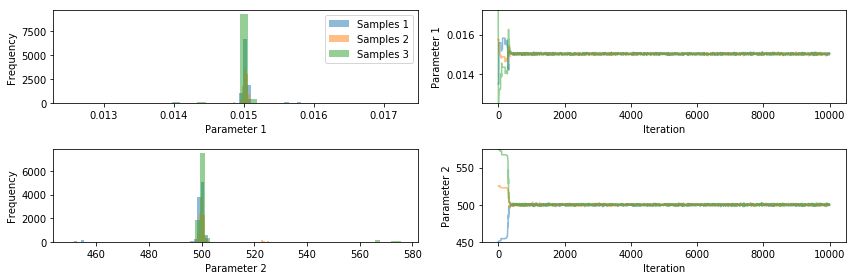

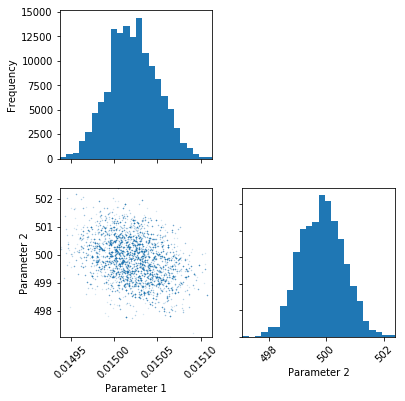

In [27]:
# Show traces and histograms
pints.plot.trace(chains)

# Discard warm up
chains_thin = chains[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_thin[0])

# Show graphs
plt.show()

R-hat:
[1.0012061916432897, 1.0009327632338396]


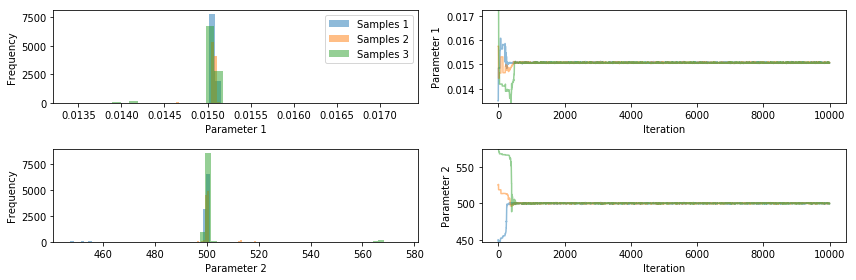

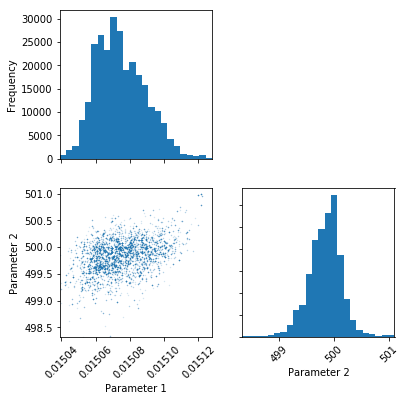

In [28]:
# Show traces and histograms
pints.plot.trace(chains_emu)

# Discard warm up
chains_emu_thin = chains_emu[:, 2000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains_emu_thin))

# Look at distribution in chain 0
pints.plot.pairwise(chains_emu_thin[0])

# Show graphs
plt.show()

In [29]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

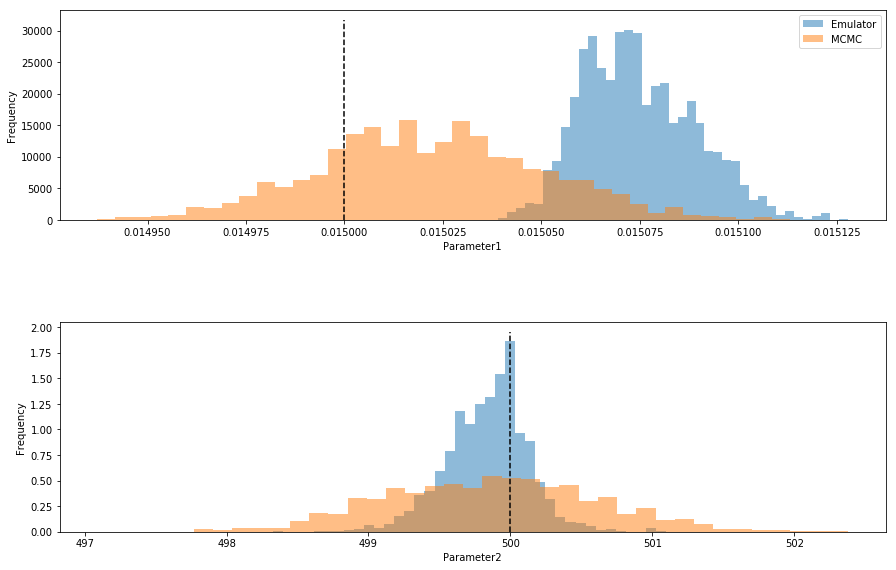

In [30]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

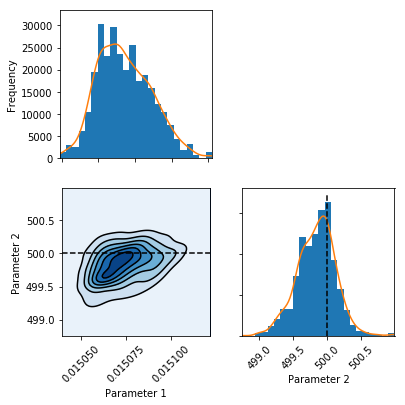

In [31]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

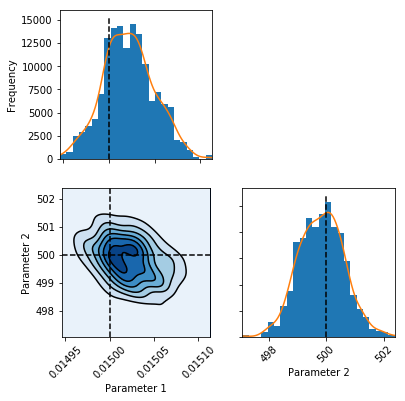

In [32]:
thinned_chain = chain[::10]
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

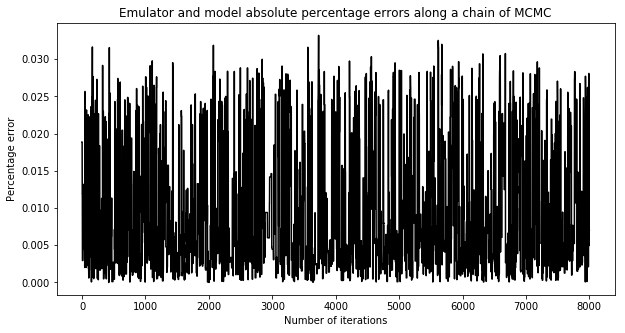

0.009186170744382079

In [33]:
emu_likelihood = np.apply_along_axis(emu, 1, chain).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

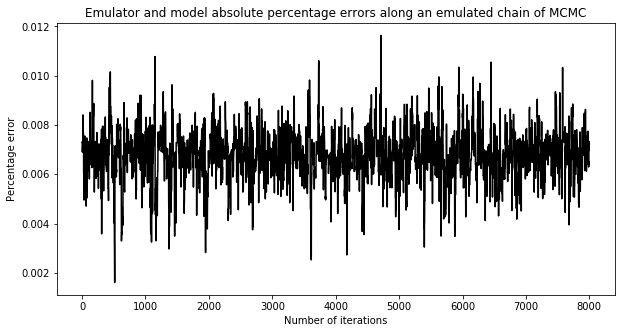

0.006792106707251849

In [34]:
emu_likelihood = np.apply_along_axis(emu, 1, chain_emu).flatten()
model_likelihood = np.apply_along_axis(log_likelihood, 1, chain).flatten()
diffs = np.abs(model_likelihood - emu_likelihood)
percentage_error = np.abs((model_likelihood - emu_likelihood) / model_likelihood)
mean_pe = np.mean(percentage_error)

iters = np.linspace(0, 8000, len(chain_emu))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute percentage errors along an emulated chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Percentage error")
plt.plot(iters, percentage_error, color = "Black")
plt.show()

mean_pe

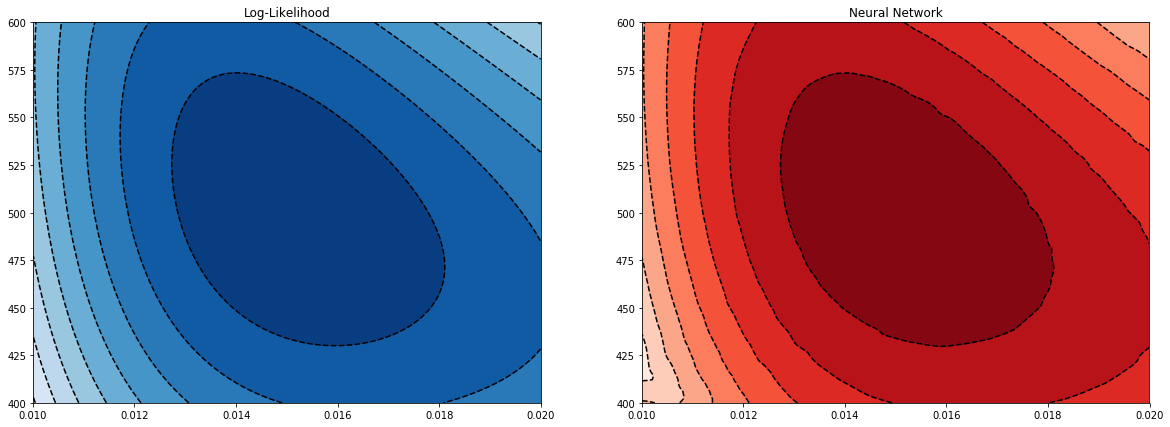

In [35]:
# Create grid of parameters
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

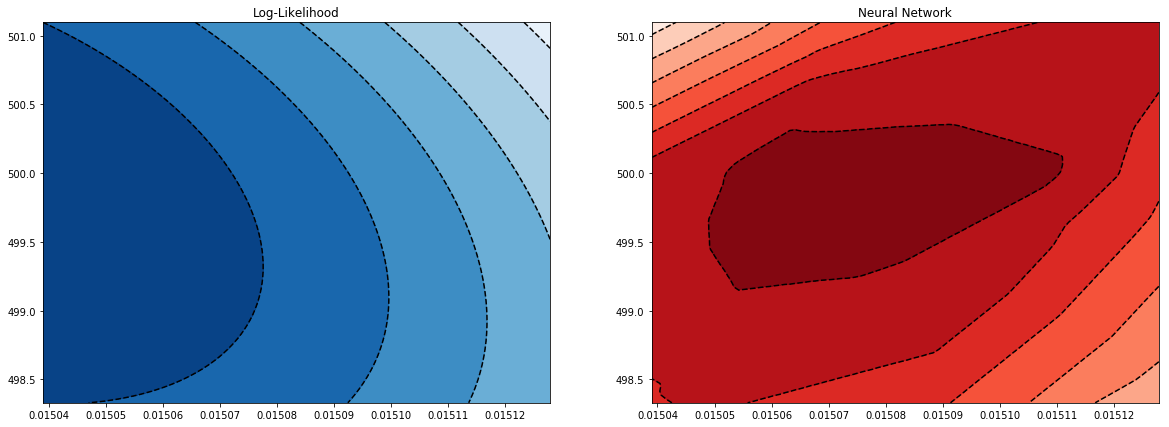

In [36]:
# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

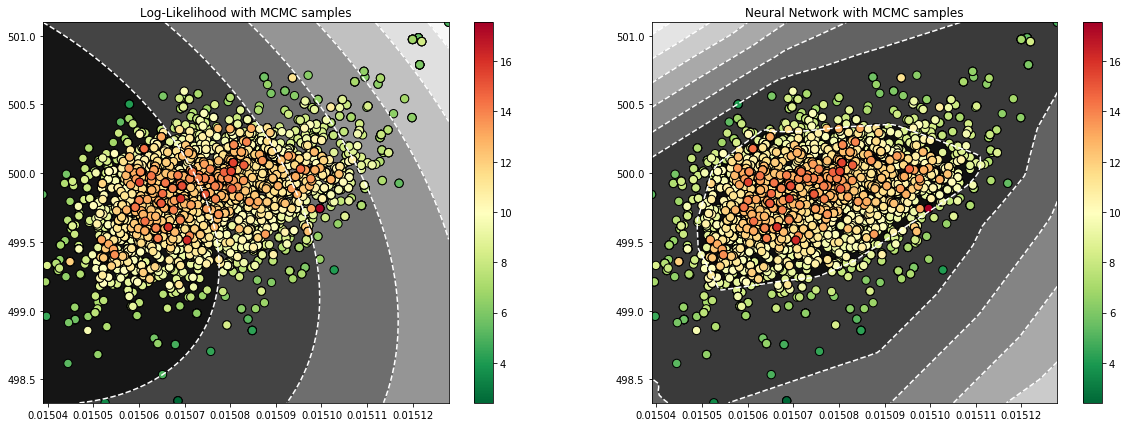

In [39]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu]
y = [p[1] for p in chain_emu]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

fig.savefig("figures/nn-test-contours-old-1000-10.png", bbox_inches='tight', dpi=600)

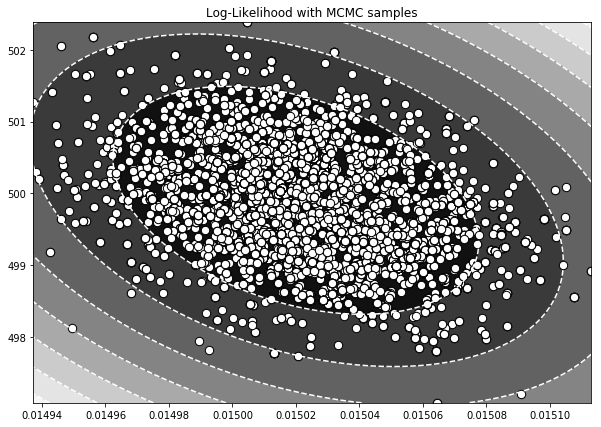

In [38]:
fig, ax = plt.subplots(figsize=(10,7))                   
ax.title.set_text('Log-Likelihood with MCMC samples')                                                                   

# Plot chain
x = [p[0] for p in chain]
y = [p[1] for p in chain]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)

# Add contour lines
ax.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
plt.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax.set_xlim([xmin, xmax])                                                                           
ax.set_ylim([ymin, ymax])

ax.scatter(x, y, s=70, edgecolor='k', color='w')
plt.show()